# Chapter 2: OpenAI Gym

### Toy example environment

In [ ]:
import random
from typing import List


class Environment:
    def __init__(self):
        self.steps_left = 10

    def get_observation(self) -> List[float]:
        return [0.0, 0.0, 0.0]

    def get_actions(self) -> List[int]:
        return [0, 1]

    def is_done(self) -> bool:
        return self.steps_left == 0

    def action(self, action: int) -> float:
        if self.is_done():
            raise Exception("Game is over")
        self.steps_left -= 1
        return random.random()


class Agent:
    def __init__(self):
        self.total_reward = 0.0

    def step(self, env: Environment):
        current_obs = env.get_observation()
        actions = env.get_actions()
        reward = env.action(random.choice(actions))
        self.total_reward += reward


if __name__ == "__main__":
    env = Environment()
    agent = Agent()

    while not env.is_done():
        agent.step(env)

    print("Total reward got: %.4f" % agent.total_reward)
    print("Steps left: %.4f" % env.steps_left)

### create gym environment

In [ ]:

import gym


if __name__ == "__main__":
    env = gym.make("CartPole-v0")

    total_reward = 0.0
    total_steps = 0
    obs = env.reset()

    while True:
        action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        total_steps += 1
        if done:
            break

    print("Episode done in %d steps, total reward %.2f" % (
        total_steps, total_reward))

### Modify gym environment actions using ActionWrapper (e.g. for epsilon-greedy)

In [ ]:
import gym
from typing import TypeVar
import random

Action = TypeVar('Action')


class RandomActionWrapper(gym.ActionWrapper):
    def __init__(self, env, epsilon=0.1):
        super(RandomActionWrapper, self).__init__(env)
        self.epsilon = epsilon

    def action(self, action: Action) -> Action:
        if random.random() < self.epsilon:
            print("Random!")
            return self.env.action_space.sample()
        return action


if __name__ == "__main__":
    env = RandomActionWrapper(gym.make("CartPole-v0"))

    obs = env.reset()
    total_reward = 0.0

    while True:
        obs, reward, done, _ = env.step(0)
        total_reward += reward
        if done:
            break

    print("Reward got: %.2f" % total_reward)

### Monitor gym environment

In [ ]:
import gym


if __name__ == "__main__":
    env = gym.make("CartPole-v0")
    env = gym.wrappers.Monitor(env, "recording")

    total_reward = 0.0
    total_steps = 0
    obs = env.reset()

    while True:
        action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        total_steps += 1
        if done:
            break

    print("Episode done in %d steps, total reward %.2f" % (
        total_steps, total_reward))
    env.close()
    env.env.close()

# Chapter 3: PyTorch

In [ ]:
import torch
import torch.nn as nn

class OurModule(nn.Module):
    def __init__(self, num_inputs, num_classes, dropout_prob=0.3):
        super(OurModule, self).__init__() #Such that the module initialize itself
        self.pipe = nn.Sequential(
            nn.Linear(num_inputs, 5),
            nn.ReLU(),
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, num_classes),
            nn.Dropout(p=dropout_prob),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.pipe(x)

if __name__ == "__main__":
    net = OurModule(num_inputs=2, num_classes=3)
    print(net)
    v = torch.FloatTensor([[2, 3]])
    out = net(v)
    print(out)
    print("Cuda's availability is %s" % torch.cuda.is_available())
    if torch.cuda.is_available():
        print("Data from cuda: %s" % out.to('cuda'))


In [ ]:
#!/usr/bin/env python
import random
import argparse
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from tensorboardX import SummaryWriter

import torchvision.utils as vutils

import gym
import gym.spaces

import numpy as np

log = gym.logger
log.set_level(gym.logger.INFO)

LATENT_VECTOR_SIZE = 100
DISCR_FILTERS = 64
GENER_FILTERS = 64
BATCH_SIZE = 16

# dimension input image will be rescaled
IMAGE_SIZE = 64

LEARNING_RATE = 0.0001
REPORT_EVERY_ITER = 50
SAVE_IMAGE_EVERY_ITER = 100


class InputWrapper(gym.ObservationWrapper):
    """
    Preprocessing of input numpy array:
    1. resize image into predefined size
    2. move color channel axis to a first place
    """
    def __init__(self, *args):
        super(InputWrapper, self).__init__(*args)
        assert isinstance(self.observation_space, gym.spaces.Box)
        old_space = self.observation_space
        self.observation_space = gym.spaces.Box(
            self.observation(old_space.low),
            self.observation(old_space.high),
            dtype=np.float32)

    def observation(self, observation):
        # resize image
        new_obs = cv2.resize(
            observation, (IMAGE_SIZE, IMAGE_SIZE))
        # transform (210, 160, 3) -> (3, 210, 160)
        new_obs = np.moveaxis(new_obs, 2, 0)
        return new_obs.astype(np.float32)


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        # this pipe converges image into the single number
        self.conv_pipe = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=DISCR_FILTERS,
                      kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS, out_channels=DISCR_FILTERS*2,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(DISCR_FILTERS*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS * 2, out_channels=DISCR_FILTERS * 4,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(DISCR_FILTERS * 4),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS * 4, out_channels=DISCR_FILTERS * 8,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(DISCR_FILTERS * 8),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS * 8, out_channels=1,
                      kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        conv_out = self.conv_pipe(x)
        return conv_out.view(-1, 1).squeeze(dim=1)


class Generator(nn.Module):
    def __init__(self, output_shape):
        super(Generator, self).__init__()
        # pipe deconvolves input vector into (3, 64, 64) image
        self.pipe = nn.Sequential(
            nn.ConvTranspose2d(in_channels=LATENT_VECTOR_SIZE, out_channels=GENER_FILTERS * 8,
                               kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(GENER_FILTERS * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS * 8, out_channels=GENER_FILTERS * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(GENER_FILTERS * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS * 4, out_channels=GENER_FILTERS * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(GENER_FILTERS * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS * 2, out_channels=GENER_FILTERS,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(GENER_FILTERS),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS, out_channels=output_shape[0],
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.pipe(x)


def iterate_batches(envs, batch_size=BATCH_SIZE):
    batch = [e.reset() for e in envs]
    env_gen = iter(lambda: random.choice(envs), None)

    while True:
        e = next(env_gen)
        obs, reward, is_done, _ = e.step(e.action_space.sample())
        if np.mean(obs) > 0.01:
            batch.append(obs)
        if len(batch) == batch_size:
            # Normalising input between -1 to 1
            batch_np = np.array(batch, dtype=np.float32)
            batch_np *= 2.0 / 255.0 - 1.0
            yield torch.tensor(batch_np)
            batch.clear()
        if is_done:
            e.reset()


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--cuda", default=False, action='store_true',
        help="Enable cuda computation")
    args,unknown = parser.parse_known_args()

    device = torch.device("cuda" if args.cuda else "cpu")
    envs = [
        InputWrapper(gym.make(name))
        for name in ('Breakout-v0', 'AirRaid-v0', 'Pong-v0')
    ]
    input_shape = envs[0].observation_space.shape

    net_discr = Discriminator(input_shape=input_shape).to(device)
    net_gener = Generator(output_shape=input_shape).to(device)

    objective = nn.BCELoss()
    gen_optimizer = optim.Adam(
        params=net_gener.parameters(), lr=LEARNING_RATE,
        betas=(0.5, 0.999))
    dis_optimizer = optim.Adam(
        params=net_discr.parameters(), lr=LEARNING_RATE,
        betas=(0.5, 0.999))
    writer = SummaryWriter()

    gen_losses = []
    dis_losses = []
    iter_no = 0

    true_labels_v = torch.ones(BATCH_SIZE, device=device)
    fake_labels_v = torch.zeros(BATCH_SIZE, device=device)

    for batch_v in iterate_batches(envs):
        # fake samples, input is 4D: batch, filters, x, y
        gen_input_v = torch.FloatTensor(
            BATCH_SIZE, LATENT_VECTOR_SIZE, 1, 1)
        gen_input_v.normal_(0, 1)
        gen_input_v = gen_input_v.to(device)
        batch_v = batch_v.to(device)
        gen_output_v = net_gener(gen_input_v)

        # train discriminator
        dis_optimizer.zero_grad()
        dis_output_true_v = net_discr(batch_v)
        dis_output_fake_v = net_discr(gen_output_v.detach())
        dis_loss = objective(dis_output_true_v, true_labels_v) + \
                   objective(dis_output_fake_v, fake_labels_v)
        dis_loss.backward()
        dis_optimizer.step()
        dis_losses.append(dis_loss.item())

        # train generator
        gen_optimizer.zero_grad()
        dis_output_v = net_discr(gen_output_v)
        gen_loss_v = objective(dis_output_v, true_labels_v)
        gen_loss_v.backward()
        gen_optimizer.step()
        gen_losses.append(gen_loss_v.item())

        iter_no += 1
        if iter_no % REPORT_EVERY_ITER == 0:
            log.info("Iter %d: gen_loss=%.3e, dis_loss=%.3e",
                     iter_no, np.mean(gen_losses),
                     np.mean(dis_losses))
            writer.add_scalar(
                "gen_loss", np.mean(gen_losses), iter_no)
            writer.add_scalar(
                "dis_loss", np.mean(dis_losses), iter_no)
            gen_losses = []
            dis_losses = []
        if iter_no % SAVE_IMAGE_EVERY_ITER == 0:
            writer.add_image("fake", vutils.make_grid(
                gen_output_v.data[:64], normalize=True), iter_no)
            writer.add_image("real", vutils.make_grid(
                batch_v.data[:64], normalize=True), iter_no)


# Chapter 4: Cross entropy

In [ ]:
#!/usr/bin/env python3
import gym
from collections import namedtuple
import numpy as np
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim


HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70


class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)


Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])


def iterate_batches(env, net, batch_size):
    batch = []
    episode_reward = 0.0
    episode_steps = []
    obs = env.reset()
    sm = nn.Softmax(dim=1)
    while True:
        obs_v = torch.FloatTensor([obs])
        act_probs_v = sm(net(obs_v))
        act_probs = act_probs_v.data.numpy()[0]
        action = np.random.choice(len(act_probs), p=act_probs)
        next_obs, reward, is_done, _ = env.step(action)
        episode_reward += reward
        step = EpisodeStep(observation=obs, action=action)
        episode_steps.append(step)
        if is_done:
            e = Episode(reward=episode_reward, steps=episode_steps)
            batch.append(e)
            episode_reward = 0.0
            episode_steps = []
            next_obs = env.reset()
            if len(batch) == batch_size:
                yield batch
                batch = []
        obs = next_obs


def filter_batch(batch, percentile):
    rewards = list(map(lambda s: s.reward, batch))
    reward_bound = np.percentile(rewards, percentile)
    reward_mean = float(np.mean(rewards))

    train_obs = []
    train_act = []
    for reward, steps in batch:
        if reward < reward_bound:
            continue
        train_obs.extend(map(lambda step: step.observation, steps))
        train_act.extend(map(lambda step: step.action, steps))

    train_obs_v = torch.FloatTensor(train_obs)
    train_act_v = torch.LongTensor(train_act)
    return train_obs_v, train_act_v, reward_bound, reward_mean


if __name__ == "__main__":
    env = gym.make("CartPole-v0")
    # env = gym.wrappers.Monitor(env, directory="mon", force=True)
    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n

    net = Net(obs_size, HIDDEN_SIZE, n_actions)
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=net.parameters(), lr=0.01)
    writer = SummaryWriter(comment="-cartpole")

    for iter_no, batch in enumerate(iterate_batches(
            env, net, BATCH_SIZE)):
        obs_v, acts_v, reward_b, reward_m = \
            filter_batch(batch, PERCENTILE)
        optimizer.zero_grad()
        action_scores_v = net(obs_v)
        loss_v = objective(action_scores_v, acts_v)
        loss_v.backward()
        optimizer.step()
        print("%d: loss=%.3f, reward_mean=%.1f, rw_bound=%.1f" % (
            iter_no, loss_v.item(), reward_m, reward_b))
        writer.add_scalar("loss", loss_v.item(), iter_no)
        writer.add_scalar("reward_bound", reward_b, iter_no)
        writer.add_scalar("reward_mean", reward_m, iter_no)
        if reward_m > 199:
            print("Solved!")
            break
    writer.close()

# Chapter 6: DQNs

Two-gammas

In [ ]:
#!/usr/bin/env python3

import sys  
sys.path.insert(0, '/Users/pablotano/Documents/DistRL/DistRL python/DeepRL/lib')
import wrappers
import dqn_model

# from lib import wrappers
# from lib import dqn_model

import argparse
import time
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim

from tensorboardX import SummaryWriter


DEFAULT_ENV_NAME = "PongNoFrameskip-v4"
MEAN_REWARD_BOUND = 19

GAMMA = 0.99
GAMMA1 = 0.95
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

EPSILON_DECAY_LAST_FRAME = 150000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01


Experience = collections.namedtuple(
    'Experience', field_names=['state', 'action', 'reward',
                               'done', 'new_state'])


class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size,
                                   replace=False)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)


class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v.narrow(-1,0,6), dim=1) #FOR ACTING I ONLY SEE THE FIRST 6 COMPONENTS (ACTIONS)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward,
                         is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward


def calc_loss(batch, net, tgt_net, device="cpu"):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(np.array(
        states, copy=False)).to(device)
    next_states_v = torch.tensor(np.array(
        next_states, copy=False)).to(device)
    actions_v = torch.tensor(actions).to(device)
    actions_v2 = torch.tensor(actions).to(device)+6
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)

    state_action_values1 = net(states_v).gather(
        1, actions_v.unsqueeze(-1)).squeeze(-1)
    state_action_values2 = net(states_v).gather(
        1, actions_v2.unsqueeze(-1)).squeeze(-1)
    with torch.no_grad():
        next_state_values1=tgt_net(next_states_v).narrow(1,0,6).max(1)[0]
        next_state_values2=tgt_net(next_states_v).narrow(1,6,6).max(1)[0]
        next_state_values1[done_mask] = 0.0
        next_state_values2[done_mask] = 0.0
        next_state_values1 = next_state_values1.detach()
        next_state_values2 = next_state_values2.detach()

    expected_state_action_values1 = next_state_values1 * 0.99 + \
                                   rewards_v
    expected_state_action_values2 = next_state_values2 * 0.95 + \
                                   rewards_v

    return nn.MSELoss()(state_action_values1,
                        expected_state_action_values1) + nn.MSELoss()(state_action_values2,
                        expected_state_action_values2)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--cuda", default=False,
                        action="store_true", help="Enable cuda")
    parser.add_argument("--env", default=DEFAULT_ENV_NAME,
                        help="Name of the environment, default=" +
                             DEFAULT_ENV_NAME)
    args,unknown = parser.parse_known_args()
    device = torch.device("cuda" if args.cuda else "cpu")

    env = wrappers.make_env(args.env)

    net = DQN(env.observation_space.shape,
                        env.action_space.n).to(device)
    tgt_net = DQN(env.observation_space.shape,
                            env.action_space.n).to(device)
    writer = SummaryWriter(comment="-" + args.env)
    print(net)

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    epsilon = EPSILON_START

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    total_rewards = []
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_m_reward = None

    while True:
        frame_idx += 1
        epsilon = max(EPSILON_FINAL, EPSILON_START -
                      frame_idx / EPSILON_DECAY_LAST_FRAME)

        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            m_reward = np.mean(total_rewards[-100:])
            print("%d: done %d games, reward %.3f, "
                  "eps %.2f, speed %.2f f/s" % (
                frame_idx, len(total_rewards), m_reward, epsilon,
                speed
            ))
            writer.add_scalar("epsilon", epsilon, frame_idx)
            writer.add_scalar("speed", speed, frame_idx)
            writer.add_scalar("reward_100", m_reward, frame_idx)
            writer.add_scalar("reward", reward, frame_idx)
            if best_m_reward is None or best_m_reward < m_reward:
                torch.save(net.state_dict(), args.env +
                           "-best_%.0f.dat" % m_reward)
                if best_m_reward is not None:
                    print("Best reward updated %.3f -> %.3f" % (
                        best_m_reward, m_reward))
                best_m_reward = m_reward
            if m_reward > MEAN_REWARD_BOUND:
                print("Solved in %d frames!" % frame_idx)
                break

        if len(buffer) < REPLAY_START_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t = calc_loss(batch, net, tgt_net, device=device)
        loss_t.backward()
        optimizer.step()
    writer.close()


One-gamma

In [ ]:
#!/usr/bin/env python3

import sys  
sys.path.insert(0, '/home/pablotano/Desktop/DeepRL/lib')
import wrappers
import dqn_model

import argparse
import time
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim

from tensorboardX import SummaryWriter



DEFAULT_ENV_NAME = "BreakoutNoFrameskip-v4"
MEAN_REWARD_BOUND = 19
FRAME_BOUND = 450000

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 200000
LEARNING_RATE = 0.00001
SYNC_TARGET_FRAMES = 10000
REPLAY_START_SIZE = 200000

EPSILON_DECAY_LAST_FRAME = 300000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01


Experience = collections.namedtuple(
    'Experience', field_names=['state', 'action', 'reward',
                               'done', 'new_state'])


class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size,
                                   replace=False)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)


class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward,
                         is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward


def calc_loss(batch, net, tgt_net, device="cpu"):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(np.array(
        states, copy=False)).to(device)
    next_states_v = torch.tensor(np.array(
        next_states, copy=False)).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)
    rewards_v[done_mask==True]=-1
    
    state_action_values = net(states_v).gather(
        1, actions_v.unsqueeze(-1)).squeeze(-1)
    with torch.no_grad():
        next_state_values = tgt_net(next_states_v).max(1)[0]
        next_state_values[done_mask] = 0.0
        next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + \
                                   rewards_v
    return nn.SmoothL1Loss()(state_action_values,
                        expected_state_action_values)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--cuda", default=False,
                        action="store_true", help="Enable cuda")
    parser.add_argument("--env", default=DEFAULT_ENV_NAME,
                        help="Name of the environment, default=" +
                             DEFAULT_ENV_NAME)
    args,unknown = parser.parse_known_args()
#     device = torch.device("cuda" if args.cuda else "cpu")
    device = torch.device("cuda")
    
    env = wrappers.make_env(args.env)

    net = dqn_model.DQN(env.observation_space.shape,
                        env.action_space.n).to(device)
    
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.kaiming_normal_(m.weight)

    net.apply(init_weights)
    tgt_net = dqn_model.DQN(env.observation_space.shape,
                            env.action_space.n).to(device)
    writer = SummaryWriter(comment="-" + args.env)
    print(net)

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    epsilon = EPSILON_START

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    total_rewards = []
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_m_reward = None

    while True:
        frame_idx += 1
        epsilon = max(EPSILON_FINAL, EPSILON_START -
                      frame_idx / EPSILON_DECAY_LAST_FRAME)

        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            m_reward = np.mean(total_rewards[-100:])
            print("%d: done %d games, reward %.3f, "
                  "eps %.2f, speed %.2f f/s" % (
                frame_idx, len(total_rewards), m_reward, epsilon,
                speed
            ))
            writer.add_scalar("epsilon", epsilon, frame_idx)
            writer.add_scalar("speed", speed, frame_idx)
            writer.add_scalar("reward_100", m_reward, frame_idx)
            writer.add_scalar("reward", reward, frame_idx)
            if best_m_reward is None or best_m_reward < m_reward:
                torch.save(net.state_dict(), args.env +
                           "-best_%.0f.dat" % m_reward)
                if best_m_reward is not None:
                    print("Best reward updated %.3f -> %.3f" % (
                        best_m_reward, m_reward))
                best_m_reward = m_reward
  #          if m_reward > MEAN_REWARD_BOUND:
   #             print("Solved in %d frames!" % frame_idx)
    #            break

        if len(buffer) < REPLAY_START_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t = calc_loss(batch, net, tgt_net, device=device)
        loss_t.backward()
        optimizer.step()
    writer.close()


In [ ]:
from tensorboard import program
tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', 'runs'])
url=tb.launch()
url

### Several gammas, one head

In [ ]:
#!/usr/bin/env python3

import sys  
sys.path.insert(0, '/home/pablotano/Desktop/DeepRL/lib')
import wrappers

import argparse
import time
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim

from tensorboardX import SummaryWriter


DEFAULT_ENV_NAME = "PongNoFrameskip-v4"
MEAN_REWARD_BOUND = 19

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

EPSILON_DECAY_LAST_FRAME = 150000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01


#DEFAULT_ENV_NAME = "BreakoutNoFrameskip-v4"
#MEAN_REWARD_BOUND = 19
#FRAME_BOUND = 450000

#BATCH_SIZE = 32
#REPLAY_SIZE = 200000
#LEARNING_RATE = 0.00001
SYNC_TARGET_FRAMES = 10000
REPLAY_START_SIZE = 200000

EPSILON_DECAY_LAST_FRAME = 300000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01

NUM_GAMMAS=1
taus=np.linspace(1,100,NUM_GAMMAS)
GAMMAS=np.exp(-1/taus)
GAMMAS[-1]=0.99
GAMMAS=np.flip(GAMMAS)
NUM_H=1

Experience = collections.namedtuple(
    'Experience', field_names=['state', 'action', 'reward',
                               'done', 'new_state'])

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, NUM_GAMMAS*NUM_H*n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)
    
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size,
                                   replace=False)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)


class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v.narrow(-1,0,env.action_space.n), dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward,
                         is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward


def calc_loss(batch, net, tgt_net, device="cpu"):
    states, actions, rewards, dones, next_states = batch


    states_v = torch.tensor(np.array(
        states, copy=False)).to(device)
    next_states_v = torch.tensor(np.array(
        next_states, copy=False)).to(device)

    actions_v0 = torch.tensor(actions).to(device)
    output=net(states_v).reshape(BATCH_SIZE,NUM_GAMMAS*NUM_H,env.action_space.n)
    state_action_values=output[range(0,BATCH_SIZE),:,actions_v0]

    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)
    rewards_v[done_mask==True] = -1

    rewards_v=rewards_v.repeat(NUM_GAMMAS*NUM_H,1).T
    done_mask=done_mask.repeat(NUM_GAMMAS*NUM_H,1).T

    gammas=np.tile(GAMMAS,(BATCH_SIZE,1))
    gammas=np.float32(gammas)
    gammas=torch.tensor(gammas).to(device)


    with torch.no_grad():
        output_next=tgt_net(next_states_v).reshape(BATCH_SIZE,NUM_GAMMAS*NUM_H,env.action_space.n)

        next_state_values=output_next[range(0,BATCH_SIZE),:,torch.argmax(output_next[:,0,:],dim=-1)]

        next_state_values[done_mask] = 0.0
        next_state_values = next_state_values.detach()


    expected_state_action_values=next_state_values * gammas + \
                                   rewards_v

    return nn.SmoothL1Loss()(state_action_values,
                        expected_state_action_values)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--cuda", default=False,
                        action="store_true", help="Enable cuda")
    parser.add_argument("--env", default=DEFAULT_ENV_NAME,
                        help="Name of the environment, default=" +
                             DEFAULT_ENV_NAME)
    args,unknown = parser.parse_known_args()
#     device = torch.device("cuda" if args.cuda else "cpu")
    device = torch.device("cuda")
    
    env = wrappers.make_atari("BreakoutNoFrameskip-v4")
    # Warp the frames, grey scale, stake four frame and scale to smaller ratio
    env = wrappers.wrap_deepmind(env, frame_stack=True, scale=True, clip_rewards=False)

    net = DQN(env.observation_space.shape,
                        env.action_space.n).to(device)
    
    tgt_net = DQN(env.observation_space.shape,
                            env.action_space.n).to(device)
    
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.kaiming_normal_(m.weight)

    net.apply(init_weights)
    tgt_net.apply(init_weights)
    
    writer = SummaryWriter(comment="-" + args.env)
    print(net)

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    epsilon = EPSILON_START

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    total_rewards = []
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_m_reward = None

    while True:
        frame_idx += 1
        epsilon = max(EPSILON_FINAL, EPSILON_START -
                      frame_idx / EPSILON_DECAY_LAST_FRAME)

        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            m_reward = np.mean(total_rewards[-100:])
            print("%d: done %d games, reward %.3f, "
                  "eps %.2f, speed %.2f f/s" % (
                frame_idx, len(total_rewards), m_reward, epsilon,
                speed
            ))
            writer.add_scalar("epsilon", epsilon, frame_idx)
            writer.add_scalar("speed", speed, frame_idx)
            writer.add_scalar("reward_100", m_reward, frame_idx)
            writer.add_scalar("reward", reward, frame_idx)
            if best_m_reward is None or best_m_reward < m_reward:
                torch.save(net.state_dict(), args.env +
                           "-best_%.0f.dat" % m_reward)
                if best_m_reward is not None:
                    print("Best reward updated %.3f -> %.3f" % (
                        best_m_reward, m_reward))
                best_m_reward = m_reward
  #          if m_reward > MEAN_REWARD_BOUND:
   #             print("Solved in %d frames!" % frame_idx)
    #            break

        if len(buffer) < REPLAY_START_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t = calc_loss(batch, net, tgt_net, device=device)
        loss_t.backward()
        optimizer.step()
    writer.close()



In [2]:
import sys  
import os
sys.path.insert(0, '/home/pablotano/Desktop/DeepRL/lib')

from lib import wrappers

import torch.optim as optim
import argparse
import time
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim

# from tensorboardX import SummaryWriter

# torch.cuda.empty_cache()

DEFAULT_ENV_NAME = "BreakoutNoFrameskip-v4"
MEAN_REWARD_BOUND = 19

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 30000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 2000
REPLAY_START_SIZE = 10000

EPSILON_DECAY_LAST_FRAME = 150000
EPSILON_START = 1
EPSILON_FINAL = 0.01




NUM_H=1
NUM_GAMMAS=10
ratio=np.ones(NUM_GAMMAS)
taus=np.linspace(1,100,NUM_GAMMAS)
MAX_FRAME=500000
all_weights=np.ones((MAX_FRAME,NUM_GAMMAS))
GAMMAS=np.exp(-1/taus)
GAMMAS[-1]=0.99

GAMMAS=np.flip(GAMMAS)

GAMMAS=np.repeat(GAMMAS,NUM_H)

sens=[-1,1]

Experience = collections.namedtuple(
    'Experience', field_names=['state', 'action', 'reward',
                               'done', 'new_state'])

    

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        
        self.layers = nn.ModuleList()
        for _ in range(NUM_GAMMAS):
            self.layers.append(nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions*NUM_H)))
          
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
    
        out = torch.cat([net(conv_out) for net in self.layers],1)
                 
        return out
    
# class DQN(nn.Module):
#     def __init__(self, input_shape, n_actions):
#         super(DQN, self).__init__()#

#         self.conv = nn.Sequential(
#             nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=4, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1),
#             nn.ReLU()
            
#         )
        
#         conv_out_size = self._get_conv_out(input_shape)
        
#         self.fc = nn.Sequential(
#             nn.Linear(conv_out_size, 5120),
#             nn.ReLU()
#          )
        
#         self.fc2 = nn.Sequential(
#             nn.Linear(5120, NUM_GAMMAS*NUM_H*n_actions)
#          )#

#     def _get_conv_out(self, shape):
#         o = self.conv(torch.zeros(1, *shape))
#         return int(np.prod(o.size()))##
#     def forward(self, x):
#         conv_out = self.conv(x).view(x.size()[0], -1)
#         return self.fc2(self.fc(conv_out))


    
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size,
                                   replace=False)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states), \
               np.array(indices+np.max([0,frame_idx-REPLAY_SIZE]))
    
    def ordered_sample(self,start,end):
        indices = np.arange(start,end)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states), \
               np.array(indices+np.max([0,frame_idx-REPLAY_SIZE]))


class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v.narrow(-1,0,env.action_space.n), dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward,
                         is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward



def calc_loss(batch, net, tgt_net, device="cpu",individual=False,weights=None):
    
    states, actions, rewards, dones, next_states, ind = batch


    states_v = torch.tensor(np.array(
        states, copy=False)).to(device)
    next_states_v = torch.tensor(np.array(
        next_states, copy=False)).to(device)

    actions_v0 = torch.tensor(actions).to(device)
    output=net(states_v)
    output=output.reshape(len(rewards),NUM_GAMMAS*NUM_H,env.action_space.n)
    state_action_values=output[range(0,len(rewards)),:,actions_v0]

    
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)

    rewards_v=rewards_v.repeat(NUM_GAMMAS*NUM_H,1).T
    done_mask=done_mask.repeat(NUM_GAMMAS*NUM_H,1).T

    gammas=np.tile(GAMMAS,(len(rewards),1))
    gammas=np.float32(gammas)
    gammas=torch.tensor(gammas).to(device)

    rewards_v[done_mask] = -1

    rewards_after_sens=rewards_v

   # for i in range(0,NUM_H):
   #     for n in np.arange(1,NUM_GAMMAS): #for the first gamma (position 0) I keep the actual rewards
   #         if i==0:
   #             rewards_after_sens[:,n*NUM_H+i]=torch.tensor((rewards)).float()
   #         else:
   #             rewards_after_sens[:,n*NUM_H+i]=torch.tensor((rewards==sens[i-1])).float()
          #  rewards_after_sens[:,n*NUM_H+i]=torch.tensor((rewards)).float()

    with torch.no_grad():
        output_next=tgt_net(next_states_v)
        output_next=output_next.reshape(len(rewards),NUM_GAMMAS*NUM_H,env.action_space.n)

        best_action=torch.argmax(output_next[:,0,:],dim=-1)

        next_state_values=output_next[range(0,len(rewards)),:,best_action]

        next_state_values[done_mask] = 0.0
    #     rewards_v[done_mask] = -1
        next_state_values = next_state_values.detach()


    expected_state_action_values=next_state_values * gammas + \
                                   rewards_after_sens


    
    losses=nn.SmoothL1Loss(reduction='none')(state_action_values,expected_state_action_values)
    
    if individual==False:
#         return nn.SmoothL1Loss()(state_action_values,
#                     expected_state_action_values)

    #     return torch.mean(weights*torch.mean(losses,1)) #CHANGE SUM BY MEAN DEPENDING ON WEIGHT STRUCTURE
        return torch.mean(weights*losses)
    
    else:
        return torch.mean(losses,0)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--cuda", default=False,
                        action="store_true", help="Enable cuda")
    parser.add_argument("--env", default=DEFAULT_ENV_NAME,
                        help="Name of the environment, default=" +
                             DEFAULT_ENV_NAME)
    args,unknown = parser.parse_known_args()
    device = "cuda"

    env = wrappers.make_env(args.env)

    net = DQN(env.observation_space.shape,
                        env.action_space.n).to('cpu')
    net.to('cuda')
    
    with torch.no_grad():
        tgt_net = DQN(env.observation_space.shape,
                                env.action_space.n).to('cpu')
    tgt_net.to('cuda')

    #net = torch.load(os.getcwd()+'/PongNoFrameskip-v4-best_0.dat')#
    #net.load_state_dict(torch.load(os.getcwd()+'/PongNoFrameskip-v4-best_7.dat'))
  #  tgt_net = torch.load(os.getcwd()+'/dqn_pong_low_r.pt')
    
  #  writer = SummaryWriter(comment="-" + args.env)
    print(net)

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    epsilon = EPSILON_START

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    total_rewards = []
    similarities=[]
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_m_reward = None
    
while True:
        frame_idx += 1


        epsilon = max(EPSILON_FINAL, EPSILON_START -
                     frame_idx / EPSILON_DECAY_LAST_FRAME)
       # epsilon=0.01
        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            m_reward = np.mean(total_rewards[-100:])
            
            if len(total_rewards) % 1 ==0:
                print("%d: done %d games, reward %.3f, "
                      "eps %.2f, speed %.2f f/s, rew epi: %.2f" % (
                    frame_idx, len(total_rewards), m_reward, epsilon,
                    speed, reward
                ))
         #   writer.add_scalar("epsilon", epsilon, frame_idx)
         #   writer.add_scalar("speed", speed, frame_idx)
         #   writer.add_scalar("reward_100", m_reward, frame_idx)
         #   writer.add_scalar("reward", reward, frame_idx)
            if best_m_reward is None or best_m_reward < m_reward:
                net.to('cpu')
                torch.save(net.state_dict(), args.env +
                           "-best_%.0f.dat" % m_reward)
                net.to('cuda')
                if best_m_reward is not None:
                    print("Best reward updated %.3f -> %.3f" % (
                        best_m_reward, m_reward))
                best_m_reward = m_reward
            if m_reward > MEAN_REWARD_BOUND:
                print("Solved in %d frames!" % frame_idx)
                break
       # if frame_idx > 200:
       #     print("Solved in %d frames!" % frame_idx)
       #     break

     #   continue
        
        
        if len(buffer) < REPLAY_START_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            with torch.no_grad():
                del tgt_net #LOAD_STATE_DICT causes memory issues (only seen when running "dmesg" in terminal)
                
                tgt_net = DQN(env.observation_space.shape,
                            env.action_space.n).to('cpu')
                tgt_net.load_state_dict(net.state_dict())
                tgt_net.cuda()
                
        change_frame=20000
        if frame_idx<=change_frame:
            frequency=5000
        else:
            frequency=5000
        
        if frame_idx % frequency == 0:
            all_index=[]
            if frame_idx>=change_frame:
                num_repetitions=int(np.rint((frame_idx/1000))-change_frame/1000)
                starting_points=np.rint(np.linspace(change_frame,len(buffer)-1000,num_repetitions))
            else:
                num_repetitions=1
                starting_points=[len(buffer)-1000];
            for rep in range(0,num_repetitions):
                start=int(starting_points[rep])
                new_q_vals=[]

                torch.save(net.state_dict(), 'net_cache')

                old_net = DQN(env.observation_space.shape,
                                            env.action_space.n).to('cuda')

                batch_ind = buffer.ordered_sample(start,start+1000)
                batch_ind2 = buffer.sample(32)

                actions=batch_ind[1]; states=batch_ind[0]; index=batch_ind[5]

                states_v = torch.tensor(np.float32(np.array(
                    states, copy=False))).to(device)

                actions_v0 = torch.tensor(actions).to(device)
                output_old=net(states_v).reshape(len(actions),NUM_GAMMAS*NUM_H,env.action_space.n)
                old_q_vals=torch.max(output_old[range(0,len(actions)),0:4,0:env.action_space.n],2).values.detach().to('cpu').numpy()
#                 old_q_vals=[np.sum(old_q_vals[i:i+5,:],0) for i in range(0,len(old_q_vals))]
#                 old_q_vals=(output_old[range(0,len(actions)),0:4,actions]).detach().numpy()


                rat=[]; delta=[]; 
                for gamma in range(0,NUM_GAMMAS):
                    optimizer_aux=torch.optim.Adam(old_net.parameters(), lr=LEARNING_RATE)
                    optimizer_aux.zero_grad(); 

                    old_net.load_state_dict(net.state_dict()); old_net.zero_grad()

                    loss = calc_loss(batch_ind2, old_net, old_net, device=device,individual=True)
                    ind_loss=loss[gamma]
                    ind_loss.backward(retain_graph=True)

                    optimizer_aux.step()

                    output=old_net(states_v).reshape(len(actions),NUM_GAMMAS*NUM_H,env.action_space.n)
                    new_q_vals=torch.max(output[range(0,len(actions)),0:4,0:env.action_space.n],2).values.detach().to('cpu').numpy()
#                     new_q_vals=[np.sum(new_q_vals[i:i+5,:],0) for i in range(0,len(old_q_vals))]
#                     new_q_vals=(output[range(0,len(actions)),0:4,actions]).detach().numpy()

                    delta.append(np.mean(np.array(new_q_vals)-np.array(old_q_vals),1))

                    rat.append(np.array(np.mean(delta[gamma])))

                #             ratio=np.array(rat)*4
                ratio=np.array(rat)
                ratio=ratio-np.mean(ratio)+1
                ratio[ratio<0]=0

                delta=np.array(delta)
                delta = (delta - np.min(delta))/(np.max(delta) - np.min(delta))
                # delta=delta-np.mean(delta,0)+1
                # delta[delta<0]=0
                delta[-1,:]=1

                all_index.append(list(index))
                
                if frame_idx>=change_frame:
                    all_weights[index]=np.array(delta).T
                else:
                    all_weights[0:len(all_weights)]=ratio
                    
            all_index_flat = [item for sublist in all_index for item in sublist]
            not_yet_index=list(set(range(0,len(all_weights)))-set(list(all_index_flat)))
            all_weights[not_yet_index]=ratio
            similarities.append(delta)

        optimizer.zero_grad(); net.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        index=batch[5]
        loss_t = calc_loss(batch, net, tgt_net, device=device,individual=False,weights=torch.tensor(all_weights[index]).to('cuda'))
        loss_t.backward(retain_graph=False)
        optimizer.step()
        
        del loss_        del batch
 #   writer.close()

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=4, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=4, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=4, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=4, bias=True)
    )
    (4): Sequential(
      (0): L

IndexError: index 500029 is out of bounds for axis 0 with size 500000

In [16]:
delta[0,:]

array([0.996749  , 0.9970881 , 0.99723136, 0.9974223 , 0.99746466,
       0.9974351 , 0.9974351 , 0.9974351 , 1.0008812 , 1.000821  ,
       0.99961746, 0.9998902 , 0.99988276, 0.99987584, 0.9998941 ,
       0.9998832 , 0.9998819 , 0.99981594, 0.99934155, 0.99930453,
       0.99934816, 0.9991846 , 0.997511  , 0.9968609 , 0.9972315 ,
       0.9971267 , 0.9973319 , 0.9973668 , 0.9971846 , 0.9969646 ,
       0.99713606, 1.0008866 , 1.000821  , 0.9997306 , 0.99960417,
       0.99952775, 0.9996173 , 0.99942225, 0.9994847 , 0.9991807 ,
       0.99903023, 0.9990076 , 0.9985372 , 0.99803007, 0.99688774,
       0.9977522 , 0.99734056, 0.9968392 , 0.99644184, 0.9967146 ,
       0.9950765 , 0.99667186, 1.0008821 , 1.0008198 , 0.99961597,
       0.9998845 , 0.99987507, 0.99989855, 0.9998952 , 0.9998856 ,
       0.9998982 , 0.9998492 , 0.99934155, 0.9993146 , 0.99933136,
       0.99915946, 0.99756753, 0.9967684 , 0.99720466, 0.99723136,
       0.9974223 , 0.99746466, 0.9974351 , 0.9974351 , 0.99743

In [14]:
np.shape(delta)

(50, 1000)

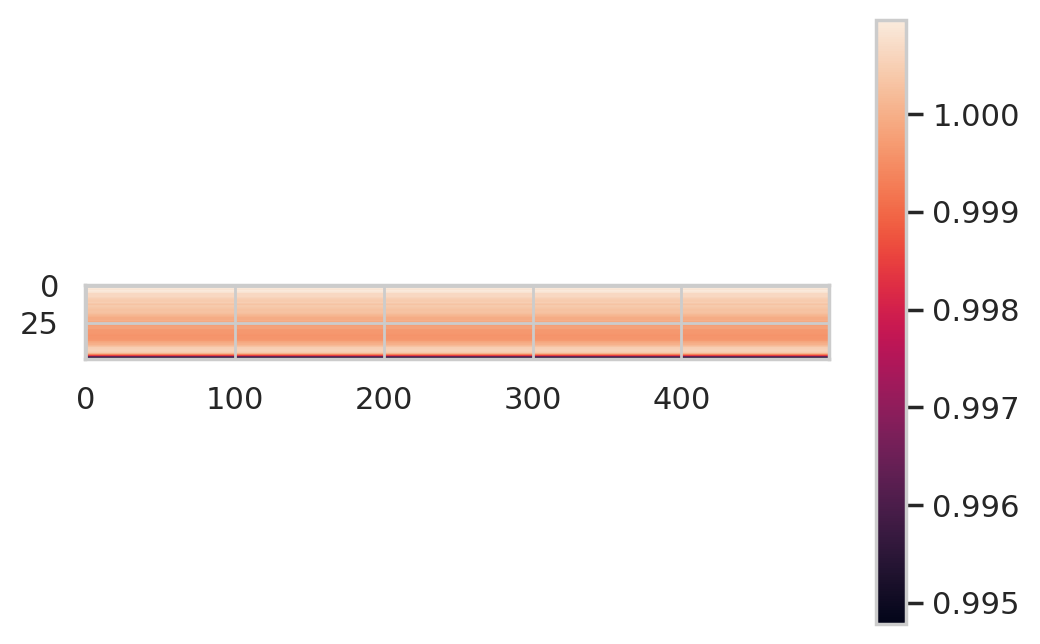

In [15]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


plt.figure(dpi=200)
i=190000
plt.imshow(all_weights[i:i+500,:].T); plt.colorbar(); plt.show()

### PONG

In [669]:
import sys  
import os
sys.path.insert(0, '/home/pablotano/Desktop/DeepRL/lib')

from lib import wrappers

import torch.optim as optim
import argparse
import time
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim

# from tensorboardX import SummaryWriter

# torch.cuda.empty_cache()

DEFAULT_ENV_NAME = "PongNoFrameskip-v4"
MEAN_REWARD_BOUND = 19

BATCH_SIZE = 32
REPLAY_SIZE = 300000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 2000
REPLAY_START_SIZE = 10000

EPSILON_DECAY_LAST_FRAME = 150000
EPSILON_START = 1
EPSILON_FINAL = 0.01

NUM_H=1
NUM_GAMMAS=50
ratio=np.ones(NUM_GAMMAS)
taus=np.linspace(1,100,NUM_GAMMAS)
GAMMAS=np.exp(-1/taus)
GAMMAS[-1]=0.96

GAMMAS=np.flip(GAMMAS)

GAMMAS=np.repeat(GAMMAS,NUM_H)

sens=[-1,1]

Experience = collections.namedtuple(
    'Experience', field_names=['state', 'action', 'reward',
                               'done', 'new_state'])

    
losses=[]
class DQN2(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        
        self.layers = nn.ModuleList()
        for _ in range(NUM_GAMMAS):
            self.layers.append(nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions*NUM_H)))
          
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
    
        out = torch.cat([net(conv_out) for net in self.layers],1)
                 
        return out
    
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()#

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
            
        )
        
        conv_out_size = self._get_conv_out(input_shape)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 5120),
            nn.ReLU(),
            nn.Linear(5120, NUM_GAMMAS*NUM_H*n_actions)
         )
        
#         self.fc2 = nn.Sequential(
#             nn.Linear(5120, NUM_GAMMAS*NUM_H*n_actions)
#          )#

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))##
    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)


    
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size,
                                   replace=False)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)
    
    def ordered_sample(self,start,end):
        indices = np.arange(start,end)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)


class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v.narrow(-1,0,env.action_space.n), dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward,
                         is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward



def calc_loss(batch, net, tgt_net, device="cpu",individual=False,weights=None):
    
    states, actions, rewards, dones, next_states = batch


    states_v = torch.tensor(np.array(
        states, copy=False)).to(device)
    next_states_v = torch.tensor(np.array(
        next_states, copy=False)).to(device)

    actions_v0 = torch.tensor(actions).to(device)
    output=net(states_v)
    output=output.reshape(len(rewards),NUM_GAMMAS*NUM_H,env.action_space.n)
    state_action_values=output[range(0,len(rewards)),:,actions_v0]

    
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)

    rewards_v=rewards_v.repeat(NUM_GAMMAS*NUM_H,1).T
    done_mask=done_mask.repeat(NUM_GAMMAS*NUM_H,1).T

    gammas=np.tile(GAMMAS,(len(rewards),1))
    gammas=np.float32(gammas)
    gammas=torch.tensor(gammas).to(device)

    rewards_v[done_mask] = -1

    rewards_after_sens=rewards_v

   # for i in range(0,NUM_H):
   #     for n in np.arange(1,NUM_GAMMAS): #for the first gamma (position 0) I keep the actual rewards
   #         if i==0:
   #             rewards_after_sens[:,n*NUM_H+i]=torch.tensor((rewards)).float()
   #         else:
   #             rewards_after_sens[:,n*NUM_H+i]=torch.tensor((rewards==sens[i-1])).float()
          #  rewards_after_sens[:,n*NUM_H+i]=torch.tensor((rewards)).float()

    with torch.no_grad():
        output_next=tgt_net(next_states_v)
        output_next=output_next.reshape(len(rewards),NUM_GAMMAS*NUM_H,env.action_space.n)

        best_action=torch.argmax(output_next[:,0,:],dim=-1)

        next_state_values=output_next[range(0,len(rewards)),:,best_action]

        next_state_values[done_mask] = 0.0
    #     rewards_v[done_mask] = -1
        next_state_values = next_state_values.detach()


    expected_state_action_values=next_state_values * gammas + \
                                   rewards_after_sens


    
    losses=torch.transpose(nn.SmoothL1Loss(reduction='none')(state_action_values,expected_state_action_values),0,1)
    

    return torch.sum(weights*torch.mean(losses,1)), torch.mean(losses,1)



if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--cuda", default=False,
                        action="store_true", help="Enable cuda")
    parser.add_argument("--env", default=DEFAULT_ENV_NAME,
                        help="Name of the environment, default=" +
                             DEFAULT_ENV_NAME)
    args,unknown = parser.parse_known_args()
    device = "cuda"

    env = wrappers.make_env(args.env)

    net = DQN(env.observation_space.shape,
                        env.action_space.n).to('cpu')
    net.to('cuda')
    
    with torch.no_grad():
        tgt_net = DQN(env.observation_space.shape,
                                env.action_space.n).to('cpu')


    #net = torch.load(os.getcwd()+'/PongNoFrameskip-v4-best_0.dat')#
    #net.load_state_dict(torch.load(os.getcwd()+'/PongNoFrameskip-v4-best_7.dat'))
  #  tgt_net = torch.load(os.getcwd()+'/dqn_pong_low_r.pt')
    
  #  writer = SummaryWriter(comment="-" + args.env)
    print(net)

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    epsilon = EPSILON_START

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    total_rewards = []
    similarities=[]
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_m_reward = None
while True:
        frame_idx += 1


        epsilon = max(EPSILON_FINAL, EPSILON_START -
                     frame_idx / EPSILON_DECAY_LAST_FRAME)
       # epsilon=0.01
        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            m_reward = np.mean(total_rewards[-100:])
            
            if len(total_rewards) % 1 ==0:
                print("%d: done %d games, reward %.3f, "
                      "eps %.2f, speed %.2f f/s, rew epi: %.2f" % (
                    frame_idx, len(total_rewards), m_reward, epsilon,
                    speed, reward
                ))
         #   writer.add_scalar("epsilon", epsilon, frame_idx)
         #   writer.add_scalar("speed", speed, frame_idx)
         #   writer.add_scalar("reward_100", m_reward, frame_idx)
         #   writer.add_scalar("reward", reward, frame_idx)
            if best_m_reward is None or best_m_reward < m_reward:
                net.to('cpu')
                torch.save(net.state_dict(), args.env +
                           "-best_%.0f.dat" % m_reward)
                net.to('cuda')
                if best_m_reward is not None:
                    print("Best reward updated %.3f -> %.3f" % (
                        best_m_reward, m_reward))
                best_m_reward = m_reward
            if m_reward > MEAN_REWARD_BOUND:
                print("Solved in %d frames!" % frame_idx)
                break
       # if frame_idx > 200:
       #     print("Solved in %d frames!" % frame_idx)
       #     break

     #   continue
        
        
        if len(buffer) < REPLAY_START_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            with torch.no_grad():
                del tgt_net #LOAD_STATE_DICT causes memory issues (only seen when running "dmesg" in terminal)
                
                tgt_net = DQN(env.observation_space.shape,
                            env.action_space.n).to('cpu')
                tgt_net.load_state_dict(net.state_dict())
                tgt_net.cuda()
                
        if frame_idx % 2000000005 == 0:
            torch.save(net.state_dict(), 'net_cache')
            pre_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
            pre_net.load_state_dict(net.state_dict());
            optimizer_pre = optim.Adam(pre_net.parameters(), lr=LEARNING_RATE)
            rat_all=[]
            
            
            for _ in range(5):
            
                batch_ind = buffer.sample(32)
                actions=batch_ind[1]; states=batch_ind[0];
                states_v = torch.tensor(np.float32(np.array(states, copy=False))).to(device)
#                 output_old=pre_net(states_v).reshape(len(actions),NUM_GAMMAS*NUM_H,env.action_space.n)
#                 old_q_vals=(output_old[range(0,len(actions)),0,actions]).detach().numpy()

                _ , loss = calc_loss(batch_ind, pre_net, tgt_net, device=device,individual=True,weights=torch.tensor(ratio ).to(device))
                ind_loss=loss[0]
                ind_loss.backward(retain_graph=True)
                grad_main=[pre_net.fc[0].weight.grad, pre_net.fc[2].weight.grad,
                           pre_net.conv[0].weight.grad, pre_net.conv[2].weight.grad, pre_net.conv[4].weight.grad]
                torch.save(pre_net.state_dict(), 'pre_net_cache')

                rat=[]; los=[]
                
                for gamma in range(0,NUM_GAMMAS):
                    aux_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
                    optimizer_aux=torch.optim.Adam(aux_net.parameters(), lr=LEARNING_RATE)
                    optimizer_aux.zero_grad();
                    aux_net.load_state_dict(pre_net.state_dict());
                    aux_net.zero_grad()
                    
                    _ , loss = calc_loss(batch_ind, aux_net, tgt_net, device=device,weights=torch.tensor(ratio ).to(device))
                    ind_loss=loss[gamma]
                    ind_loss.backward(retain_graph=True)
                    grad_aux=[aux_net.fc[0].weight.grad, aux_net.fc[2].weight.grad,
                              aux_net.conv[0].weight.grad, aux_net.conv[2].weight.grad, aux_net.conv[4].weight.grad]
    
#                     optimizer_aux.step()
        
#                     output=aux_net(states_v).reshape(len(actions),NUM_GAMMAS*NUM_H,env.action_space.n)
#                     new_q_vals=(output[range(0,len(actions)),0,actions]).detach().to('cpu').numpy()
                    
                    sim=np.sum([torch.dot(grad_main[i].view(-1),grad_aux[i].view(-1)) for i in [0,1,2]])
#                     sim = np.mean(np.array(new_q_vals)-np.array(old_q_vals))
                    rat.append(sim.detach().to('cpu').numpy())
                    
                rat_all.append(rat)
                optimizer_pre.zero_grad(); pre_net.zero_grad()
                loss_t, _ = calc_loss(batch_ind, pre_net, tgt_net, device=device,weights=torch.tensor(ratio ).to(device))
                loss_t.backward(retain_graph=False)
                optimizer_pre.step()
                torch.save(pre_net.state_dict(), 'pre_net_cache')
                
                
            ratio=np.array(np.sum(rat_all,0)) 
            
            ratio=(ratio-np.min(ratio))/(np.max(ratio)-np.min(ratio))
            ratio=ratio-np.mean(ratio)+1
            
            similarities.append(ratio)

        
        
        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t, _ = calc_loss(batch, net, tgt_net, device=device,individual=False,weights=1+0*torch.tensor(ratio).to('cuda'))
        losses.append(np.array(loss_t.item()))
        loss_t.backward()
        optimizer.step()
        del loss_t
        del batch
 #   writer.close()
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid')
plt.figure(dpi=130)
plt.imshow(np.array(similarities).T)
plt.colorbar()

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=5120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5120, out_features=300, bias=True)
  )
)
818: done 1 games, reward -21.000, eps 0.99, speed 732.33 f/s, rew epi: -21.00
1770: done 2 games, reward -20.500, eps 0.99, speed 701.42 f/s, rew epi: -20.00
Best reward updated -21.000 -> -20.500
2713: done 3 games, reward -20.333, eps 0.98, speed 695.23 f/s, rew epi: -20.00
Best reward updated -20.500 -> -20.333
3619: done 4 games, reward -20.250, eps 0.98, speed 722.21 f/s, rew epi: -20.00
Best reward updated -20.333 -> -20.250
4547: done 5 games, reward -20.200, eps 0.97, speed 707.10 f/s, rew epi: -20.00
Best reward updated -20.250 -> -20.200
5538: done 6 games, r

KeyboardInterrupt: 

In [650]:
state_a = np.array([agent.state], copy=False)
state_v = torch.tensor(state_a).to(device)
q_vals_v = net(state_v)
_, act_v = torch.max(q_vals_v.narrow(-1,0,env.action_space.n), dim=1)
action = int(act_v.item())


In [652]:
q_vals_v.narrow(-1,0,env.action_space.n)

tensor([[-0.8014, -0.8055, -0.8035, -0.8007, -0.8242, -0.8077]],
       device='cuda:0', grad_fn=<SliceBackward>)

In [654]:
_, act_v = torch.max(q_vals_v.narrow(-1,0,env.action_space.n), dim=1)
act_v

tensor([3], device='cuda:0')

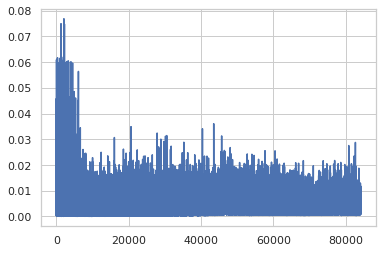

In [656]:
import matplotlib.pyplot as plt
plt.plot(losses)

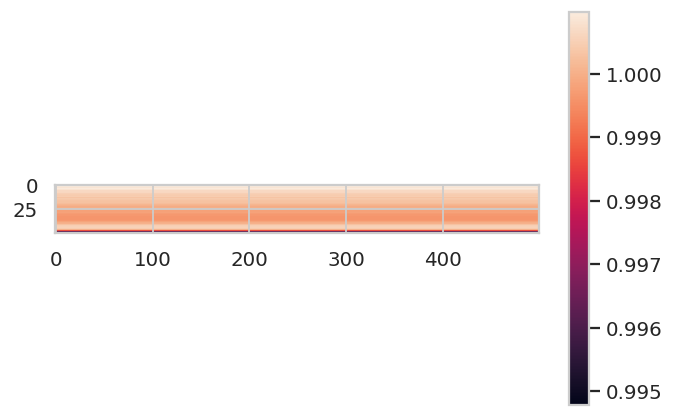

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid')
plt.figure(dpi=130)
i=370000
plt.imshow(np.array(all_weights[i:i+500
                               ]).T)
plt.colorbar()

In [63]:
# import gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
epsilon=0.0

device='cuda'
# env = wrappers.make_env(DEFAULT_ENV_NAME)
# env.reset()
# env = gym.make(args.env)
agent.env.reset()
# plt.figure(dpi=100)
tgt_net=net
weights=[]; pos=[]; rewards=[]

torch.save(net.state_dict(), 'net_cache')

old_net = DQN(env.observation_space.shape,
                            env.action_space.n).to('cuda')
for iteration in range(40000):
    clear_output(wait=True);
    time.sleep(0)

    agent.play_step(net, epsilon, device=device)
    
    BATCH_SIZE=5
    batch_ind = buffer.ordered_sample(len(buffer)-BATCH_SIZE,len(buffer))

    
    actions=batch_ind[1]; states=batch_ind[0]; reward=batch_ind[2]
    rewards.append(reward)

    states_v = torch.tensor(np.float32(np.array(
        states, copy=False))).to(device)

    output_old=net(states_v)
    old_q_vals=(output_old[range(0,len(actions)),actions]).detach().to('cpu').numpy()
    


    ratio=[]; delta=[]
    for gamma in range(0,NUM_GAMMAS):
        optimizer_aux=torch.optim.Adam(old_net.parameters(), lr=LEARNING_RATE)
        optimizer_aux.zero_grad();
        
        old_net.load_state_dict(net.state_dict()); 
        old_net.zero_grad()
            
        loss = calc_loss(batch_ind, old_net, net, device=device,individual=True)
        ind_loss=loss.mean(0)[gamma]
        ind_loss.backward(retain_graph=True)
        
       # with torch.no_grad():
       #     for p in old_net.parameters():
       #         new_value = p - LEARNING_RATE*p.grad
       #         p.copy_(new_value)
            
        optimizer_aux.step()

        output=old_net(states_v)
        
        new_q_vals=torch.max(output[range(0,len(actions)),0:env.action_space.n],1).values.detach().to('cpu').numpy()

        delta.append(np.array(new_q_vals)-np.array(old_q_vals))

        ratio.append(np.array((np.sum(delta[gamma])/BATCH_SIZE)))

    ratio=ratio-np.mean(ratio)
    weights.append(ratio)

    plt.figure(dpi=250)
    plt.subplot(1,3,1)
    plt.plot(-2/np.log(GAMMAS),np.array(ratio).flatten(),'k'); 
    plt.plot(-2/np.log(GAMMAS),np.array(ratio).flatten(),'ko'); 
    #plt.plot([-5,205],[0,0],color=[0.6,0.6,0.6]);  
    plt.ylim([-0.0075,0.0075])
    plt.subplot(1,3,2)
   # plt.title([np.mean(old_q_vals),np.mean(new_q_vals)])
    frame=np.sum(np.sum((states_v).detach().to('cpu').numpy(),0),0)
    plt.imshow(frame);

    if iteration>1:
        plt.subplot(1,3,3)
        dif=frame-old_frame
        plt.imshow(dif,vmin=0.05); 

    old_states=states_v
    old_frame=frame
    plt.show()
 #   agent.env.render()


    
    
env.close()


KeyboardInterrupt: 

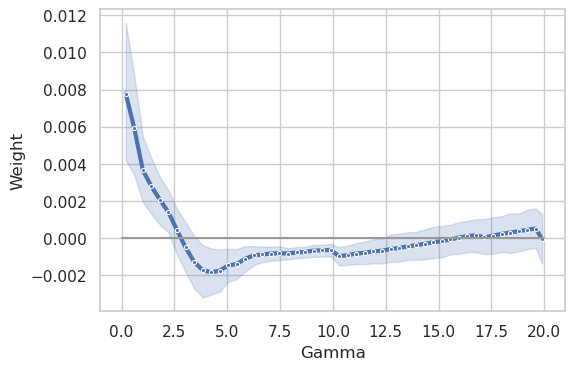

In [82]:
import seaborn as sns
import pandas as pd
s=np.array(pos)
sns.set_theme(style="whitegrid")
down=[weights[i] for i in range(0,len(s)) if s[i]>0.01]
x_ax=[-0.2/np.log(GAMMAS) for i in range(0,len(s)) if s[i]>0.01]

# df=pd.DataFrame(np.array(down)).melt()
df= pd.DataFrame({"Weight" : np.array(down).flatten(),
                  "Gamma" : np.array(x_ax).flatten()})

plt.figure(dpi=100)
fig=sns.lineplot(x="Gamma", y="Weight", data=df,ci=95,linewidth=3,marker=".")

# plt.ylim([-1,1.05]);
plt.plot([0,20],[0,0],color=[0.6,0.6,0.6]);
#plt.plot(-2/np.log(GAMMAS),np.mean(np.array(down).T,1),'o',color='steelblue',markersize=4)
plt.savefig('demo.png', transparent=True)

TypeError: Invalid shape (1000, 50, 99) for image data

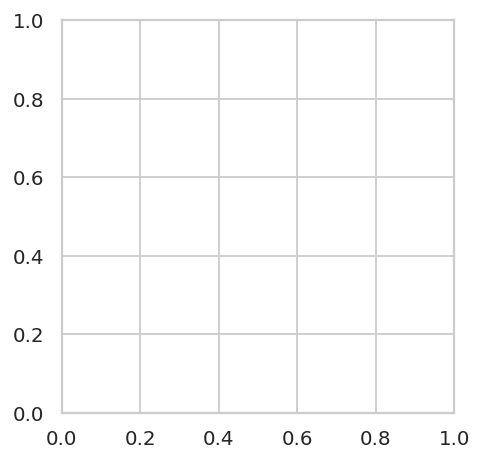

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid')
plt.figure(dpi=130)
plt.imshow(np.array(similarities).T)
plt.colorbar()

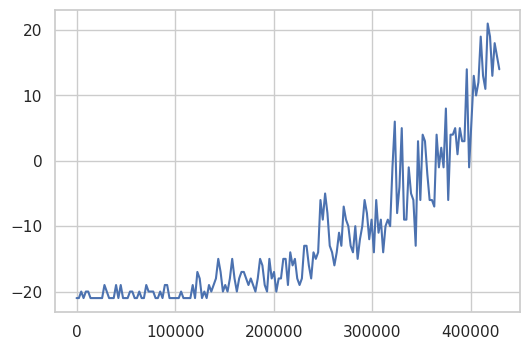

In [667]:
# torch.save(total_rewards, os.getcwd()+'/rewards_pong_096.txt')
# b=np.loadtxt('rewards_pong_096.txt',dtype=int)

import matplotlib.pyplot as plt
plt.figure(dpi=100)
plt.plot(np.linspace(0,429000,len(total_rewards)),total_rewards)
# plt.plot(np.linspace(0,429000,len(b)),b)#
plt.grid(b=True)

In [52]:
b=np.loadtxt('rewards_fast_pong.pt',dtype=int)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 64: invalid start byte

In [27]:
#torch.save(net, os.getcwd()+'/dqn_oh_50g_pong.pt')
np.savetxt('rewards_oh_50g_pong.txt',total_rewards,fmt='%d')
np.savetxt('importances_oh_50g_pong.txt',similarities,fmt='%d')

### Breakout

In [ ]:
# import sys  
import os
#sys.path.insert(0, '/home/pablotano/Desktop/DeepRL/lib')

from lib import wrappers

import torch.optim as optim
import argparse
import time
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim

# from tensorboardX import SummaryWriter

# torch.cuda.empty_cache()

DEFAULT_ENV_NAME = "BreakoutNoFrameskip-v4"
MEAN_REWARD_BOUND = 19

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 400000 #200000
LEARNING_RATE = 0.0000625 #1e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 50000 #200000

#EPSILON_DECAY_LAST_FRAME =1000000
#EPSILON_START = 1
#EPSILON_FINAL = 0.01
eps_initial=1
eps_final=0.1
eps_final_frame=0.01
eps_evaluation=0.0
eps_annealing_frames=1000000
max_frames=2000000

NUM_H=1
NUM_GAMMAS=50
ratio=np.ones(NUM_GAMMAS)
taus=np.linspace(3,100,NUM_GAMMAS)
GAMMAS=np.exp(-1/taus)
GAMMAS[-1]=0.99

GAMMAS=np.flip(GAMMAS)

GAMMAS=np.repeat(GAMMAS,NUM_H)

sens=[1,4,7]

Experience = collections.namedtuple(
    'Experience', field_names=['state', 'action', 'reward',
                               'done', 'new_state'])



class DQN2(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        
        self.layers = nn.ModuleList()
        for _ in range(NUM_GAMMAS):
            self.layers.append(nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions*NUM_H)))
          
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
    
        out = torch.cat([net(conv_out) for net in self.layers],1)
                 
        return out
    
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()#

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
            
        )
        
        conv_out_size = self._get_conv_out(input_shape)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 5120),
            nn.ReLU()
         )
        
        self.fc2 = nn.Sequential(
            nn.Linear(5120, NUM_GAMMAS*NUM_H*n_actions)
         )#

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))##
    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc2(self.fc(conv_out))


    
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size,
                                   replace=False)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)
    
    def ordered_sample(self,start,end):
        indices = np.arange(start,end)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)


class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v.narrow(-1,0,env.action_space.n), dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward,
                         is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward



def calc_loss(batch, net, tgt_net, device="cpu",individual=False,weights=None):
    
    states, actions, rewards, dones, next_states = batch


    states_v = torch.tensor(np.array(
        states, copy=False)).to(device)
    next_states_v = torch.tensor(np.array(
        next_states, copy=False)).to(device)

    actions_v0 = torch.tensor(actions).to(device)
    output=net(states_v)
    output=output.reshape(len(rewards),NUM_GAMMAS*NUM_H,env.action_space.n)
    state_action_values=output[range(0,len(rewards)),:,actions_v0]

    
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)

    rewards_v=rewards_v.repeat(NUM_GAMMAS*NUM_H,1).T
    done_mask=done_mask.repeat(NUM_GAMMAS*NUM_H,1).T

    gammas=np.tile(GAMMAS,(len(rewards),1))
    gammas=np.float32(gammas)
    gammas=torch.tensor(gammas).to(device)

    rewards_v[done_mask] = -1

    rewards_after_sens=rewards_v

   # for i in range(0,NUM_H):
   #     for n in np.arange(1,NUM_GAMMAS): #for the first gamma (position 0) I keep the actual rewards
   #         if i==0:
   #             rewards_after_sens[:,n*NUM_H+i]=torch.tensor((rewards)).float()
   #         else:
   #             rewards_after_sens[:,n*NUM_H+i]=torch.tensor((rewards==sens[i-1])).float()
          #  rewards_after_sens[:,n*NUM_H+i]=torch.tensor((rewards)).float()

    with torch.no_grad():
        output_next=tgt_net(next_states_v)
        output_next=output_next.reshape(len(rewards),NUM_GAMMAS*NUM_H,env.action_space.n)

        best_action=torch.argmax(output_next[:,0,:],dim=-1)

        next_state_values=output_next[range(0,len(rewards)),:,best_action]

        next_state_values[done_mask] = 0.0
    #     rewards_v[done_mask] = -1
        next_state_values = next_state_values.detach()


    expected_state_action_values=next_state_values * gammas + \
                                   rewards_after_sens


    
    losses=torch.transpose(nn.SmoothL1Loss(reduction='none')(state_action_values,expected_state_action_values),0,1)
    
    if individual==False:
#         return nn.SmoothL1Loss()(state_action_values,
#                     expected_state_action_values)
        return torch.mean(weights*torch.mean(losses,1))
    
    else:
        return weights*torch.mean(losses,1)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--cuda", default=False,
                        action="store_true", help="Enable cuda")
    parser.add_argument("--env", default=DEFAULT_ENV_NAME,
                        help="Name of the environment, default=" +
                             DEFAULT_ENV_NAME)
    args,unknown = parser.parse_known_args()
    device = "cuda"

    env = wrappers.make_env(args.env)

    net = DQN(env.observation_space.shape,
                        env.action_space.n).to('cpu')
    net.to('cuda')
    
    with torch.no_grad():
        tgt_net = DQN(env.observation_space.shape,
                                env.action_space.n).to('cpu')

    tgt_net.to('cuda')

    #net = torch.load(os.getcwd()+'/dqn_oh_50g_adaptive_breakout.pt')#
    #net.load_state_dict(torch.load(os.getcwd()+'/PongNoFrameskip-v4-best_7.dat'))
  #  tgt_net = torch.load(os.getcwd()+'/dqn_pong_low_r.pt')
    
  #  writer = SummaryWriter(comment="-" + args.env)
    print(net)

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    epsilon = eps_initial
    slope = -( eps_initial -  eps_final)/ eps_annealing_frames
    intercept =  eps_initial -  slope* REPLAY_START_SIZE
    slope_2 = -( eps_final -  eps_final_frame)/( max_frames -  eps_annealing_frames -  REPLAY_START_SIZE)
    intercept_2 =  eps_final_frame -  slope_2* max_frames

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    total_rewards = []
    similarities=[]
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_m_reward = None
while True:
        frame_idx += 1
        if frame_idx < REPLAY_START_SIZE:
            epsilon = eps_initial
        elif frame_idx >= REPLAY_START_SIZE and frame_idx < REPLAY_START_SIZE + eps_annealing_frames:
            epsilon =  slope*frame_idx +  intercept
        elif frame_idx >=  REPLAY_START_SIZE +  eps_annealing_frames:
            epsilon =  slope_2*frame_idx + intercept_2

        if epsilon<eps_final_frame:
            epsilon=eps_final_frame

#         epsilon=0.01
        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            m_reward = np.mean(total_rewards[-100:])
            
            if len(total_rewards) % 50 ==0:
                print("%d: done %d games, reward %.3f, "
                      "eps %.2f, speed %.2f f/s, rew epi: %.2f" % (
                    frame_idx, len(total_rewards), m_reward, epsilon,
                    speed, reward
                ))
         #   writer.add_scalar("epsilon", epsilon, frame_idx)
         #   writer.add_scalar("speed", speed, frame_idx)
         #   writer.add_scalar("reward_100", m_reward, frame_idx)
         #   writer.add_scalar("reward", reward, frame_idx)
            if best_m_reward is None or best_m_reward < m_reward:
                net.to('cpu')
                torch.save(net.state_dict(), args.env +
                           "-best_%.0f.dat" % m_reward)
                net.to('cuda')
                if best_m_reward is not None:
                    print("Best reward updated %.3f -> %.3f" % (
                        best_m_reward, m_reward))
                best_m_reward = m_reward
        #    if m_reward > MEAN_REWARD_BOUND:
         #       print("Solved in %d frames!" % frame_idx)
        #       break
#         if frame_idx > 200000:
#             print("Solved in %d frames!" % frame_idx)
#             break

#         continue
        
        
        if len(buffer) < REPLAY_START_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            with torch.no_grad():
                del tgt_net #LOAD_STATE_DICT causes memory issues (only seen when running "dmesg" in terminal)
                
                tgt_net = DQN(env.observation_space.shape,
                            env.action_space.n).to('cpu')
                tgt_net.load_state_dict(net.state_dict())
                tgt_net.cuda()
                
        if frame_idx % 1000 == 0:
            dif=[]
            for _ in range(20):
                old_net = DQN(env.observation_space.shape,
                                            env.action_space.n).to('cuda')

                old_net.load_state_dict(net.state_dict())
                batch_ind = buffer.sample(1)

                actions=batch_ind[1]; states=batch_ind[0];

                states_v = torch.tensor(np.float32(np.array(
                    states, copy=False))).to(device)

                output_old=net(states_v).reshape(len(actions),NUM_GAMMAS*NUM_H,env.action_space.n)
                old_q_vals=(output_old[range(0,len(actions)),0,actions]).detach().to('cpu').numpy()



                d=[]
                for gamma in range(0,NUM_GAMMAS):
                    optimizer_aux=torch.optim.Adam(old_net.parameters(), lr=LEARNING_RATE)
                    optimizer_aux.zero_grad();

                    old_net.load_state_dict(net.state_dict()); 
                    old_net.zero_grad()

                    loss = calc_loss(batch_ind, old_net, net, device=device,individual=True,weights=1+0*torch.tensor(ratio).to('cuda'))
                    ind_loss=loss[gamma]
                    ind_loss.backward(retain_graph=True)

                   # with torch.no_grad():
                   #     for p in old_net.parameters():
                   #         new_value = p - LEARNING_RATE*p.grad
                   #         p.copy_(new_value)

                    optimizer_aux.step()

                    output=old_net(states_v).reshape(len(actions),NUM_GAMMAS*NUM_H,env.action_space.n)
                    new_q_vals=(output[range(0,len(actions)),0,actions]).detach().to('cpu').numpy()
                   # new_q_vals=torch.max(output[range(0,len(actions)),0,0:env.action_space.n],1).values.detach().to('cpu').numpy()
                    d.append(np.array(new_q_vals)-np.array(old_q_vals))

                dif.append(d)

            ratio=np.mean(dif,0).T[0]
            ratio=(ratio-np.mean(ratio)+1)
            ratio=ratio**4
            ratio[ratio<0]=0;
            similarities.append(ratio)
            
            del loss; del batch_ind ; del output; del output_old
        
        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t = calc_loss(batch, net, tgt_net, device=device,individual=False,weights=torch.tensor(ratio).to('cuda'))
        loss_t.backward()
        optimizer.step()
        del loss_t
        del batch
 #   writer.close()
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid')
plt.figure(dpi=130)
plt.imshow(np.array(similarities).T)
plt.colorbar()

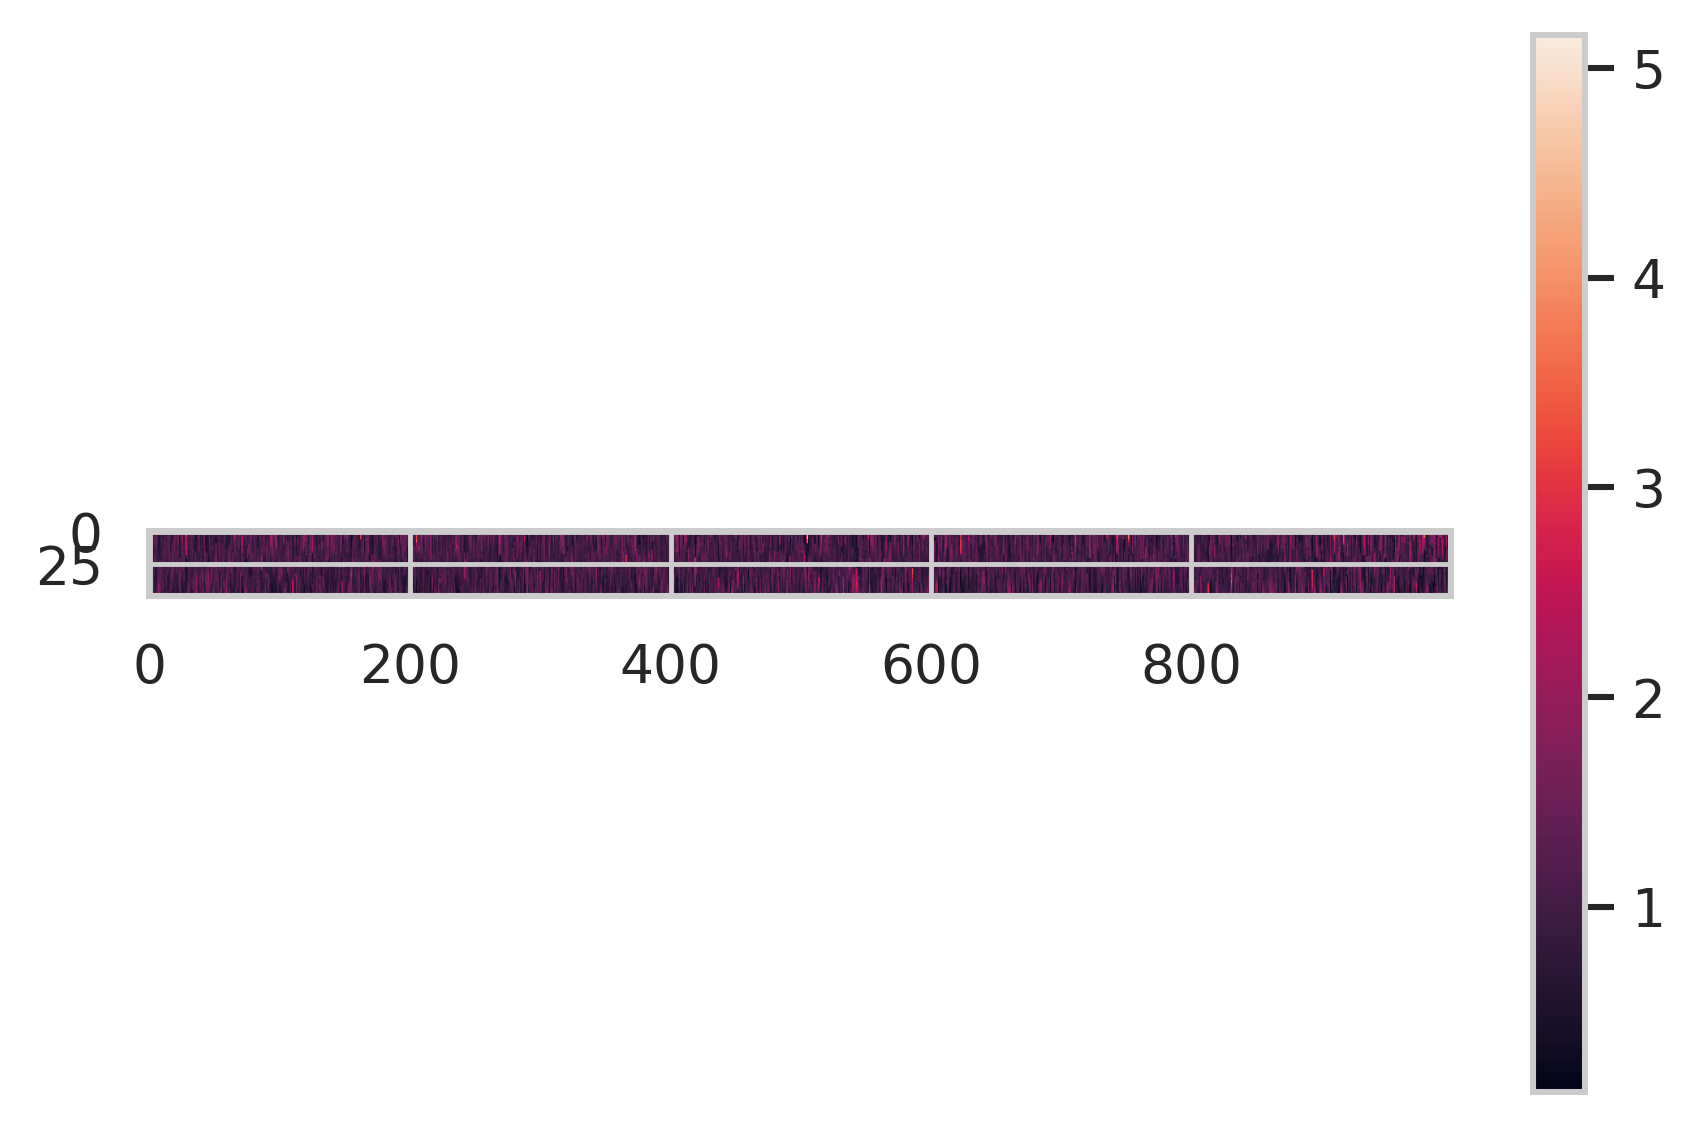

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid')
plt.figure(dpi=350)
plt.imshow(np.array(similarities[2000:3000]).T);
plt.colorbar()
plt.savefig('demo.png', transparent=True)

In [46]:
# import gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
epsilon=0.0

device='cuda'
# env = wrappers.make_env(DEFAULT_ENV_NAME)
# env.reset()
# env = gym.make(args.env)
#agent.env.reset()
# plt.figure(dpi=100)
tgt_net=net
weights=[]; y_pos=[]; rewards=[]

torch.save(net.state_dict(), 'net_cache')

old_net = DQN(env.observation_space.shape,
                            env.action_space.n).to('cuda')
for iteration in range(4000):
    clear_output(wait=True);
    time.sleep(0)

    agent.play_step(net, epsilon, device=device)
    
    BATCH_SIZE=10
    batch_ind = buffer.ordered_sample(len(buffer)-BATCH_SIZE,len(buffer))

    
    actions=batch_ind[1]; states=batch_ind[0]; reward=batch_ind[2][-1];

    states_v = torch.tensor(np.float32(np.array(
        states, copy=False))).to(device)

    output_old=net(states_v)
    old_q_vals=(output_old[range(0,len(actions)),actions]).detach().to('cpu').numpy()
    


    ratio=[]; delta=[]
    for gamma in range(0,NUM_GAMMAS-1):
        optimizer_aux=torch.optim.Adam(old_net.parameters(), lr=LEARNING_RATE)
        optimizer_aux.zero_grad();
        
        old_net.load_state_dict(net.state_dict()); 
        old_net.zero_grad()
            
        loss = calc_loss(batch_ind, old_net, net, device=device,individual=True)
        ind_loss=loss.mean(0)[gamma]
        ind_loss.backward(retain_graph=True)
        
       # with torch.no_grad():
       #      for p in old_net.parameters():
       #         new_value = p - LEARNING_RATE*p.grad
       #         p.copy_(new_value)
            
        optimizer_aux.step()

        output=old_net(states_v)
        
        new_q_vals=torch.max(output[range(0,len(actions)),0:env.action_space.n],1).values.detach().to('cpu').numpy()

        delta.append(np.array(new_q_vals)-np.array(old_q_vals))

        ratio.append(np.array((np.sum(delta[gamma])/BATCH_SIZE)))

    ratio=ratio-np.mean(ratio)
#   y_pos.append(np.mean((states_v[0][1]).detach.to('cpu').numpy()))
    weights.append(ratio)
    rewards.append(reward)
    
    plt.figure(dpi=250)
    plt.subplot(1,3,1)
    plt.plot(-2/np.log(GAMMAS[:-1]),np.array(ratio).flatten(),'k'); 
    plt.plot(-2/np.log(GAMMAS[:-1]),np.array(ratio).flatten(),'ko'); 
    plt.plot([-5,205],[0,0],color=[0.6,0.6,0.6]);  
   # plt.ylim([-4,20])
    plt.subplot(1,3,2)
    plt.title([np.mean(old_q_vals),np.mean(new_q_vals)])
    plt.imshow(np.sum(np.sum((states_v).detach().to('cpu').numpy(),0),0),vmax=1);
    if iteration>1:
        plt.subplot(1,3,3)
        plt.imshow(np.sum(np.sum((states_v).detach().to('cpu').numpy(),0),0)
                   -np.sum(np.sum((old_states).detach().to('cpu').numpy(),0),0),vmin=0.05); 
    old_states=states_v
    plt.show()
 #   agent.env.render()


    
    
env.close()


KeyboardInterrupt: 

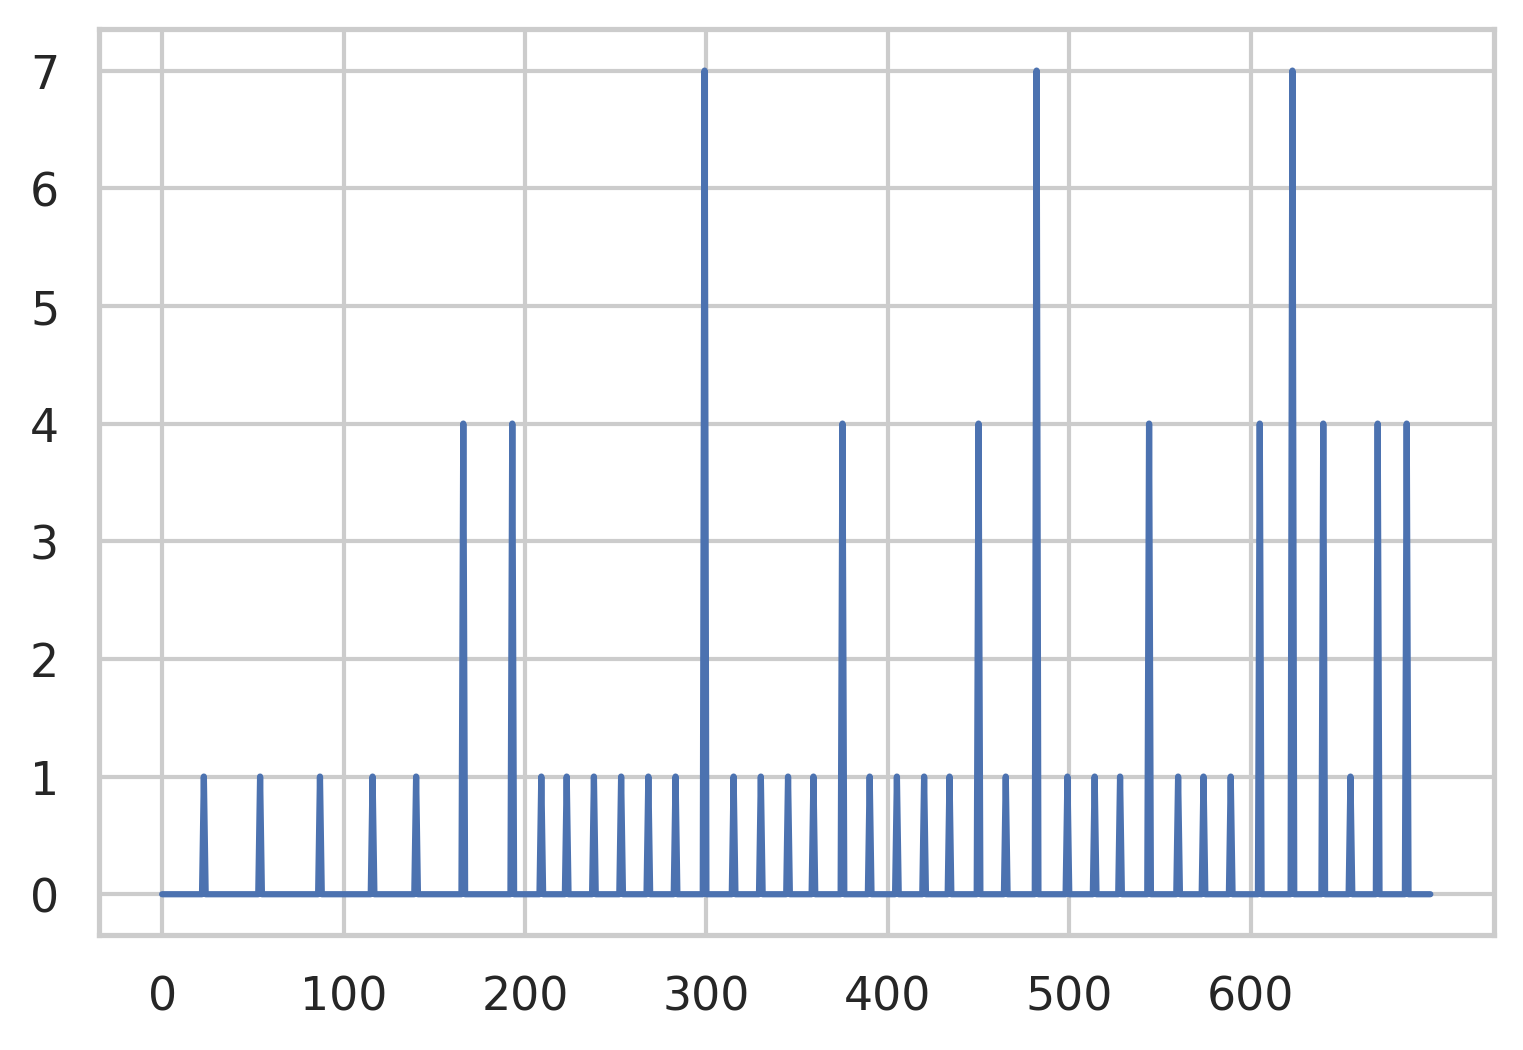

In [56]:
plt.figure(dpi=300);
s=rewards[0:700]
plt.plot(s);
plt.xticks(np.arange(0,len(s),100))
plt.grid(b=True)

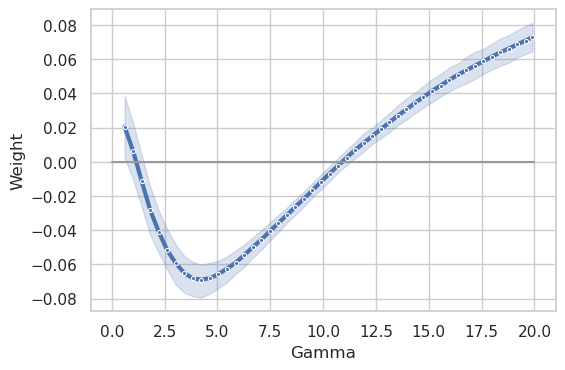

In [52]:
import seaborn as sns
import pandas as pd
s=rewards
sns.set_theme(style="whitegrid")
down=[weights[i] for i in range(5,len(rewards)-5) if np.sum(rewards[i-2:i+1])==0]
x_ax=[-0.2/np.log(GAMMAS[:-1]) for i in range(5,len(rewards)-5) if np.sum(rewards[i-2:i+1])==0]

# df=pd.DataFrame(np.array(down)).melt()
df= pd.DataFrame({"Weight" : np.array(down).flatten(),
                  "Gamma" : np.array(x_ax).flatten()})

plt.figure(dpi=100)
fig=sns.lineplot(x="Gamma", y="Weight", data=df,ci=95,linewidth=3,marker=".")

# plt.ylim([-1,1.05]);
plt.plot([0,20],[0,0],color=[0.6,0.6,0.6]);
#plt.plot(-2/np.log(GAMMAS),np.mean(np.array(down).T,1),'o',color='steelblue',markersize=4)
plt.savefig('demo.png', transparent=True)

In [149]:
np.sum([torch.dot(all_grads[0][i],all_grads[1][i]).to('cpu').numpy() 
        for i in range(0,len(all_grads[0]))])/norm[]

3.8507357

In [151]:
similarities.append([np.sum([torch.dot(all_grads[0][i],all_grads[gamma][i]).to('cpu').numpy() 
        for i in range(0,len(all_grads[0]))])/norm[gamma] for gamma in range(0,5)])

similarities

[[3.8507357, 3.9505668, 4.0460825, 4.154755],
 [3.8507357, 3.9505668, 4.0460825, 4.154755],
 [3.8507357, 3.9505668, 4.0460825, 4.154755],
 [3.8507357, 3.9505668, 4.0460825, 4.154755],
 [3.7534492, 3.8507357, 3.9505668, 4.0460825, 4.154755],
 [0.7645701, 0.68618065, 0.6480336, 0.63616157, 0.57887334],
 [0.7645701, 0.68618065, 0.6480336, 0.63616157, 0.57887334]]

In [33]:
import matplotlib.pyplot as plt
import cv2


frame=agent.state

img = np.reshape(frame, [250, 160, 3]).astype(
        np.float32)

img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + \
      img[:, :, 2] * 0.114
resized_screen = cv2.resize(
    img, (84, 110), interpolation=cv2.INTER_AREA)
x_t = resized_screen[18:102, :]
x_t = np.reshape(x_t, [84, 84, 1])
x_t.astype(np.uint8)


28224

save trained net:

In [3]:
import os
#torch.save(net, os.getcwd()+'/dqn_pong.pt')
#torch.save(net, os.getcwd()+'/dqn_pong_low_r.pt')
#torch.save(net, os.getcwd()+'/dqn_laplace_pong_low_r.pt')
#torch.save(net, os.getcwd()+'/dqn_mh_pong.pt')
#torch.save(net, os.getcwd()+'/dqn_mh_pong_low_r.pt')
#torch.save(net, os.getcwd()+'/dqn_laplace_pong.pt')
#torch.save(net, os.getcwd()+'/dqn_breakout.pt')
#torch.save(net, os.getcwd()+'/dqn_mh_breakout.pt')
#torch.save(net, os.getcwd()+'/dqn_breakout_2.pt')
#torch.save(net, os.getcwd()+'/dqn_laplace_breakout_2.pt')
#torch.save(net, os.getcwd()+'/dqn_mh_breakout_4.pt')
#torch.save(net, os.getcwd()+'/dqn_breakout_3.pt')
#np.savetxt('rewards_breakout_3.txt',total_rewards,fmt='%d')
#torch.save(net, os.getcwd()+'/dqn_breakout_4.pt')
np.savetxt('rewards_oh_50g_adaptive_breakout_2.txt',total_rewards,fmt='%d')
torch.save(net, os.getcwd()+'/dqn_oh_50g_adaptive_breakout_2.pt')
#torch.save(net, os.getcwd()+'/dqn_oh_50g_breakout.pt')
#np.savetxt('rewards_oh_50g_breakout.txt',total_rewards,fmt='%d')


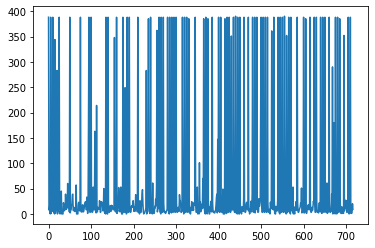

425.0

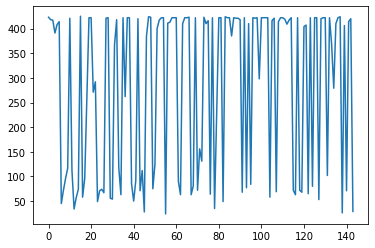

In [4]:
#b=np.loadtxt('rewards_oh_50g_breakout.txt',dtype=int)
b=total_rewards
import matplotlib.pyplot as plt
plt.plot(b); plt.show()
b_accum=[]
for i in range(0,len(b),5):
    b_accum.append(np.sum(b[i:i+5]))
    
plt.plot(range(0,len(b_accum)),b_accum)
max(b_accum)

### Classifier with multiple outputs:

In [2]:
#net_trained = torch.load(os.getcwd()+'/dqn_mh_pong.pt')
#net_trained = torch.load(os.getcwd()+'/dqn_pong.pt')
#net_trained=net

#device ='cuda'
#net.cuda()
#def get_conv_out(net, shape):
#    i = torch.zeros(1, *shape).to('cuda')
#    o = net(i)
#    return int(np.prod(o.size()))
    
#hidden = nn.Sequential(*list(net_trained.children())[:-2])
#hidden.cuda()
#for param in hidden.parameters():
#    param.requires_grad = False
    
#for param in net_trained.parameters():
#    param.requires_grad = False

#net.eval()
#for param in net.parameters():
#    param.requires_grad = False
    
    
    
#class Classifier(nn.Module):
#    
#    def __init__(self,input_shape,output_shape):
#        super(Classifier, self).__init__()
#        
#        self.fc = nn.Sequential(
#            nn.Linear(input_shape, 512),
#            nn.ReLU(),
#            nn.Linear(512, output_shape)
#        )
#
#    def forward(self, x):
#        return self.fc(x)
    
    
target_length=200


print('1')
iterations=100000
print('2')
test_size=10000
print('3')
states=np.array([buffer.buffer[start].state for start in range(0,len(buffer)-target_length)])
rewards=np.array([np.array([buffer.buffer[t].reward for t in np.arange(start,start+target_length)]) for start in range(0,len(buffer)-target_length)])
print('4')
#frame = torch.tensor(np.array(states[0:1,:,:,:], copy=False)).to(device)
#inputs_random=np.random.normal(size=(len(buffer),np.prod(np.shape(hidden(frame)))))

running_loss = 0.0
print('5')

#discounts = np.array([[[gamma**tau for tau in range(0,target_length)] for _ in range(0,BATCH_SIZE)] for gamma in GAMMAS])



1
2
3
4
5


In [4]:
criterion = nn.MSELoss()

class Classifier(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(Classifier, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, output_shape)
        )

      #  self.fc = nn.Sequential(
      #      nn.Linear(input_shape, output_shape),
      #  )

    def forward(self, x):
        return self.fc(x)
    
### def get_conv_out(net, shape):
#    i = torch.zeros(1, *shape).to('cuda')
#    o = net(i)
#    return int(np.prod(o.size()))
hidden = nn.Sequential(*list(net.children())[:-2]).to('cuda')

#classifier = Classifier(get_conv_out(hidden,env.observation_space.shape),target_length).to(device)

new_index=[index for index in range(1,len(rewards)-1) if np.prod(rewards[index,:]==0)==0] #indeces without all zero rewards

classifier = Classifier(3136,target_length).to(device) #frames:28224   conv:3136   output:num_actiosns*num_h*num_gammas
optimizer = optim.SGD(classifier.parameters(), lr=0.001,momentum=0.9)

train_index=np.random.choice(new_index, len(new_index)-test_size,replace=False)
test_index=list(set(new_index).symmetric_difference(set(train_index)))

#train_index=np.arange(len(rewards)-test_size)
#test_index=np.arange(len(rewards)-test_size,len(rewards))

for i in range(0,iterations):
    start=np.random.choice(train_index, BATCH_SIZE)
    indices = np.array([np.arange(start,start+target_length) for start in start])

    frame = torch.tensor(np.array(
        states[start,:,:,:], copy=False)).to(device)
    
  #  frame=(frame+frame_pre+frame_pos)/3
    
    with torch.no_grad():
      #  pre_input_classifier = torch.cat([net(frame),net(frame_pos)],1).to('cpu').numpy()
       # pre_input_classifier = frame.to('cpu').numpy()
        #conv_out = net.conv(frame).view(frame.size()[0], -1)
        #pre_input_classifier = torch.cat([net.layers[0][0:2](conv_out) for _ in range(0,NUM_GAMMAS)],1).to('cpu').numpy()
        pre_input_classifier = hidden(frame).to('cpu').numpy()
        input_classifier=torch.tensor([pre_input_classifier[i,:].flatten() for i in range(0,BATCH_SIZE)]).to(device)

    #    target_classifier=torch.tensor([np.dot(discounts[:,i,:],rewards[start,:]) for i in range(0,BATCH_SIZE)]).to(device)
        target_classifier=torch.tensor(rewards[start,:]).to(device)
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = classifier(input_classifier).to(device)
    loss = criterion(outputs, target_classifier.float())
    loss.backward()
    optimizer.step()
    

    # print statistics
    running_loss += loss.item()
    if i % 1000 == 999:    # print every 2000 mini-batches
        print('iteration: %5d,  training loss: %.3f' %
              (i + 1, running_loss / 1000))
        running_loss = 0.0

print('Finished Training')

iteration:  1000,  training loss: 1.419
iteration:  2000,  training loss: 1.355
iteration:  3000,  training loss: 1.348
iteration:  4000,  training loss: 1.342
iteration:  5000,  training loss: 1.333
iteration:  6000,  training loss: 1.344
iteration:  7000,  training loss: 1.313
iteration:  8000,  training loss: 1.313
iteration:  9000,  training loss: 1.308
iteration: 10000,  training loss: 1.324
iteration: 11000,  training loss: 1.310
iteration: 12000,  training loss: 1.298
iteration: 13000,  training loss: 1.304
iteration: 14000,  training loss: 1.286
iteration: 15000,  training loss: 1.286
iteration: 16000,  training loss: 1.288
iteration: 17000,  training loss: 1.289
iteration: 18000,  training loss: 1.264
iteration: 19000,  training loss: 1.293
iteration: 20000,  training loss: 1.266
iteration: 21000,  training loss: 1.266
iteration: 22000,  training loss: 1.270
iteration: 23000,  training loss: 1.267
iteration: 24000,  training loss: 1.267
iteration: 25000,  training loss: 1.269


TEST classifier:

In [5]:
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter

running_loss = 0.0
losses=[]


#discounts = np.array([[[gamma**tau for tau in range(0,target_length)] for _ in range(0,BATCH_SIZE)] for gamma in GAMMAS])
for i in range(0,20):
    print(i)
 #   start=np.random.choice(np.arange(len(rewards)-test_size,len(rewards)-target_length), 999)
    start=np.random.choice(test_index,999)

    frame = torch.tensor(np.array(
        states[start,:,:,:], copy=False)).to(device)
    
 #   
    with torch.no_grad():
      #  pre_input_classifier = torch.cat([net(frame_pre),net(frame),net(frame_pos)],1).to('cpu').numpy()
       # conv_out = net.conv(frame).view(frame.size()[0], -1)
       # pre_input_classifier = torch.cat([net.layers[0][0:2](conv_out) for _ in range(0,NUM_GAMMAS)],1).to('cpu').numpy()
        #pre_input_classifier = frame.to('cpu').numpy()
        pre_input_classifier = hidden(frame).to('cpu').numpy()
        input_classifier=torch.tensor([pre_input_classifier[i,:].flatten() for i in range(0,999)]).to(device)

    #    start=np.random.choice(len(rewards)-target_length, test_size)
    #    indices = np.array([np.arange(start,start+target_length) for start in start])

    #    target_classifier=torch.tensor([np.dot(discounts[:,i,:],rewards[indices[i,:]]) for i in range(0,BATCH_SIZE)]).to(device) 
        target_classifier=torch.tensor(rewards[start,:]).to(device)

    outputs = classifier(input_classifier).to(device)
 #   loss = criterion(outputs, target_classifier.float())

    loss=r2_score(savgol_filter(np.array(target_classifier.to('cpu').detach()),5,1),
                      savgol_filter(np.array(outputs.to('cpu').detach()),5,1))

    losses.append(loss.item())
    # print statistics
    running_loss += loss.item()
    if i % 1000 == 999:    # print every 2000 mini-batches
        print('iteration: %5d,  testing loss: %.3f' %
              (i + 1, running_loss / 1000))
        running_loss = 0.0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


0.18527051514841525

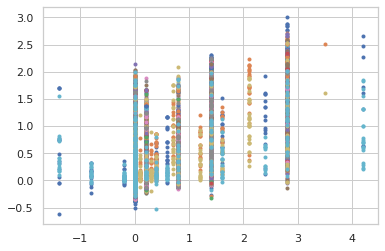

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
plt.figure(); 
plt.plot(savgol_filter(np.array(target_classifier.to('cpu').detach()),5,1),
                  savgol_filter(np.array(outputs.to('cpu').detach()),5,1),'.')
r2_score(np.array(target_classifier.to('cpu').detach()),np.array(outputs.to('cpu').detach()))

In [7]:
np.mean(losses)

0.540880336858984

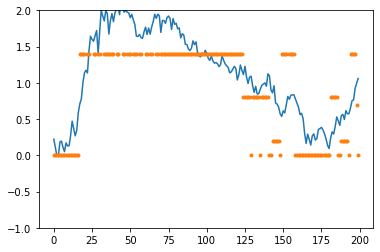

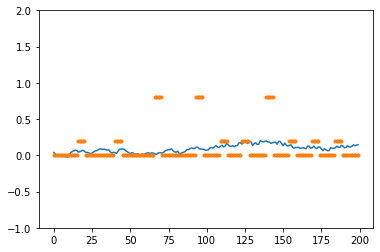

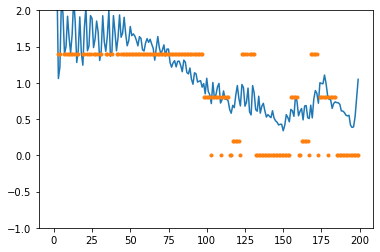

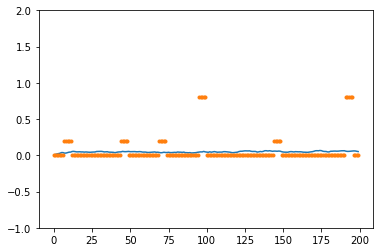

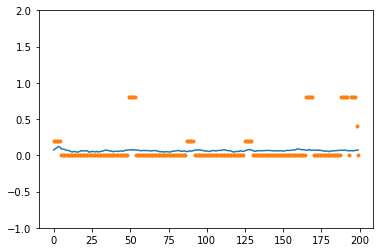

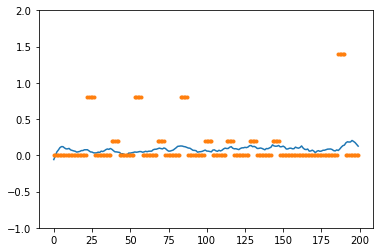

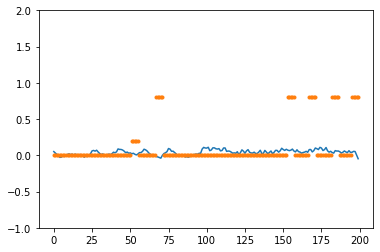

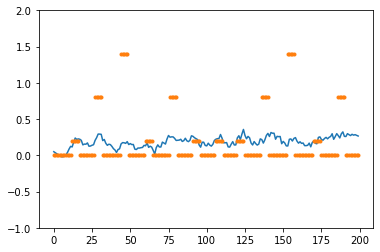

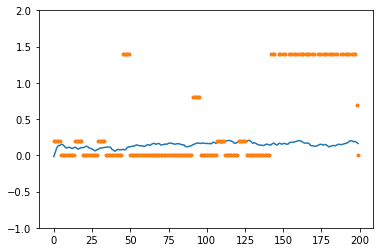

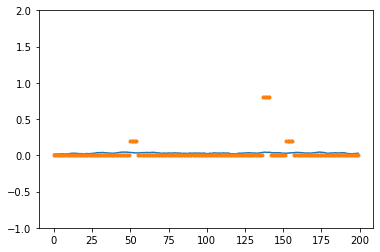

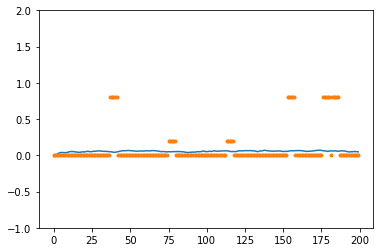

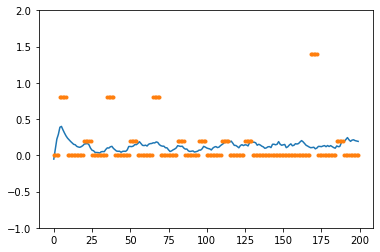

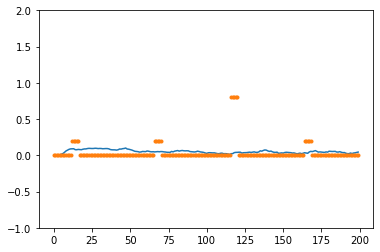

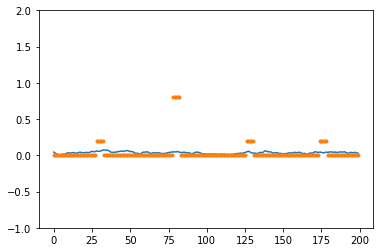

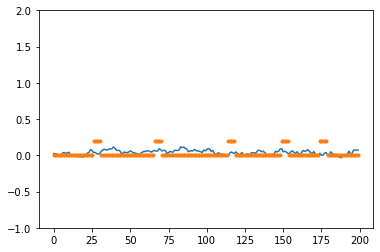

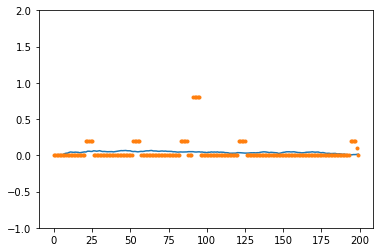

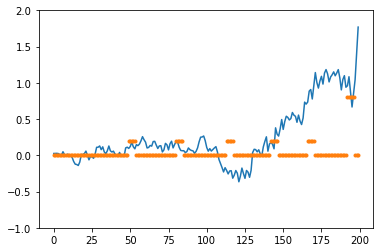

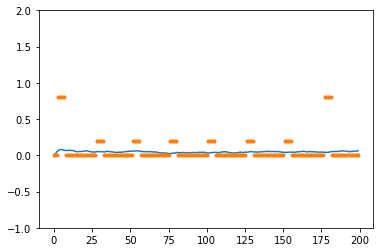

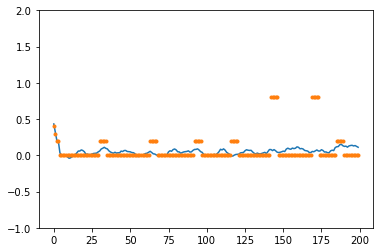

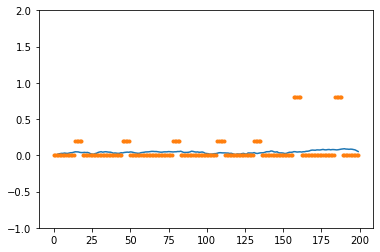

In [13]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
for i in range(0,20):
    plt.figure();
    plt.plot(range(0,200),savgol_filter(outputs[i,:].to('cpu').detach(),5,1))
    plt.plot(range(0,200),savgol_filter(target_classifier[i,:].to('cpu').detach(),5,1),'.')
    plt.ylim([-1,2])


### Train Classifier:

In [ ]:
import torch.optim as optim

BATCH_SIZE=30
device ='cuda'
net.cuda()
def get_conv_out(net, shape):
    i = torch.zeros(1, *shape).to('cuda')
    o = net(i)
    return int(np.prod(o.size()))
    
#net_trained = torch.load(os.getcwd()+'/dqn_pong.pt')
#net_trained = torch.load(os.getcwd()+'/dqn_pong.pt')

net_trained=net
hidden = nn.Sequential(*list(net_trained.children())[:-1])
hidden.cuda()
for param in hidden.parameters():
    param.requires_grad = False
    
for param in net_trained.parameters():
    param.requires_grad = False
    
class Classifier(nn.Module):
    
    def __init__(self,input_shape,output_shape):
        super(Classifier, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, output_shape)
        )

    def forward(self, x):
        return self.fc(x)


target_length=300
classifier = Classifier(get_conv_out(hidden,env.observation_space.shape),1).to(device)
for param in classifier.parameters():
    param.requires_grad = True

criterion = nn.MSELoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
iterations=100000

test_size=5000
batch = buffer.ordered_sample(0,len(buffer)-test_size)
states, actions, rewards, dones, next_states = batch

frame = torch.tensor(np.array(states[0:1,:,:,:], copy=False)).to(device)
#inputs_random=np.random.normal(size=(len(buffer),np.prod(np.shape(hidden(frame)))))

running_loss = 0.0

gamma=0.99
discounts = np.array([[gamma**tau for tau in range(0,target_length)] for _ in range(0,BATCH_SIZE)])
    
for i in range(0,iterations):
    start=np.random.choice(len(rewards)-target_length, BATCH_SIZE)
    indices = np.array([np.arange(start,start+target_length) for start in start])

    frame = torch.tensor(np.array(
        states[start,:,:,:], copy=False)).to(device)

    
    pre_input_classifier = hidden(frame).to('cpu').numpy()

    input_classifier=torch.tensor([pre_input_classifier[i,:,:,:].flatten() for i in range(0,BATCH_SIZE)]).to(device)
    
#    input_classifier = torch.tensor(inputs_random[start,:]).to(device).float()

    target_classifier=torch.tensor([np.dot(discounts[i,:],rewards[indices[i,:]]) for i in range(0,BATCH_SIZE)]).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = classifier(input_classifier).to(device)
    loss = criterion(outputs.flatten(), target_classifier)
    loss.backward()
    optimizer.step()
    

    # print statistics
    running_loss += loss.item()
    if i % 1000 == 999:    # print every 2000 mini-batches
        print('iteration: %5d,  training loss: %.3f' %
              (i + 1, running_loss / 1000))
        running_loss = 0.0

print('Finished Training')

Test classifier:

In [ ]:
from sklearn.metrics import r2_score
batch = buffer.ordered_sample(len(buffer)-test_size,len(buffer))
states, actions, rewards, dones, next_states = batch
running_loss = 0.0
losses=[]
BATCH_SIZE=5000
gamma=0.99
discounts = np.array([[gamma**tau for tau in range(0,target_length)] for _ in range(0,BATCH_SIZE)])
for i in range(0,5):
    start=np.random.choice(len(rewards)-target_length, BATCH_SIZE)
    indices = np.array([np.arange(start,start+target_length) for start in start])

    frame = torch.tensor(np.array(
        states[start,:,:,:], copy=False)).to(device)

    
    pre_input_classifier = hidden(frame).to('cpu').numpy()

    input_classifier=torch.tensor([pre_input_classifier[i,:,:,:].flatten() for i in range(0,BATCH_SIZE)]).to(device)
    
#    start=np.random.choice(len(rewards)-target_length, BATCH_SIZE)
#    indices = np.array([np.arange(start,start+target_length) for start in start])
    target_classifier=torch.tensor([np.dot(discounts[i,:],rewards[indices[i,:]]) for i in range(0,BATCH_SIZE)]).to(device)

    outputs = classifier(input_classifier).to(device)
    loss = criterion(outputs.flatten(), target_classifier)
    
    loss=r2_score(np.array(target_classifier.to('cpu').detach()),np.array(outputs.to('cpu').detach()))

    losses.append(loss.item())
    # print statistics
    running_loss += loss.item()
    if i % 1000 == 999:    # print every 2000 mini-batches
        print('iteration: %5d,  testing loss: %.3f' %
              (i + 1, running_loss / 1000))
        running_loss = 0.0

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
plt.figure(); 
plt.plot(np.array(target_classifier.to('cpu').detach()),np.array(outputs.to('cpu').detach()),'.')
r2_score(np.array(target_classifier.to('cpu').detach()),np.array(outputs.to('cpu').detach()))

In [ ]:
np.mean(losses)

In [ ]:
actions_all=np.array([buffer.buffer[start].action for start in range(0,len(buffer)-target_length)])


actions=actions_all[start]

actions_v0 = torch.tensor(actions).to(device)
output=net(frame)
output=output.reshape(BATCH_SIZE,NUM_GAMMAS*NUM_H,env.action_space.n)
state_action_values=output[range(0,BATCH_SIZE),:,actions_v0]


fh1=[]; fh2=[]; gammas=[];
for i in range(0,NUM_H):
    for n in np.arange(1,NUM_GAMMAS): #for the first gamma (position 0) I keep the actual rewards
        if i==0:
            print(n*NUM_H+i)
        else:
            if i==1:
                fh1.append(np.array(state_action_values[:,n*NUM_H+i].to('cpu').detach()))
                gammas.append(GAMMAS[n*NUM_H+i])
            elif i==2:
                fh2.append(np.array(state_action_values[:,n*NUM_H+i].to('cpu').detach()))

fh1=np.array(fh1); fh2=np.array(fh2)


for i in [1]:
    plt.figure();
    plt.plot(gammas,fh2[:,i])
    plt.plot(gammas,fh2[:,i],'.')
    plt.ylim([-0.1,2.1])
    plt.grid()


### multiple gammas

In [ ]:
#!/usr/bin/env python3
%matplotlib qt
import sys  
sys.path.insert(0, '/home/pablotano/Desktop/DeepRL/lib')
import wrappers


import argparse
import time
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

DEFAULT_ENV_NAME = "PongNoFrameskip-v4"
MEAN_REWARD_BOUND = 19
FRAME_BOUND = 450000

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

EPSILON_DECAY_LAST_FRAME = 150000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01


NUM_GAMMAS=5
# GAMMAS=0.99
GAMMAS=np.linspace(0.95,0.99,NUM_GAMMAS); GAMMAS=np.flip(GAMMAS)
NUM_H=1

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        
        self.layers = nn.ModuleList()
        for _ in range(NUM_GAMMAS*NUM_H):
            self.layers.append(nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)))
          
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)

        out = torch.cat([net(conv_out) for net in self.layers],1)
                 
        return out
    

Experience = collections.namedtuple(
    'Experience', field_names=['state', 'action', 'reward',
                               'done', 'new_state'])


class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size,
                                   replace=False)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)


class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v.narrow(-1,0,env.action_space.n), dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward,
                         is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward


def calc_loss(batch, net, tgt_net, device="cpu"):
    
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(np.array(
        states, copy=False)).to(device)
    next_states_v = torch.tensor(np.array(
        next_states, copy=False)).to(device)

    actions_v0 = torch.tensor(actions).to(device)
    output=net(states_v)
    state_action_values=output.gather(
            1, actions_v0.unsqueeze(-1)).squeeze(-1)
    for i in range(1,NUM_GAMMAS*NUM_H):
        actions_v=actions_v0+i*env.action_space.n
        state_action_values=torch.cat((state_action_values,output.gather(
            1, actions_v.unsqueeze(-1)).squeeze(-1)),0)


    rewards_v0 = torch.tensor(rewards).to(device)
    done_mask0 = torch.BoolTensor(dones).to(device)
    done_mask=done_mask0
    rewards_v=rewards_v0
    gammas=GAMMAS[0]+0*rewards_v0
#     gammas=GAMMAS+0*rewards_v0

    with torch.no_grad():
        output_next=tgt_net(next_states_v)

        next_state_values = output_next.narrow(-1,0,env.action_space.n).max(1)[0]
        for i in range(1,NUM_GAMMAS*NUM_H):
            next_state_values = torch.cat((next_state_values,output_next.narrow(-1,i*env.action_space.n,env.action_space.n).max(1)[0]),0)
            done_mask=torch.cat((done_mask,done_mask0),0)
            rewards_v=torch.cat((rewards_v,rewards_v0),0)
            gammas=torch.cat((gammas,GAMMAS[i]+0*rewards_v0),0)

        next_state_values[done_mask] = 0.0
        next_state_values = next_state_values.detach()

    expected_state_action_values=next_state_values * gammas + \
                                   rewards_v


    return nn.MSELoss()(state_action_values,
                        expected_state_action_values)


if __name__ == "__main__":

    parser = argparse.ArgumentParser()
    parser.add_argument("--cuda", default=False,
                        action="store_true", help="Enable cuda")
    parser.add_argument("--env", default=DEFAULT_ENV_NAME,
                        help="Name of the environment, default=" +
                             DEFAULT_ENV_NAME)
    args,unknown = parser.parse_known_args()
#     device = torch.device("cuda" if args.cuda else "cpu")
    device = torch.device("cuda")
    env = wrappers.make_env(args.env)

    net = DQN(env.observation_space.shape,
                        env.action_space.n).to(device)
    tgt_net = DQN(env.observation_space.shape,
                            env.action_space.n).to(device)
    writer = SummaryWriter(comment="-" + args.env)
    print(net)

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    epsilon = EPSILON_START

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    total_rewards = []
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_m_reward = None


  #  fig=plt.figure()
# plt.plot(total_rewards); plt.show(); plt.ion()
    while True:
        frame_idx += 1
        epsilon = max(EPSILON_FINAL, EPSILON_START -
                      frame_idx / EPSILON_DECAY_LAST_FRAME)

        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            m_reward = np.mean(total_rewards[-100:])
            print("%d: done %d games, reward %.3f, "
                  "eps %.2f, speed %.2f f/s" % (
                frame_idx, len(total_rewards), m_reward, epsilon,
                speed
            ))
        #    plt.plot(total_rewards,color='tab:blue');plt.pause(0.0000000000000000001); plt.grid(b=True)
            writer.add_scalar("epsilon", epsilon, frame_idx)
            writer.add_scalar("speed", speed, frame_idx)
            writer.add_scalar("reward_100", m_reward, frame_idx)
            writer.add_scalar("reward", reward, frame_idx)
            if best_m_reward is None or best_m_reward < m_reward:
                torch.save(net.state_dict(), args.env +
                           "-best_%.0f.dat" % m_reward)
                if best_m_reward is not None:
                    print("Best reward updated %.3f -> %.3f" % (
                        best_m_reward, m_reward))
                best_m_reward = m_reward
            if ts_frame > FRAME_BOUND:
                print("Frame limit" % frame_idx)
                break

        if len(buffer) < REPLAY_START_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t = calc_loss(batch, net, tgt_net, device=device)
        loss_t.backward()
        optimizer.step()
    writer.close()

### ONE HEAD

In [ ]:
#!/usr/bin/env python3

import sys  
sys.path.insert(0, '/home/pablotano/Desktop/DeepRL/lib')
import wrappers

import argparse
import time
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim

from tensorboardX import SummaryWriter



DEFAULT_ENV_NAME = "BreakoutNoFrameskip-v4"
MEAN_REWARD_BOUND = 19
FRAME_BOUND = 450000

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 200000
LEARNING_RATE = 0.00001
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 200000

EPSILON_DECAY_LAST_FRAME = 300000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01


NUM_GAMMAS=1
taus=np.linspace(0.01,100,NUM_GAMMAS)
GAMMAS=np.exp(-1/taus)
GAMMAS[-1]=0.99

GAMMAS=np.flip(GAMMAS)
NUM_H=1

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, NUM_GAMMAS*NUM_H*n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)
    
#         self.layers = nn.ModuleList()
#         for _ in range(NUM_GAMMAS*NUM_H):
#             self.layers.append(nn.Sequential(
#             nn.Linear(conv_out_size, 512),
#             nn.ReLU(),
#             nn.Linear(512, n_actions)))
          
#     def _get_conv_out(self, shape):
#         o = self.conv(torch.zeros(1, *shape))
#         return int(np.prod(o.size()))

#     def forward(self, x):
#         conv_out = self.conv(x).view(x.size()[0], -1)

#         out = torch.cat([net(conv_out) for net in self.layers],1)
                 
#        return out

    
Experience = collections.namedtuple(
    'Experience', field_names=['state', 'action', 'reward',
                               'done', 'new_state'])


class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size,
                                   replace=False)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)


class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v.narrow(-1,0,env.action_space.n), dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward,
                         is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward


def calc_loss(batch, net, tgt_net, device="cpu"):
    
    states, actions, rewards, dones, next_states = batch


    states_v = torch.tensor(np.array(
        states, copy=False)).to(device)
    next_states_v = torch.tensor(np.array(
        next_states, copy=False)).to(device)

    actions_v0 = torch.tensor(actions).to(device)
    output=net(states_v)
    output=output.reshape(BATCH_SIZE,NUM_GAMMAS*NUM_H,env.action_space.n)
    state_action_values=output[range(0,BATCH_SIZE),:,actions_v0]

    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)

    rewards_v=rewards_v.repeat(NUM_GAMMAS*NUM_H,1).T
    done_mask=done_mask.repeat(NUM_GAMMAS*NUM_H,1).T
    rewards_v[done_mask] = -1
    
    gammas=np.tile(GAMMAS,(BATCH_SIZE,1))
    gammas=np.float32(gammas)
    gammas=torch.tensor(gammas).to(device)


    with torch.no_grad():
        output_next=tgt_net(next_states_v)
        output_next=output_next.reshape(BATCH_SIZE,NUM_GAMMAS*NUM_H,env.action_space.n)
        np.shape(output_next)

        best_action=torch.argmax(output_next[:,0,:],dim=-1)

        next_state_values=output_next[range(0,BATCH_SIZE),:,best_action]

        next_state_values[done_mask] = 0.0
        next_state_values = next_state_values.detach()


    expected_state_action_values=next_state_values * gammas + \
                                   rewards_v

    return nn.SmoothL1Loss()(state_action_values,
                        expected_state_action_values)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--cuda", default=False,
                        action="store_true", help="Enable cuda")
    parser.add_argument("--env", default=DEFAULT_ENV_NAME,
                        help="Name of the environment, default=" +
                             DEFAULT_ENV_NAME)
    args,unknown = parser.parse_known_args()
#     device = torch.device("cuda" if args.cuda else "cpu")
    device = torch.device("cuda")

    env = wrappers.make_env(args.env)

    net = DQN(env.observation_space.shape,
                        env.action_space.n).to(device)
    tgt_net = DQN(env.observation_space.shape,
                            env.action_space.n).to(device)
    
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.kaiming_normal_(m.weight)

    net.apply(init_weights)
    
    writer = SummaryWriter(comment="-" + args.env)
    
    print(net)

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    epsilon = EPSILON_START

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    total_rewards = []
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_m_reward = None

    while True:
        frame_idx += 1
        epsilon = max(EPSILON_FINAL, EPSILON_START -
                      frame_idx / EPSILON_DECAY_LAST_FRAME)

        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            m_reward = np.mean(total_rewards[-100:])
            print("%d: done %d games, reward %.3f, "
                  "eps %.2f, speed %.2f f/s" % (
                frame_idx, len(total_rewards), m_reward, epsilon,
                speed
            ))
            writer.add_scalar("epsilon", epsilon, frame_idx)
            writer.add_scalar("speed", speed, frame_idx)
            writer.add_scalar("reward_100", m_reward, frame_idx)
            writer.add_scalar("reward", reward, frame_idx)
            if best_m_reward is None or best_m_reward < m_reward:
                torch.save(net.state_dict(), args.env +
                           "-best_%.0f.dat" % m_reward)
                if best_m_reward is not None:
                    print("Best reward updated %.3f -> %.3f" % (
                        best_m_reward, m_reward))
                best_m_reward = m_reward
    #        if m_reward > MEAN_REWARD_BOUND:
     #           print("Done in " % frame_idx)
      #          break

        if len(buffer) < REPLAY_START_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t = calc_loss(batch, net, tgt_net, device=device)
        loss_t.backward()
        optimizer.step()
    writer.close()

# DDPG Bipedal Walker

In [172]:

import gym
import random
import collections
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

env = gym.make('BipedalWalker-v2')

#Hyperparameters
lr_mu        = 0.0005
lr_q         = 0.001
gamma        = 0.99
batch_size   = 32
buffer_limit = 50000
tau          = 0.005 # for target network soft update

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])
        
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

class MuNet(nn.Module):
    def __init__(self):
        super(MuNet, self).__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, env.action_space.shape[0])

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = torch.tanh(self.fc_mu(x)) # Multipled by 2 because the action space of the Pendulum-v0 is [-2,2]
        return mu

class QNet(nn.Module):
    def __init__(self):
        super(QNet, self).__init__()
        
        self.fc_s = nn.Linear(env.observation_space.shape[0], 64)
        self.fc_a = nn.Linear(env.action_space.shape[0],64)
        self.fc_q = nn.Linear(128, 32)
        self.fc_3 = nn.Linear(32,1)

    def forward(self, x, a):
        h1 = F.relu(self.fc_s(x))
        h2 = F.relu(self.fc_a(a))
        cat = torch.cat([h1,h2], dim=1)
        q = F.relu(self.fc_q(cat))
        q = self.fc_3(q)
        return q

class OrnsteinUhlenbeckNoise:
    def __init__(self, mu):
        self.theta, self.dt, self.sigma = 0.1, 0.01, 0.1
        self.mu = mu
        self.x_prev = np.zeros_like(self.mu)

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x
      
def train(mu, mu_target, q, q_target, memory, q_optimizer, mu_optimizer):
    
    s,a,r,s_prime,done_mask  = memory.sample(batch_size)
    s=s.float(); a=a.float(); s_prime=s_prime.float(); done_mask=done_mask.float(); r=r.float()
    
    
    target = r + gamma * q_target(s_prime.to('cuda'),
                                  mu_target(s_prime.to('cuda')))
    q_loss = F.smooth_l1_loss(q(s.to('cuda'),a.to('cuda')), target.detach().to('cuda'))
    q_optimizer.zero_grad()
    q_loss.backward()
    q_optimizer.step()
    
    
    mu_loss = -q(s.to('cuda'),mu(s.to('cuda'))).mean() # That's all for the policy loss.
    mu_optimizer.zero_grad()
    mu_loss.backward()
    mu_optimizer.step()
    
def soft_update(net, net_target):
    for param_target, param in zip(net_target.parameters(), net.parameters()):
        param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)
          
    


memory = ReplayBuffer()

q, q_target = QNet().to('cuda'), QNet().to('cuda')
q_target.load_state_dict(q.state_dict())

mu, mu_target = MuNet().to('cuda'), MuNet().to('cuda')
mu_target.load_state_dict(mu.state_dict())


score = 0.0
print_interval = 10
min_play_reward = 100
iterations = 100000

mu_optimizer = optim.Adam(mu.parameters(), lr=lr_mu)
q_optimizer  = optim.Adam(q.parameters(), lr=lr_q)
ou_noise = OrnsteinUhlenbeckNoise(mu=np.zeros(env.action_space.shape[0]))


def play_game():
    done = False
    state = env.reset()    
    while(not done):        
        a = mu(torch.from_numpy(s).float()) 
        a = a.item() + ou_noise()[0]
        s_prime, r, done, info = env.step([a])
        env.render()
        state = s_prime   



frame_idx, ts_frame, ts, total_rewards, total_games = 0, 0, 0, [], 0
for iteration in range(iterations):
    
    s = env.reset()        
    for t in range(1000): # maximum length of episode is 200 for Pendulum-v0
        a = mu(torch.from_numpy(s).float().to('cuda')) 
#         a = a.item() + ou_noise()[0]
        a = torch.tensor([t.item() for t in a]) + ou_noise()
        s_prime, r, done, info = env.step(a)
        memory.put((s,np.array(a),r,s_prime,done))
        score +=r
        s = s_prime
        frame_idx+=1
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        total_rewards.append(r)
        
        if done:
            if score/print_interval > min_play_reward:
                play_game()
            break              
                
    if memory.size()>2000:
        for i in range(10):
            train(mu, mu_target, q, q_target, memory, q_optimizer, mu_optimizer)
            soft_update(mu, mu_target.to('cuda'))
            soft_update(q,  q_target.to('cuda'))
           # q_target.to('cpu'); mu_target.to('cpu')
        
    if iteration%print_interval==0 and iteration!=0:
        print("%d: done %d games, reward %.3f, "
              "eps %.2f, speed %.2f f/s" % (
            frame_idx, iteration, score/print_interval, np.mean(np.abs(ou_noise())),
            speed
        ))

        score = 0.0

env.close()



TypeError: add(): argument 'other' (position 1) must be Tensor, not numpy.ndarray

In [125]:
mu_target(s_prime.to('cuda'))

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [173]:
import gym
import numpy as np
import copy
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

BUFFER_SIZE = 1000000      # replay buffer size
BATCH_SIZE = 100           # minibatch size
GAMMA = 0.99               # discount factor
TAU = 0.001                # for soft update of target parameters
LR_ACTOR = 0.0001          # learning rate of the actor
LR_CRITIC = 0.001          # learning rate of the critic
WEIGHT_DECAY = 0.001       # L2 weight decay

device = 'cuda'

class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc_units=600, fc1_units=300):

        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc1_units)
        self.fc3 = nn.Linear(fc1_units, action_size)

        self.bn1 = nn.BatchNorm1d(fc_units)
        self.bn2 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):

        self.fc2.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu((self.bn1(self.fc1(state))))
        x = F.relu((self.bn2(self.fc2(x))))
        return F.torch.tanh(self.fc3(x))


class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=600, fcs2_units=300, fca1_units=300):

        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fcs2 = nn.Linear(fcs1_units, fcs2_units)
        self.fca1 = nn.Linear(action_size, fca1_units)
        self.fc1 = nn.Linear(fcs2_units, 1)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.reset_parameters()

    def reset_parameters(self):

        self.fcs2.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc1.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu((self.bn1(self.fcs1(state))))
        xs = self.fcs2(xs)
        xa = self.fca1(action)
        x = F.relu(torch.add(xs, xa))
        return self.fc1(x)
    
    

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return action

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.4, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    
env = gym.make('BipedalWalker-v3')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = Agent(state_size=state_dim, action_size=action_dim, random_seed=0)



scores_deque = deque(maxlen=100)
episodes, step, noise = 10000 ,2000, True
reward_list = []

for i in range(episodes):

    state = env.reset()
    score = 0

    for t in range(step):

       # env.render()

        action = agent.act(state)
        next_state, reward, done, info = env.step(action[0])
        agent.step(state, action, reward, next_state, done)
        state = next_state.squeeze()
        score += reward

        if done:
           # print('Reward: {} | Episode: {}/{}'.format(score, i, episodes))
            break

    reward_list.append(score)
    scores_deque.append(score)
    print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(len(reward_list), np.mean(scores_deque), score), end="")
    if len(reward_list) % 100 == 0:
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(len(reward_list), np.mean(scores_deque)))  
        
    if score >= 270:
        print('Task Solved')
        break

torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
torch.save(agent.actor_target.state_dict(), 'checkpoint_actor_t.pth')
torch.save(agent.critic_target.state_dict(), 'checkpoint_critic_t.pth')

print('Training saved')




fig = plt.figure()
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

DeprecatedEnv: Env BipedalWalker-v3 not found (valid versions include ['BipedalWalker-v2'])

In [21]:
for i in range(1):

    state = env.reset()
    score = 0

    for t in range(300):

        env.render()

        action = agent.act(state,add_noise=False)
        next_state, reward, done, info = env.step(action[0])
        agent.step(state, action, reward, next_state, done)
        state = next_state.squeeze()

In [156]:
len(agent.memory)

23352

In [7]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import numpy as np
import random
import copy
from collections import namedtuple, deque


import torch.nn.functional as F
import torch.optim as optim

import torch.nn as nn

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
          # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0001   # L2 weight decay

NUM_GAMMAS=50
taus=np.linspace(0.01,50,NUM_GAMMAS)
GAMMAS=np.exp(-1/taus)
GAMMAS[-1]=0.99

GAMMAS=np.flip(GAMMAS)

GAMMAS=torch.tensor([GAMMAS for _ in range(BATCH_SIZE)]).float().to('cuda')
device = torch.device("cuda:0")

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        return torch.tanh(self.fc2(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256, fc3_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, NUM_GAMMAS)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)

    
    
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMAS)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).T[0].mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    
gym.logger.set_level(40)
env = gym.make('BipedalWalker-v3')

env.seed(10)
agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0], random_seed=10)


n_episodes=3000
max_t=700

scores_deque = deque(maxlen=100)
scores = []
max_score = -np.Inf
for i_episode in range(1, n_episodes+1):
    state = env.reset()
    agent.reset()
    score = 0
    for t in range(max_t):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break 
    scores_deque.append(score)
    scores.append(score)
    print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
    if i_episode % 100 == 0:
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   


scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: -95.39	Score: -99.271
Episode 200	Average Score: -100.16	Score: -99.126
Episode 300	Average Score: -100.14	Score: -114.25
Episode 400	Average Score: -101.50	Score: -99.479
Episode 500	Average Score: -100.36	Score: -99.702
Episode 588	Average Score: -100.06	Score: -106.85

KeyboardInterrupt: 

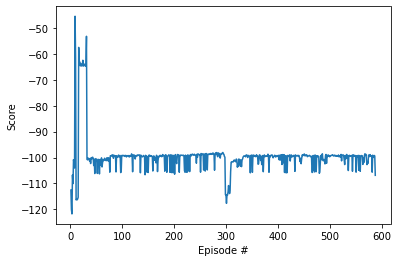

In [8]:
fig = plt.figure()
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [6]:

agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

state = env.reset()
for _ in range(10):
    agent.reset()   
    while True:
        action = agent.act(state)
        env.render()
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if done:
            break

    env.close()

In [1]:
import torch
import gym
import numpy as np
from collections import deque
import pickle
import matplotlib.pyplot as plt
import mujoco_py

import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim


######### Hyperparameters #########
gym.logger.set_level(40)
env_name = "HalfCheetah-v2"
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

log_interval = 100  # print avg reward after interval
random_seed = 0
batch_size = 100  # num of transitions sampled from replay buffer
lr = 0.001
exploration_noise = 0.1
polyak = 0.995  # target policy update parameter (1-tau)
policy_noise = 0.2  # target policy smoothing noise
noise_clip = 0.5
policy_delay = 2  # delayed policy updates parameter
max_episodes = 2000  # max num of episodes
max_timesteps = 2000  # max timesteps in one episode
directory = "./preTrained/"  # save trained models
filename = "TD3_{}_{}".format(env_name, random_seed)

NUM_GAMMAS=1
taus=np.linspace(5,100,NUM_GAMMAS)
GAMMAS=np.exp(-1/taus)
GAMMAS[-1]=0.99

GAMMAS=np.flip(GAMMAS)

GAMMAS=torch.tensor([GAMMAS for _ in range(batch_size)]).float().to('cuda')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

d=np.ones(NUM_GAMMAS)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)

        self.max_action = max_action

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = torch.tanh(self.l3(a)) * self.max_action
        return a


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, 750)
        self.l2 = nn.Linear(750, 750)
        self.l3 = nn.Linear(750, NUM_GAMMAS)

    def forward(self, state, action):
        state_action = torch.cat([state, action], 1)

        q = F.relu(self.l1(state_action))
        q = F.relu(self.l2(q))
        q = self.l3(q)
        return q
    




class TD3:
    def __init__(self, lr, state_dim, action_dim, max_action):
        
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        
        self.critic_1 = Critic(state_dim, action_dim).to(device)
        self.critic_1_target = Critic(state_dim, action_dim).to(device)
        self.critic_1_target.load_state_dict(self.critic_1.state_dict())
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters(), lr=lr)
        
        self.critic_2 = Critic(state_dim, action_dim).to(device)
        self.critic_2_target = Critic(state_dim, action_dim).to(device)
        self.critic_2_target.load_state_dict(self.critic_2.state_dict())
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters(), lr=lr)
        
        self.max_action = max_action
    
    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()
    
    def update(self, replay_buffer, n_iter, batch_size, gamma, polyak, policy_noise, 
               noise_clip, policy_delay, Individual=False, weights=None):
        
        if Individual==True:
            dif=[]; dif2=[]
            for _ in range(20):
                state, action_, reward, next_state, done = replay_buffer.sample(1)
                state = torch.FloatTensor(state).to(device).detach()
                action = torch.FloatTensor(action_).to(device).detach()
                reward = torch.FloatTensor(reward).reshape((1,1)).to(device)
                next_state = torch.FloatTensor(next_state).to(device)
                done = torch.FloatTensor(done).reshape((1,1)).to(device)
                noise = torch.FloatTensor(action_).data.normal_(0, policy_noise).to(device)
                noise = noise.clamp(-noise_clip, noise_clip)
                next_action = (policy.actor_target(next_state) + noise)
                next_action = next_action.clamp(-self.max_action, self.max_action)

                d=[]; d2=[]
                for g in range(NUM_GAMMAS):
                    self.old_critic = Critic(state_dim, action_dim).to(device).to('cpu')
                    self.old_critic.load_state_dict(self.critic_1.state_dict())
                    self.old_critic.to('cuda')

                    old_actor_loss=self.old_critic(state, self.actor(state)).T[0].mean().detach()
                    old_q_vals=self.old_critic(state, action).T[0].mean().detach()

                    target_Q1 = self.critic_1(next_state, next_action)
                    target_Q2 = self.critic_2(next_state, next_action)
                    target_Q = torch.min(target_Q1, target_Q2)
                    target_Q = reward + ((1-done) * gamma[0] * target_Q).detach()

                    current_Q1 = self.old_critic(state, action)
                    ind_losses = nn.MSELoss(reduction='none')(current_Q1,target_Q)
                    ind_loss=ind_losses.mean(0)[g]

                    self.opt_aux=optim.Adam(self.old_critic.parameters(), lr=lr)
                    self.opt_aux.zero_grad()
                    ind_loss.backward()
                    self.opt_aux.step()

                    new_actor_loss=self.old_critic(state, self.actor(state)).T[0].mean().detach()
                    new_q_vals=self.old_critic(state, action).T[0].mean().detach()

                    d.append((new_actor_loss-old_actor_loss).detach().to('cpu').numpy())
                    d2.append((new_q_vals-old_q_vals).detach().to('cpu').numpy())
                dif.append(d)
                dif2.append(d2)
            return np.mean(dif,0), np.mean(dif2,0)
        else:
            
            for i in range(n_iter):
                # Sample a batch of transitions from replay buffer:
                state, action_, reward, next_state, done = replay_buffer.sample(batch_size)
                state = torch.FloatTensor(state).to(device)
                action = torch.FloatTensor(action_).to(device)
                reward = torch.FloatTensor(reward).reshape((batch_size,1)).to(device)
                next_state = torch.FloatTensor(next_state).to(device)
                done = torch.FloatTensor(done).reshape((batch_size,1)).to(device)

                # Select next action according to target policy:
                noise = torch.FloatTensor(action_).data.normal_(0, policy_noise).to(device)
                noise = noise.clamp(-noise_clip, noise_clip)
                next_action = (self.actor_target(next_state) + noise)
                next_action = next_action.clamp(-self.max_action, self.max_action)

                # Compute target Q-value:
                target_Q1 = self.critic_1_target(next_state, next_action)
                target_Q2 = self.critic_2_target(next_state, next_action)
                target_Q = torch.min(target_Q1, target_Q2)
                target_Q = reward + ((1-done) * gamma * target_Q).detach()

                # Optimize Critic 1:
                current_Q1 = self.critic_1(state, action)
                loss_Q1 = F.mse_loss(current_Q1, target_Q)
                losses = torch.transpose(nn.MSELoss(reduction='none')(current_Q1,target_Q),0,1)
                loss_Q1 = torch.sum(weights*torch.mean(losses,1))
                self.critic_1_optimizer.zero_grad()
                loss_Q1.backward()
                self.critic_1_optimizer.step()

                # Optimize Critic 2:
                current_Q2 = self.critic_2(state, action)
                losses = torch.transpose(nn.MSELoss(reduction='none')(current_Q2,target_Q),0,1)
                loss_Q2 = torch.sum(weights*torch.mean(losses,1))
                self.critic_2_optimizer.zero_grad()
                loss_Q2.backward()
                self.critic_2_optimizer.step()

                # Delayed policy updates:
                if i % policy_delay == 0:
                    # Compute actor loss:
                    actor_loss = -self.critic_1(state, self.actor(state)).T[0].mean()

                    # Optimize the actor
                    self.actor_optimizer.zero_grad()
                    actor_loss.backward()
                    self.actor_optimizer.step()

                    # Polyak averaging update:
                    for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                        target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))

                    for param, target_param in zip(self.critic_1.parameters(), self.critic_1_target.parameters()):
                        target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))

                    for param, target_param in zip(self.critic_2.parameters(), self.critic_2_target.parameters()):
                        target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
            return actor_loss.cpu().data.numpy(), loss_Q1.cpu().data.numpy(), loss_Q2.cpu().data.numpy()
                
    def save(self, directory, name, ep):
        torch.save(self.actor.state_dict(), '%s/%s_actor_ep%s.pth' % (directory, name, ep))
        torch.save(self.actor_target.state_dict(), '%s/%s_actor_target_ep%s.pth' % (directory, name, ep))
        
        torch.save(self.critic_1.state_dict(), '%s/%s_crtic_1_ep%s.pth' % (directory, name, ep))
        torch.save(self.critic_1_target.state_dict(), '%s/%s_critic_1_target_ep%s.pth' % (directory, name, ep))
        
        torch.save(self.critic_2.state_dict(), '%s/%s_crtic_2_ep%s.pth' % (directory, name, ep))
        torch.save(self.critic_2_target.state_dict(), '%s/%s_critic_2_target_ep%s.pth' % (directory, name, ep))
        
    def load(self, directory, name, ep):
        self.actor.load_state_dict(torch.load('%s/%s_actor_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        self.actor_target.load_state_dict(torch.load('%s/%s_actor_target_ep%s.pth' % 
                                                     (directory, name, ep), map_location=lambda storage, loc: storage))
        
        self.critic_1.load_state_dict(torch.load('%s/%s_crtic_1_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        self.critic_1_target.load_state_dict(torch.load('%s/%s_critic_1_target_ep%s.pth' 
                                                        % (directory, name, ep), map_location=lambda storage, loc: storage))
        
        self.critic_2.load_state_dict(torch.load('%s/%s_crtic_2_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        self.critic_2_target.load_state_dict(torch.load('%s/%s_critic_2_target_ep%s.pth' % 
                                                        (directory, name, ep), map_location=lambda storage, loc: storage))
        
        
    def load_actor(self, directory, name, ep):
        self.actor.load_state_dict(torch.load('%s/%s_actor_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        self.actor_target.load_state_dict(torch.load('%s/%s_actor_target_ep%s.pth' % 
                                                     (directory, name, ep), map_location=lambda storage, loc: storage))

        
class ReplayBuffer:
    def __init__(self, max_size=4e5):
        self.buffer = []
        self.max_size = int(max_size)
        self.size = 0
    
    def add(self, transition):
        self.size +=1
        # transiton is tuple of (state, action, reward, next_state, done)
        self.buffer.append(transition)
    
    def sample(self, batch_size):
        # delete 1/5th of the buffer when full
        if self.size > self.max_size:
            del self.buffer[0:int(self.size/5)]
            self.size = len(self.buffer)
        
        indexes = np.random.randint(0, len(self.buffer), size=batch_size)
        state, action, reward, next_state, done = [], [], [], [], []
        
        for i in indexes:
            s, a, r, s_, d = self.buffer[i]
            state.append(np.array(s, copy=False))
            action.append(np.array(a, copy=False))
            reward.append(np.array(r, copy=False))
            next_state.append(np.array(s_, copy=False))
            done.append(np.array(d, copy=False))
        
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)
    
    def ordered_sample(self, start, end):
        # delete 1/5th of the buffer when full
        if self.size > self.max_size:
            del self.buffer[0:int(self.size/5)]
            self.size = len(self.buffer)
        
        indexes = np.arange(start,end)
        state, action, reward, next_state, done = [], [], [], [], []
        
        for i in indexes:
            s, a, r, s_, d = self.buffer[i]
            state.append(np.array(s, copy=False))
            action.append(np.array(a, copy=False))
            reward.append(np.array(r, copy=False))
            next_state.append(np.array(s_, copy=False))
            done.append(np.array(d, copy=False))
        
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)


start_episode = 0


policy = TD3(lr, state_dim, action_dim, max_action)
replay_buffer = ReplayBuffer()

if random_seed:
    print("Random Seed: {}".format(random_seed))
    env.seed(random_seed)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

LOAD = False
if LOAD:
    start_episode = 6
    policy.load(directory, filename, str(start_episode))

# logging variables:
scores = []
mean_scores = []
last_scores = deque(maxlen=log_interval)
distances = []
mean_distances = []
last_distance = deque(maxlen=log_interval)
losses_mean_episode = []
dif=[]
dif2=[]
# training procedure:
for ep in range(start_episode + 1, max_episodes + 1):
    state = env.reset()
    total_reward = 0
    
    total_distance = 0
    actor_losses = []
    c1_losses = []
    c2_losses = []
    for t in range(max_timesteps):
        # select action and add exploration noise:
        action = policy.select_action(state)
        action = action + np.random.normal(0, exploration_noise, size=env.action_space.shape[0])
        action = action.clip(env.action_space.low, env.action_space.high)

        # take action in env:
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, float(done)))
        state = next_state

        total_reward += reward
        if reward != -100:
            total_distance += reward

        # if episode is done then update policy:
        if done or t == (max_timesteps - 1):
            weights=d
            weights=weights-np.mean(weights)+1
            weights[weights<0]=0
            actor_loss, c1_loss, c2_loss = policy.update(
                replay_buffer, t , batch_size, GAMMAS, polyak, 
                policy_noise, noise_clip, policy_delay,weights=1+0*torch.tensor(weights).to('cuda'))
            actor_losses.append(actor_loss)
            c1_losses.append((c1_loss))
            c2_losses.append(c2_loss)
            
            if ep %25 == 0:
                d, d2 = policy.update(
                    replay_buffer, t, batch_size, GAMMAS, polyak, policy_noise, noise_clip, policy_delay,Individual=True)
                dif.append(d)
                dif2.append(d2)
            break
            
    torch.cuda.empty_cache()
    mean_loss_actor = np.mean(actor_losses)
    mean_loss_c1 = np.mean(c1_losses)
    mean_loss_c2 = np.mean(c2_losses)
    losses_mean_episode.append((ep, mean_loss_actor, mean_loss_c1, mean_loss_c2))
    print('\rEpisode: {}/{},\tScore: {:.2f},\tDistance: {:.2f},\tactor_loss: {},\tc1_loss:{},\tc2_loss:{}'
        .format(ep, max_episodes,total_reward,total_distance,mean_loss_actor,mean_loss_c1, mean_loss_c2),end="")

    # logging updates:
    scores.append(total_reward)
    distances.append(total_distance)
    last_scores.append(total_reward)
    last_distance.append(total_distance)
    mean_score = np.mean(last_scores)
    mean_distance = np.mean(last_distance)
    FILE = 'record.dat'
    data = [ep, total_reward, total_distance, mean_loss_actor, mean_loss_c1, mean_loss_c2]
    with open(FILE, "ab") as f:
        pickle.dump(data, f)

    # if avg reward > 300 then save and stop traning:
#     if (mean_score) >= 300:
#         print("########## Solved! ###########")
#         name = filename + '_solved'
#         policy.save(directory, name, str(ep))
#         break 

    # print avg reward every log interval:
    if ep % log_interval == 0:
        mean_scores.append(mean_score)
        mean_distances.append(mean_distance)
        print('\rEpisode: {}/{},\tMean Score: {:.2f},\tMean Distance: {:.2f},\tactor_loss: {},\tc1_loss:{},\tc2_loss:{}'
            .format(ep, max_episodes, mean_score, mean_distance, mean_loss_actor, mean_loss_c1, mean_loss_c2))
        FILE = 'record_mean.dat'
        data = [ep, mean_score, mean_distance, mean_loss_actor, mean_loss_c1, mean_loss_c2]
        with open(FILE, "ab") as f:
            pickle.dump(data, f)
env.close()

Episode: 100/2000,	Mean Score: 1486.57,	Mean Distance: 1486.57,	actor_loss: -146.795166015625,	c1_loss:4.722580909729004,	c2_loss:5.402822017669678
Episode: 200/2000,	Mean Score: 3809.12,	Mean Distance: 3809.12,	actor_loss: -213.94500732421875,	c1_loss:7.460505962371826,	c2_loss:7.9722466468811035
Episode: 300/2000,	Mean Score: 4116.38,	Mean Distance: 4116.38,	actor_loss: -244.51535034179688,	c1_loss:7.550596714019775,	c2_loss:8.241159439086914
Episode: 400/2000,	Mean Score: 4315.97,	Mean Distance: 4315.97,	actor_loss: -277.6814880371094,	c1_loss:10.120484352111816,	c2_loss:9.42994213104248
Episode: 500/2000,	Mean Score: 4436.56,	Mean Distance: 4436.56,	actor_loss: -308.1609802246094,	c1_loss:6.429879665374756,	c2_loss:6.597903728485107
Episode: 600/2000,	Mean Score: 4538.05,	Mean Distance: 4538.05,	actor_loss: -316.3103332519531,	c1_loss:10.006437301635742,	c2_loss:11.112895011901855
Episode: 700/2000,	Mean Score: 4562.09,	Mean Distance: 4562.09,	actor_loss: -327.2867736816406,	c1_los

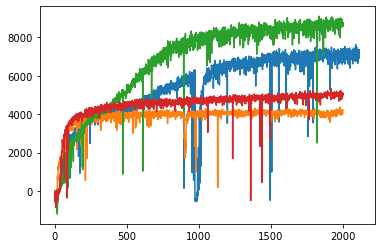

In [2]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
np.savetxt('rewards_1g_walker_2.txt',scores,fmt='%d')
r=np.loadtxt('rewards_50g_walker.txt',dtype='int')
r2=np.loadtxt('rewards_1g_walker.txt',dtype='int')
r3=np.loadtxt('rewards_50g_adaptive_walker.txt',dtype='int')
r4=np.loadtxt('rewards_1g_walker_2.txt',dtype='int')
plt.plot(r)
plt.plot(r2)
plt.plot(r3)
plt.plot(r4)

In [2]:
import numpy as np
np.savetxt('rewards_50g_walker_3.txt',scores,fmt='%d')
#torch.save(net, os.getcwd()+'/dqn_oh_50g_adaptive_breakout.pt')

In [3]:
import matplotlib.pyplot as plt
plt.plot(savgol_filter(scores,225,1)); plt.ylim([-200,315])
plt.savefig('demo.png', transparent=True)

NameError: name 'savgol_filter' is not defined

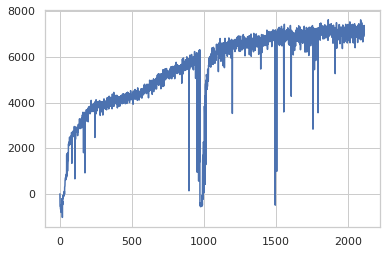

In [39]:
import matplotlib.pyplot as plt
plt.plot(scores)

In [104]:
from IPython.display import clear_output
device='cuda'
ground=[]
air=[]
all_states=[]
for i in range(1):

    state2 = env.reset()
    score = 0
    ddif2=[]
    for t in range(2000):
        print(t)
        clear_output(wait=True);
        


        state, action_, reward, next_state, done = replay_buffer.sample(1)
        
        all_states.append(np.mean(state,0))
        
#         env.render()
        state = torch.FloatTensor(state).to(device).detach()
        action = torch.FloatTensor(action_).to(device).detach()
        reward = torch.FloatTensor(reward).reshape((len(reward),1)).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done = torch.FloatTensor(done).reshape((len(reward),1)).to(device)
        noise = torch.FloatTensor(action_).data.normal_(0, policy_noise).to(device)
        noise = noise.clamp(-noise_clip, noise_clip)
        next_action = (policy.actor_target(next_state) + noise)
        next_action = next_action.clamp(-policy.max_action, policy.max_action)
                
#         states, actions_, rewards, next_states, dones = replay_buffer.ordered_sample(replay_buffer.size-2,replay_buffer.size-1)
        
#         states, actions_, rewards, next_states, dones = replay_buffer.sample(1)

        
      #  action2 = policy.select_action(state2)
      #  next_state2, _, _, _ = env.step(action2)
      #  state2 = torch.FloatTensor([state2]).to(device).detach()
#         replay_buffer.add((state, action, reward, next_state, float(done)))
        
        dif2=[]; 
        for g in range(NUM_GAMMAS):
            policy.old_critic = Critic(state_dim, action_dim).to(device).to('cuda')
            policy.old_critic.load_state_dict(policy.critic_1.state_dict())

            old_actor_loss=policy.old_critic(state, policy.actor(state)).T[0].mean().detach()

            target_Q1 = policy.critic_1_target(next_state, next_action)
            target_Q2 = policy.critic_2_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + ((1-done) * GAMMAS[0] * target_Q).detach()

            current_Q1 = policy.old_critic(state, action)
            ind_losses = nn.MSELoss(reduction='none')(current_Q1,target_Q)
            ind_loss=ind_losses.mean(0)[g]

            policy.opt_aux=optim.Adam(policy.old_critic.parameters(), lr=lr)
            policy.opt_aux.zero_grad()
            ind_loss.backward()
            policy.opt_aux.step()

            new_actor_loss=policy.old_critic(state, policy.actor(state)).T[0].mean()
            
            dif2.append((new_actor_loss-old_actor_loss).detach().to('cpu').numpy())
            
        ddif2.append(dif2)
       # state2=next_state2
        plt.plot( dif2); plt.show()
#         if (state[2]+state[13])==0:
#             air.append(np.array(dif2))
#         elif (state[8]+state[13])>0:
#             ground.append(np.array(dif2))
        
#         state=next_state

KeyboardInterrupt: 

In [108]:
np.shape(np.array(ddif2).T[0]-np.array(ddif2).T[1])

(323,)

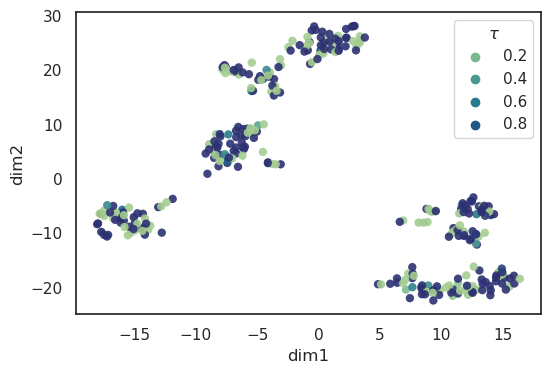

In [125]:
from matplotlib import cm
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

sns.set_style('white')


X_embedded = TSNE(n_components=2).fit_transform(np.array(all_states)[:,:])

# d=[(ddif2[i]-np.min(ddif2[i]))/(np.max(ddif2[i])-np.min(ddif2[i])) for i in range(len(ddif2))]
# d=d/np.sum(d)
# colors=np.array([np.dot(np.arange(0,1,1/len(d[i])),
#                         d[i]) for i in range(len(d))])

colors=-0.01/np.log(GAMMAS[0].to('cpu').numpy()[np.argmax(np.array(ddif2).T[0:].T,1)]); 
# colors=np.array(ddif2).T[0]-np.array(ddif2).T[-1]

viridis = cm.get_cmap('viridis', 50)

df= pd.DataFrame({"dim1" : X_embedded[0:len(colors),0],
                  "dim2" : X_embedded[0:len(colors),1],
                  "$\\tau$" : colors,
                 })
plt.figure(dpi=100)

sns.scatterplot(data=df, x="dim1", y="dim2", hue="$\\tau$",
                  alpha=0.9,linewidth=0,palette="crest")


plt.savefig('demo.png', transparent=True)

In [1]:
from IPython.display import clear_output

ground=[]
air=[]

for i in range(1):

    state = env.reset()
    score = 0
    ddif2=[]
    pre_state=[]
    for t in range(2000):
        clear_output(wait=True);
                
        
        action = policy.select_action(state)
        next_state, reward, done, _ = env.step(action)
        env.render()
        pre_state.append(state)
        state = next_state
        
        
        plt.plot(np.array(pre_state).T[0]); plt.plot(np.array(pre_state).T[1]) ;  plt.show()

NameError: name 'env' is not defined

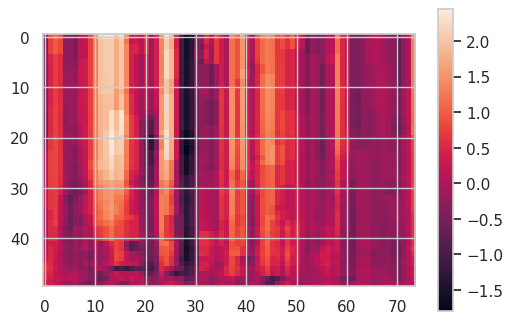

In [102]:

import seaborn as sns
from scipy.signal import savgol_filter

sns.set_theme(style="whitegrid")

d=np.array([[dif[i][j] for j in range(len(dif[i]))]  for i in range(len(dif))])
# d=np.array([d[i]-np.mean(d[i])+1 for i in range(len(d))])
# d[d<0]=0
plt.figure(dpi=100)
#plt.imshow((d[0:100].T)); plt.colorbar()
plt.imshow((savgol_filter(d.T[:,6:],3,1,axis=1)),);  plt.colorbar()
plt.savefig('demo.png', transparent=True)

In [4]:
from IPython.display import clear_output

ground=[]
air=[]

for i in range(1):

    state = env.reset()
    score = 0
    ddif2=[]
    for t in range(2000):
        clear_output(wait=True);
        env.render()

        action = policy.select_action(state)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, float(done)))
        
        states, actions_, rewards, next_states, dones = replay_buffer.ordered_sample(replay_buffer.size-2,replay_buffer.size)
        states = torch.FloatTensor(states).to(device).detach()
        actions = torch.FloatTensor(actions_).to(device).detach()

        state2, action_2, reward2, next_state2, done2 = replay_buffer.ordered_sample(replay_buffer.size-2,replay_buffer.size)
        state2 = torch.FloatTensor(state2).to(device)
        action2 = torch.FloatTensor(action_2).to(device)
        reward2 = torch.FloatTensor(reward2).reshape((len(reward2),1)).to(device)
        next_state2 = torch.FloatTensor(next_state2).to(device)
        done2 = torch.FloatTensor(done2).reshape((len(reward2),1)).to(device)
        noise = torch.FloatTensor(action_2).data.normal_(0, policy_noise).to(device)
        noise = noise.clamp(-noise_clip, noise_clip)
        next_action2 = (policy.actor_target(next_state2) + noise)
        next_action2 = next_action2.clamp(-policy.max_action, policy.max_action)

        dif2=[]; 
        for g in range(NUM_GAMMAS):
            policy.old_critic = Critic(state_dim, action_dim).to(device).to('cpu')
            policy.old_critic.load_state_dict(policy.critic_1.state_dict())
            policy.old_critic.to('cuda')

            old_actor_loss=policy.old_critic(states, policy.actor(states)).T[0].mean().detach()
            old_q_vals=policy.old_critic(states, policy.actor(states)).T[0].mean().detach()

            target_Q1 = policy.critic_1_target(next_state2, next_action2)
            target_Q2 = policy.critic_2_target(next_state2, next_action2)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward2 + ((1-done2) * GAMMAS[g][0] * target_Q).detach()

            current_Q1 = policy.old_critic(state2, action2)
            ind_losses = nn.MSELoss(reduction='none')(current_Q1,target_Q)
            ind_loss=ind_losses.mean(0)[g]

            policy.opt_aux=optim.Adam(policy.old_critic.parameters(), lr=lr)
            policy.opt_aux.zero_grad()
            ind_loss.backward()
            policy.opt_aux.step()

            new_actor_loss=policy.old_critic(states, policy.actor(states)).T[0].mean()
            
            new_q_vals=policy.old_critic(states, actions).T[0].mean()
            dif2.append((new_actor_loss-old_actor_loss).detach().to('cpu').numpy())
            
        ddif2.append(dif2)
        plt.plot( dif2); plt.title([state[8],state[13]]); plt.show()
        if (state[8]+state[13])==0:
            air.append(np.array(dif2))
        elif (state[8]+state[13])>0:
            ground.append(np.array(dif2))
        
        state=next_state

KeyboardInterrupt: 

In [18]:
dif2

[array(-0.29447573, dtype=float32),
 array(-0.25053507, dtype=float32),
 array(-0.2499519, dtype=float32),
 array(-0.25119758, dtype=float32)]

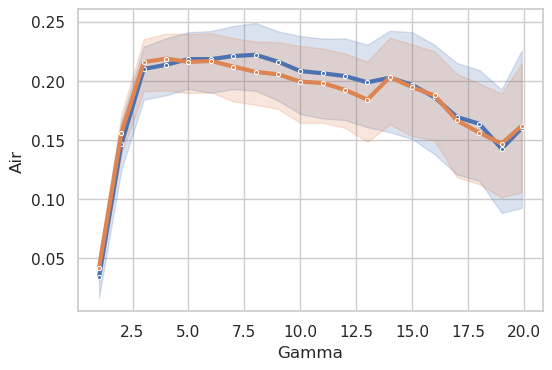

In [67]:
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid")

x_ax=[-0.2/np.log(GAMMAS[0].detach().to('cpu').numpy()) for i in range(0,len(air))]
df1= pd.DataFrame({"Air" : np.array(air).flatten(),
                  "Gamma" : np.array(x_ax).flatten()})

x_ax=[-0.2/np.log(GAMMAS[0].detach().to('cpu').numpy()) for i in range(0,len(ground))]
df2= pd.DataFrame({"Ground" : np.array(ground).flatten(),
                  "Gamma" : np.array(x_ax).flatten()})


plt.figure(dpi=100)
sns.lineplot(x="Gamma", y="Air", data=df1,ci=95,linewidth=3,marker=".")
sns.lineplot(x="Gamma", y="Ground", data=df2,ci=95,linewidth=3,marker=".")

plt.savefig('demo.png', transparent=True)

#plt.plot(np.mean(air,0))
#plt.plot(np.mean(ground,0))

In [19]:
import gym
env = gym.make('HalfCheetah-v2')

AttributeError: module 'mujoco_py' has no attribute 'load_model_from_path'

In [2]:
b=np.loadtxt('rewards_20g_adaptive_walker_2.txt',dtype=int)

---------------------------------------
Evaluation over 10 episodes: 5143.831
---------------------------------------


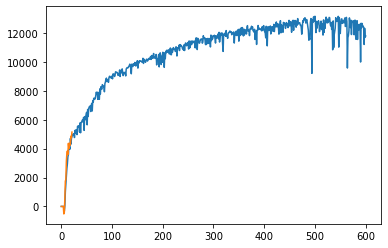

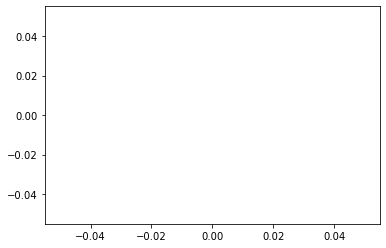

KeyboardInterrupt: 

In [7]:
from IPython.display import clear_output
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sunblaze_envs
import numpy as np
import torch
import gym
import argparse
import os
import matplotlib.pyplot as plt

batch_size=100
buffer_size=1e6

GAMMAS=[0.6,0.9,0.95,0.99]
num_gammas=len(GAMMAS)

GAMMAS=np.flip(GAMMAS)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GAMMAS=torch.tensor([GAMMAS for _ in range(batch_size)]).float().to(device)

# Implementation of Twin Delayed Deep Deterministic Policy Gradients (TD3)
# Paper: https://arxiv.org/abs/1802.09477

d=np.ones(NUM_GAMMAS)


class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )

    
class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, max_action):
		super(Actor, self).__init__()

		self.l1 = nn.Linear(state_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, action_dim)
		
		self.max_action = max_action
		

	def forward(self, state):
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		return self.max_action * torch.tanh(self.l3(a))


class Critic(nn.Module):
	def __init__(self, state_dim, action_dim):
		super(Critic, self).__init__()

		# Q1 architecture
		self.l1 = nn.Linear(state_dim + action_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, NUM_GAMMAS)

		# Q2 architecture
		self.l4 = nn.Linear(state_dim + action_dim, 256)
		self.l5 = nn.Linear(256, 256)
		self.l6 = nn.Linear(256, NUM_GAMMAS)


	def forward(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)

		q2 = F.relu(self.l4(sa))
		q2 = F.relu(self.l5(q2))
		q2 = self.l6(q2)
		return q1, q2


	def Q1(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)
		return q1


class TD3(object):
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_freq=2
    ):

        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq

        self.total_it = 0


    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()


    def train(self, replay_buffer, batch_size=256):
        self.total_it += 1

        # Sample replay buffer 
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        with torch.no_grad():
            # Select action according to policy and add clipped noise
            noise = (
                torch.randn_like(action) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip)
            
            next_action = (
                self.actor_target(next_state) + noise
            ).clamp(-self.max_action, self.max_action)

            # Compute the target Q value
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + not_done * self.discount * target_Q

        # Get current Q estimates
        current_Q1, current_Q2 = self.critic(state, action)

        # Compute critic loss
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Delayed policy updates
        if self.total_it % self.policy_freq == 0:

            # Compute actor losse
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
            
            # Optimize the actor 
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        
        

# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env_name, seed, eval_episodes=10):
    eval_env = gym.make(env_name)
    eval_env.seed(seed + 100)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done, _ = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes

    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward


if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--policy", default="TD3")                  # Policy name (TD3, DDPG or OurDDPG)
    parser.add_argument("--env", default="HalfCheetah-v2")          # OpenAI gym environment name
    parser.add_argument("--seed", default=0, type=int)              # Sets Gym, PyTorch and Numpy seeds
    parser.add_argument("--start_timesteps", default=25e3, type=int)# Time steps initial random policy is used
    parser.add_argument("--eval_freq", default=5e3, type=int)       # How often (time steps) we evaluate
    parser.add_argument("--max_timesteps", default=1e6, type=int)   # Max time steps to run environment
    parser.add_argument("--expl_noise", default=0.1)                # Std of Gaussian exploration noise
    parser.add_argument("--batch_size", default=256, type=int)      # Batch size for both actor and critic
    parser.add_argument("--discount", default=0.99)                 # Discount factor
    parser.add_argument("--tau", default=0.005)                     # Target network update rate
    parser.add_argument("--policy_noise", default=0.2)              # Noise added to target policy during critic update
    parser.add_argument("--noise_clip", default=0.5)                # Range to clip target policy noise
    parser.add_argument("--policy_freq", default=2, type=int)       # Frequency of delayed policy updates
    parser.add_argument("--save_model", action="store_true")        # Save model and optimizer parameters
    parser.add_argument("--load_model", default="")                 # Model load file name, "" doesn't load, "default" uses file_name
    args,unknown = parser.parse_known_args()



    env = gym.make(args.env)

    # Set seeds
    env.seed(args.seed)
    env.action_space.seed(args.seed)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0] 
    max_action = float(env.action_space.high[0])

    kwargs = {
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action,
        "discount": args.discount,
        "tau": args.tau,
    }

    # Initialize policy
    if args.policy == "TD3":
        # Target policy smoothing is scaled wrt the action scale
        kwargs["policy_noise"] = args.policy_noise * max_action
        kwargs["noise_clip"] = args.noise_clip * max_action
        kwargs["policy_freq"] = args.policy_freq
        policy = TD3(**kwargs)

    replay_buffer = ReplayBuffer(state_dim, action_dim)
    
    # Evaluate untrained policy
    evaluations = []

    state, done = env.reset(), False
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0
    total_reward=[]
    
    for t in range(int(args.max_timesteps)):
        episode_timesteps += 1

        # Select action randomly or according to policy
        if t < args.start_timesteps:
            action = env.action_space.sample()
        else:
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * args.expl_noise, size=action_dim)
            ).clip(-max_action, max_action)

        # Perform action
        next_state, reward, done, _ = env.step(action) 
        done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

        # Store data in replay buffer
        replay_buffer.add(state, action, next_state, reward, done_bool)

        state = next_state
        episode_reward += reward
        if t >= args.start_timesteps:
            policy.train(replay_buffer, args.batch_size)

        if done: 
            # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
            if episode_num % 100 == 0:
                print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
            # Reset environment
            state, done = env.reset(), False
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1 
            
        
        # Evaluate episodE
        if (t + 1) % args.eval_freq == 0:
            clear_output(wait=True);
            evaluations.append(eval_policy(policy, args.env, args.seed))
            r = np.loadtxt('rewards_50g_cheetah_full.txt',dtype='int')
#             r2 = np.loadtxt('rewards_cheetah_RE_50g_adaptive.txt',dtype='int')
            plt.plot(r); 
#             plt.plot(r2)
            plt.plot(evaluations); plt.show()
            plt.plot(total_reward); plt.show()

In [2]:
np.savetxt('rewards_hopper_RE_1g.txt',evaluations,fmt='%d')

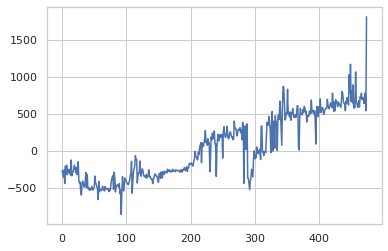

In [580]:
plt.plot(total_reward)

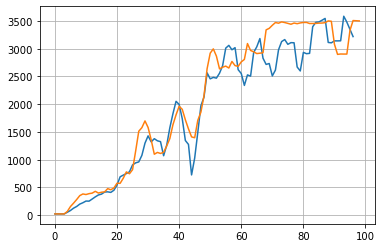

In [12]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
np.savetxt('rewards_50g_hopper_adaptive_2.txt',evaluations,fmt='%d')

r = np.loadtxt('rewards_1g_hopper_2.txt',dtype='int')
r2 = np.loadtxt('rewards_50g_hopper.txt',dtype='int')
r3 = np.loadtxt('rewards_50g_hopper_adaptive_2.txt',dtype='int')
plt.plot(savgol_filter(r,5,1))
# plt.plot(r2)
plt.plot(savgol_filter(r3,5,1))
plt.grid(b=True)


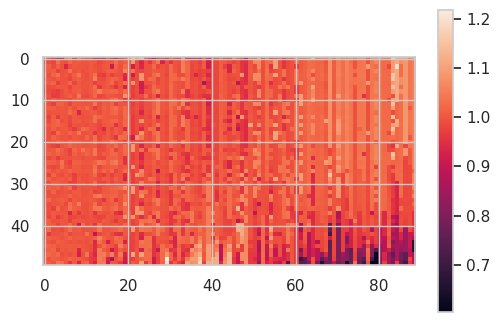

In [581]:

import seaborn as sns
from scipy.signal import savgol_filter

sns.set_theme(style="whitegrid")

d=np.array([[dif[i][j] for j in range(len(dif[i]))]  for i in range(len(dif))])
d=np.array([d[i]-np.mean(d[i])+1 for i in range(len(d))])
d[d<0]=0
plt.figure(dpi=100)
#plt.imshow((d[0:100].T)); plt.colorbar()
plt.imshow(d.T);  plt.colorbar()
plt.savefig('demo.png', transparent=True)

In [4]:
np.savetxt('weights_cheetah_RR_50g_adaptive.txt',dif,fmt='%d')

In [2]:
env = sunblaze_envs.make('SunblazeHalfCheetah-v0')

/home/pablotano/anaconda3/envs/DeepRL2/lib/python3.7/site-packages/sunblaze_envs-0.1.0-py3.7.egg/sunblaze_envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


# Lunar Lander

In [97]:
# # !/usr/bin/env python3
import gym
import os
import argparse
import time
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim

# 
DEFAULT_ENV_NAME = "LunarLander-v2"
#DEFAULT_ENV_NAME = "Acrobot-v1"
MEAN_REWARD_BOUND = 19

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 150000
LEARNING_RATE = 1e-3
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 3000

EPSILON_DECAY_LAST_FRAME = 20000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01



NUM_H=1
NUM_GAMMAS=25
taus=np.linspace(5,100,NUM_GAMMAS)
GAMMAS=np.exp(-1/taus)
GAMMAS[-1]=0.99

GAMMAS=np.flip(GAMMAS)

GAMMAS=np.repeat(GAMMAS,NUM_H)
ratio=np.ones(NUM_GAMMAS)

sens=[1,4,7]

Experience = collections.namedtuple(
    'Experience', field_names=['state', 'action', 'reward',
                               'done', 'new_state'])
all_losses=[]


class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()


        self.fc = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, NUM_GAMMAS*env.action_space.n),
        )
        
#         self.fc1 = nn.Sequential( 
#             nn.Linear(env.observation_space.shape[0], 512),
#             nn.ReLU()
#         )
        
#         self.fc2 = nn.Sequential(
#             nn.Linear(512, 512),
#             nn.ReLU()
#         )
        
#         self.fc3 = nn.Sequential(
#             nn.Linear(512, NUM_GAMMAS*env.action_space.n),
#         )
        

        
    def forward(self, x):
#         return self.fc3(self.fc2(self.fc1(x)))
        return self.fc(x)
    
    
    
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size,
                                   replace=False)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)
    
    def ordered_sample(self,start,end):
        indices = np.arange(start,end)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)

class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.float32(np.array([self.state], copy=False))
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v.narrow(-1,0,env.action_space.n), dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward,
                         is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward


def calc_loss(batch, net, tgt_net, device="cpu",individual=False,weights=None):
    

    states, actions, rewards, dones, next_states = batch


    states_v = torch.tensor(np.float32(np.array(
        states, copy=False))).to(device)
    next_states_v = torch.tensor(np.float32(np.array(
        next_states, copy=False))).to(device)

    actions_v0 = torch.tensor(actions).to(device)
    output=net(states_v)
    output=output.reshape(len(rewards),NUM_GAMMAS*NUM_H,env.action_space.n)
    state_action_values=output[range(0,len(rewards)),:,actions_v0]


    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)

    rewards_v=rewards_v.repeat(NUM_GAMMAS*NUM_H,1).T
    done_mask=done_mask.repeat(NUM_GAMMAS*NUM_H,1).T

    gammas=np.tile(GAMMAS,(len(rewards),1))
    gammas=np.float32(gammas)
    gammas=torch.tensor(gammas).to(device)

    rewards_v[done_mask] = -1

    rewards_after_sens=rewards_v

    #  for i in range(0,NUM_H):
    #      for n in np.arange(1,NUM_GAMMAS): #for the first gamma (position 0) I keep the actual rewards
    #          if i==0:
    #              rewards_after_sens[:,n*NUM_H+i]=torch.tensor((rewards)).float()
    #          else:
    #              rewards_after_sens[:,n*NUM_H+i]=torch.tensor((rewards==sens[i-1])).float()
          #  rewards_after_sens[:,n*NUM_H+i]=torch.tensor((rewards)).float()

    with torch.no_grad():
        output_next=tgt_net(next_states_v)
        output_next=output_next.reshape(len(rewards),NUM_GAMMAS*NUM_H,env.action_space.n)

        best_action=torch.argmax(output_next[:,0,:],dim=-1)

        next_state_values=output_next[range(0,len(rewards)),:,best_action]

        next_state_values[done_mask] = 0.0
    #     rewards_v[done_mask] = -1
        next_state_values = next_state_values.detach()


    expected_state_action_values=next_state_values * gammas + \
                                   rewards_after_sens



    weights=torch.zeros((NUM_GAMMAS,BATCH_SIZE)).to('cuda')
    heights = NUM_GAMMAS - ((states_v[:,1]+2)*6).long()
    np.shape(heights)
    for i in range(0,BATCH_SIZE):
        weights[heights[i],i]=1
        
    weights[0,:]=1

    losses=torch.transpose(nn.SmoothL1Loss(reduction='none')(state_action_values,expected_state_action_values),0,1)

    return torch.mean(weights*losses)




if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--cuda", default=False,
                        action="store_true", help="Enable cuda")
    parser.add_argument("--env", default=DEFAULT_ENV_NAME,
                        help="Name of the environment, default=" +
                             DEFAULT_ENV_NAME)
    args,unknown = parser.parse_known_args()
    device = "cuda"

    env = gym.make(args.env)

    net = DQN(env.observation_space.shape,
                        env.action_space.n).to(device)
    
    with torch.no_grad():
        tgt_net = DQN(env.observation_space.shape,
                                env.action_space.n).to('cpu')
        tgt_net.to('cuda')

        
#     net.load_state_dict(torch.load(os.getcwd()+'/LunarLander-v2-best_-36.dat'))
  #  net = torch.load(os.getcwd()+'/dqn_pong_low_r.pt')#
    
  #  tgt_net = torch.load(os.getcwd()+'/dqn_pong_low_r.pt')
    
  #  writer = SummaryWriter(comment="-" + args.env)
    print(net)

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    epsilon = EPSILON_START

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    total_rewards = []
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_m_reward = None
    similarities=[]
    while True:
        frame_idx += 1
        epsilon = max(EPSILON_FINAL, EPSILON_START -
                      frame_idx / EPSILON_DECAY_LAST_FRAME)
       # epsilon=0.01
        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            m_reward = np.mean(total_rewards[-5:])
            
            if len(total_rewards) % 5 ==0:
                print("%d: done %d games, reward %.3f, "
                      "eps %.2f, speed %.2f f/s" % (
                    frame_idx, len(total_rewards), m_reward, epsilon,
                    speed
                ))
         #   writer.add_scalar("epsilon", epsilon, frame_idx)
         #   writer.add_scalar("speed", speed, frame_idx)
         #   writer.add_scalar("reward_100", m_reward, frame_idx)
         #   writer.add_scalar("reward", reward, frame_idx)
            if best_m_reward is None or best_m_reward < m_reward:
                net.to('cpu')
                torch.save(net.state_dict(), 'net_cache')
                net.to(device)
               # if best_m_reward is not None:
               #     print("Best reward updated %.3f -> %.3f" % (
               #         best_m_reward, m_reward))
                best_m_reward = m_reward
       #     if m_reward > 200:
       #         print("Solved in %d frames!" % frame_idx)
       #         break
#         if frame_idx > 100:
#             print("Solved in %d frames!" % frame_idx)
#             break

        if len(buffer) < REPLAY_START_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            with torch.no_grad():
                del tgt_net #LOAD_STATE_DICT causes memory issues (only seen when running "dmesg" in terminal)
                
                tgt_net = DQN(env.observation_space.shape,
                            env.action_space.n).to('cpu')
                tgt_net.load_state_dict(net.state_dict())
                tgt_net.to('cuda')
                
        
        
#         if frame_idx % 2000 == 0:
#             old_net = DQN(env.observation_space.shape,
#                             env.action_space.n).to(device)
#             torch.save(net.state_dict(), 'net_cache')
#             old_net.load_state_dict(net.state_dict()); old_net.zero_grad()
#             optimizer_old=torch.optim.Adam(old_net.parameters(), lr=LEARNING_RATE)
            
#             batch_ind = buffer.sample(32)
#             batch_aux = batch_ind
#             actions=batch_ind[1]; states=batch_ind[0];

#             states_v = torch.tensor(np.float32(np.array(
#                 states, copy=False))).to(device)


#             output_old=old_net(states_v).reshape(len(actions),NUM_GAMMAS*NUM_H,env.action_space.n)
#             old_q_vals=torch.max(output_old[range(0,len(actions)),0:1,0:env.action_space.n],2).values.detach().to('cpu').numpy()
            
#             rat_all=[]
#             for n in range(0,5):

#                 rat=[]; delta=[]; 
#                 for gamma in range(0,NUM_GAMMAS):

#                     aux_net = DQN(env.observation_space.shape,
#                                 env.action_space.n).to(device)
#                     aux_net.load_state_dict(old_net.state_dict()); aux_net.zero_grad()
#                     optimizer_aux=torch.optim.Adam(aux_net.parameters(), lr=LEARNING_RATE)
#                     optimizer_aux.zero_grad(); 

#     #                     old_net.load_state_dict(net.state_dict()); old_net.zero_grad()

#                     _ , loss = calc_loss(batch_aux, aux_net, tgt_net, device=device,individual=True,weights=1+0*torch.tensor(ratio).to(device))
#                     ind_loss=loss[gamma]
#                     ind_loss.backward(retain_graph=True)

#                     optimizer_aux.step()

#                     output=aux_net(states_v).reshape(len(actions),NUM_GAMMAS*NUM_H,env.action_space.n)
#     #                 new_q_vals=(output[range(0,len(actions)),0:4,actions]).detach().numpy()
#                     new_q_vals=torch.max(output[range(0,len(actions)),0:1,0:env.action_space.n],2).values.detach().to('cpu').numpy()

#                     rat.append(np.mean(np.array(new_q_vals)-np.array(old_q_vals)))

#                     rat_all.append(rat)

               
#                 optimizer_old.zero_grad(); old_net.zero_grad()
#                 loss_t, _ = calc_loss(batch_aux, old_net, tgt_net, device=device,individual=False,weights=torch.tensor(ratio).to(device))
#                 loss_t.backward()
#                 optimizer_old.step()
#                 torch.save(old_net.state_dict(), 'old_net_cache')
                
# #             rat = np.array(rat)
#             rat = np.array(np.mean(rat_all,0))
#             rat = (rat - np.min(rat))/(np.max(rat)-np.min(rat))

#             rat = rat - np.mean(rat)
            
#             ratio = rat + 1
# #             ratio= ratio + 0.1 * rat
# #             ratio[ratio<0]=0;
# #             ratio = ratio + 0.1 * np.array(np.mean(rat_all,0))
# #             ratio[0]=1
#           #  argmax=np.argmax(ratio)
# #             ratio=0*ratio
# #             ratio[argmax]=0.5
# #             ratio[0]=0.5
#             similarities.append(ratio)
        
        
               
        if frame_idx % 1000005 == 0:
            torch.save(net.state_dict(), 'net_cache')
            pre_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
            pre_net.load_state_dict(net.state_dict());
#             optimizer_pre = optim.Adam(pre_net.parameters(), lr=LEARNING_RATE)
            rat_all=[]
            
            
            batch_ind = buffer.ordered_sample(len(buffer)-500,len(buffer))
            batch_aux = batch_ind
            actions=batch_ind[1]; states=batch_ind[0];
            states_v = torch.tensor(np.float32(np.array(states, copy=False))).to(device)
            output_old=net(states_v).reshape(len(actions),NUM_GAMMAS*NUM_H,env.action_space.n)
            old_q_vals=torch.max(output_old[range(0,len(actions)),0:1,0:env.action_space.n],2).values.detach().to('cpu').numpy()

#                 _ , loss = calc_loss(batch_ind, pre_net, tgt_net, device=device,individual=True,weights=torch.tensor(ratio ).to(device))
#                 ind_loss=loss[0]
#                 ind_loss.backward(retain_graph=True)
#                 grad_main=[pre_net.fc[i].weight.grad for i in [0,2,4]]
#                 torch.save(pre_net.state_dict(), 'pre_net_cache')

            rat=[]; los=[]
            norm=torch.as_tensor(np.mean(all_losses,0))
        
            for gamma in range(0,NUM_GAMMAS):
                aux_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
                aux_net.load_state_dict(net.state_dict());
                optimizer_aux=torch.optim.Adam(aux_net.parameters(), lr=LEARNING_RATE)
                
                w = np.zeros(NUM_GAMMAS)
                w[gamma] = 1
                for _ in range(5):
                    
                    batch_aux = buffer.sample(32)
                
                    
                    optimizer_aux.zero_grad(); aux_net.zero_grad();  
                    
                    
                    ind , _ = calc_loss(batch_aux, aux_net, aux_net, device=device,weights=torch.tensor(w ).to(device))
#                     ind_loss = loss[gamma]
                    
                    ind_loss = ind/norm[gamma]
                    ind_loss.backward()
#                     grad_aux=[aux_net.fc[i].weight.grad for i in [0,2,4]]
                    optimizer_aux.step()
    
                    optimizer_aux.zero_grad(); aux_net.zero_grad(); 
                    los , _ = calc_loss(batch_aux, aux_net, aux_net, device=device, weights=torch.tensor( ratio ).to(device))
                    loss2 = los/norm[gamma]
                    loss2.backward()
                    optimizer_aux.step()
                    
                
                output = aux_net(states_v).reshape(len(actions),NUM_GAMMAS*NUM_H,env.action_space.n)
                new_q_vals = torch.max(output[range(0,len(actions)),0:1,0:env.action_space.n],2).values.detach().to('cpu').numpy()
                sim = np.mean(np.array(new_q_vals)-np.array(old_q_vals))

#                     sim=np.sum([torch.dot(grad_main[i].view(-1),grad_aux[i].view(-1)) for i in [0,1,2]])
#                     rat.append(sim.detach().to('cpu').numpy()//?)
                rat.append(sim)

            rat_all.append(rat)
#                 optimizer_pre.zero_grad(); pre_net.zero_grad()
#                 loss_t, _ = calc_loss(batch_ind, pre_net, tgt_net, device=device,weights=torch.tensor(ratio ).to(device))
#                 loss_t.backward(retain_graph=False)
#                 optimizer_pre.step()
#                 torch.save(pre_net.state_dict(), 'pre_net_cache')

                
#             ratio2=np.array(np.sum(rat_all,0)) 
            ratio2 = np.array(rat)
            ratio2=(ratio2-np.min(ratio2))/(np.max(ratio2)-np.min(ratio2))
            ratio2=ratio2-np.mean(ratio2)+1
            ratio=ratio2
            ratio[ratio<0]=0
#             ratio = ratio + 0.1* ratio2
            similarities.append(ratio)

    
    
    
#         ratio=ratio
      #  ratio[0]=1
        for _ in range(0,2):
            optimizer.zero_grad(); net.zero_grad()
        
            batch = buffer.sample(BATCH_SIZE)
            loss_t = calc_loss(batch, net, tgt_net, device=device,weights=1+0*torch.tensor(ratio).to(device))
            loss_t.backward(retain_graph=False)
            optimizer.step()
        
        del loss_t
        del batch
 #   writer.close()

DQN(
  (fc): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=100, bias=True)
  )
)
501: done 5 games, reward -132.858, eps 0.97, speed 5549.09 f/s
835: done 10 games, reward -124.308, eps 0.96, speed 5587.65 f/s
1289: done 15 games, reward -175.816, eps 0.94, speed 6926.86 f/s
1691: done 20 games, reward -206.778, eps 0.92, speed 5496.87 f/s
2186: done 25 games, reward -310.243, eps 0.89, speed 4777.31 f/s
2682: done 30 games, reward -199.618, eps 0.87, speed 5974.34 f/s
3168: done 35 games, reward -346.059, eps 0.84, speed 87.28 f/s
3707: done 40 games, reward -92.000, eps 0.81, speed 102.71 f/s
4217: done 45 games, reward -117.100, eps 0.79, speed 96.94 f/s
4703: done 50 games, reward -106.695, eps 0.76, speed 107.71 f/s
5327: done 55 games, reward -52.745, eps 0.73, speed 108.89 f/s
5877: done 60 games, reward -95.962, ep

KeyboardInterrupt: 

In [89]:
GAMMAS

array([0.99      , 0.98964187, 0.98919903, 0.98871662, 0.98818911,
       0.98760987, 0.98697087, 0.98626238, 0.98547241, 0.98458605,
       0.9835845 , 0.98244376, 0.98113264, 0.97960989, 0.97781977,
       0.9756851 , 0.97309582, 0.96988939, 0.96581535, 0.96046654,
       0.95313379, 0.9424624 , 0.92550166, 0.89437699, 0.81873075])

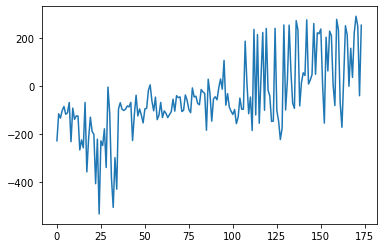

In [98]:
plt.figure()
plt.plot(total_rewards)

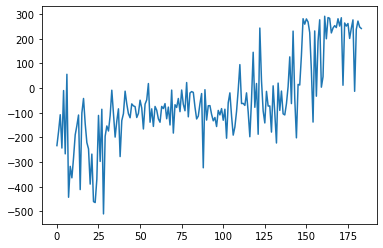

In [96]:
plt.figure()
plt.plot(total_rewards)

In [599]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
sns.set_theme(style="whitegrid")
plt.figure(dpi=100)
s=np.array(similarities).T


plt.imshow(savgol_filter(savgol_filter(s.T,5,1).T,5,1)); plt.colorbar()
# plt.imshow(s); plt.colorbar()
plt.savefig('demo.png', transparent=True)

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

<Figure size 600x400 with 0 Axes>

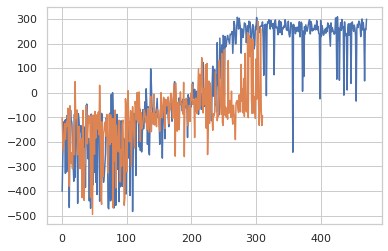

In [706]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
# np.savetxt('rewards_50g_counter_adaptive_lunar.txt',total_rewards,fmt='%d')

r = np.loadtxt('rewards_50g_adaptive_lunar.txt',dtype='int')
# r2 = np.loadtxt('rewards_50g_counter_adaptive_lunar.txt',dtype='int')
plt.plot(r)
plt.plot(total_rewards)

plt.grid(b=True)

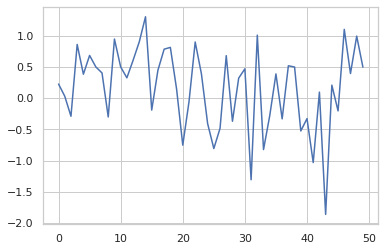

In [407]:
torch.save(net.state_dict(), 'net_cache')
pre_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
pre_net.load_state_dict(net.state_dict());
#             optimizer_pre = optim.Adam(pre_net.parameters(), lr=LEARNING_RATE)
rat_all=[]


batch_ind = buffer.ordered_sample(len(buffer)-500,len(buffer))
batch_aux = batch_ind
actions=batch_ind[1]; states=batch_ind[0];
states_v = torch.tensor(np.float32(np.array(states, copy=False))).to(device)
output_old=net(states_v).reshape(len(actions),NUM_GAMMAS*NUM_H,env.action_space.n)
old_q_vals=torch.max(output_old[range(0,len(actions)),0:1,0:env.action_space.n],2).values.detach().to('cpu').numpy()
rat=[]

for gamma in range(0,NUM_GAMMAS):
    aux_net = DQN(env.observation_space.shape, env.action_space.n).to(device)

    aux_net.load_state_dict(net.state_dict());
    optimizer_aux=torch.optim.Adam(aux_net.parameters(), lr=LEARNING_RATE)

    w=np.zeros(NUM_GAMMAS)
    w[gamma]=1
    for _ in range(5):
        optimizer_aux.zero_grad(); aux_net.zero_grad();  

        batch_aux = buffer.sample(32)
        ind_loss, _ = calc_loss(batch_aux, aux_net, aux_net, device=device,weights=torch.tensor(w).to(device))
#         ind_loss = loss[gamma]
        ind_loss.backward(retain_graph=True)
#                     grad_aux=[aux_net.fc[i].weight.grad for i in [0,2,4]]
        optimizer_aux.step()
        optimizer_aux.zero_grad(); aux_net.zero_grad(); 
        loss2 , _ = calc_loss(batch_aux, aux_net, tgt_net, device=device,weights=torch.tensor(ratio ).to(device))
        loss2.backward()
        optimizer_aux.step()

    output = aux_net(states_v).reshape(len(actions),NUM_GAMMAS*NUM_H,env.action_space.n)
    new_q_vals = torch.max(output[range(0,len(actions)),0:1,0:env.action_space.n],2).values.detach().to('cpu').numpy()
    sim = np.mean(np.array(new_q_vals)-np.array(old_q_vals))
    rat.append(sim)
plt.plot(rat); plt.show()

In [270]:
w=np.zeros(NUM_GAMMAS)
w[1]=1
calc_loss(batch_aux, aux_net, aux_net, device=device,weights=torch.tensor(w).to(device))

(tensor(3.9087, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>),
 tensor([3.6935, 3.9087, 3.6801, 3.7194, 3.7392, 3.6342, 3.6958, 3.6730, 3.7230,
         3.7344, 3.7091, 3.6861, 3.7397, 3.6522, 3.6458, 3.7261, 3.7050, 3.6586,
         3.6330, 3.7656, 3.5763, 3.6698, 3.7031, 3.6290, 3.6435, 3.7994, 3.7573,
         3.7518, 3.7837, 3.6869, 3.7150, 3.5994, 3.6896, 3.6621, 3.5467, 3.5261,
         3.6184, 3.7450, 3.6409, 3.5733, 3.6525, 3.5610, 3.6905, 3.6183, 3.6021,
         3.6467, 3.5472, 3.5407, 3.5012, 2.8592], device='cuda:0',
        grad_fn=<MeanBackward1>))

# Grid World

In [707]:
import numpy as np
def move(size,pos_x,pos_y,act_x,act_y):
    return max((min((pos_x+act_x,size)),0)), max((min((pos_y+act_y,size)),0))

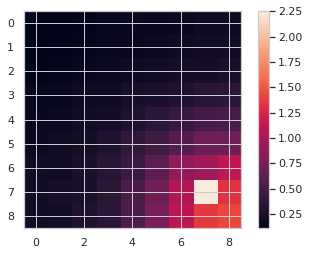

In [751]:
import matplotlib.pyplot as plt
size=8
pos_x , pos_y = 0 , 0
NUM_GAMMAS = 10
V=np.zeros((size+1,size+1))
alpha=0.01
gamma=0.99
num_episodes=100000
length_trajectory=50
for _ in range(num_episodes):
    pos_x , pos_y = np.random.choice(range(0,size),2)
    count=0
    while True:
        count+=1
        if pos_x==size-1 and pos_y==size-1:
            r=np.random.normal(1,0.1)
        else:
            r=np.random.normal(0,0.1)
            
        if count<length_trajectory:
            act_x , act_y = np.random.choice([-1,0,1],2)
            pos_x_next , pos_y_next = move(size,pos_x , pos_y , act_x , act_y)
            V[pos_x,pos_y]=V[pos_x,pos_y] + alpha*(r + gamma*V[pos_x_next,pos_y_next] - V[pos_x,pos_y])
            pos_x , pos_y = pos_x_next , pos_y_next
        else:
            V[pos_x,pos_y]=V[pos_x,pos_y] + alpha*(r - V[pos_x,pos_y])
            break

    V_correct=V

plt.imshow(V_correct); plt.colorbar()

In [752]:
# Generate Trajectories
num_episodes=10000

POS=[]
POS_NEXT=[]
R=[]
for _ in range(num_episodes):
    pos_x , pos_y = np.random.choice(range(0,size),2)
    count=0
    positions = []
    positions_next = []
    rewards = []
    while True:
        count+=1
        if pos_x==size-1 and pos_y==size-1:
            r=np.random.normal(1,0.1)
        else:
            r=np.random.normal(0,0.1)
            
        if count<length_trajectory:
            act_x , act_y = np.random.choice([-1,0,1],2)
            pos_x_next , pos_y_next = move(size,pos_x , pos_y , act_x , act_y)
            
            positions.append([pos_x,pos_y])
            pos_x , pos_y = pos_x_next , pos_y_next
            positions_next.append([pos_x_next,pos_y_next])
            rewards.append(r)
        else:
            break
    POS.append(positions)
    POS_NEXT.append(positions_next)
    R.append(rewards)

In [763]:
##### EVALUATE

pos_x , pos_y = 0 , 0
NUM_GAMMAS = 20
alpha=0.1
gamma=0.99


count=0
GAMMAS = np.linspace(0.9,0.99,NUM_GAMMAS)

errors=[]
for i in range(50):
    print(i)
    V=np.zeros((size+1,size+1,NUM_GAMMAS))
    which_trajectories=np.random.choice(range(10000),5)

    for i in range(0,NUM_GAMMAS):
        for _ in range(10000):
            which_trajectory=np.random.choice(which_trajectories)
            sample=np.random.choice(range(length_trajectory-2))
            pos_x , pos_y = POS[which_trajectory][sample]
            pos_x_next , pos_y_next = POS_NEXT[which_trajectory][sample]
            r = R[which_trajectory][sample]
            V[pos_x,pos_y,i]=V[pos_x,pos_y,i] + alpha*(r + GAMMAS[i]*V[pos_x_next,pos_y_next,i] - V[pos_x,pos_y,i])




    error=[]
    for i in range(0,NUM_GAMMAS):
        error.append(np.sum((V_correct-V[:,:,i])**2))

    errors.append(error)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


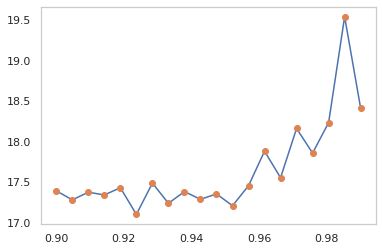

In [764]:
plt.plot(GAMMAS,np.mean(errors,0))
plt.plot(GAMMAS,np.mean(errors,0),'o')

plt.grid()

In [715]:
error

[42.749878841677955,
 44.966282412769985,
 43.19949229376099,
 46.003239406704445,
 45.570103488998996,
 46.99584734710926,
 47.15606199097735,
 49.26656618893257,
 50.164343340779965,
 49.67363024592457]

# Adaptive Laplace behaviour

In [14]:
# # !/usr/bin/env python3
import gym
import os
import argparse
import time
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim
from scipy import linalg

device = 'cuda'
# 
DEFAULT_ENV_NAME = "LunarLander-v2"
#DEFAULT_ENV_NAME = "Acrobot-v1"
MEAN_REWARD_BOUND = 19

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 150000
LEARNING_RATE = 1e-3
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 1000

EPSILON_DECAY_LAST_FRAME = 20000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01



NUM_H=1
NUM_GAMMAS=4
taus=np.linspace(10,50,NUM_GAMMAS)
GAMMAS=np.exp(-1/taus)
GAMMAS[-1]=0.99

range_g = torch.tensor(GAMMAS)
# GAMMAS=np.flip(GAMMAS)

GAMMAS=np.repeat(GAMMAS,NUM_H)
ratio=np.ones(NUM_GAMMAS)

sens=[100,-100]

Experience = collections.namedtuple(
    'Experience', field_names=['state', 'action', 'reward',
                               'done', 'new_state'])
all_losses=[]

K = 100
alpha_reg=2
A = torch.zeros(len(range_g),K)
delta_t=0.3
for i_g in range(0,len(range_g)):
    for i_t in range(0,K):
        A[i_g,i_t]=range_g[i_g]**(i_t*delta_t)
U, lam, Ve = linalg.svd(A)
with torch.no_grad():
    U = torch.tensor(U).to(device)
    lam = torch.tensor(lam).to(device)
    Ve = torch.tensor(Ve).to(device)

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        
        
        self.layers = nn.ModuleList()
        for _ in range(NUM_GAMMAS):
            self.layers.append(nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 512),
            nn.ReLU(),
            nn.Linear(512, env.action_space.n),
        ))
          

    def forward(self, x):

        out = torch.cat([net(x) for net in self.layers],1)
                 
        return out
        


    
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size,
                                   replace=False)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)
    
    def ordered_sample(self,start,end):
        indices = np.arange(start,end)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)

class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon=0.0, beh_gamma=0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.float32(np.array([self.state], copy=False))
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            
            #calculate distance %%%%%%%%%%

#             _, a = torch.max(q_vals_v.narrow(-1,0,env.action_space.n), dim=1)

#             Z = q_vals_v[0][range(NUM_GAMMAS*env.action_space.n+a,
#                                   2*NUM_GAMMAS*env.action_space.n,env.action_space.n)].flip(0)

#             term=torch.zeros(K).to(device)
#             for i in range(0,len(lam)):
#                 fi=lam[i]**2/(alpha_reg**2+lam[i]**2)
#                 new=fi*(((U[:,i]@Z)*Ve[i,:] )/lam[i])
#                 term=term+new
#             beh_gamma = NUM_GAMMAS - torch.argmax(term)/4
            
            ##################################
            
            beh_gamma = int((state_a[0][1]+2)*1)
            
#             beh_gamma = NUM_GAMMAS - 1

    
            _, act_v = torch.max(q_vals_v[0]
                                 [beh_gamma*env.action_space.n:beh_gamma*env.action_space.n+env.action_space.n].narrow(-1,0,env.action_space.n),dim=-1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward,
                         is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward


def calc_loss(batch, net, tgt_net, device="cpu",individual=False,weights=None):
    
    states, actions, rewards, dones, next_states = batch


    states_v = torch.tensor(np.float32(np.array(
        states, copy=False))).to(device)
    next_states_v = torch.tensor(np.float32(np.array(
        next_states, copy=False))).to(device)

    actions_v0 = torch.tensor(actions).to(device)
    output=net(states_v)
    output=output.reshape(len(rewards),NUM_GAMMAS*NUM_H,env.action_space.n)
    state_action_values=output[range(0,len(rewards)),:,actions_v0]

    
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)

    rewards_v=rewards_v.repeat(NUM_GAMMAS*NUM_H,1).T
    done_mask=done_mask.repeat(NUM_GAMMAS*NUM_H,1).T

    gammas=np.tile(GAMMAS,(len(rewards),1))
    gammas=np.float32(gammas)
    gammas=torch.tensor(gammas).to(device)

    rewards_v[done_mask] = -1

    rewards_after_sens=rewards_v

    
#     for i in range(0,NUM_GAMMAS*2):

#         if i<NUM_GAMMAS:
#             rewards_after_sens[:,i]=torch.tensor((rewards)).float()
#         else:
#             rewards_after_sens[:,i]=torch.tensor((rewards == -100)*1 + (rewards == 100)*1).float()
#       #  rewards_after_sens[:,n*NUM_H+i]=torch.tensor((rewards)).float()


    with torch.no_grad():
        output_next=tgt_net(next_states_v)
        output_next=output_next.reshape(len(rewards),NUM_GAMMAS*NUM_H,env.action_space.n)

        beh_gamma = ((states_v[:,1]+2)*1).long()
#         beh_gamma = (NUM_GAMMAS - 1)+0*((states_v[:,1]+2)*5).long()
        

        o = torch.zeros(BATCH_SIZE,env.action_space.n)
        for i in range(BATCH_SIZE):
            o[i,:] = output_next[i,beh_gamma[i],:] 
        best_action=torch.argmax(o,dim=-1)

        next_state_values=output_next[range(0,len(rewards)),:,best_action]

        next_state_values[done_mask] = 0.0
    #     rewards_v[done_mask] = -1
        next_state_values = next_state_values.detach()


    expected_state_action_values=next_state_values * gammas + \
                                   rewards_after_sens

    
    
#     weights=torch.zeros((NUM_GAMMAS,BATCH_SIZE)).to('cuda')

#     for i in range(0,BATCH_SIZE):
#         weights[beh_gamma[i],i]=1
        

    losses=torch.transpose(nn.SmoothL1Loss(reduction='none')(state_action_values,expected_state_action_values),0,1)

    return torch.sum(losses)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--cuda", default=False,
                        action="store_true", help="Enable cuda")
    parser.add_argument("--env", default=DEFAULT_ENV_NAME,
                        help="Name of the environment, default=" +
                             DEFAULT_ENV_NAME)
    args,unknown = parser.parse_known_args()
    device = "cuda"

    env = gym.make(args.env)

    net = DQN(env.observation_space.shape,
                        env.action_space.n).to(device)
    
    with torch.no_grad():
        tgt_net = DQN(env.observation_space.shape,
                                env.action_space.n).to('cpu')
        tgt_net.to('cuda')

        
#     net.load_state_dict(torch.load(os.getcwd()+'/LunarLander-v2-best_-36.dat'))
  #  net = torch.load(os.getcwd()+'/dqn_pong_low_r.pt')#
    
  #  tgt_net = torch.load(os.getcwd()+'/dqn_pong_low_r.pt')
    
  #  writer = SummaryWriter(comment="-" + args.env)
    print(net)

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    epsilon = EPSILON_START

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    total_rewards = []
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_m_reward = None
    similarities=[]
    while True:
        frame_idx += 1
        epsilon = max(EPSILON_FINAL, EPSILON_START -
                      frame_idx / EPSILON_DECAY_LAST_FRAME)
       # epsilon=0.01
    
        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            m_reward = np.mean(total_rewards[-5:])
            
            if len(buffer) > 100:
                for _ in range(0,100):
                    optimizer.zero_grad(); net.zero_grad()
                    batch = buffer.sample(BATCH_SIZE)
                    loss_t = calc_loss(batch, net, tgt_net, device=device,weights=1+0*torch.tensor(ratio).to(device))
                    loss_t.backward(retain_graph=False)
                    optimizer.step()

            if len(total_rewards) % 5 ==0:
                print("%d: done %d games, reward %.3f, "
                      "eps %.2f, speed %.2f f/s" % (
                    frame_idx, len(total_rewards), m_reward, epsilon,
                    speed
                ))
         #   writer.add_scalar("epsilon", epsilon, frame_idx)
         #   writer.add_scalar("speed", speed, frame_idx)
         #   writer.add_scalar("reward_100", m_reward, frame_idx)
         #   writer.add_scalar("reward", reward, frame_idx)
            if best_m_reward is None or best_m_reward < m_reward:
                net.to('cpu')
                torch.save(net.state_dict(), 'net_cache')
                net.to(device)
               # if best_m_reward is not None:
               #     print("Best reward updated %.3f -> %.3f" % (
               #         best_m_reward, m_reward))
                best_m_reward = m_reward
       #     if m_reward > 200:
       #         print("Solved in %d frames!" % frame_idx)
       #         break
#         if frame_idx > 100:
#             print("Solved in %d frames!" % frame_idx)
#             break

#         if len(buffer) < REPLAY_START_SIZE:
#             continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            with torch.no_grad():
                del tgt_net #LOAD_STATE_DICT causes memory issues (only seen when running "dmesg" in terminal)
                
                tgt_net = DQN(env.observation_space.shape,
                            env.action_space.n).to('cpu')
                tgt_net.load_state_dict(net.state_dict())
                tgt_net.to('cuda')
                

    
#         ratio=ratio
      #  ratio[0]=1
#         for _ in range(0,1):
#         optimizer.zero_grad(); net.zero_grad()
#         batch = buffer.sample(BATCH_SIZE)
#         loss_t = calc_loss(batch, net, tgt_net, device=device,weights=1+0*torch.tensor(ratio).to(device))
#         loss_t.backward(retain_graph=False)
#         optimizer.step()
        

 #   writer.close()

DQN(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=8, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=4, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=8, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=4, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=8, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=4, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=8, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=4, bias=True)
    )
  )
)
437: done 5 games, reward -89.834, eps 0.98, speed 141.91 f/s
878: done 10 games, reward -148.617, eps 0.96, speed 105.43 f/s
1337: done 15 games, reward -164.600, eps 0.93, speed 102.64 f/s
1870: done 20 games, reward -188.303, eps 0.91, speed 158.19 f/s
2296: done 25 games, reward -161.

KeyboardInterrupt: 

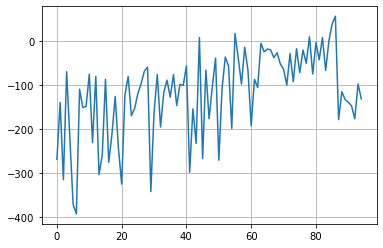

In [119]:
plt.figure(); plt.plot(total_rewards); plt.grid(b=True)

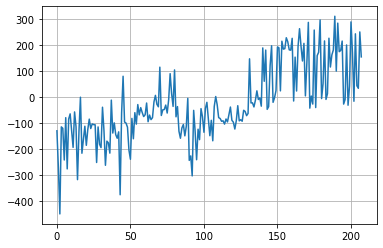

In [13]:
import matplotlib.pyplot as plt
plt.figure(); plt.plot(total_rewards); plt.grid(b=True)

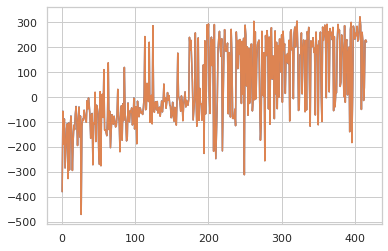

In [122]:

np.savetxt('rewards_beh_height_gamma6.txt',total_rewards,fmt='%d')

r = np.loadtxt('rewards_beh_height_gamma6.txt',dtype='int')
# r2 = np.loadtxt('rewards_50g_counter_adaptive_lunar.txt',dtype='int')
plt.plot(r)
plt.plot(total_rewards)

In [86]:
np.concatenate(adaptive)

array([-154.89166667, -153.03095238, -151.1702381 , ...,  150.26666667,
        154.06666667,  174.46666667])

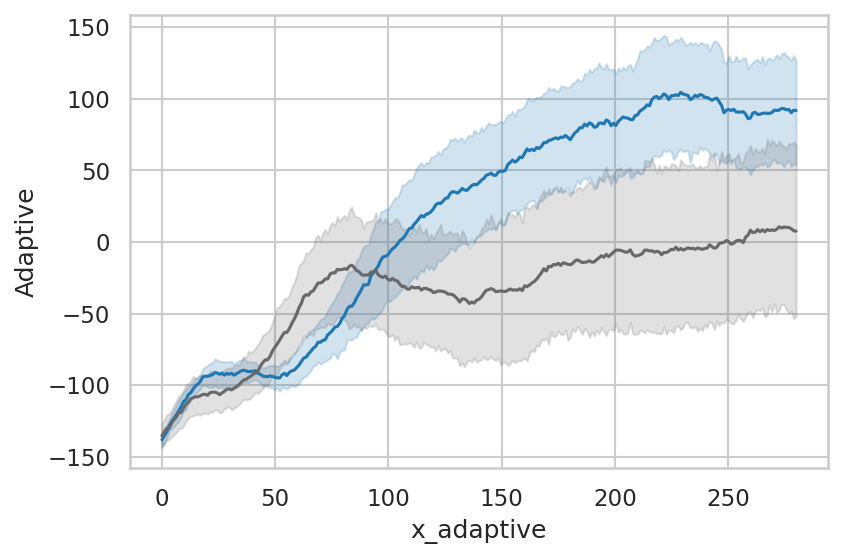

In [124]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
sns.set_theme(style="whitegrid")

max_frame=100000
max_plot=280
max_plot2=380
min_plot=15
smooth = 35

adaptive=[savgol_filter(np.loadtxt('rewards_beh_height_gamma.txt',dtype='int'),smooth,1)[min_plot:max_plot],
          savgol_filter(np.loadtxt('rewards_beh_height_gamma1.txt',dtype='int'),smooth,1)[min_plot:max_plot],
         savgol_filter(np.loadtxt('rewards_beh_height_gamma2.txt',dtype='int'),smooth,1)[min_plot:max_plot],
         savgol_filter(np.loadtxt('rewards_beh_height_gamma3.txt',dtype='int'),smooth,1)[min_plot:max_plot],
         savgol_filter(np.loadtxt('rewards_beh_height_gamma4.txt',dtype='int'),smooth,1)[min_plot:max_plot],
          savgol_filter(np.loadtxt('rewards_beh_height_gamma5.txt',dtype='int'),smooth,1)[min_plot:max_plot],
          savgol_filter(np.loadtxt('rewards_beh_height_gamma6.txt',dtype='int'),smooth,1)[min_plot:max_plot],
          savgol_filter(np.loadtxt('rewards_beh_height_gamma7.txt',dtype='int'),smooth,1)[min_plot:max_plot],
          savgol_filter(np.loadtxt('rewards_beh_height_gamma8.txt',dtype='int'),smooth,1)[min_plot:max_plot],
          savgol_filter(np.loadtxt('rewards_beh_height_gamma9.txt',dtype='int'),smooth,1)[min_plot:max_plot]
         ]

x_adaptive=[np.linspace(0,max_plot,len(adaptive[i])) for i in range(0,len(adaptive))]


uniform=[savgol_filter(np.loadtxt('rewards_beh_one_gamma.txt',dtype='int'),smooth,1)[min_plot:max_plot],
         savgol_filter(np.loadtxt('rewards_beh_one_gamma1.txt',dtype='int'),smooth,1)[min_plot:max_plot],
         savgol_filter(np.loadtxt('rewards_beh_one_gamma2.txt',dtype='int'),smooth,1)[min_plot:max_plot],
         savgol_filter(np.loadtxt('rewards_beh_one_gamma3.txt',dtype='int'),smooth,1)[min_plot:max_plot],
         savgol_filter(np.loadtxt('rewards_beh_one_gamma4.txt',dtype='int'),smooth,1)[min_plot:max_plot],
         savgol_filter(np.loadtxt('rewards_beh_one_gamma5.txt',dtype='int'),smooth,1)[min_plot:max_plot],
         savgol_filter(np.loadtxt('rewards_beh_one_gamma6.txt',dtype='int'),smooth,1)[min_plot:max_plot],
         savgol_filter(np.loadtxt('rewards_beh_one_gamma7.txt',dtype='int'),smooth,1)[min_plot:max_plot],
         savgol_filter(np.loadtxt('rewards_beh_one_gamma8.txt',dtype='int'),smooth,1)[min_plot:max_plot],
         savgol_filter(np.loadtxt('rewards_beh_one_gamma9.txt',dtype='int'),smooth,1)[min_plot:max_plot],
        ]
x_uniform=[np.linspace(0,max_plot,len(uniform[i])) for i in range(0,len(uniform))]



df= pd.DataFrame({"Adaptive" : np.concatenate(np.array(adaptive)),
                  "x_adaptive" : np.concatenate(np.array(x_adaptive)),
                 })
df2= pd.DataFrame({"Uniform" : np.concatenate(np.array(uniform)),
                  "x_uniform" : np.concatenate(np.array(x_uniform)),
                 })

plt.figure(dpi=150)
fig=sns.lineplot(x="x_adaptive", y="Adaptive", data=df,color='tab:blue',ci=95)
fig=sns.lineplot(x="x_uniform", y="Uniform", data=df2,color='dimgrey',ci=95)

plt.grid(b=True)

plt.savefig('demo.png', transparent=True)

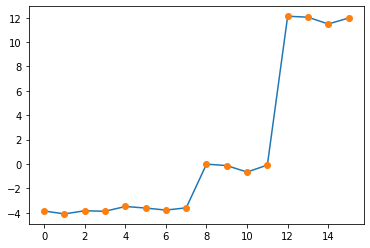

In [15]:
import matplotlib.pyplot as plt
state_a = np.float32(np.array([agent.state], copy=False))
state_v = torch.tensor(state_a).to(device)
q_vals_v = net(state_v)
plt.figure()
plt.plot(q_vals_v[0].detach().to('cpu'))
plt.plot(q_vals_v[0].detach().to('cpu'),'o')


In [12]:
GAMMAS

array([0.90483742, 0.95804824, 0.97309582, 0.99      ])

# Flexibility of state representations

In [2]:


import numpy as np
from mazelab import BaseMaze
from mazelab import Object
from mazelab import DeepMindColor as color


class Maze(BaseMaze):
    @property
    def size(self):
        return x.shape
    
    def make_objects(self):
        free = Object('free', 0, color.free, False, np.stack(np.where(x == 0), axis=1))
        obstacle = Object('obstacle', 1, color.obstacle, True, np.stack(np.where(x == 1), axis=1))
        agent = Object('agent', 2, color.agent, False, [])
        goal = Object('goal', 3, color.goal, False, [])
        return free, obstacle, agent, goal

In [3]:
from mazelab import BaseEnv
from mazelab import VonNeumannMotion

import gym
from gym.spaces import Box
from gym.spaces import Discrete


class Env(BaseEnv):
    def __init__(self):
        super().__init__()
        
        self.maze = Maze()
        self.motions = VonNeumannMotion()
        
        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))
        
    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        if valid:
            self.maze.objects.agent.positions = [new_position]
        
        if self._is_goal(new_position):
            reward = +1
            done = True
        elif not valid:
            reward = -1
            done = False
        else:
            reward = -0.01
            done = False
        return self.maze.to_value(), reward, done, {}
        
    def reset(self):
        self.maze.objects.agent.positions = start_idx
        self.maze.objects.goal.positions = goal_idx
        return self.maze.to_value()
    
    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable
    
    def _is_goal(self, position):
        out = False
        for pos in self.maze.objects.goal.positions:
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out
    
    def get_image(self):
        return self.maze.to_rgb()

In [4]:
env_name='RandomMaze-v0'
gym.envs.register(id=env_name, entry_point=Env, max_episode_steps=200)

0
epoch: 9999 	 loss: 0.000 	 return: -11.468 	 ep_len: 200.000


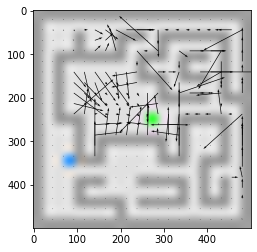

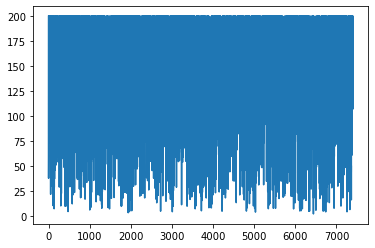

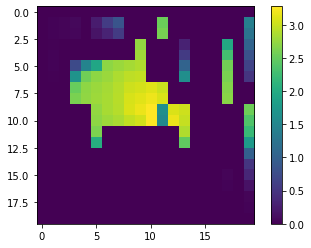

In [87]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.optim as optim
import numpy as np
import gym
from gym.spaces import Discrete, Box
from mazelab.generators import random_maze


iterations = 1
total_return = []
est0 , est1 , est2 , est3 , est4 , est5 , est6 = [] , [] , [] , [] , [] , [] , []
for iteration in range(iterations):
    size = 20
    env_name='RandomMaze-v0'
    lr=5e-4
#     lr=1e-2
    epochs=10000
    batch_size=1000
    render=False
    epsilon=0.1

    # make environment, check spaces, get obs / act dims
    x = random_maze(width=size, height=size, complexity=1, density=0.5)
    num_actions = 4
    env = gym.make('RandomMaze-v0')

#     L = env.maze.objects.free.positions
#     goal_idx = [L[np.random.randint(0, len(L))]]

    class policy_net(nn.Module):
        def __init__(self, input_shape, n_actions):
            super(policy_net, self).__init__()


            self.fc = nn.Sequential(

#                 nn.Linear(input_shape,  n_actions)
                
                nn.Linear(input_shape, 50),
                nn.ReLU(),
                nn.Linear(50, n_actions)
            )

        def forward(self, x):
            return self.fc(x)


    # make function to compute action distribution
    def get_policy(obs):
#         logits = logits_net(obs)
        logits = obs
        return Categorical(logits=logits)

    # make action selection function (outputs int actions, sampled from policy)
    def get_action(obs):
        return get_policy(obs).sample().item()

    # make loss function whose gradient, for the right data, is policy gradient
    def compute_loss(obs, act, weights):
        logp = get_policy(obs).log_prob(act)
        return -(logp * weights).mean()

    def reward_to_go(rews):
        n = len(rews)
        rtgs = np.zeros_like(rews)
        for i in reversed(range(n)):
            rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
        return rtgs

# 
    NUM_GAMMAS = 1

    taus=np.linspace(1,30,NUM_GAMMAS); #The taus are linearly separated (see next line)

#     GAMMAS=np.exp(-1/taus)

#     GAMMAS = np.linspace(0.8,0.99,NUM_GAMMAS)
#     GAMMAS = [0.6,0.9,0.995]
    GAMMAS = [0.99]
    sr = np.zeros((size,size,NUM_GAMMAS))
    Q = np.zeros((size,size,num_actions))
    Q_gamma = np.zeros((size,size,NUM_GAMMAS,num_actions))
    sr_x = np.zeros((size,size))
    sr_y = np.zeros((size,size))
    sr_x1 = np.zeros((size,size))
    sr_y1 = np.zeros((size,size))
    # make core of policy network
#     logits_net = policy_net(size*size + size*size+NUM_GAMMAS,num_actions).to('cuda')
#     logits_net = policy_net(4+num_actions,num_actions).to('cuda')
#     logits_net = policy_net((size)*(size),num_actions).to('cuda')
#     logits_net = policy_net(8+7*NUM_GAMMAS+3*num_actions*NUM_GAMMAS,num_actions).to('cuda')
#     logits_net = policy_net(4+3*num_actions*NUM_GAMMAS,num_actions).to('cuda')
#     logits_net = policy_net(4+num_actions*NUM_GAMMAS,num_actions).to('cuda')
    logits_net = policy_net(4+6*num_actions*NUM_GAMMAS,num_actions).to('cuda')

    # make optimizer
    optimizer = optim.Adam(logits_net.parameters(), lr=lr)

    # for training policy
    def train_one_epoch():
        # make some empty lists for logging.
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for R(tau) weighting in policy gradient
        batch_rets = []         # for measuring episode returns
        batch_lens = []         # for measuring episode lengths

        # reset episode-specific variables
        obs = env.reset()       # first obs comes from starting distribution
        done = False            # signal from environment that episode is over
        ep_rews = []            # list for rewards accrued throughout ep

        # render first episode of each epoch
        finished_rendering_this_epoch = False
        # collect experience by acting in the environment with current policy
        
        while True:
#             est0.append(np.copy(Q_gamma))
#             est1.append(np.copy(sr))
#             est2.append(np.copy(fut_a_v))
#             est3.append(np.copy(fut_a_v2))
#             est4.append(np.copy(fut_a_v3))
#             est5.append(np.copy(fut_a_v4))
#             est6.append(np.copy(fut_a_v5))   
            
            pos= env.maze.objects.agent.positions[0]*1
#             obs[obs==2]=0
#             obs[pos[0],pos[1]]=2
            r_pos = env.maze.objects.goal.positions[0]*1
#             obs = np.zeros((size,size))
#             obs[pos[0],pos[1]]=1.
#             obs2 = np.zeros((size,size))
#             obs2[r_pos[0],r_pos[1]]=1.
#             obs = np.array([obs,obs2])
#             obs = obs.flatten()

#             obs = np.array([pos[0],pos[1],r_pos[0],r_pos[1]])
#             obs = np.array([pos[0],pos[1]])
    #         obs = np.array([pos[0],pos[1],r_pos[0],r_pos[1],sr_x[pos[0],pos[1]],sr_y[pos[0],pos[1]]])

    #         obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:])]
#             obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(sr[pos[0],pos[1],:]),
#                    list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:]),list(sr_x1[pos[0],pos[1],:]),list(sr_y1[pos[0],pos[1],:])]
#             obs = [list(obs),list(sr[pos[0],pos[1],:])]
#             obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(Q_gamma[pos[0],pos[1],:,:].flatten())]
#             obs = [[pos[0],pos[1],r_pos[0],r_pos[1],in_x[pos[0],pos[1]],
#                     in_y[pos[0],pos[1]],in_x1[pos[0],pos[1]],
#                     in_y1[pos[0],pos[1]]],list(sr[pos[0],pos[1],:]),
#                    list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:]),
#                    list(fut_x[pos[0],pos[1],:]),list(fut_y[pos[0],pos[1],:]),
#                    list(sr_x1[pos[0],pos[1],:]),list(sr_y1[pos[0],pos[1],:]),
#                    list(Q_gamma[pos[0],pos[1],:,:].flatten()),
#                    list(fut_stx[pos[0],pos[1],:,:].flatten()),
#                    list(fut_sty[pos[0],pos[1],:,:].flatten())]
    
#             obs = [[(pos[0]-size/2)/25,(pos[1]-size/2)/25,(r_pos[0]-size/2)/25,(r_pos[1]-size/2)/25],
#                    list(Q_gamma[pos[0],pos[1],:,:].flatten()),
# #                    list(fut_st[pos[0],pos[1],:,:].flatten())]
#             obs = [[(pos[0]-size/2)/25,(pos[1]-size/2)/25,(r_pos[0]-size/2)/25,(r_pos[1]-size/2)/25],
#                    list(fut_a_v[pos[0],pos[1],:,:].flatten()),
#                    list(fut_a_v2[pos[0],pos[1],:,:].flatten()),
#                    list(fut_a_v3[pos[0],pos[1],:,:].flatten()),
#                    list(fut_a_v4[pos[0],pos[1],:,:].flatten()),
#                    list(fut_a_v5[pos[0],pos[1],:,:].flatten()),
#                    list(Q_gamma[pos[0],pos[1],:,:].flatten())]
#             obs = np.array([item for sublist in obs for item in sublist])
#             obs = obs.flatten()


            # save obs
            batch_obs.append(obs)
            
            # act in the environment
#             act = get_action(torch.as_tensor(np.abs(Q_gamma[pos[0],pos[1],-1,:]), dtype=torch.float32).to('cpu'))
            
#             act = get_action(torch.as_tensor(obs, dtype=torch.float32).to('cuda'))
            if any([i<5,(i)%change==0,(i-1)%change==0,(i-2)%change==0,(i-3)%change==0,(i-4)%change==0,(i-5)%change==0,(i-6)%change==0,
                    (i-7)%change==0,(i-8)%change==0,(i-9)%change==0,(i-10)%change==0 ,(i-11)%change==0]):
                act = np.random.choice([0,1,2,3])
            else:
                act = get_action(torch.as_tensor(np.abs(Q_gamma[pos[0],pos[1],-1,:]), dtype=torch.float32).to('cpu'))
#             act = np.random.choice([0,1,2,3])
            _, rew, done, _ = env.step(act)
       
            pos_next = env.maze.objects.agent.positions[0]*1
        
#             pos_next_r = pos*1

#             pos_next_r[0] = np.max([0,np.min([size-1,pos[0]+np.random.choice([1,0,-1])])])
#             pos_next_r[1] = np.max([0,np.min([size-1,pos[1]+np.random.choice([1,0,-1])])])

#             if np.sum(np.sum(L==np.array(pos_next_r),1)==2)==1:
#                 pos_next_r = pos_next_r
#             else:
#                 pos_next_r = pos*1

#             utility_x, utility_y , utility_x1, utility_y1 = 0 , 0 , 0 , 0
#             if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==0:
#                 utility_x = 0.1
#             if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==0:
#                 utility_y = 0.1
#             if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==0:
#                 utility_x1 = 0.1
#             if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==0:
#                 utility_y1 = 0.1   
                
#             if pos[0]==1:
#                 utility_x = 0.1
#             if pos[1]==1:
#                 utility_y = 0.1
#             if pos[0]==size-2:
#                 utility_x1 = 0.1
#             if pos[1]==size-2:
#                 utility_y1 = 0.1     
                
            utility = pos_next[0]==r_pos[0] and pos_next[1]==r_pos[1]
#             utility_x = (pos_next_r[0]-size/2)/20
#             utility_y = (pos_next_r[1]-size/2)/20
            
#             in_x[pos[0],pos[1]] = in_x[pos[0],pos[1]] + 1 * (utility_x
#                                                                  - in_x[pos[0],pos[1]])
#             in_y[pos[0],pos[1]] = in_y[pos[0],pos[1]] + 1 * (utility_y
#                                                                  - in_y[pos[0],pos[1]])
#             in_x1[pos[0],pos[1]] = in_x1[pos[0],pos[1]] + 1 * (utility_x1
#                                                                  - in_x1[pos[0],pos[1]])
#             in_y1[pos[0],pos[1]] = in_y1[pos[0],pos[1]] + 1 * (utility_y1
#                                                                  - in_y1[pos[0],pos[1]])  
                                    
#             probs = np.array(get_policy(torch.as_tensor(obs, dtype=torch.float32).to('cuda')).probs.detach().to('cpu'))
#             probs = probs+0.1
            probs = [0.25, 0.25, 0.25, 0.25]
            if True:
                for g in range(NUM_GAMMAS):
#                     sr[pos[0],pos[1],g] = sr[pos[0],pos[1],g] + 0.3 * (utility
#                                                                         + (1-utility) * GAMMAS[g] * sr[pos_next[0],pos_next[1],g] 
#                                                                        - sr[pos[0],pos[1],g])

    #                 sr_x[pos[0],pos[1],g] = sr_x[pos[0],pos[1],g] + 0.1 * (utility_x
    #                                                                     + np.abs(0.1-utility_x)*GAMMAS[g] * sr_x[pos_next[0],pos_next[1],g] 
    #                                                                        - sr_x[pos[0],pos[1],g])

    #                 sr_y[pos[0],pos[1],g] = sr_y[pos[0],pos[1],g] + 0.1 * (utility_y
    #                                                                     + np.abs(0.1-utility_y)*GAMMAS[g] * sr_y[pos_next[0],pos_next[1],g]
    #                                                                        - sr_y[pos[0],pos[1],g])

    #                 sr_x1[pos[0],pos[1],g] = sr_x1[pos[0],pos[1],g] + 0.1 * (utility_x1
    #                                                                     + np.abs(0.1-utility_x1)*GAMMAS[g] * sr_x1[pos_next[0],pos_next[1],g] 
    #                                                                          - sr_x1[pos[0],pos[1],g])

    #                 sr_y1[pos[0],pos[1],g] = sr_y1[pos[0],pos[1],g] + 0.1 * (utility_y1
    #                                                                     + np.abs(0.1-utility_y1)*GAMMAS[g] * sr_y1[pos_next[0],pos_next[1],g] 
    #                                                                          - sr_y1[pos[0],pos[1],g])

    #                 fut_x[pos[0],pos[1],g] = fut_x[pos[0],pos[1],g] + 0.1 * ((pos[0]-size/2)/20
    #                                                                     + GAMMAS[g] * fut_x[pos_next[0],pos_next[1],g] 
    #                                                                        - fut_x[pos[0],pos[1],g])

    #                 fut_y[pos[0],pos[1],g] = fut_y[pos[0],pos[1],g] + 0.1 * ((pos[1]-size/2)/20
    #                                                                     + GAMMAS[g] * fut_y[pos_next[0],pos_next[1],g]
    #                                                                        - fut_y[pos[0],pos[1],g])

    #                 fut_stx[pos[0],pos[1],g,act] = fut_stx[pos[0],pos[1],g,act] +  0.1 * ((pos[0])/20
    #                                                                     + GAMMAS[g] * fut_stx[pos_next_r[0],pos_next_r[1],g,act] 
    #                                                                        - fut_stx[pos[0],pos[1],g,act])


    #                 fut_sty[pos[0],pos[1],g,act] = fut_sty[pos[0],pos[1],g,act] +  0.1 * ((pos[1])/20
    #                                                                     + GAMMAS[g] * fut_sty[pos_next_r[0],pos_next_r[1],g,act] 
    #                                                                        - fut_sty[pos[0],pos[1],g,act])                


#                     if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==1:
#                         fut_st[pos[0],pos[1],g,0] = fut_st[pos[0],pos[1],g,0] + (1/probs[1]) * 0.2 * ((pos[0]+1-size/2)/20
#                                                                             + GAMMAS[g] * fut_st[pos[0]+1,pos[1],g,0] 
#                                                                                - fut_st[pos[0],pos[1],g,0])


#                     if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==1:
#                         fut_st[pos[0],pos[1],g,1] = fut_st[pos[0],pos[1],g,1] + (1/probs[0]) * 0.2 * ((pos[0]-1-size/2)/20
#                                                                             + GAMMAS[g] * fut_st[pos[0]-1,pos[1],g,1] 
#                                                                                - fut_st[pos[0],pos[1],g,1])


#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==1:
#                         fut_st[pos[0],pos[1],g,2] = fut_st[pos[0],pos[1],g,2] + (1/probs[2]) * 0.2 * ((pos[1]-1-size/2)/20
#                                                                             + GAMMAS[g] * fut_st[pos[0],pos[1]-1,g,2] 
#                                                                                - fut_st[pos[0],pos[1],g,2])

#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==1:
#                         fut_st[pos[0],pos[1],g,3] = fut_st[pos[0],pos[1],g,3] + (1/probs[3]) * 0.2 * ((pos[1]+1-size/2)/20
#                                                                             + GAMMAS[g] * fut_st[pos[0],pos[1]+1,g,3] 
#                                                                                - fut_st[pos[0],pos[1],g,3])





#                     theta_sr = 0.1; theta_sr1 = 0.1; 
#                     #LEVEL 1
#                     if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==1:
#                         ut = (sr[pos[0]+1,pos[1],g]>theta_sr1 and sr[pos[0],pos[1],g]<theta_sr1)*1
#                         fut_a_v[pos[0],pos[1],g,0] = fut_a_v[pos[0],pos[1],g,0] + (1/probs[0]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v[pos[0]+1,pos[1],g,0] 
#                                                                                - fut_a_v[pos[0],pos[1],g,0])

#                     if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==1:
#                         ut = (sr[pos[0]-1,pos[1],g]>theta_sr1 and sr[pos[0],pos[1],g]<theta_sr1)*1
#                         fut_a_v[pos[0],pos[1],g,1] = fut_a_v[pos[0],pos[1],g,1] + (1/probs[1]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v[pos[0]-1,pos[1],g,1] 
#                                                                                - fut_a_v[pos[0],pos[1],g,1])

#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==1:
#                         ut = (sr[pos[0],pos[1]-1,g]>theta_sr1 and sr[pos[0],pos[1],g]<theta_sr1)*1
#                         fut_a_v[pos[0],pos[1],g,2] = fut_a_v[pos[0],pos[1],g,2] + (1/probs[2]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v[pos[0],pos[1]-1,g,2] 
#                                                                                - fut_a_v[pos[0],pos[1],g,2])


#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==1:
#                         ut = (sr[pos[0],pos[1]+1,g]>theta_sr1 and sr[pos[0],pos[1],g]<theta_sr1)*1
#                         fut_a_v[pos[0],pos[1],g,3] = fut_a_v[pos[0],pos[1],g,3] + (1/probs[3]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v[pos[0],pos[1]+1,g,3] 
#                                                                                - fut_a_v[pos[0],pos[1],g,3])



#                     #LEVEL 2
#                     if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==1:
#                         ut = (any(fut_a_v[pos[0]+1,pos[1],g,2:4])>theta_sr and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr
#                               and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v2[pos[0],pos[1],g,0] = fut_a_v2[pos[0],pos[1],g,0] + (1/probs[0]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v2[pos[0]+1,pos[1],g,0] 
#                                                                                - fut_a_v2[pos[0],pos[1],g,0])

#                     if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==1:
#                         ut = (any(fut_a_v[pos[0]-1,pos[1],g,2:4])>theta_sr and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr
#                               and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v2[pos[0],pos[1],g,1] = fut_a_v2[pos[0],pos[1],g,1] + (1/probs[1]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v2[pos[0]-1,pos[1],g,1] 
#                                                                                - fut_a_v2[pos[0],pos[1],g,1])

#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==1:
#                         ut = (any(fut_a_v[pos[0],pos[1]-1,g,0:2])>theta_sr and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr
#                               and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v2[pos[0],pos[1],g,2] = fut_a_v2[pos[0],pos[1],g,2] + (1/probs[2]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v2[pos[0],pos[1]-1,g,2] 
#                                                                                 - fut_a_v2[pos[0],pos[1],g,2])

#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==1:
#                         ut = (any(fut_a_v[pos[0],pos[1]+1,g,0:2])>theta_sr and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr
#                               and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v2[pos[0],pos[1],g,3] = fut_a_v2[pos[0],pos[1],g,3] + (1/probs[3]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v2[pos[0],pos[1]+1,g,3] 
#                                                                                - fut_a_v2[pos[0],pos[1],g,3])



#                     #LEVEL 3
#                     if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==1:
#                         ut = (any(fut_a_v2[pos[0]+1,pos[1],g,2:4])>theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr
#                               and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v3[pos[0],pos[1],g,0] = fut_a_v3[pos[0],pos[1],g,0] + (1/probs[0]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v3[pos[0]+1,pos[1],g,0] 
#                                                                                - fut_a_v3[pos[0],pos[1],g,0])

#                     if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==1:
#                         ut = (any(fut_a_v2[pos[0]-1,pos[1],g,2:4])>theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr
#                               and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v3[pos[0],pos[1],g,1] = fut_a_v3[pos[0],pos[1],g,1] + (1/probs[1]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v3[pos[0]-1,pos[1],g,1] 
#                                                                                - fut_a_v3[pos[0],pos[1],g,1])

#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==1:
#                         ut = (any(fut_a_v2[pos[0],pos[1]-1,g,0:2])>theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr
#                               and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v3[pos[0],pos[1],g,2] = fut_a_v3[pos[0],pos[1],g,2] + (1/probs[2]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v3[pos[0],pos[1]-1,g,2] 
#                                                                                - fut_a_v3[pos[0],pos[1],g,2])

#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==1:
#                         ut = (any(fut_a_v2[pos[0],pos[1]+1,g,0:2])>theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr
#                               and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr  and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v3[pos[0],pos[1],g,3] = fut_a_v3[pos[0],pos[1],g,3] + (1/probs[3]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v3[pos[0],pos[1]+1,g,3] 
#                                                                                - fut_a_v3[pos[0],pos[1],g,3])


                        
#                     #LEVEL 4 
#                     if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==1:
#                         ut = (any(fut_a_v3[pos[0]+1,pos[1],g,2:4])>theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr
#                               and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v4[pos[0],pos[1],g,0] = fut_a_v4[pos[0],pos[1],g,0] + (1/probs[0]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v4[pos[0]+1,pos[1],g,0] 
#                                                                                - fut_a_v4[pos[0],pos[1],g,0])

#                     if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==1:
#                         ut = (any(fut_a_v3[pos[0]-1,pos[1],g,2:4])>theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr
#                               and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v4[pos[0],pos[1],g,1] = fut_a_v4[pos[0],pos[1],g,1] + (1/probs[1]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v4[pos[0]-1,pos[1],g,1] 
#                                                                                - fut_a_v4[pos[0],pos[1],g,1])

#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==1:
#                         ut = (any(fut_a_v3[pos[0],pos[1]-1,g,0:2])>theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr
#                               and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v4[pos[0],pos[1],g,2] = fut_a_v4[pos[0],pos[1],g,2] + (1/probs[2]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v4[pos[0],pos[1]-1,g,2] 
#                                                                                - fut_a_v4[pos[0],pos[1],g,2])

#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==1:
#                         ut = (any(fut_a_v3[pos[0],pos[1]+1,g,0:2])>theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr
#                               and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v4[pos[0],pos[1],g,3] = fut_a_v4[pos[0],pos[1],g,3] + (1/probs[3]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v4[pos[0],pos[1]+1,g,3] 
#                                                                                - fut_a_v4[pos[0],pos[1],g,3])
 




#                     #LEVEL 5
#                     if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==1:
#                         ut = (any(fut_a_v4[pos[0]+1,pos[1],g,2:4])>theta_sr and all(fut_a_v4[pos[0],pos[1],g,:])<theta_sr
#                                 and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v5[pos[0],pos[1],g,0] = fut_a_v5[pos[0],pos[1],g,0] + (1/probs[0]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v5[pos[0]+1,pos[1],g,0] 
#                                                                                - fut_a_v5[pos[0],pos[1],g,0])


#                     if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==1:
#                         ut = (any(fut_a_v4[pos[0]-1,pos[1],g,2:4])>theta_sr and all(fut_a_v4[pos[0],pos[1],g,:])<theta_sr
#                                and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v5[pos[0],pos[1],g,1] = fut_a_v5[pos[0],pos[1],g,1] + (1/probs[1]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v5[pos[0]-1,pos[1],g,1] 
#                                                                                - fut_a_v5[pos[0],pos[1],g,1])

#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==1:
#                         ut = (any(fut_a_v4[pos[0],pos[1]-1,g,0:2])>theta_sr and all(fut_a_v4[pos[0],pos[1],g,:])<theta_sr
#                                and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v5[pos[0],pos[1],g,2] = fut_a_v5[pos[0],pos[1],g,2] + (1/probs[2]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v5[pos[0],pos[1]-1,g,2] 
#                                                                                - fut_a_v5[pos[0],pos[1],g,2])

#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==1:
#                         ut = (any(fut_a_v4[pos[0],pos[1]+1,g,0:2])>theta_sr and all(fut_a_v4[pos[0],pos[1],g,:])<theta_sr
#                                 and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
#                         fut_a_v5[pos[0],pos[1],g,3] = fut_a_v5[pos[0],pos[1],g,3] + (1/probs[3]) * 0.2 * (ut
#                                                                             + (1 - ut) * GAMMAS[g] * fut_a_v5[pos[0],pos[1]+1,g,3] 
#                                                                                - fut_a_v5[pos[0],pos[1],g,3])
                        
#                     Q_gamma[pos[0],pos[1],g,act] = Q_gamma[pos[0],pos[1],g,act] + 0.1 * (utility + (1 - utility) * GAMMAS[g] * np.max(
#                                                                                 Q_gamma[pos_next[0],pos_next[1],g,:]) - Q_gamma[pos[0],pos[1],g,act])
        
                    if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==1:
                        Q_gamma[pos[0],pos[1],g,0] = Q_gamma[pos[0],pos[1],g,0] + 0.1 * (utility +  GAMMAS[g] * np.max(
                                                                                    Q_gamma[pos[0]-1,pos[1],g,:]) - Q_gamma[pos[0],pos[1],g,0] )
                                                                                         
                    if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==1:
                        Q_gamma[pos[0],pos[1],g,1] = Q_gamma[pos[0],pos[1],g,1] + 0.1 * (utility + GAMMAS[g] * np.max(
                                                                                    Q_gamma[pos[0]+1,pos[1],g,:]) - Q_gamma[pos[0],pos[1],g,1])
                                                                                         
                    if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==1:
                        Q_gamma[pos[0],pos[1],g,2] = Q_gamma[pos[0],pos[1],g,2] + 0.1 * (utility +GAMMAS[g] * np.max(
                                                                                    Q_gamma[pos[0],pos[1]-1,g,:]) - Q_gamma[pos[0],pos[1],g,2])
                                                                                         
                    if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==1:
                        Q_gamma[pos[0],pos[1],g,3] = Q_gamma[pos[0],pos[1],g,3] + 0.1 * (utility + GAMMAS[g] * np.max(
                                                                                    Q_gamma[pos[0],pos[1]+1,g,:]) - Q_gamma[pos[0],pos[1],g,3])

    #             if np.max(Q_gamma)>0:
    #                 Q_gamma[:,:,:,:] = 5*(Q_gamma[:,:,:,:]-np.min(Q_gamma[:,:,:,:]))/(
    #                     np.max(Q_gamma[:,:,:,:])-np.min(Q_gamma[:,:,:,:]))

    #                 sr[:,:,:] = (sr[:,:,:]-np.min(sr[:,:,:]))/(
    #                     np.max(sr[:,:,:])-np.min(sr[:,:,:]))

            
            if rew==1:
                rew=50
            if rew==-1:
                rew=-0.2
                
            # save action, reward
            batch_acts.append(act)
            ep_rews.append(rew)


            if done:
                if any([i==2, i==3, i==4, i==10, (i-2)%change==0,(i-3)%change==0,(i-4)%change==0,(i-10)%change==0,(i-11)%change==0]):
                    start_idx = [L[np.random.randint(0, len(L))]]
            
                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)
                
                # the weight for each logprob(a|s) is R(tau)
                batch_weights += list(reward_to_go(ep_rews))

                # reset episode-specific variables
    #             start_idx = [L[np.random.randint(0, len(L))]]
                obs, done, ep_rews = env.reset(), False, []


                # end experience loop if we have enough of it
                if len(batch_obs) > batch_size:
                    break

        # take a single policy gradient update step
        batch_loss = 0
#         if all([i>5,(i)%change!=0,(i-1)%change!=0 , (i-2)%change!=0 , (i-3)%change!=0 , (i-4)%change!=0 , (
#             i-5)%change!=0,(i-6)%change!=0 , (i-7)%change!=0 , (i-8)%change!=0 , (i-9)%change!=0 , (i-10)%change!=0 , (i-11)%change!=0]):
#             print(i)
#             optimizer.zero_grad()
#             batch_loss = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32).to('cuda'),
#                                       act=torch.as_tensor(batch_acts, dtype=torch.int32).to('cuda'),
#                                       weights=torch.as_tensor(batch_weights, dtype=torch.float32).to('cuda')
#                                       )
#             batch_loss.backward()
#             optimizer.step()
        return batch_loss, batch_rets, batch_lens

    total_reward = []
    # training loop

    for i in range(epochs):

        clear_output(wait=True)

        change = 50
        if i==0 or i%change==0:
#             sr = np.zeros((size,size,NUM_GAMMAS))
#             Q = np.zeros((size,size,num_actions))
            Q_gamma = np.zeros((size,size,NUM_GAMMAS,num_actions))
#             fut_a_v = np.zeros((size,size,NUM_GAMMAS,num_actions))
#             fut_a_v2 = np.zeros((size,size,NUM_GAMMAS,num_actions))
#             fut_a_v3 = np.zeros((size,size,NUM_GAMMAS,num_actions))
#             fut_a_v4 = np.zeros((size,size,NUM_GAMMAS,num_actions))
#             fut_a_v5 = np.zeros((size,size,NUM_GAMMAS,num_actions))
#             fut_st = np.zeros((size,size,NUM_GAMMAS,num_actions))
#             fut_stx = np.zeros((size,size,NUM_GAMMAS,num_actions))
#             fut_sty = np.zeros((size,size,NUM_GAMMAS,num_actions))
#             sr_x = np.zeros((size,size,NUM_GAMMAS))
#             sr_y = np.zeros((size,size,NUM_GAMMAS))
#             sr_x1 = np.zeros((size,size,NUM_GAMMAS))
#             sr_y1 = np.zeros((size,size,NUM_GAMMAS))
#             fut_x = np.zeros((size,size,NUM_GAMMAS))
#             fut_y = np.zeros((size,size,NUM_GAMMAS))
#             in_x = np.zeros((size,size))
#             in_y = np.zeros((size,size))
#             in_x1 = np.zeros((size,size))
#             in_y1 = np.zeros((size,size))
            x = random_maze(width=size, height=size, complexity=0.1, density=0.1)
            env = gym.make(env_name)
            L = env.maze.objects.free.positions
            goal_idx = [L[np.random.randint(0, len(L))]]
            start_idx = goal_idx
    #         start_idx = [L[np.random.randint(0, len(L))]]
    #         start_idx = [[1,1]]
    #         start_idx=goal_idx
        elif i==1 or (i-1)%change==0:
#             start_idx=[[np.min([size-1,goal_idx[0][0]+1]),np.min([size-1,goal_idx[0][1]])]]
            start_idx = goal_idx
        elif i==2 or (i-2)%change==0:
#             start_idx=[[np.min([size-1,goal_idx[0][0]]),np.min([size-1,goal_idx[0][1]+1])]]  
            start_idx = goal_idx
        elif i==3 or (i-3)%change==0:
#             start_idx=[[np.min([size-1,goal_idx[0][0]-1]),np.min([size-1,goal_idx[0][1]])]]
            sstart_idx = [L[np.random.randint(0, len(L))]]
        elif i==4 or (i-4)%change==0:
#             start_idx=[[np.min([size-1,goal_idx[0][0]]),np.min([size-1,goal_idx[0][1]-1])]]    
            start_idx = [L[np.random.randint(0, len(L))]]
        elif i==10 or (i-10)%change==0:
            start_idx = [L[np.random.randint(0, len(L))]]
        elif i==11 or (i-11)%change==0:
            start_idx = [L[np.random.randint(0, len(L))]]
        elif i==12 or (i-12)%change==0:
            start_idx = goal_idx
        else:
    #         start_idx = [[1,1]]
            start_idx = [L[np.random.randint(0, len(L))]]
        
#         start_idx = goal_idx
        
        obs = env.reset()
        batch_loss, batch_rets, batch_lens = train_one_epoch()
#         print(start_idx)
        print(iteration)
        print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
                (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))

        if i>5 and (i)%change!=0 and (i-1)%change!=0 and (i-2)%change!=0 and (i-3)%change!=0 and (i-4)%change!=0 and (
            i-5)%change!=0 and (i-6)%change!=0 and (i-7)%change!=0 and (i-8)%change!=0 and (i-9)%change!=0 and (i-10)%change!=0 and (i-11)%change!=0 and (i-12)%change!=0:
            total_reward.append(np.mean(batch_lens))

        x_grid,y_grid = np.meshgrid(np.linspace(20,480,size),np.linspace(20,480,size))

#         print(start_idx)
#         print(env.maze.objects.agent.positions[0])
        img = env.render('rgb_array')
        

        policy = np.zeros((size,size,4))
        for x_pos in range(size):
            for y_pos in range(size):
                pos = [x_pos,y_pos]
                r_pos = env.maze.objects.goal.positions[0]*1
#                 obs = env.reset()
#                 obs[obs==2]=0
#                 obs[x_pos,y_pos]=2
                
#                 obs[x_pos,y_pos]=2
                
#                 obs = np.array([x_pos,y_pos,r_pos[0],r_pos[1]])
#                 obs = np.array([x_pos,y_pos])
    #             obs = np.array([x_pos,y_pos,r_pos[0],r_pos[1],sr_x[x_pos,y_pos],sr_y[x_pos,y_pos]])
    #             obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:])]
#                 obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(sr[pos[0],pos[1],:]),
#                        list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:]),list(sr_x1[pos[0],pos[1],:]),list(sr_y1[pos[0],pos[1],:])]
#                 obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(sr[pos[0],pos[1],:]),list(Q_gamma[pos[0],pos[1],:,:].flatten())]
   
#                 obs = [[pos[0],pos[1],r_pos[0],r_pos[1],sr_x[pos[0],pos[1]],sr_y[pos[0],pos[1]],sr_x1[pos[0],pos[1]],sr_y1[pos[0],pos[1]]]
#                        ,list(sr[pos[0],pos[1],:]),list(Q_gamma[pos[0],pos[1],:,:].flatten())]
#                 obs = [[pos[0],pos[1],r_pos[0],r_pos[1],in_x[pos[0],pos[1]],
#                         in_y[pos[0],pos[1]],in_x1[pos[0],pos[1]],
#                         in_y1[pos[0],pos[1]]],list(sr[pos[0],pos[1],:]),
#                        list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:]),
#                        list(fut_x[pos[0],pos[1],:]),list(fut_y[pos[0],pos[1],:]),
#                        list(sr_x1[pos[0],pos[1],:]),list(sr_y1[pos[0],pos[1],:]),
#                        list(Q_gamma[pos[0],pos[1],:,:].flatten()),
#                        list(fut_stx[pos[0],pos[1],:,:].flatten()),
#                        list(fut_sty[pos[0],pos[1],:,:].flatten())]

#                 obs = [[pos[0]/50,pos[1]/50,r_pos[0]/50,r_pos[1]/50],
#                        list(Q_gamma[pos[0],pos[1],:,:].flatten()),
#                        list(fut_st[pos[0],pos[1],:,:].flatten())]
#                 obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],
#                        list(Q_gamma[pos[0],pos[1],:,:].flatten())]
#                 obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(Q_gamma[pos[0],pos[1],:,:].flatten())]
#                 obs = np.array([item for sublist in obs for item in sublist])
#                 pos = [x_pos,y_pos]
#                 obs = np.zeros((size,size))
#                 obs[pos[0],pos[1]]=1.
#                 obs2 = np.zeros((size,size))
#                 obs2[r_pos[0],r_pos[1]]=1.
#                 obs = np.array([obs,obs2])
#                 obs = obs.flatten()
# #                 obs = [list(obs),list(sr[pos[0],pos[1],:])]
#                 obs = [[(pos[0]-size/2)/25,(pos[1]-size/2)/25,(r_pos[0]-size/2)/25,(r_pos[1]-size/2)/25],
#                        list(fut_a_v[pos[0],pos[1],:,:].flatten()),
#                        list(fut_a_v2[pos[0],pos[1],:,:].flatten()),
#                        list(fut_a_v3[pos[0],pos[1],:,:].flatten()),
#                        list(fut_a_v4[pos[0],pos[1],:,:].flatten()),
#                        list(fut_a_v5[pos[0],pos[1],:,:].flatten()),
#                        list(Q_gamma[pos[0],pos[1],:,:].flatten())]
#                 obs = np.array([item for sublist in obs for item in sublist])
#                 obs = obs.flatten()
#                 policy[x_pos,y_pos,:]=np.array(get_policy(torch.as_tensor(obs, dtype=torch.float32).to('cuda')).probs.detach().to('cpu'))
                policy[x_pos,y_pos,:]=np.array(get_policy(torch.as_tensor(Q_gamma[pos[0],pos[1],-1,:], dtype=torch.float32).to('cpu')).probs.detach().to('cpu'))

        
        u = policy[:,:,3]-policy[:,:,2]
        v = policy[:,:,0]-policy[:,:,1]

#         plt.subplot(5,4,1)
#         plt.imshow(fut_a_v[:,:,-1,0]); plt.title('down'); plt.colorbar(); 
#         plt.subplot(5,4,2)
#         plt.imshow(fut_a_v[:,:,-1,1]); plt.title('up');plt.colorbar(); 
#         plt.subplot(5,4,3)
#         plt.imshow(fut_a_v[:,:,-1,2]); plt.title('left');plt.colorbar(); 
#         plt.subplot(5,4,4)
#         plt.imshow(fut_a_v[:,:,-1,3]); plt.title('right');plt.colorbar(); 
#         plt.subplot(5,4,5)
#         plt.imshow(fut_a_v2[:,:,-1,0]); plt.colorbar(); 
#         plt.subplot(5,4,6)
#         plt.imshow(fut_a_v2[:,:,-1,1]); plt.colorbar(); 
#         plt.subplot(5,4,7)
#         plt.imshow(fut_a_v2[:,:,-1,2]); plt.colorbar(); 
#         plt.subplot(5,4,8)
#         plt.imshow(fut_a_v2[:,:,-1,3]); plt.colorbar(); 
#         plt.subplot(5,4,9)
#         plt.imshow(fut_a_v3[:,:,-1,0]); plt.colorbar(); 
#         plt.subplot(5,4,10)
#         plt.imshow(fut_a_v3[:,:,-1,1]); plt.colorbar(); 
#         plt.subplot(5,4,11)
#         plt.imshow(fut_a_v3[:,:,-1,2]); plt.colorbar(); 
#         plt.subplot(5,4,12)
#         plt.imshow(fut_a_v3[:,:,-1,3]); plt.colorbar(); 
#         plt.subplot(5,4,13)
#         plt.imshow(fut_a_v4[:,:,-1,0]); plt.colorbar(); 
#         plt.subplot(5,4,14)
#         plt.imshow(fut_a_v4[:,:,-1,1]); plt.colorbar(); 
#         plt.subplot(5,4,15)
#         plt.imshow(fut_a_v4[:,:,-1,2]); plt.colorbar(); 
#         plt.subplot(5,4,16)
#         plt.imshow(fut_a_v4[:,:,-1,3]); plt.colorbar(); 
#         plt.subplot(5,4,17)
#         plt.imshow(fut_a_v5[:,:,-1,0]); plt.colorbar(); 
#         plt.subplot(5,4,18)
#         plt.imshow(fut_a_v5[:,:,-1,1]); plt.colorbar(); 
#         plt.subplot(5,4,19)
#         plt.imshow(fut_a_v5[:,:,-1,2]); plt.colorbar(); 
#         plt.subplot(5,4,20)
#         plt.imshow(fut_a_v5[:,:,-1,3]); plt.colorbar(); 
#         plt.show()
# 
#         plt.imshow(sr[:,:,-1]); plt.colorbar(); plt.show()
#         plt.subplot(5,3,1)
#         plt.imshow(sr[:,:,-1]); plt.colorbar();
#         plt.subplot(5,3,2)
#         plt.imshow(Q_gamma[:,:,-1,0]); plt.colorbar();
#         plt.subplot(5,3,3)
#         plt.imshow(Q_gamma[:,:,-1,1]); plt.colorbar();
#         plt.subplot(5,3,4)
#         plt.imshow(Q_gamma[:,:,-1,2]); plt.colorbar();
#         plt.subplot(5,3,5)
#         plt.imshow(Q_gamma[:,:,-1,3]); plt.colorbar();
#         plt.subplot(5,3,6)
#         plt.imshow(sr_x[:,:,-1]); plt.colorbar(); 
#         plt.subplot(5,3,7)
#         plt.imshow(sr_y[:,:,-1]); plt.colorbar(); 
#         plt.subplot(5,3,8)
#         plt.imshow(sr_x1[:,:,-1]); plt.colorbar(); 
#         plt.subplot(5,3,9)
#         plt.imshow(sr_y1[:,:,-1]); plt.colorbar(); 
#         plt.subplot(5,3,10)
#         plt.imshow(fut_x[:,:,-1]); plt.colorbar(); 
#         plt.subplot(5,3,11)
#         plt.imshow(fut_y[:,:,-1]); plt.colorbar(); 
#         plt.subplot(5,3,12)

#         plt.figure(dpi=200)
#         gamma=10
        
#         plt.subplot(2,4,1)
#         plt.imshow(fut_st[:,:,-1,0]); plt.colorbar(); plt.title('up')
#         plt.subplot(2,4,2)
#         plt.imshow(fut_st[:,:,-1,1]); plt.colorbar(); plt.title('down')
#         plt.subplot(2,4,3)
#         plt.imshow(fut_st[:,:,-1,2]); plt.colorbar(); plt.title('left')
#         plt.subplot(2,4,4)
#         plt.imshow(fut_st[:,:,-1,3]); plt.colorbar(); plt.title('right')
#         plt.show()
        plt.imshow(img); 
        plt.quiver(x_grid,y_grid,u,v); plt.show()
        plt.plot(total_reward);  plt.show()
        plt.imshow(Q_gamma[:,:,-1,1]); plt.colorbar(); plt.show()
    total_return.append(total_reward)


149
0
epoch: 149 	 loss: -7.800 	 return: -10.297 	 ep_len: 200.000


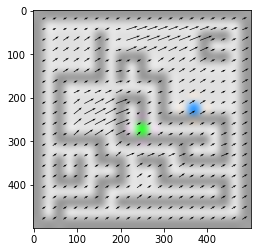

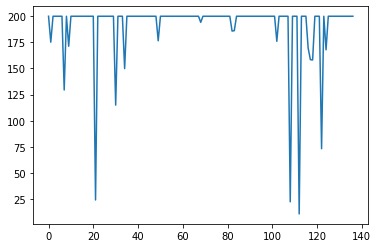

In [20]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.optim as optim
import numpy as np
import gym
from gym.spaces import Discrete, Box
from mazelab.generators import random_maze


iterations = 1
total_return = []
est0 , est1 , est2 , est3 , est4 , est5 , est6 = [] , [] , [] , [] , [] , [] , []
for iteration in range(iterations):
    size = 20
    env_name='RandomMaze-v0'
    lr=5e-4
#     lr=1e-2
    epochs=150
    batch_size=1000
    render=False
    epsilon=0.1

    # make environment, check spaces, get obs / act dims
    x = random_maze(width=size, height=size, complexity=1, density=0.5)
    num_actions = 4
    env = gym.make('RandomMaze-v0')

#     L = env.maze.objects.free.positions
#     goal_idx = [L[np.random.randint(0, len(L))]]

    class policy_net(nn.Module):
        def __init__(self, input_shape, n_actions):
            super(policy_net, self).__init__()


            self.fc = nn.Sequential(

#                 nn.Linear(input_shape,  n_actions)
                
                nn.Linear(input_shape, 50),
                nn.ReLU(),
                nn.Linear(50, n_actions)
            )

        def forward(self, x):
            return self.fc(x)


    # make function to compute action distribution
    def get_policy(obs):
        logits = logits_net(obs)
#         logits = obs
        return Categorical(logits=logits)

    # make action selection function (outputs int actions, sampled from policy)
    def get_action(obs):
        return get_policy(obs).sample().item()

    # make loss function whose gradient, for the right data, is policy gradient
    def compute_loss(obs, act, weights):
        logp = get_policy(obs).log_prob(act)
        return -(logp * weights).mean()

    def reward_to_go(rews):
        n = len(rews)
        rtgs = np.zeros_like(rews)
        for i in reversed(range(n)):
            rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
        return rtgs

# 
    NUM_GAMMAS = 1

    taus=np.linspace(1,30,NUM_GAMMAS); #The taus are linearly separated (see next line)

#     GAMMAS=np.exp(-1/taus)

#     GAMMAS = np.linspace(0.8,0.99,NUM_GAMMAS)
#     GAMMAS = [0.6,0.9,0.995]
    GAMMAS = [0.9]
    sr = np.zeros((size,size,NUM_GAMMAS))
    Q = np.zeros((size,size,num_actions))
    Q_gamma = np.zeros((size,size,NUM_GAMMAS,num_actions))
    sr_x = np.zeros((size,size))
    sr_y = np.zeros((size,size))
    sr_x1 = np.zeros((size,size))
    sr_y1 = np.zeros((size,size))
    # make core of policy network
#     logits_net = policy_net(size*size + size*size+NUM_GAMMAS,num_actions).to('cuda')
#     logits_net = policy_net(4+num_actions,num_actions).to('cuda')
#     logits_net = policy_net((size)*(size),num_actions).to('cuda')
#     logits_net = policy_net(8+7*NUM_GAMMAS+3*num_actions*NUM_GAMMAS,num_actions).to('cuda')
#     logits_net = policy_net(4+3*num_actions*NUM_GAMMAS,num_actions).to('cuda')
#     logits_net = policy_net(4+num_actions*NUM_GAMMAS,num_actions).to('cuda')
    logits_net = policy_net(4+6*num_actions*NUM_GAMMAS,num_actions).to('cuda')

    # make optimizer
    optimizer = optim.Adam(logits_net.parameters(), lr=lr)

    # for training policy
    def train_one_epoch():
        # make some empty lists for logging.
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for R(tau) weighting in policy gradient
        batch_rets = []         # for measuring episode returns
        batch_lens = []         # for measuring episode lengths

        # reset episode-specific variables
        obs = env.reset()       # first obs comes from starting distribution
        done = False            # signal from environment that episode is over
        ep_rews = []            # list for rewards accrued throughout ep

        # render first episode of each epoch
        finished_rendering_this_epoch = False
        # collect experience by acting in the environment with current policy
        
        while True:
            est0.append(np.copy(Q_gamma))
            est1.append(np.copy(sr))
            est2.append(np.copy(fut_a_v))
            est3.append(np.copy(fut_a_v2))
            est4.append(np.copy(fut_a_v3))
            est5.append(np.copy(fut_a_v4))
            est6.append(np.copy(fut_a_v5))   
            
            pos= env.maze.objects.agent.positions[0]*1
#             obs[obs==2]=0
#             obs[pos[0],pos[1]]=2
            r_pos = env.maze.objects.goal.positions[0]*1
#             obs = np.zeros((size,size))
#             obs[pos[0],pos[1]]=1.
#             obs2 = np.zeros((size,size))
#             obs2[r_pos[0],r_pos[1]]=1.
#             obs = np.array([obs,obs2])
#             obs = obs.flatten()

#             obs = np.array([pos[0],pos[1],r_pos[0],r_pos[1]])
#             obs = np.array([pos[0],pos[1]])
    #         obs = np.array([pos[0],pos[1],r_pos[0],r_pos[1],sr_x[pos[0],pos[1]],sr_y[pos[0],pos[1]]])

    #         obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:])]
#             obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(sr[pos[0],pos[1],:]),
#                    list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:]),list(sr_x1[pos[0],pos[1],:]),list(sr_y1[pos[0],pos[1],:])]
#             obs = [list(obs),list(sr[pos[0],pos[1],:])]
#             obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(Q_gamma[pos[0],pos[1],:,:].flatten())]
#             obs = [[pos[0],pos[1],r_pos[0],r_pos[1],in_x[pos[0],pos[1]],
#                     in_y[pos[0],pos[1]],in_x1[pos[0],pos[1]],
#                     in_y1[pos[0],pos[1]]],list(sr[pos[0],pos[1],:]),
#                    list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:]),
#                    list(fut_x[pos[0],pos[1],:]),list(fut_y[pos[0],pos[1],:]),
#                    list(sr_x1[pos[0],pos[1],:]),list(sr_y1[pos[0],pos[1],:]),
#                    list(Q_gamma[pos[0],pos[1],:,:].flatten()),
#                    list(fut_stx[pos[0],pos[1],:,:].flatten()),
#                    list(fut_sty[pos[0],pos[1],:,:].flatten())]
    
#             obs = [[(pos[0]-size/2)/25,(pos[1]-size/2)/25,(r_pos[0]-size/2)/25,(r_pos[1]-size/2)/25],
#                    list(Q_gamma[pos[0],pos[1],:,:].flatten()),
# #                    list(fut_st[pos[0],pos[1],:,:].flatten())]
            obs = [[(pos[0]-size/2)/25,(pos[1]-size/2)/25,(r_pos[0]-size/2)/25,(r_pos[1]-size/2)/25],
                   list(fut_a_v[pos[0],pos[1],:,:].flatten()),
                   list(fut_a_v2[pos[0],pos[1],:,:].flatten()),
                   list(fut_a_v3[pos[0],pos[1],:,:].flatten()),
                   list(fut_a_v4[pos[0],pos[1],:,:].flatten()),
                   list(fut_a_v5[pos[0],pos[1],:,:].flatten()),
                   list(Q_gamma[pos[0],pos[1],:,:].flatten())]
            obs = np.array([item for sublist in obs for item in sublist])
            obs = obs.flatten()


            # save obs
            batch_obs.append(obs)
            
            # act in the environment
#             act = get_action(torch.as_tensor(np.abs(Q_gamma[pos[0],pos[1],-1,:]), dtype=torch.float32).to('cpu'))
            
#             act = get_action(torch.as_tensor(obs, dtype=torch.float32).to('cuda'))
            if any([i<5,(i)%change==0,(i-1)%change==0,(i-2)%change==0,(i-3)%change==0,(i-4)%change==0,(i-5)%change==0,(i-6)%change==0,
                    (i-7)%change==0,(i-8)%change==0,(i-9)%change==0,(i-10)%change==0 ,(i-11)%change==0]):
                act = np.random.choice([0,1,2,3])
            else:
#                 act = get_action(torch.as_tensor(np.abs(Q_gamma[pos[0],pos[1],-1,:]), dtype=torch.float32).to('cpu'))
                act = get_action(torch.as_tensor(obs, dtype=torch.float32).to('cuda'))
            act = np.random.choice([0,1,2,3])
            _, rew, done, _ = env.step(act)
       
            pos_next = env.maze.objects.agent.positions[0]*1
        
#             pos_next_r = pos*1

#             pos_next_r[0] = np.max([0,np.min([size-1,pos[0]+np.random.choice([1,0,-1])])])
#             pos_next_r[1] = np.max([0,np.min([size-1,pos[1]+np.random.choice([1,0,-1])])])

#             if np.sum(np.sum(L==np.array(pos_next_r),1)==2)==1:
#                 pos_next_r = pos_next_r
#             else:
#                 pos_next_r = pos*1

#             utility_x, utility_y , utility_x1, utility_y1 = 0 , 0 , 0 , 0
#             if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==0:
#                 utility_x = 0.1
#             if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==0:
#                 utility_y = 0.1
#             if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==0:
#                 utility_x1 = 0.1
#             if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==0:
#                 utility_y1 = 0.1   
                
#             if pos[0]==1:
#                 utility_x = 0.1
#             if pos[1]==1:
#                 utility_y = 0.1
#             if pos[0]==size-2:
#                 utility_x1 = 0.1
#             if pos[1]==size-2:
#                 utility_y1 = 0.1     
                
            utility = pos_next[0]==r_pos[0] and pos_next[1]==r_pos[1]
#             utility_x = (pos_next_r[0]-size/2)/20
#             utility_y = (pos_next_r[1]-size/2)/20
            
#             in_x[pos[0],pos[1]] = in_x[pos[0],pos[1]] + 1 * (utility_x
#                                                                  - in_x[pos[0],pos[1]])
#             in_y[pos[0],pos[1]] = in_y[pos[0],pos[1]] + 1 * (utility_y
#                                                                  - in_y[pos[0],pos[1]])
#             in_x1[pos[0],pos[1]] = in_x1[pos[0],pos[1]] + 1 * (utility_x1
#                                                                  - in_x1[pos[0],pos[1]])
#             in_y1[pos[0],pos[1]] = in_y1[pos[0],pos[1]] + 1 * (utility_y1
#                                                                  - in_y1[pos[0],pos[1]])  
                                    
#             probs = np.array(get_policy(torch.as_tensor(obs, dtype=torch.float32).to('cuda')).probs.detach().to('cpu'))
#             probs = probs+0.1
            probs = [0.25, 0.25, 0.25, 0.25]
            if True:
                for g in range(NUM_GAMMAS):
                    sr[pos[0],pos[1],g] = sr[pos[0],pos[1],g] + 0.3 * (utility
                                                                        + (1-utility) * GAMMAS[g] * sr[pos_next[0],pos_next[1],g] 
                                                                       - sr[pos[0],pos[1],g])

    #                 sr_x[pos[0],pos[1],g] = sr_x[pos[0],pos[1],g] + 0.1 * (utility_x
    #                                                                     + np.abs(0.1-utility_x)*GAMMAS[g] * sr_x[pos_next[0],pos_next[1],g] 
    #                                                                        - sr_x[pos[0],pos[1],g])

    #                 sr_y[pos[0],pos[1],g] = sr_y[pos[0],pos[1],g] + 0.1 * (utility_y
    #                                                                     + np.abs(0.1-utility_y)*GAMMAS[g] * sr_y[pos_next[0],pos_next[1],g]
    #                                                                        - sr_y[pos[0],pos[1],g])

    #                 sr_x1[pos[0],pos[1],g] = sr_x1[pos[0],pos[1],g] + 0.1 * (utility_x1
    #                                                                     + np.abs(0.1-utility_x1)*GAMMAS[g] * sr_x1[pos_next[0],pos_next[1],g] 
    #                                                                          - sr_x1[pos[0],pos[1],g])

    #                 sr_y1[pos[0],pos[1],g] = sr_y1[pos[0],pos[1],g] + 0.1 * (utility_y1
    #                                                                     + np.abs(0.1-utility_y1)*GAMMAS[g] * sr_y1[pos_next[0],pos_next[1],g] 
    #                                                                          - sr_y1[pos[0],pos[1],g])

    #                 fut_x[pos[0],pos[1],g] = fut_x[pos[0],pos[1],g] + 0.1 * ((pos[0]-size/2)/20
    #                                                                     + GAMMAS[g] * fut_x[pos_next[0],pos_next[1],g] 
    #                                                                        - fut_x[pos[0],pos[1],g])

    #                 fut_y[pos[0],pos[1],g] = fut_y[pos[0],pos[1],g] + 0.1 * ((pos[1]-size/2)/20
    #                                                                     + GAMMAS[g] * fut_y[pos_next[0],pos_next[1],g]
    #                                                                        - fut_y[pos[0],pos[1],g])

    #                 fut_stx[pos[0],pos[1],g,act] = fut_stx[pos[0],pos[1],g,act] +  0.1 * ((pos[0])/20
    #                                                                     + GAMMAS[g] * fut_stx[pos_next_r[0],pos_next_r[1],g,act] 
    #                                                                        - fut_stx[pos[0],pos[1],g,act])


    #                 fut_sty[pos[0],pos[1],g,act] = fut_sty[pos[0],pos[1],g,act] +  0.1 * ((pos[1])/20
    #                                                                     + GAMMAS[g] * fut_sty[pos_next_r[0],pos_next_r[1],g,act] 
    #                                                                        - fut_sty[pos[0],pos[1],g,act])                


#                     if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==1:
#                         fut_st[pos[0],pos[1],g,0] = fut_st[pos[0],pos[1],g,0] + (1/probs[1]) * 0.2 * ((pos[0]+1-size/2)/20
#                                                                             + GAMMAS[g] * fut_st[pos[0]+1,pos[1],g,0] 
#                                                                                - fut_st[pos[0],pos[1],g,0])


#                     if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==1:
#                         fut_st[pos[0],pos[1],g,1] = fut_st[pos[0],pos[1],g,1] + (1/probs[0]) * 0.2 * ((pos[0]-1-size/2)/20
#                                                                             + GAMMAS[g] * fut_st[pos[0]-1,pos[1],g,1] 
#                                                                                - fut_st[pos[0],pos[1],g,1])


#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==1:
#                         fut_st[pos[0],pos[1],g,2] = fut_st[pos[0],pos[1],g,2] + (1/probs[2]) * 0.2 * ((pos[1]-1-size/2)/20
#                                                                             + GAMMAS[g] * fut_st[pos[0],pos[1]-1,g,2] 
#                                                                                - fut_st[pos[0],pos[1],g,2])

#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==1:
#                         fut_st[pos[0],pos[1],g,3] = fut_st[pos[0],pos[1],g,3] + (1/probs[3]) * 0.2 * ((pos[1]+1-size/2)/20
#                                                                             + GAMMAS[g] * fut_st[pos[0],pos[1]+1,g,3] 
#                                                                                - fut_st[pos[0],pos[1],g,3])





                    theta_sr = 0.1; theta_sr1 = 0.1; 
                    #LEVEL 1
                    if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==1:
                        ut = (sr[pos[0]+1,pos[1],g]>theta_sr1 and sr[pos[0],pos[1],g]<theta_sr1)*1
                        fut_a_v[pos[0],pos[1],g,0] = fut_a_v[pos[0],pos[1],g,0] + (1/probs[0]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v[pos[0]+1,pos[1],g,0] 
                                                                               - fut_a_v[pos[0],pos[1],g,0])

                    if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==1:
                        ut = (sr[pos[0]-1,pos[1],g]>theta_sr1 and sr[pos[0],pos[1],g]<theta_sr1)*1
                        fut_a_v[pos[0],pos[1],g,1] = fut_a_v[pos[0],pos[1],g,1] + (1/probs[1]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v[pos[0]-1,pos[1],g,1] 
                                                                               - fut_a_v[pos[0],pos[1],g,1])

                    if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==1:
                        ut = (sr[pos[0],pos[1]-1,g]>theta_sr1 and sr[pos[0],pos[1],g]<theta_sr1)*1
                        fut_a_v[pos[0],pos[1],g,2] = fut_a_v[pos[0],pos[1],g,2] + (1/probs[2]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v[pos[0],pos[1]-1,g,2] 
                                                                               - fut_a_v[pos[0],pos[1],g,2])


                    if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==1:
                        ut = (sr[pos[0],pos[1]+1,g]>theta_sr1 and sr[pos[0],pos[1],g]<theta_sr1)*1
                        fut_a_v[pos[0],pos[1],g,3] = fut_a_v[pos[0],pos[1],g,3] + (1/probs[3]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v[pos[0],pos[1]+1,g,3] 
                                                                               - fut_a_v[pos[0],pos[1],g,3])



                    #LEVEL 2
                    if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==1:
                        ut = (any(fut_a_v[pos[0]+1,pos[1],g,2:4])>theta_sr and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr
                              and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v2[pos[0],pos[1],g,0] = fut_a_v2[pos[0],pos[1],g,0] + (1/probs[0]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v2[pos[0]+1,pos[1],g,0] 
                                                                               - fut_a_v2[pos[0],pos[1],g,0])

                    if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==1:
                        ut = (any(fut_a_v[pos[0]-1,pos[1],g,2:4])>theta_sr and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr
                              and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v2[pos[0],pos[1],g,1] = fut_a_v2[pos[0],pos[1],g,1] + (1/probs[1]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v2[pos[0]-1,pos[1],g,1] 
                                                                               - fut_a_v2[pos[0],pos[1],g,1])

                    if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==1:
                        ut = (any(fut_a_v[pos[0],pos[1]-1,g,0:2])>theta_sr and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr
                              and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v2[pos[0],pos[1],g,2] = fut_a_v2[pos[0],pos[1],g,2] + (1/probs[2]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v2[pos[0],pos[1]-1,g,2] 
                                                                                - fut_a_v2[pos[0],pos[1],g,2])

                    if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==1:
                        ut = (any(fut_a_v[pos[0],pos[1]+1,g,0:2])>theta_sr and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr
                              and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v2[pos[0],pos[1],g,3] = fut_a_v2[pos[0],pos[1],g,3] + (1/probs[3]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v2[pos[0],pos[1]+1,g,3] 
                                                                               - fut_a_v2[pos[0],pos[1],g,3])



                    #LEVEL 3
                    if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==1:
                        ut = (any(fut_a_v2[pos[0]+1,pos[1],g,2:4])>theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr
                              and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v3[pos[0],pos[1],g,0] = fut_a_v3[pos[0],pos[1],g,0] + (1/probs[0]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v3[pos[0]+1,pos[1],g,0] 
                                                                               - fut_a_v3[pos[0],pos[1],g,0])

                    if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==1:
                        ut = (any(fut_a_v2[pos[0]-1,pos[1],g,2:4])>theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr
                              and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v3[pos[0],pos[1],g,1] = fut_a_v3[pos[0],pos[1],g,1] + (1/probs[1]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v3[pos[0]-1,pos[1],g,1] 
                                                                               - fut_a_v3[pos[0],pos[1],g,1])

                    if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==1:
                        ut = (any(fut_a_v2[pos[0],pos[1]-1,g,0:2])>theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr
                              and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v3[pos[0],pos[1],g,2] = fut_a_v3[pos[0],pos[1],g,2] + (1/probs[2]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v3[pos[0],pos[1]-1,g,2] 
                                                                               - fut_a_v3[pos[0],pos[1],g,2])

                    if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==1:
                        ut = (any(fut_a_v2[pos[0],pos[1]+1,g,0:2])>theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr
                              and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr  and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v3[pos[0],pos[1],g,3] = fut_a_v3[pos[0],pos[1],g,3] + (1/probs[3]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v3[pos[0],pos[1]+1,g,3] 
                                                                               - fut_a_v3[pos[0],pos[1],g,3])


                        
                    #LEVEL 4 
                    if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==1:
                        ut = (any(fut_a_v3[pos[0]+1,pos[1],g,2:4])>theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr
                              and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v4[pos[0],pos[1],g,0] = fut_a_v4[pos[0],pos[1],g,0] + (1/probs[0]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v4[pos[0]+1,pos[1],g,0] 
                                                                               - fut_a_v4[pos[0],pos[1],g,0])

                    if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==1:
                        ut = (any(fut_a_v3[pos[0]-1,pos[1],g,2:4])>theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr
                              and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v4[pos[0],pos[1],g,1] = fut_a_v4[pos[0],pos[1],g,1] + (1/probs[1]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v4[pos[0]-1,pos[1],g,1] 
                                                                               - fut_a_v4[pos[0],pos[1],g,1])

                    if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==1:
                        ut = (any(fut_a_v3[pos[0],pos[1]-1,g,0:2])>theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr
                              and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v4[pos[0],pos[1],g,2] = fut_a_v4[pos[0],pos[1],g,2] + (1/probs[2]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v4[pos[0],pos[1]-1,g,2] 
                                                                               - fut_a_v4[pos[0],pos[1],g,2])

                    if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==1:
                        ut = (any(fut_a_v3[pos[0],pos[1]+1,g,0:2])>theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr
                              and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v4[pos[0],pos[1],g,3] = fut_a_v4[pos[0],pos[1],g,3] + (1/probs[3]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v4[pos[0],pos[1]+1,g,3] 
                                                                               - fut_a_v4[pos[0],pos[1],g,3])
 




                    #LEVEL 5
                    if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==1:
                        ut = (any(fut_a_v4[pos[0]+1,pos[1],g,2:4])>theta_sr and all(fut_a_v4[pos[0],pos[1],g,:])<theta_sr
                                and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v5[pos[0],pos[1],g,0] = fut_a_v5[pos[0],pos[1],g,0] + (1/probs[0]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v5[pos[0]+1,pos[1],g,0] 
                                                                               - fut_a_v5[pos[0],pos[1],g,0])


                    if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==1:
                        ut = (any(fut_a_v4[pos[0]-1,pos[1],g,2:4])>theta_sr and all(fut_a_v4[pos[0],pos[1],g,:])<theta_sr
                               and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v5[pos[0],pos[1],g,1] = fut_a_v5[pos[0],pos[1],g,1] + (1/probs[1]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v5[pos[0]-1,pos[1],g,1] 
                                                                               - fut_a_v5[pos[0],pos[1],g,1])

                    if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==1:
                        ut = (any(fut_a_v4[pos[0],pos[1]-1,g,0:2])>theta_sr and all(fut_a_v4[pos[0],pos[1],g,:])<theta_sr
                               and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v5[pos[0],pos[1],g,2] = fut_a_v5[pos[0],pos[1],g,2] + (1/probs[2]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v5[pos[0],pos[1]-1,g,2] 
                                                                               - fut_a_v5[pos[0],pos[1],g,2])

                    if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==1:
                        ut = (any(fut_a_v4[pos[0],pos[1]+1,g,0:2])>theta_sr and all(fut_a_v4[pos[0],pos[1],g,:])<theta_sr
                                and all(fut_a_v[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v2[pos[0],pos[1],g,:])<theta_sr and all(fut_a_v3[pos[0],pos[1],g,:])<theta_sr and sr[pos[0],pos[1],g]<theta_sr)*1
                        fut_a_v5[pos[0],pos[1],g,3] = fut_a_v5[pos[0],pos[1],g,3] + (1/probs[3]) * 0.2 * (ut
                                                                            + (1 - ut) * GAMMAS[g] * fut_a_v5[pos[0],pos[1]+1,g,3] 
                                                                               - fut_a_v5[pos[0],pos[1],g,3])
                        
#                     Q_gamma[pos[0],pos[1],g,act] = Q_gamma[pos[0],pos[1],g,act] + 0.1 * (utility + (1 - utility) * GAMMAS[g] * np.max(
#                                                                                 Q_gamma[pos_next[0],pos_next[1],g,:]) - Q_gamma[pos[0],pos[1],g,act])
                    if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==1:
                        Q_gamma[pos[0],pos[1],g,0] = Q_gamma[pos[0],pos[1],g,0] + 0.2 * (utility +  GAMMAS[g] * np.max(
                                                                                    Q_gamma[pos[0]-1,pos[1],g,:]) - Q_gamma[pos[0],pos[1],g,0] )
                                                                                         
                    if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==1:
                        Q_gamma[pos[0],pos[1],g,1] = Q_gamma[pos[0],pos[1],g,1] + 0.2 * (utility + GAMMAS[g] * np.max(
                                                                                    Q_gamma[pos[0]+1,pos[1],g,:]) - Q_gamma[pos[0],pos[1],g,1])
                                                                                         
                    if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==1:
                        Q_gamma[pos[0],pos[1],g,2] = Q_gamma[pos[0],pos[1],g,2] + 0.2 * (utility + GAMMAS[g] * np.max(
                                                                                    Q_gamma[pos[0],pos[1]-1,g,:]) - Q_gamma[pos[0],pos[1],g,2])
                                                                                         
                    if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==1:
                        Q_gamma[pos[0],pos[1],g,3] = Q_gamma[pos[0],pos[1],g,3] + 0.2 * (utility + GAMMAS[g] * np.max(
                                                                                    Q_gamma[pos[0],pos[1]+1,g,:]) - Q_gamma[pos[0],pos[1],g,3])
                        
#                     if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==1:
#                         Q_gamma[pos[0],pos[1],g,0] = Q_gamma[pos[0],pos[1],g,0] + 0.1 * (utility +  GAMMAS[g] * np.max(
#                                                                                     Q_gamma[pos[0]-1,pos[1],g,:]) - Q_gamma[pos[0],pos[1],g,0] )
                                                                                         
#                     if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==1:
#                         Q_gamma[pos[0],pos[1],g,1] = Q_gamma[pos[0],pos[1],g,1] + 0.1 * (utility + GAMMAS[g] * np.max(
#                                                                                     Q_gamma[pos[0]+1,pos[1],g,:]) - Q_gamma[pos[0],pos[1],g,1])
                                                                                         
#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==1:
#                         Q_gamma[pos[0],pos[1],g,2] = Q_gamma[pos[0],pos[1],g,2] + 0.1 * (utility +GAMMAS[g] * np.max(
#                                                                                     Q_gamma[pos[0],pos[1]-1,g,:]) - Q_gamma[pos[0],pos[1],g,2])
                                                                                         
#                     if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==1:
#                         Q_gamma[pos[0],pos[1],g,3] = Q_gamma[pos[0],pos[1],g,3] + 0.1 * (utility + GAMMAS[g] * np.max(
#                                                                                     Q_gamma[pos[0],pos[1]+1,g,:]) - Q_gamma[pos[0],pos[1],g,3])

    #             if np.max(Q_gamma)>0:
    #                 Q_gamma[:,:,:,:] = 5*(Q_gamma[:,:,:,:]-np.min(Q_gamma[:,:,:,:]))/(
    #                     np.max(Q_gamma[:,:,:,:])-np.min(Q_gamma[:,:,:,:]))

    #                 sr[:,:,:] = (sr[:,:,:]-np.min(sr[:,:,:]))/(
    #                     np.max(sr[:,:,:])-np.min(sr[:,:,:]))

            
            if rew==1:
                rew=50
            if rew==-1:
                rew=-0.2
                
            # save action, reward
            batch_acts.append(act)
            ep_rews.append(rew)


            if done:
                if any([i==2, i==3, i==4, i==10, (i-2)%change==0,(i-3)%change==0,(i-4)%change==0,(i-10)%change==0,(i-11)%change==0]):
                    start_idx = [L[np.random.randint(0, len(L))]]
            
                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)
                
                # the weight for each logprob(a|s) is R(tau)
                batch_weights += list(reward_to_go(ep_rews))

                # reset episode-specific variables
    #             start_idx = [L[np.random.randint(0, len(L))]]
                obs, done, ep_rews = env.reset(), False, []


                # end experience loop if we have enough of it
                if len(batch_obs) > batch_size:
                    break

        # take a single policy gradient update step
        batch_loss = 0
        if all([i>5,(i)%change!=0,(i-1)%change!=0 , (i-2)%change!=0 , (i-3)%change!=0 , (i-4)%change!=0 , (
            i-5)%change!=0,(i-6)%change!=0 , (i-7)%change!=0 , (i-8)%change!=0 , (i-9)%change!=0 , (i-10)%change!=0 , (i-11)%change!=0]):
            print(i)
            optimizer.zero_grad()
            batch_loss = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32).to('cuda'),
                                      act=torch.as_tensor(batch_acts, dtype=torch.int32).to('cuda'),
                                      weights=torch.as_tensor(batch_weights, dtype=torch.float32).to('cuda')
                                      )
            batch_loss.backward()
            optimizer.step()
        return batch_loss, batch_rets, batch_lens

    total_reward = []
    # training loop

    for i in range(epochs):

        clear_output(wait=True)

        change = 200
        if i==0 or i%change==0:
            sr = np.zeros((size,size,NUM_GAMMAS))
#             Q = np.zeros((size,size,num_actions))
            Q_gamma = np.zeros((size,size,NUM_GAMMAS,num_actions))
            fut_a_v = np.zeros((size,size,NUM_GAMMAS,num_actions))
            fut_a_v2 = np.zeros((size,size,NUM_GAMMAS,num_actions))
            fut_a_v3 = np.zeros((size,size,NUM_GAMMAS,num_actions))
            fut_a_v4 = np.zeros((size,size,NUM_GAMMAS,num_actions))
            fut_a_v5 = np.zeros((size,size,NUM_GAMMAS,num_actions))
#             fut_st = np.zeros((size,size,NUM_GAMMAS,num_actions))
#             fut_stx = np.zeros((size,size,NUM_GAMMAS,num_actions))
#             fut_sty = np.zeros((size,size,NUM_GAMMAS,num_actions))
#             sr_x = np.zeros((size,size,NUM_GAMMAS))
#             sr_y = np.zeros((size,size,NUM_GAMMAS))
#             sr_x1 = np.zeros((size,size,NUM_GAMMAS))
#             sr_y1 = np.zeros((size,size,NUM_GAMMAS))
#             fut_x = np.zeros((size,size,NUM_GAMMAS))
#             fut_y = np.zeros((size,size,NUM_GAMMAS))
#             in_x = np.zeros((size,size))
#             in_y = np.zeros((size,size))
#             in_x1 = np.zeros((size,size))
#             in_y1 = np.zeros((size,size))
            x = random_maze(width=size, height=size, complexity=0.1, density=0.1)
            env = gym.make(env_name)
            L = env.maze.objects.free.positions
            goal_idx = [L[np.random.randint(0, len(L))]]
            start_idx = goal_idx
    #         start_idx = [L[np.random.randint(0, len(L))]]
    #         start_idx = [[1,1]]
    #         start_idx=goal_idx
        elif i==1 or (i-1)%change==0:
#             start_idx=[[np.min([size-1,goal_idx[0][0]+1]),np.min([size-1,goal_idx[0][1]])]]
            start_idx = goal_idx
        elif i==2 or (i-2)%change==0:
#             start_idx=[[np.min([size-1,goal_idx[0][0]]),np.min([size-1,goal_idx[0][1]+1])]]  
            start_idx = goal_idx
        elif i==3 or (i-3)%change==0:
#             start_idx=[[np.min([size-1,goal_idx[0][0]-1]),np.min([size-1,goal_idx[0][1]])]]
            sstart_idx = [L[np.random.randint(0, len(L))]]
        elif i==4 or (i-4)%change==0:
#             start_idx=[[np.min([size-1,goal_idx[0][0]]),np.min([size-1,goal_idx[0][1]-1])]]    
            start_idx = [L[np.random.randint(0, len(L))]]
        elif i==10 or (i-10)%change==0:
            start_idx = [L[np.random.randint(0, len(L))]]
        elif i==11 or (i-11)%change==0:
            start_idx = [L[np.random.randint(0, len(L))]]
        elif i==12 or (i-12)%change==0:
            start_idx = goal_idx
        else:
    #         start_idx = [[1,1]]
            start_idx = [L[np.random.randint(0, len(L))]]
        
#         start_idx = goal_idx
        
        obs = env.reset()
        batch_loss, batch_rets, batch_lens = train_one_epoch()
#         print(start_idx)
        print(iteration)
        print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
                (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))

        if i>5 and (i)%change!=0 and (i-1)%change!=0 and (i-2)%change!=0 and (i-3)%change!=0 and (i-4)%change!=0 and (
            i-5)%change!=0 and (i-6)%change!=0 and (i-7)%change!=0 and (i-8)%change!=0 and (i-9)%change!=0 and (i-10)%change!=0 and (i-11)%change!=0 and (i-12)%change!=0:
            total_reward.append(np.mean(batch_lens))

        x_grid,y_grid = np.meshgrid(np.linspace(20,480,size),np.linspace(20,480,size))

#         print(start_idx)
#         print(env.maze.objects.agent.positions[0])
        img = env.render('rgb_array')
        

        policy = np.zeros((size,size,4))
        for x_pos in range(size):
            for y_pos in range(size):
                pos = [x_pos,y_pos]
                r_pos = env.maze.objects.goal.positions[0]*1
#                 obs = env.reset()
#                 obs[obs==2]=0
#                 obs[x_pos,y_pos]=2
                
#                 obs[x_pos,y_pos]=2
                
#                 obs = np.array([x_pos,y_pos,r_pos[0],r_pos[1]])
#                 obs = np.array([x_pos,y_pos])
    #             obs = np.array([x_pos,y_pos,r_pos[0],r_pos[1],sr_x[x_pos,y_pos],sr_y[x_pos,y_pos]])
    #             obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:])]
#                 obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(sr[pos[0],pos[1],:]),
#                        list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:]),list(sr_x1[pos[0],pos[1],:]),list(sr_y1[pos[0],pos[1],:])]
#                 obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(sr[pos[0],pos[1],:]),list(Q_gamma[pos[0],pos[1],:,:].flatten())]
   
#                 obs = [[pos[0],pos[1],r_pos[0],r_pos[1],sr_x[pos[0],pos[1]],sr_y[pos[0],pos[1]],sr_x1[pos[0],pos[1]],sr_y1[pos[0],pos[1]]]
#                        ,list(sr[pos[0],pos[1],:]),list(Q_gamma[pos[0],pos[1],:,:].flatten())]
#                 obs = [[pos[0],pos[1],r_pos[0],r_pos[1],in_x[pos[0],pos[1]],
#                         in_y[pos[0],pos[1]],in_x1[pos[0],pos[1]],
#                         in_y1[pos[0],pos[1]]],list(sr[pos[0],pos[1],:]),
#                        list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:]),
#                        list(fut_x[pos[0],pos[1],:]),list(fut_y[pos[0],pos[1],:]),
#                        list(sr_x1[pos[0],pos[1],:]),list(sr_y1[pos[0],pos[1],:]),
#                        list(Q_gamma[pos[0],pos[1],:,:].flatten()),
#                        list(fut_stx[pos[0],pos[1],:,:].flatten()),
#                        list(fut_sty[pos[0],pos[1],:,:].flatten())]

#                 obs = [[pos[0]/50,pos[1]/50,r_pos[0]/50,r_pos[1]/50],
#                        list(Q_gamma[pos[0],pos[1],:,:].flatten()),
#                        list(fut_st[pos[0],pos[1],:,:].flatten())]
#                 obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],
#                        list(Q_gamma[pos[0],pos[1],:,:].flatten())]
#                 obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(Q_gamma[pos[0],pos[1],:,:].flatten())]
#                 obs = np.array([item for sublist in obs for item in sublist])
#                 pos = [x_pos,y_pos]
#                 obs = np.zeros((size,size))
#                 obs[pos[0],pos[1]]=1.
#                 obs2 = np.zeros((size,size))
#                 obs2[r_pos[0],r_pos[1]]=1.
#                 obs = np.array([obs,obs2])
#                 obs = obs.flatten()
# #                 obs = [list(obs),list(sr[pos[0],pos[1],:])]
                obs = [[(pos[0]-size/2)/25,(pos[1]-size/2)/25,(r_pos[0]-size/2)/25,(r_pos[1]-size/2)/25],
                       list(fut_a_v[pos[0],pos[1],:,:].flatten()),
                       list(fut_a_v2[pos[0],pos[1],:,:].flatten()),
                       list(fut_a_v3[pos[0],pos[1],:,:].flatten()),
                       list(fut_a_v4[pos[0],pos[1],:,:].flatten()),
                       list(fut_a_v5[pos[0],pos[1],:,:].flatten()),
                       list(Q_gamma[pos[0],pos[1],:,:].flatten())]
                obs = np.array([item for sublist in obs for item in sublist])
                obs = obs.flatten()
                policy[x_pos,y_pos,:]=np.array(get_policy(torch.as_tensor(obs, dtype=torch.float32).to('cuda')).probs.detach().to('cpu'))
#                 policy[x_pos,y_pos,:]=np.array(get_policy(torch.as_tensor(Q_gamma[pos[0],pos[1],-1,:], dtype=torch.float32).to('cpu')).probs.detach().to('cpu'))

        
        u = policy[:,:,3]-policy[:,:,2]
        v = policy[:,:,0]-policy[:,:,1]

#         plt.subplot(5,4,1)
#         plt.imshow(fut_a_v[:,:,-1,0]); plt.title('down'); plt.colorbar(); 
#         plt.subplot(5,4,2)
#         plt.imshow(fut_a_v[:,:,-1,1]); plt.title('up');plt.colorbar(); 
#         plt.subplot(5,4,3)
#         plt.imshow(fut_a_v[:,:,-1,2]); plt.title('left');plt.colorbar(); 
#         plt.subplot(5,4,4)
#         plt.imshow(fut_a_v[:,:,-1,3]); plt.title('right');plt.colorbar(); 
#         plt.subplot(5,4,5)
#         plt.imshow(fut_a_v2[:,:,-1,0]); plt.colorbar(); 
#         plt.subplot(5,4,6)
#         plt.imshow(fut_a_v2[:,:,-1,1]); plt.colorbar(); 
#         plt.subplot(5,4,7)
#         plt.imshow(fut_a_v2[:,:,-1,2]); plt.colorbar(); 
#         plt.subplot(5,4,8)
#         plt.imshow(fut_a_v2[:,:,-1,3]); plt.colorbar(); 
#         plt.subplot(5,4,9)
#         plt.imshow(fut_a_v3[:,:,-1,0]); plt.colorbar(); 
#         plt.subplot(5,4,10)
#         plt.imshow(fut_a_v3[:,:,-1,1]); plt.colorbar(); 
#         plt.subplot(5,4,11)
#         plt.imshow(fut_a_v3[:,:,-1,2]); plt.colorbar(); 
#         plt.subplot(5,4,12)
#         plt.imshow(fut_a_v3[:,:,-1,3]); plt.colorbar(); 
#         plt.subplot(5,4,13)
#         plt.imshow(fut_a_v4[:,:,-1,0]); plt.colorbar(); 
#         plt.subplot(5,4,14)
#         plt.imshow(fut_a_v4[:,:,-1,1]); plt.colorbar(); 
#         plt.subplot(5,4,15)
#         plt.imshow(fut_a_v4[:,:,-1,2]); plt.colorbar(); 
#         plt.subplot(5,4,16)
#         plt.imshow(fut_a_v4[:,:,-1,3]); plt.colorbar(); 
#         plt.subplot(5,4,17)
#         plt.imshow(fut_a_v5[:,:,-1,0]); plt.colorbar(); 
#         plt.subplot(5,4,18)
#         plt.imshow(fut_a_v5[:,:,-1,1]); plt.colorbar(); 
#         plt.subplot(5,4,19)
#         plt.imshow(fut_a_v5[:,:,-1,2]); plt.colorbar(); 
#         plt.subplot(5,4,20)
#         plt.imshow(fut_a_v5[:,:,-1,3]); plt.colorbar(); 
#         plt.show()

#         plt.imshow(sr[:,:,-1]); plt.colorbar(); plt.show()
#         plt.subplot(5,3,1)
#         plt.imshow(sr[:,:,-1]); plt.colorbar();
#         plt.subplot(5,3,2)
#         plt.imshow(Q_gamma[:,:,-1,0]); plt.colorbar();
#         plt.subplot(5,3,3)
#         plt.imshow(Q_gamma[:,:,-1,1]); plt.colorbar();
#         plt.subplot(5,3,4)
#         plt.imshow(Q_gamma[:,:,-1,2]); plt.colorbar();
#         plt.subplot(5,3,5)
#         plt.imshow(Q_gamma[:,:,-1,3]); plt.colorbar();
#         plt.subplot(5,3,6)
#         plt.imshow(sr_x[:,:,-1]); plt.colorbar(); 
#         plt.subplot(5,3,7)
#         plt.imshow(sr_y[:,:,-1]); plt.colorbar(); 
#         plt.subplot(5,3,8)
#         plt.imshow(sr_x1[:,:,-1]); plt.colorbar(); 
#         plt.subplot(5,3,9)
#         plt.imshow(sr_y1[:,:,-1]); plt.colorbar(); 
#         plt.subplot(5,3,10)
#         plt.imshow(fut_x[:,:,-1]); plt.colorbar(); 
#         plt.subplot(5,3,11)
#         plt.imshow(fut_y[:,:,-1]); plt.colorbar(); 
#         plt.subplot(5,3,12)
#         plt.figure(dpi=200)
#         gamma=10
        
#         plt.subplot(2,4,1)
#         plt.imshow(fut_st[:,:,-1,0]); plt.colorbar(); plt.title('up')
#         plt.subplot(2,4,2)
#         plt.imshow(fut_st[:,:,-1,1]); plt.colorbar(); plt.title('down')
#         plt.subplot(2,4,3)
#         plt.imshow(fut_st[:,:,-1,2]); plt.colorbar(); plt.title('left')
#         plt.subplot(2,4,4)
#         plt.imshow(fut_st[:,:,-1,3]); plt.colorbar(); plt.title('right')
#         plt.show()
        plt.figure()
        plt.imshow(img); 
        plt.quiver(x_grid,y_grid,u,v); 
        plt.figure()
        plt.plot(total_reward);  plt.show()
#         plt.imshow(Q_gamma[:,:,-1,1]); plt.colorbar(); plt.show()
    total_return.append(total_reward)


In [11]:
np.savetxt('mazebig_comp_g09.txt',total_reward,fmt='%d')

In [68]:
np.shape(np.argmax(v3[i,:,:,-1,:],axis=2))

(20, 20)

In [70]:
np.mean(np.argmax(v3[i,:,:,-1,:],axis=2)==np.argmax(v3_final,axis=2))

1.0

In [28]:
x

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,

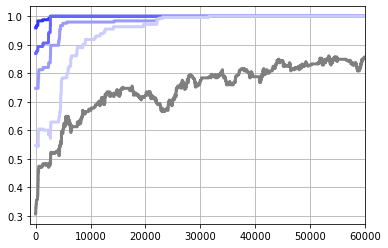

In [31]:
v0 = np.array(est0)
v2 = np.array(est2)
v3 = np.array(est3)
v4 = np.array(est4)
v5 = np.array(est5)
v6 = np.array(est6)

v0_final = v0[-1,:,:,-1,:]
v2_final = v2[-1,:,:,-1,:]
v3_final = v3[-1,:,:,-1,:]
v4_final = v4[-1,:,:,-1,:]
v5_final = v5[-1,:,:,-1,:]
v6_final = v6[-1,:,:,-1,:]

covered = []
theta = 0.05
theta2 = 0.01
for i in range(len(v3)):
    d = np.argmax(v3[i,:,:,-1,:],axis=2)==np.argmax(v3_final,axis=2)
    conv = np.mean(d[x[0:20,0:20]==0])
    covered.append(conv)
plt.plot(covered,linewidth=3,color=[0.2,0.2,1])
covered = []
for i in range(len(v4)):
    d = np.argmax(v4[i,:,:,-1,:],axis=2)==np.argmax(v4_final,axis=2)
    conv = np.mean(d[x[0:20,0:20]==0])
    covered.append(conv)
plt.plot(covered,linewidth=3,color=[0.4,0.4,1])
covered = []
for i in range(len(v5)):
    d = np.argmax(v5[i,:,:,-1,:],axis=2)==np.argmax(v5_final,axis=2)
    conv = np.mean(d[x[0:20,0:20]==0])
    covered.append(conv)
plt.plot(covered,linewidth=3,color=[0.6,0.6,1])
covered = []
for i in range(len(v6)):
    d = np.argmax(v6[i,:,:,-1,:],axis=2)==np.argmax(v6_final,axis=2)
    conv = np.mean(d[x[0:20,0:20]==0])
    covered.append(conv)
plt.plot(covered,linewidth=3,color=[0.8,0.8,1])

covered = []

for i in range(len(v2)):
    d = np.argmax(v0[i,:,:,-1,:],axis=2)==np.argmax(v0_final,axis=2)
    conv = np.mean(d[x[0:20,0:20]==0])
    covered.append(conv)

plt.plot(covered,color='tab:gray',linewidth=3)
plt.grid(b=True)
plt.xlim([-1000,6e4])
plt.savefig('demo.png', transparent=True)

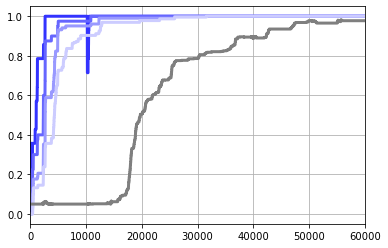

In [32]:
v0 = np.array(est0)
v2 = np.array(est2)
v3 = np.array(est3)
v4 = np.array(est4)
v5 = np.array(est5)
v6 = np.array(est6)

v0_final = v0[-1,:,:,-1,:]
v2_final = v2[-1,:,:,-1,:]
v3_final = v3[-1,:,:,-1,:]
v4_final = v4[-1,:,:,-1,:]
v5_final = v5[-1,:,:,-1,:]
v6_final = v6[-1,:,:,-1,:]

covered = []
theta = 0.0
theta2 = 0.1
for i in range(len(v3)):
    
    d = (np.abs(v3[i,:,:,-1,:]-v3_final)<theta2)*1
    conv = np.mean(d[v3_final>theta])
    covered.append(conv)
plt.plot(covered,linewidth=3,color=[0.2,0.2,1])
covered = []
for i in range(len(v4)):
    
    d = (np.abs(v4[i,:,:,-1,:]-v4_final)<theta2)*1
    conv = np.mean(d[v4_final>theta])
    covered.append(conv)
plt.plot(covered,linewidth=3,color=[0.4,0.4,1])
covered = []
for i in range(len(v5)):
    
    d = (np.abs(v5[i,:,:,-1,:]-v5_final)<theta2)*1
    conv = np.mean(d[v5_final>theta])
    covered.append(conv)
plt.plot(covered,linewidth=3,color=[0.6,0.6,1])
covered = []
for i in range(len(v6)):
    
    d = (np.abs(v6[i,:,:,-1,:]-v6_final)<theta2)*1
    conv = np.mean(d[v6_final>theta])
    covered.append(conv)
plt.plot(covered,linewidth=3,color=[0.8,0.8,1])

covered = []

for i in range(len(v2)):
    d = (np.abs(v0[i,:,:,-1,:]-v0_final)<theta2)*1
    conv = np.mean(d[v0_final>theta])
    covered.append(conv)

plt.plot(covered,color='tab:gray',linewidth=3)
plt.xlim([0,6e4])
plt.grid(b=True)
plt.savefig('demo.png', transparent=True)

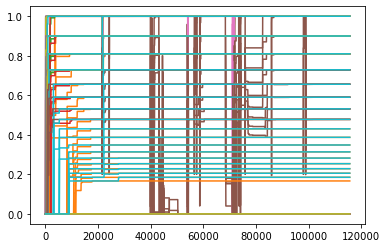

In [61]:
v = np.array(est3)
for i in range(20):
    plt.plot(v[:,:,i,-1,2])

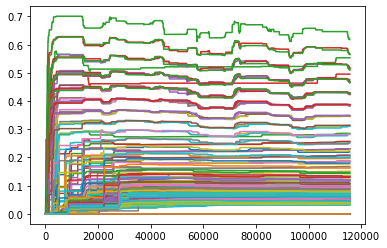

In [62]:
plt.figure()
v = np.array(est0)
for i in range(20):    
    plt.plot(v[:,i,:,-1,2])
plt.savefig('demo.png', transparent=True)

In [6]:
##### from scipy import linalg
range_g, length_x, length_y = GAMMAS, size, size

alpha_reg=1

K=15
delta_t=1
A=np.zeros((len(range_g),K))
for i_g in range(0,len(range_g)):
    for i_t in range(0,K):
        A[i_g,i_t]=range_g[i_g]**(i_t*delta_t)

U, lam, Ve = linalg.svd(A)

X,Y=np.meshgrid(np.linspace(0,length_x,length_x),np.linspace(0,length_y,length_y))
# Z=V_dist[:,:,:]*1
Z = fut_stx[:,:,:,0]*1

tau_space=np.zeros((K,length_x,length_y))
for x in range(0,length_x):
    for y in range(0,length_y):
        term=np.zeros((1,K))
        for i in range(0,len(lam)):
            fi=lam[i]**2/(alpha_reg**2+lam[i]**2)
            new=fi*(((U[:,i]@Z[x,y,:])*Ve[i,:] )/lam[i])
            term=term+new
        tau_space[:,x,y]=term

plt.imshow(tau_space[7,:,:]); plt.colorbar()
plt.clim([0,0.1])
# plt.plot(tau_space[:,5,5])

NameError: name 'linalg' is not defined

In [ ]:
from scipy.signal import savgol_filter
plt.figure; plt.plot(savgol_filter(np.array(total_reward),201,1).T)

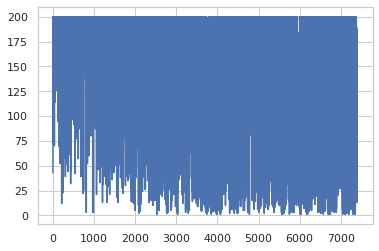

In [91]:
plt.plot(r16)

<ipython-input-93-08d5988e5802>:28: UserWarning: loadtxt: Empty input file: "mazebig_xyrmgqmgav5l.txt"
  r17 = np.array(np.loadtxt('mazebig_xyrmgqmgav5l.txt',dtype='int')).T


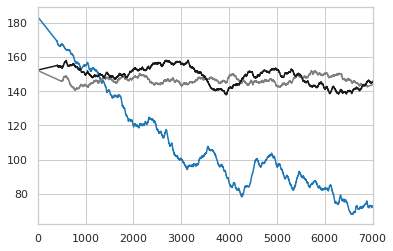

In [93]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np
sns.set_theme(style="whitegrid")


# np.savetxt('mazebig_qlearningextended.txt',total_reward,fmt='%d')


r = np.array(np.loadtxt('maze_qlearning.txt',dtype='int')).T
r2 = np.array(np.loadtxt('maze_xyrwmgqmgxymgw.txt',dtype='int')).T
r3 = np.array(np.loadtxt('maze_grid.txt',dtype='int')).T
r4 = np.array(np.loadtxt('maze_xyrwgqgxygw.txt',dtype='int')).T
r5 = np.array(np.loadtxt('maze_xyrwgqgxygw_onelayer.txt',dtype='int')).T
r6 = np.array(np.loadtxt('maze_xyrwgq_onelayer.txt',dtype='int')).T
r7 = np.array(np.loadtxt('maze_xyrgq_onelayer.txt',dtype='int')).T
# r8 = np.array(np.loadtxt('mazebig_xyrwmgqmgxy.txt',dtype='int')).T
r9 = np.array(np.loadtxt('maze_xyrwmgv.txt',dtype='int')).T
r10 = np.array(np.loadtxt('mazebig_xyrgqgav5l.txt',dtype='int')).T
r11 = np.array(np.loadtxt('mazebig_xyrgqgst.txt',dtype='int')).T
r12 = np.array(np.loadtxt('mazebig_qlearning.txt',dtype='int')).T
r13 = np.array(np.loadtxt('mazebig_grid.txt',dtype='int')).T
r14 = np.array(np.loadtxt('mazebig_xyr.txt',dtype='int')).T
r15 = np.array(np.loadtxt('mazebig_xyrmgqmgst.txt',dtype='int')).T
r16 = np.array(np.loadtxt('mazebig_xyrgqgav5gst.txt',dtype='int')).T
r17 = np.array(np.loadtxt('mazebig_xyrmgqmgav5l.txt',dtype='int')).T
r18 = np.array(np.loadtxt('mazebig_qlearningextended.txt',dtype='int')).T

# r2 = np.loadtxt('rewards_50g_counter_adaptive_lunar.txt',dtype='int')



# plt.figure; plt.plot(savgol_filter(np.array(r13),801,1).T,color='tab:purple')
# plt.plot(savgol_filter(np.array(r14),801,1).T,color='tab:green',alpha=0.8)
# plt.plot(savgol_filter(np.array(r15),801,1).T,color='tab:orange',linestyle='--',alpha=0.8)
# plt.plot(savgol_filter(np.array(r2),801,1).T,color='tab:green')
# plt.plot(savgol_filter(np.array(r3),501,1).T,color='tab:purple')
# plt.plot(savgol_filter(np.array(r4),801,1).T,color='tab:green')
# plt.plot(savgol_filter(np.array(r5),801,1).T,color='tab:brown')
# plt.plot(savgol_filter(np.array(r6),801,1).T,color='tab:cyan')
# plt.plot(savgol_filter(np.array(r7),801,1).T,color='tab:pink')
# plt.plot(savgol_filter(np.array(r9),801,1).T,color='tab:orange')
plt.plot(savgol_filter(np.array(r10),801,1).T,color='tab:blue')
# plt.plot(savgol_filter(np.array(r11),801,1).T,color='tab:orange',alpha=0.8)
plt.plot(savgol_filter(np.array(r12),1001,1).T,color='tab:gray')
# plt.plot(savgol_filter(np.array(r17),801,1).T,color='tab:blue',linestyle='--')
plt.plot(savgol_filter(np.array(r18),801,1).T,color='k')

plt.xlim([0,7000])
rew_episode, rew_episode2 , rew_episode3, rew_episode4 , rew_episode5, rew_episode6 , rew_episode9= [] , [] , [] , [] , [] , [] , []
rew_episode10, rew_episode11 ,rew_episode12 , rew_episode13, rew_episode14 , rew_episode15= [] , [] , [] , [] , [] , []
rew_episode17= []

for i in range(len(r)):
    rew_episode.append(np.array(r[i*45:(i+1)*45-1]))
    rew_episode2.append(np.array(r2[i*45:(i+1)*45-1]))
    rew_episode3.append(np.array(r3[i*45:(i+1)*45-1]))
    rew_episode4.append(np.array(r4[i*45:(i+1)*45-1]))
    rew_episode5.append(np.array(r5[i*45:(i+1)*45-1]))
    rew_episode6.append(np.array(r6[i*45:(i+1)*45-1]))
    rew_episode9.append(np.array(r9[i*45:(i+1)*45-1]))
    rew_episode10.append(np.array(r10[i*37:(i+1)*37-1]))
    rew_episode11.append(np.array(r11[i*37:(i+1)*37-1]))
    rew_episode12.append(np.array(r12[i*37:(i+1)*37-1]))
    rew_episode13.append(np.array(r13[i*37:(i+1)*37-1]))
    rew_episode14.append(np.array(r14[i*37:(i+1)*37-1]))
    rew_episode15.append(np.array(r15[i*37:(i+1)*37-1]))
    rew_episode17.append(np.array(r17[i*37:(i+1)*37-1]))
    
plt.savefig('demo.png', transparent=True)

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np
sns.set_theme(style="whitegrid")

        
        
max_plot = 38
smooth = 7

q = savgol_filter(rew_episode10[150:199],smooth,1)

hor_q = [np.linspace(0,max_plot,len(q1[i])) for i in range(0,len(q1))]

q1 = savgol_filter(rew_episode11[150:199],smooth,1)

q2 = savgol_filter(rew_episode12[150:199],smooth,1)

q3 = savgol_filter(rew_episode13[150:199],smooth,1)

q4 = savgol_filter(rew_episode14[150:199],smooth,1)
hor_q4 = [np.linspace(0,max_plot,len(q4[i])) for i in range(0,len(q4))]

q7 = savgol_filter(rew_episode17[150:199],smooth,1)
hor_q7 = [np.linspace(0,max_plot,len(q7[i])) for i in range(0,len(q7))]

df = pd.DataFrame({"y" : np.concatenate(np.array(q)),
                  "x" : np.concatenate(np.array(hor_q)),})
df1 = pd.DataFrame({"y" : np.concatenate(np.array(q1)),
                  "x" : np.concatenate(np.array(hor_q)),})
df2 = pd.DataFrame({"y" : np.concatenate(np.array(q2)),
                  "x" : np.concatenate(np.array(hor_q)),})
df3 = pd.DataFrame({"y" : np.concatenate(np.array(q3)),
                  "x" : np.concatenate(np.array(hor_q)),})
df4 = pd.DataFrame({"y" : np.concatenate(np.array(q4)),
                  "x" : np.concatenate(np.array(hor_q4)),})
df7 = pd.DataFrame({"y" : np.concatenate(np.array(q7)),
                  "x" : np.concatenate(np.array(hor_q7)),})

plt.figure(dpi=150)
fig=sns.lineplot(x="x", y="y", data=df,color='tab:blue',ci=65)
fig=sns.lineplot(x="x", y="y", data=df1,color='tab:orange',ci=65)
fig=sns.lineplot(x="x", y="y", data=df2,color='tab:gray',ci=65)
fig=sns.lineplot(x="x", y="y", data=df3,color='tab:purple',ci=65)
fig=sns.lineplot(x="x", y="y", data=df4,color='tab:green',ci=65)
fig=sns.lineplot(x="x", y="y", data=df7,color='tab:blue',ci=65,linestyle='--')

# fig=sns.lineplot(x="x", y="y", data=df4,color='tab:brown',ci=65)
# fig=sns.lineplot(x="x", y="y", data=df5,color='tab:cyan',ci=65)

plt.grid(b=True)

plt.savefig('demo.png', transparent=True)

In [ ]:
plt.plot(savgol_filter(np.array(total_reward),801,1).T,color='tab:blue')

### Q-network

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.optim as optim
import numpy as np
import gym
import collections
import time
from gym.spaces import Discrete, Box
from mazelab.generators import random_maze
DEFAULT_ENV_NAME = "RandomMaze-v0"

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 150000
LEARNING_RATE = 1e-3
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

EPSILON_DECAY_LAST_FRAME = 50000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01


Experience = collections.namedtuple(
    'Experience', field_names=['state', 'action', 'reward',
                               'done', 'new_state'])


class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()


        self.fc = nn.Sequential(

            nn.Linear(13*13, 512),
            nn.ReLU(),
            nn.Linear(512, 4)
            
        )
        
    def forward(self, x):
        return self.fc(x)
    
    
    
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size,
                                   replace=False)
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)


class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset().flatten()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.float32(np.array([self.state], copy=False))
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v.narrow(-1,0,env.action_space.n), dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward,
                         is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward


def calc_loss(batch, net, tgt_net, device="cpu"):
    
    states, actions, rewards, dones, next_states = batch

    # Create tensors from the variables in batch
    states_v = torch.tensor(np.float32(np.array(
        states, copy=False))).to(device)
    next_states_v = torch.tensor(np.float32(np.array(
        next_states, copy=False))).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)
    rewards_v[done_mask] = -1
    
    # Get the Q-values of the states(t) in batch, by applying our net
    state_action_values = net(states_v).gather(
        1, actions_v.unsqueeze(-1)).squeeze(-1)
    
    # Get the Q-values of the states(t+1) in batch, by applying our target_net
    with torch.no_grad():
        next_state_values = tgt_net(next_states_v).max(1)[0]
        next_state_values[done_mask] = 0.0
        next_state_values = next_state_values.detach()

    # TD target
    expected_state_action_values = next_state_values * GAMMA + \
                                   rewards_v
    
    # The Loss is the squared TD error
    return nn.SmoothL1Loss()(state_action_values,
                        expected_state_action_values)


if __name__ == "__main__":
    
    device = "cpu"

    env = gym.make(DEFAULT_ENV_NAME)

    net = DQN(env.observation_space.shape,
                        env.action_space.n).to(device)
    
    with torch.no_grad():
        tgt_net = DQN(env.observation_space.shape,
                            env.action_space.n).to(device)

    print(net)

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    epsilon = EPSILON_START

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    total_rewards = []
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_m_reward = None

    while True:
        frame_idx += 1
        epsilon = max(EPSILON_FINAL, EPSILON_START -
                      frame_idx / EPSILON_DECAY_LAST_FRAME)

        reward = agent.play_step(net, epsilon, device=device)
        
        if reward is not None:
            total_rewards.append(reward)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            m_reward = np.mean(total_rewards[-100:])
            
            if len(total_rewards) % 5 == 0:
                print("%d: done %d games, reward %.3f, "
                      "eps %.2f, speed %.2f f/s" % (
                    frame_idx, len(total_rewards), m_reward, epsilon,
                    speed
                ))

            if best_m_reward is None or best_m_reward < m_reward:
                torch.save(net.state_dict(), DEFAULT_ENV_NAME +
                           "-best_%.0f.dat" % m_reward)

                best_m_reward = m_reward
          #  if m_reward > MEAN_REWARD_BOUND:
          #      print("Solved in %d frames!" % frame_idx)
          #      break

        if len(buffer) < REPLAY_START_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t = calc_loss(batch, net, tgt_net, device=device)
        loss_t.backward()
        optimizer.step()

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.optim as optim
import numpy as np
import gym
from gym.spaces import Discrete, Box
from mazelab.generators import random_maze


iterations = 1
total_return = []
for iteration in range(iterations):
    size = 13
    env_name='RandomMaze-v0'
    lr=5e-4
#     lr=1e-2
    epochs=10000
    batch_size=1000
    render=False
    epsilon=0.1

    # make environment, check spaces, get obs / act dims
    x = random_maze(width=size, height=size, complexity=1, density=0.5)
    num_actions = 4
    env = gym.make('RandomMaze-v0')

#     L = env.maze.objects.free.positions
#     goal_idx = [L[np.random.randint(0, len(L))]]

    class policy_net(nn.Module):
        def __init__(self, input_shape, n_actions):
            super(policy_net, self).__init__()


            self.fc = nn.Sequential(

                
                nn.Linear(input_shape, 50),
                nn.ReLU(),
                nn.Linear(50, n_actions)
            )

        def forward(self, x):
            return self.fc(x)


    # make function to compute action distribution
    def get_policy(obs):

#         logits = obs
        return logits_net(obs)

    # make action selection function (outputs int actions, sampled from policy)
    def get_action(obs):
        if np.random.random()<0.2:
            return np.random.choice([0,1,2,3])
        else:
            return torch.argmax(logits_net(obs))
#         return get_policy(obs).sample().item()

    # make loss function whose gradient, for the right data, is policy gradient
    def compute_loss(values, targets):
        return nn.MSELoss()(values,targets)

    def reward_to_go(rews):
        n = len(rews)
        rtgs = np.zeros_like(rews)
        for i in reversed(range(n)):
            rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
        return rtgs

# 
    NUM_GAMMAS = 1

    taus=np.linspace(1,40,NUM_GAMMAS); #The taus are linearly separated (see next line)

    GAMMAS=np.exp(-2/taus)

#     GAMMAS = np.linspace(0.8,0.99,NUM_GAMMAS)
    GAMMAS = [0.99]
    sr = np.zeros((size,size,NUM_GAMMAS))
    Q = np.zeros((size,size,num_actions))
    Q_gamma = np.zeros((size,size,NUM_GAMMAS,num_actions))
    sr_x = np.zeros((size,size))
    sr_y = np.zeros((size,size))
    sr_x1 = np.zeros((size,size))
    sr_y1 = np.zeros((size,size))
    # make core of policy network
#     logits_net = policy_net(size*size + size*size+NUM_GAMMAS,num_actions).to('cuda')
#     logits_net = policy_net(4+num_actions,num_actions).to('cuda')
#     logits_net = policy_net((size)*(size),num_actions).to('cuda')
    logits_net = policy_net(8+7*NUM_GAMMAS+3*num_actions*NUM_GAMMAS,num_actions).to('cuda')
#     logits_net = policy_net(4,num_actions).to('cuda')

    # make optimizer
    optimizer = optim.Adam(logits_net.parameters(), lr=lr)


    # for training policy
    def train_one_epoch():
        # make some empty lists for logging.
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for R(tau) weighting in policy gradient
        batch_rets = []         # for measuring episode returns
        batch_lens = []         # for measuring episode lengths
        batch_values = []         # for measuring episode lengths
        batch_targets = []         # for measuring episode lengths

        # reset episode-specific variables
        obs = env.reset()       # first obs comes from starting distribution
        done = False            # signal from environment that episode is over
        ep_rews = []            # list for rewards accrued throughout ep

        # render first episode of each epoch
        finished_rendering_this_epoch = False
        # collect experience by acting in the environment with current policy

        while True:
            pos = env.maze.objects.agent.positions[0]*1
        #             obs[obs==2]=0
        #             obs[pos[0],pos[1]]=2
        #             r_pos = env.maze.objects.goal.positions[0]*1
        #             obs = np.zeros((size,size))
        #             obs[pos[0],pos[1]]=1.
        #             obs2 = np.zeros((size,size))
        #             obs2[r_pos[0],r_pos[1]]=1.
        #             obs = np.array([obs,obs2])
        #             obs = obs.flatten()

        #             obs = np.array([pos[0],pos[1],r_pos[0],r_pos[1]])
        #             obs = np.array([pos[0],pos[1]])
        #         obs = np.array([pos[0],pos[1],r_pos[0],r_pos[1],sr_x[pos[0],pos[1]],sr_y[pos[0],pos[1]]])

        #         obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:])]
        #             obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(sr[pos[0],pos[1],:]),
        #                    list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:]),list(sr_x1[pos[0],pos[1],:]),list(sr_y1[pos[0],pos[1],:])]
        #             obs = [list(obs),list(sr[pos[0],pos[1],:])]
        #             obs = [[pos[0],pos[1],r_pos[0],r_pos[1]],list(Q_gamma[pos[0],pos[1],:,:].flatten())]
            obs = [[pos[0],pos[1],r_pos[0],r_pos[1],in_x[pos[0],pos[1]],
                    in_y[pos[0],pos[1]],in_x1[pos[0],pos[1]],
                    in_y1[pos[0],pos[1]]],list(sr[pos[0],pos[1],:]),
                   list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:]),
                   list(fut_x[pos[0],pos[1],:]),list(fut_y[pos[0],pos[1],:]),
                   list(sr_x1[pos[0],pos[1],:]),list(sr_y1[pos[0],pos[1],:]),
                   list(Q_gamma[pos[0],pos[1],:,:].flatten()),
                   list(fut_stx[pos[0],pos[1],:,:].flatten()),
                   list(fut_sty[pos[0],pos[1],:,:].flatten())]

            obs = np.array([item for sublist in obs for item in sublist])
            obs = obs.flatten()


            # save obs
            batch_obs.append(obs)

            # act in the environment

        #             act = get_action(torch.as_tensor(Q_gamma[pos[0],pos[1],-1,:], dtype=torch.float32).to('cuda'))
            act = get_action(torch.as_tensor(obs, dtype=torch.float32).to('cuda'))

            _, rew, done, _ = env.step(act)

            pos_next = env.maze.objects.agent.positions[0]*1
        #             pos_next_r = pos*1

        #             pos_next_r[0] = np.max([0,np.min([size-1,pos[0]+np.random.choice([1,0,-1])])])
        #             pos_next_r[1] = np.max([0,np.min([size-1,pos[1]+np.random.choice([1,0,-1])])])

        #             if np.sum(np.sum(L==np.array(pos_next_r),1)==2)==1:
        #                 pos_next_r = pos_next_r
        #             else:
        #                 pos_next_r = pos*1

            utility_x, utility_y , utility_x1, utility_y1 = 0 , 0 , 0 , 0
            if np.sum(np.sum(L==np.array([pos[0]+1,pos[1]]),1)==2)==0:
                utility_x = 0.1
            if np.sum(np.sum(L==np.array([pos[0],pos[1]+1]),1)==2)==0:
                utility_y = 0.1
            if np.sum(np.sum(L==np.array([pos[0]-1,pos[1]]),1)==2)==0:
                utility_x1 = 0.1
            if np.sum(np.sum(L==np.array([pos[0],pos[1]-1]),1)==2)==0:
                utility_y1 = 0.1   

        #             if pos[0]==1:
        #                 utility_x = 0.1
        #             if pos[1]==1:
        #                 utility_y = 0.1
        #             if pos[0]==size-2:
        #                 utility_x1 = 0.1
        #             if pos[1]==size-2:
        #                 utility_y1 = 0.1     

            utility = pos[0]==r_pos[0] and pos[1]==r_pos[1]
        #             utility_x = (pos_next_r[0]-size/2)/20
        #             utility_y = (pos_next_r[1]-size/2)/20

        #             in_x[pos[0],pos[1]] = in_x[pos[0],pos[1]] + 1 * (utility_x
        #                                                                  - in_x[pos[0],pos[1]])
        #             in_y[pos[0],pos[1]] = in_y[pos[0],pos[1]] + 1 * (utility_y
        #                                                                  - in_y[pos[0],pos[1]])
        #             in_x1[pos[0],pos[1]] = in_x1[pos[0],pos[1]] + 1 * (utility_x1
        #                                                                  - in_x1[pos[0],pos[1]])
        #             in_y1[pos[0],pos[1]] = in_y1[pos[0],pos[1]] + 1 * (utility_y1
        #                                                                  - in_y1[pos[0],pos[1]])
            for g in range(NUM_GAMMAS):
                sr[pos[0],pos[1],g] = sr[pos[0],pos[1],g] + 0.1 * (utility
                                                                    + GAMMAS[g] * sr[pos_next[0],pos_next[1],g] 
                                                                   - sr[pos[0],pos[1],g])

                sr_x[pos[0],pos[1],g] = sr_x[pos[0],pos[1],g] + 0.1 * (utility_x
                                                                    + np.abs(0.1-utility_x)*GAMMAS[g] * sr_x[pos_next[0],pos_next[1],g] 
                                                                       - sr_x[pos[0],pos[1],g])

                sr_y[pos[0],pos[1],g] = sr_y[pos[0],pos[1],g] + 0.1 * (utility_y
                                                                    + np.abs(0.1-utility_y)*GAMMAS[g] * sr_y[pos_next[0],pos_next[1],g]
                                                                       - sr_y[pos[0],pos[1],g])

                sr_x1[pos[0],pos[1],g] = sr_x1[pos[0],pos[1],g] + 0.1 * (utility_x1
                                                                    + np.abs(0.1-utility_x1)*GAMMAS[g] * sr_x1[pos_next[0],pos_next[1],g] 
                                                                         - sr_x1[pos[0],pos[1],g])

                sr_y1[pos[0],pos[1],g] = sr_y1[pos[0],pos[1],g] + 0.1 * (utility_y1
                                                                    + np.abs(0.1-utility_y1)*GAMMAS[g] * sr_y1[pos_next[0],pos_next[1],g] 
                                                                         - sr_y1[pos[0],pos[1],g])

                fut_x[pos[0],pos[1],g] = fut_x[pos[0],pos[1],g] + 0.1 * ((pos[0]-size/2)/20
                                                                    + GAMMAS[g] * fut_x[pos_next[0],pos_next[1],g] 
                                                                       - fut_x[pos[0],pos[1],g])

                fut_y[pos[0],pos[1],g] = fut_y[pos[0],pos[1],g] + 0.1 * ((pos[1]-size/2)/20
                                                                    + GAMMAS[g] * fut_y[pos_next[0],pos_next[1],g]
                                                                       - fut_y[pos[0],pos[1],g])

                fut_stx[pos[0],pos[1],g,act] = fut_stx[pos[0],pos[1],g,act] + 0.1 * ((pos[0]-size/2)/20
                                                                    + GAMMAS[g] * fut_stx[pos_next[0],pos_next[1],g,act] 
                                                                       - fut_stx[pos[0],pos[1],g,act])

                fut_sty[pos[0],pos[1],g,act] = fut_sty[pos[0],pos[1],g,act] + 0.1 * ((pos[1]-size/2)/20
                                                                    + GAMMAS[g] * fut_sty[pos_next[0],pos_next[1],g,act] 
                                                                       - fut_sty[pos[0],pos[1],g,act])                

                #                 Q[pos[0],pos[1],act] = Q[pos[0],pos[1],act] + 0.1 * (utility
        #                                                                         + GAMMAS[g] * Q[pos_next[0],pos_next[1],act]
        #                                                                      - Q[pos[0],pos[1],act])

                Q_gamma[pos[0],pos[1],g,act] = Q_gamma[pos[0],pos[1],g,act] + 0.1 * (utility
                                                                        + GAMMAS[g] * np.max(Q_gamma[pos_next[0],pos_next[1],g,:])
                                                                     - Q_gamma[pos[0],pos[1],g,act])

        #             if np.max(Q_gamma)>0:
        #                 Q_gamma[:,:,:,:] = 5*(Q_gamma[:,:,:,:]-np.min(Q_gamma[:,:,:,:]))/(
        #                     np.max(Q_gamma[:,:,:,:])-np.min(Q_gamma[:,:,:,:]))

        #                 sr[:,:,:] = (sr[:,:,:]-np.min(sr[:,:,:]))/(
        #                     np.max(sr[:,:,:])-np.min(sr[:,:,:]))


            state_action_values = logits_net(torch.as_tensor(obs, dtype=torch.float32).to('cuda')).max()

            pos = pos_next*1
            obs = [[pos[0],pos[1],r_pos[0],r_pos[1],in_x[pos[0],pos[1]],
            in_y[pos[0],pos[1]],in_x1[pos[0],pos[1]],
            in_y1[pos[0],pos[1]]],list(sr[pos[0],pos[1],:]),
           list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:]),
           list(fut_x[pos[0],pos[1],:]),list(fut_y[pos[0],pos[1],:]),
           list(sr_x1[pos[0],pos[1],:]),list(sr_y1[pos[0],pos[1],:]),
           list(Q_gamma[pos[0],pos[1],:,:].flatten()),
           list(fut_stx[pos[0],pos[1],:,:].flatten()),
           list(fut_sty[pos[0],pos[1],:,:].flatten())]
            obs = np.array([item for sublist in obs for item in sublist])
            obs = obs.flatten()
            next_state_values = logits_net(torch.as_tensor(obs, dtype=torch.float32).to('cuda')).max()

            # TD target
            expected_state_action_values = next_state_values * GAMMAS[0] + rew

            batch_values.append(state_action_values)
            batch_targets.append(expected_state_action_values)


            if rew==1:
                rew=50
            # save action, reward
            batch_acts.append(act)
            ep_rews.append(rew)



            if done:

                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)

                # the weight for each logprob(a|s) is R(tau)
                batch_weights += list(reward_to_go(ep_rews))

                # reset episode-specific variables
        #             start_idx = [L[np.random.randint(0, len(L))]]
                obs, done, ep_rews = env.reset(), False, []


                # end experience loop if we have enough of it
                if len(batch_obs) > batch_size:
                    break

        # take a single policy gradient update step
        optimizer.zero_grad()
        batch_loss = compute_loss(values=torch.stack(batch_values),
                                  targets=torch.stack(batch_targets)
                                  )
        batch_loss.backward()
        optimizer.step()
        return batch_loss, batch_rets, batch_lens

    total_reward = []
    # training loop
    for i in range(epochs):

        clear_output(wait=True)

        change = 50
        if i==0 or i%change==0:
            sr = np.zeros((size,size,NUM_GAMMAS))
            Q = np.zeros((size,size,num_actions))
            Q_gamma = np.zeros((size,size,NUM_GAMMAS,num_actions))
            fut_stx = np.zeros((size,size,NUM_GAMMAS,num_actions))
            fut_sty = np.zeros((size,size,NUM_GAMMAS,num_actions))
            sr_x = np.zeros((size,size,NUM_GAMMAS))
            sr_y = np.zeros((size,size,NUM_GAMMAS))
            sr_x1 = np.zeros((size,size,NUM_GAMMAS))
            sr_y1 = np.zeros((size,size,NUM_GAMMAS))
            fut_x = np.zeros((size,size,NUM_GAMMAS))
            fut_y = np.zeros((size,size,NUM_GAMMAS))
            in_x = np.zeros((size,size))
            in_y = np.zeros((size,size))
            in_x1 = np.zeros((size,size))
            in_y1 = np.zeros((size,size))
            x = random_maze(width=size, height=size, complexity=0, density=0)
            env = gym.make(env_name)
            L = env.maze.objects.free.positions
            goal_idx = [L[np.random.randint(0, len(L))]]
            start_idx = goal_idx
    #         start_idx = [L[np.random.randint(0, len(L))]]
    #         start_idx = [[1,1]]
    #         start_idx=goal_idx
        elif i==1 or (i-1)%change==0:
#             start_idx=[[np.min([size-1,goal_idx[0][0]+1]),np.min([size-1,goal_idx[0][1]])]]
            start_idx = goal_idx
        elif i==2 or (i-2)%change==0:
#             start_idx=[[np.min([size-1,goal_idx[0][0]]),np.min([size-1,goal_idx[0][1]+1])]]  
            start_idx = goal_idx
        elif i==3 or (i-3)%change==0:
#             start_idx=[[np.min([size-1,goal_idx[0][0]-1]),np.min([size-1,goal_idx[0][1]])]]
            start_idx = goal_idx
        elif i==4 or (i-4)%change==0:
#             start_idx=[[np.min([size-1,goal_idx[0][0]]),np.min([size-1,goal_idx[0][1]-1])]]    
            start_idx = goal_idx
        else:
    #         start_idx = [[1,1]]
            start_idx = [L[np.random.randint(0, len(L))]]

        obs = env.reset()
        batch_loss, batch_rets, batch_lens = train_one_epoch()
#         print(start_idx)
        print(iteration)
        print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
                (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))

        if i>5 and (i)%change!=0 and (i-1)%change!=0 and (i-2)%change!=0 and (i-3)%change!=0 and (i-4)%change!=0:
            total_reward.append(np.mean(batch_lens))

        x_grid,y_grid = np.meshgrid(np.linspace(10,450,size),np.linspace(20,450,size))

#         print(start_idx)
#         print(env.maze.objects.agent.positions[0])
        img = env.render('rgb_array')
        plt.imshow(img); 

        policy = np.zeros((size,size,4))
        for x_pos in range(size):
            for y_pos in range(size):
                pos = [x_pos,y_pos]
                r_pos = env.maze.objects.goal.positions[0]*1

                obs = [[pos[0],pos[1],r_pos[0],r_pos[1],in_x[pos[0],pos[1]],
                        in_y[pos[0],pos[1]],in_x1[pos[0],pos[1]],
                        in_y1[pos[0],pos[1]]],list(sr[pos[0],pos[1],:]),
                       list(sr_x[pos[0],pos[1],:]),list(sr_y[pos[0],pos[1],:]),
                       list(fut_x[pos[0],pos[1],:]),list(fut_y[pos[0],pos[1],:]),
                       list(sr_x1[pos[0],pos[1],:]),list(sr_y1[pos[0],pos[1],:]),
                       list(Q_gamma[pos[0],pos[1],:,:].flatten()),
                       list(fut_stx[pos[0],pos[1],:,:].flatten()),
                       list(fut_sty[pos[0],pos[1],:,:].flatten())]


                obs = np.array([item for sublist in obs for item in sublist])
                obs = obs.flatten()
                policy[x_pos,y_pos,:]=np.array(logits_net(torch.as_tensor(obs, dtype=torch.float32).to('cuda')).detach().to('cpu'))
#                 policy[x_pos,y_pos,:]=np.array(get_policy(torch.as_tensor(Q_gamma[pos[0],pos[1],-1,:], dtype=torch.float32).to('cuda')).probs.detach().to('cpu'))

        
        u = policy[:,:,3]-policy[:,:,2]
        v = policy[:,:,0]-policy[:,:,1]

        plt.quiver(x_grid,y_grid,u,v); plt.show()

        plt.plot(total_reward);  plt.show()
    total_return.append(total_reward)



In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np
sns.set_theme(style="whitegrid")

        
        
max_plot = 374
smooth = 31
rewards_xy = savgol_filter(np.array(np.loadtxt('rewards_xy.txt',dtype='int')),smooth,1)
        
hor_xy = [np.linspace(0,max_plot,len(rewards_xy[i])) for i in range(0,len(rewards_xy))]

rewards_xyr = savgol_filter(np.array(np.loadtxt('rewards_xyr.txt',dtype='int')),smooth+30,1)
        
hor_xyr = [np.linspace(0,max_plot,len(rewards_xyr[i])) for i in range(0,len(rewards_xy))]

rewards_gridxyr = savgol_filter(np.array(np.loadtxt('rewards_gridxyr.txt',dtype='int')),smooth,1)
        
hor_gridxyr = [np.linspace(0,max_plot,len(rewards_gridxyr[i])) for i in range(0,len(rewards_gridxyr))]

rewards_xyrsrd = savgol_filter(np.array(np.loadtxt('rewards_xyrsrd.txt',dtype='int')),smooth,1)
        
hor_xyrsrd = [np.linspace(0,max_plot,len(rewards_xyrsrd[i])) for i in range(0,len(rewards_xy))]

rewards_xyrsrb = savgol_filter(np.array(np.loadtxt('rewards_xyrsrb.txt',dtype='int')),smooth,1)
        
hor_xyrsrb = [np.linspace(0,max_plot,len(rewards_xyrsrb[i])) for i in range(0,len(rewards_xy))]

rewards_xyrvd = savgol_filter(np.array(np.loadtxt('rewards_xyrvd.txt',dtype='int')),smooth,1)
        
hor_xyrvd = [np.linspace(0,max_plot,len(rewards_xyrvd[i])) for i in range(0,len(rewards_xy))]

rewards_xyrqb = savgol_filter(np.array(np.loadtxt('rewards_xyrqb.txt',dtype='int')),smooth,1)
        
hor_xyrqb = [np.linspace(0,max_plot,len(rewards_xyrqb[i])) for i in range(0,len(rewards_xy))]

rewards_xyrqd = savgol_filter(np.array(np.loadtxt('rewards_xyrqd.txt',dtype='int')),smooth,1)
        
hor_xyrqd = [np.linspace(0,max_plot,len(rewards_xyrqd[i])) for i in range(0,len(rewards_xy))]

rewards_xyrqmgd = savgol_filter(np.array(np.loadtxt('rewards_xyrqmgd.txt',dtype='int')),smooth,1)
        
hor_xyrqmgd = [np.linspace(0,max_plot,len(rewards_xyrqmgd[i])) for i in range(0,len(rewards_xy))]

rewards_xyrqmgb = savgol_filter(np.array(np.loadtxt('rewards_xyrqmgb.txt',dtype='int')),smooth,1)
        
hor_xyrqmgb = [np.linspace(0,max_plot,len(rewards_xyrqmgb[i])) for i in range(0,len(rewards_xy))]

df = pd.DataFrame({"y" : np.concatenate(np.array(rewards_xy)),
                  "x" : np.concatenate(np.array(hor_xy)),
                 })

df2 = pd.DataFrame({"y" : np.concatenate(np.array(rewards_xyr)),
                  "x" : np.concatenate(np.array(hor_xyr)),
                 })

df3 = pd.DataFrame({"y" : np.concatenate(np.array(rewards_xyrsrd)),
                  "x" : np.concatenate(np.array(hor_xyrsrd)),
                 })

df4 = pd.DataFrame({"y" : np.concatenate(np.array(rewards_xyrvd)),
                  "x" : np.concatenate(np.array(hor_xyrvd)),
                 })

df5 = pd.DataFrame({"y" : np.concatenate(np.array(rewards_xyrsrb)),
                  "x" : np.concatenate(np.array(hor_xyrsrb)),
                 })

df6 = pd.DataFrame({"y" : np.concatenate(np.array(rewards_xyrqb)),
                  "x" : np.concatenate(np.array(hor_xyrqb)),
                 })

df7 = pd.DataFrame({"y" : np.concatenate(np.array(rewards_xyrqd)),
                  "x" : np.concatenate(np.array(hor_xyrqd)),
                 })

df8 = pd.DataFrame({"y" : np.concatenate(np.array(rewards_xyrqmgd)),
                  "x" : np.concatenate(np.array(hor_xyrqmgd)),
                 })

df9 = pd.DataFrame({"y" : np.concatenate(np.array(rewards_xyrqmgb)),
                  "x" : np.concatenate(np.array(hor_xyrqmgb)),
                 })

df10 = pd.DataFrame({"y" : np.concatenate(np.array(rewards_gridxyr)),
                  "x" : np.concatenate(np.array(hor_gridxyr)),
                 })


In [ ]:
plt.figure(dpi=150)
fig=sns.lineplot(x="x", y="y", data=df,color='tab:gray',ci=65)
fig2=sns.lineplot(x="x", y="y", data=df2,color='tab:blue',ci=65)
fig3=sns.lineplot(x="x", y="y", data=df3,color='tab:orange',ci=65,linestyle='--')
fig4=sns.lineplot(x="x", y="y", data=df4,color='tab:pink',ci=65)
fig5=sns.lineplot(x="x", y="y", data=df5,color='tab:green',ci=65,linestyle='--')
fig6=sns.lineplot(x="x", y="y", data=df6,color='tab:brown',ci=65)
fig7=sns.lineplot(x="x", y="y", data=df7,color='tab:cyan',ci=65)
fig8=sns.lineplot(x="x", y="y", data=df8,color='tab:olive',ci=65,linestyle='--')
fig9=sns.lineplot(x="x", y="y", data=df9,color='tab:red',ci=65,linestyle='--')
fig10=sns.lineplot(x="x", y="y", data=df10,color='tab:purple',ci=65)
plt.xlim([0,350])
plt.ylim([100,205])
plt.grid(b=True)

plt.savefig('demo.png', transparent=True)

In [ ]:
obs = env.step([-1, 0, 0,0])
print(obs)
img = env.render(mode='rgb_array')
plt.figure(dpi=100)
plt.imshow(img)

---------------------------------------
Frame: 115000. Evaluation over 500 frames: -50.000
---------------------------------------


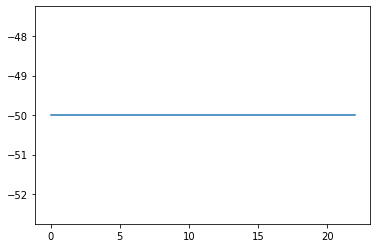

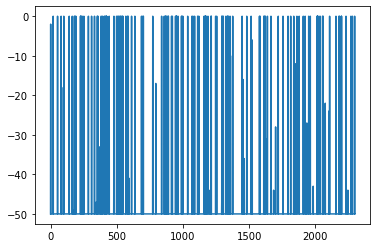

Total T: 115050 Episode Num: 2301 Episode T: 50 Reward: -50.000


KeyboardInterrupt: 

In [8]:
from IPython.display import clear_output
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sunblaze_envs
import numpy as np
import torch
import gym
import argparse
import os
import matplotlib.pyplot as plt

batch_size=100
buffer_size=1e6
NUM_GAMMAS=1
taus=np.linspace(5,100,NUM_GAMMAS)
GAMMAS=np.exp(-1/taus)
GAMMAS[-1]=0.99

GAMMAS=np.flip(GAMMAS)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GAMMAS=torch.tensor([GAMMAS for _ in range(batch_size)]).float().to(device)

# Implementation of Twin Delayed Deep Deterministic Policy Gradients (TD3)
# Paper: https://arxiv.org/abs/1802.09477

d=np.ones(NUM_GAMMAS)


class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(buffer_size)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, action_dim)
        
        self.max_action = max_action
        

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 256)
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)


    def forward(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2


    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1

num_gvfs = 1
class GVF(nn.Module):
    def __init__(self, state_dim, num_gvfs):
        super(GVF, self).__init__()

        self.fc = nn.Sequential(


            nn.Linear(state_dim, 10),
            nn.ReLU(),
            nn.Linear(10, num_gvfs)
        )

    def forward(self, x):
        return self.fc(x)

class TD3(object):
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_freq=2
    ):

        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

#         self.gvf = GVF(4, num_gvfs).to(device)
#         self.gvf_optimizer = torch.optim.Adam(self.gvf.parameters(), lr=1e-3)
        
        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq

        self.total_it = 0


    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()


    def train(self, replay_buffer, batch_size=100):
        self.total_it += 1

        # Sample replay buffer 
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)
        
        # LEARN GFVs-------------------- (states are then changed by GVFs)

#         theta = 0.01 #threshold for velocities

# #         utility = torch.transpose(torch.stack(num_gvfs*[torch.flatten(reward==0)*1]),0,1).float()
# #         utility[utility==1]=5
#         utility = reward*1
#         # Compute directions of batch
#         vel = [(next_state-state)[:,0],(next_state-state)[:,1],(next_state-state)[:,2]]

# #         direct = torch.transpose(torch.stack(
# #             [(vel[0]>theta)*1 * (torch.abs(vel[1])<theta)*1 * (torch.abs(vel[2])<theta)*1, #+,0,0
# #                   (vel[0]<-theta)*1 * (torch.abs(vel[1])<theta)*1 * (torch.abs(vel[2])<theta)*1, #-,0,0
# #                   (torch.abs(vel[0])<theta)*1 * (vel[1]>theta)*1 * (torch.abs(vel[2])<theta)*1, #0,+,0
# #                   (torch.abs(vel[0])<theta)*1 * (vel[1]<-theta)*1 * (torch.abs(vel[2])<theta)*1, #0,-,0
# #                   (torch.abs(vel[0])<theta)*1 * (torch.abs(vel[1])<theta)*1 * (vel[2]>theta)*1, #0,0,+
# #                   (torch.abs(vel[0])<theta)*1 * (torch.abs(vel[1])<theta)*1 * (vel[2]<-theta)*1, #0,0,-
# #                   (torch.abs(vel[0])<theta)*1 * (torch.abs(vel[1])<theta)*1 * (torch.abs(vel[2])<theta)*1, #0,0,0
# #                  ]),0,1).float()

#         direct = torch.transpose(torch.stack(
#             [(vel[0]>theta)*1 * (torch.abs(vel[1])<theta)*1 * (torch.abs(vel[2])<theta)*1,  #0,0,0
#                  ]),0,1).float()
        
#         # Compute GVF loss (with importance weights given by "direct")
#         features = state[:,[0,0,1,2]]-state[:,[-3,-3,-2,-1]] 
# #         features[:,[0]]=(features[:,[0]]>0*1)*features[:,[0]]
# #         features[:,[1]]=(features[:,[1]]<0*1)*features[:,[1]]
# #         features[:,[2,3]]=torch.abs(features[:,[2,3]])
#         features_next = next_state[:,[0,0,1,2]]-next_state[:,[-3,-3,-2,-1]] ;
# #         features_next[:,[2,3]]=torch.abs(features_next[:,[2,3]])
# #         features_next[:,[0]]=(features_next[:,[0]]>0*1)*features_next[:,[0]]
# #         features_next[:,[1]]=(features_next[:,[1]]<0*1)*features_next[:,[1]]
#         pred = self.gvf(features)
#         with torch.no_grad():
#             bell_target = utility + (torch.abs(1-utility)*0.99) * self.gvf(features_next)
# #         norm = torch.sum(direct,0); norm[norm==0]=1
#         gvf_loss = torch.sum(torch.sum((nn.MSELoss(reduction='none')(pred,bell_target)),0))


#         # Optimize GVF net
#         self.gvf_optimizer.zero_grad()
#         gvf_loss.backward()
#         self.gvf_optimizer.step()
        
#         state[:,0] = state[:,0]-state[:,-3]
#         state[:,1] = state[:,1]-state[:,-2]
#         state[:,2] = state[:,2]-state[:,-1]
        
#         next_state[:,0] = next_state[:,0]-next_state[:,-3]
#         next_state[:,1] = next_state[:,1]-next_state[:,-2]
#         next_state[:,2] = next_state[:,2]-next_state[:,-1]
  
        
        with torch.no_grad():
            # Select action according to policy and add clipped noise
            noise = (
                torch.randn_like(action) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip)
            
            next_action = (
                self.actor_target(next_state) + noise
            ).clamp(-self.max_action, self.max_action)

            # Compute the target Q value
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + not_done * self.discount * target_Q

        # Get current Q estimates
        current_Q1, current_Q2 = self.critic(state, action)

        # Compute critic loss
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Delayed policy updates
        if self.total_it % self.policy_freq == 0:

            # Compute actor losse
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
            
            # Optimize the actor 
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


    def save(self, filename):
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")
        
        torch.save(self.actor.state_dict(), filename + "_actor")
        torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")


    def load(self, filename):
        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
        self.critic_target = copy.deepcopy(self.critic)

        self.actor.load_state_dict(torch.load(filename + "_actor"))
        self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
        self.actor_target = copy.deepcopy(self.actor)        

# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env_name, seed, eval_episodes=10):
    eval_env = gym.make(args.env)

#     eval_env = sunblaze_envs.make('SunblazeHopperRandomExtreme-v0')
    eval_env.seed(seed + 100)

    avg_reward = 0.
    frame=0
    for _ in range(eval_episodes):
        obs, done = eval_env.reset(), False
        state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
#         state[0] = state[0]-state[-3]
#         state[1] = state[1]-state[-2]
#         state[2] = state[2]-state[-1]
        while not done:
            frame+=1
            action = policy.select_action(np.array(state))
            obs, reward, done, _ = eval_env.step(action)
            state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
#             state[0] = state[0]-state[-3]
#             state[1] = state[1]-state[-2]
#             state[2] = state[2]-state[-1]
            avg_reward += reward

    avg_reward /= eval_episodes

    print("---------------------------------------")
    print(f"Frame: {frame_idx}. Evaluation over {frame} frames: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward


if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--policy", default="TD3")                  # Policy name (TD3, DDPG or OurDDPG)
    parser.add_argument("--env", default="FetchPush-v1")          # OpenAI gym environment name
    parser.add_argument("--seed", default=0, type=int)              # Sets Gym, PyTorch and Numpy seeds
    parser.add_argument("--start_timesteps", default=2e5, type=int)# Time steps initial random policy is used
    parser.add_argument("--eval_freq", default=5e3, type=int)       # How often (time steps) we evaluate
    parser.add_argument("--max_timesteps", default=3e6, type=int)   # Max time steps to run environment
    parser.add_argument("--expl_noise", default=0.1)                # Std of Gaussian exploration noise
    parser.add_argument("--batch_size", default=batch_size, type=int)      # Batch size for both actor and critic
    parser.add_argument("--discount", default=GAMMAS)               # Discount factor
    parser.add_argument("--tau", default=0.005)                     # Target network update rate
    parser.add_argument("--policy_noise", default=0.2)              # Noise added to target policy during critic update
    parser.add_argument("--noise_clip", default=0.5)                # Range to clip target policy noise
    parser.add_argument("--policy_freq", default=2, type=int)       # Frequency of delayed policy updates
    parser.add_argument("--save_model", action="store_true")        # Save model and optimizer parameters
    parser.add_argument("--load_model", default="")                 # Model load file name, "" doesn't load, "default" uses file_name
    args,unknown = parser.parse_known_args()
#     args = parser.parse_args()



    env = gym.make(args.env)
#     env = sunblaze_envs.make('SunblazeHopperRandomNormal-v0')
    # Set seeds
    env.seed(args.seed)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    
    state_dim = 31
    action_dim = 4
    max_action = float(env.action_space.high[0])

    kwargs = {
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action,
        "discount": args.discount,
        "tau": args.tau,
    }

    # Initialize policy
    if args.policy == "TD3":
        # Target policy smoothing is scaled wrt the action scale
        kwargs["policy_noise"] = args.policy_noise * max_action
        kwargs["noise_clip"] = args.noise_clip * max_action
        kwargs["policy_freq"] = args.policy_freq
        policy = TD3(**kwargs)

#     if args.load_model != "":
#         policy_file = file_name if args.load_model == "default" else args.load_model
#         policy.load(f"./models/{policy_file}")

    replay_buffer = ReplayBuffer(state_dim, action_dim)
    
    frame_idx=0
    # Evaluate untrained policy
    evaluations = []

    obs, done = env.reset(), False
    state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0
    dif=[]
    total_reward=[]
    gvf = GVF(3, 1).to(device)
    gvf_optimizer = torch.optim.Adam(gvf.parameters(), lr=1e-3)

    for t in range(int(args.max_timesteps)):
        frame_idx+=1
        episode_timesteps += 1

        # Select action randomly or according to policy
        if t < args.start_timesteps:
            action = env.action_space.sample()
        else:
#             state[0] = state[0]-state[-3]
#             state[1] = state[1]-state[-2]
#             state[2] = state[2]-state[-1]
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * args.expl_noise, size=action_dim)
            ).clip(-max_action, max_action)
            
        # Perform action
        obs, reward, done, _ = env.step(action) 
        next_state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
        done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

        # Store data in replay buffer
        replay_buffer.add(state, action, next_state, reward, done_bool)


        
        state = next_state
        episode_reward += reward

        # Train agent after collecting sufficient data
        if t >= args.start_timesteps:
            policy.train(replay_buffer, args.batch_size)

        if done: 
            # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
            if episode_num % 100 == 0:
                print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
            # Reset environment
            obs, done = env.reset(), False
            state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
            total_reward.append(episode_reward)
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1 

        
        # Evaluate episodE
        if (t + 1) % args.eval_freq == 0:
            clear_output(wait=True);
            evaluations.append(eval_policy(policy, args.env, args.seed))
#             r = np.loadtxt('rewards_50g_cheetah_full.txt',dtype='int')
#             r2 = np.loadtxt('rewards_cheetah_RE_50g_adaptive.txt',dtype='int')
#             plt.plot(r); 
#             plt.plot(r2)
            plt.plot(evaluations); plt.show()
            plt.plot(total_reward); plt.show()



# Tabular GVFs

---------------------------------------
Frame: 14500. Evaluation over 500 frames: -2.700
---------------------------------------


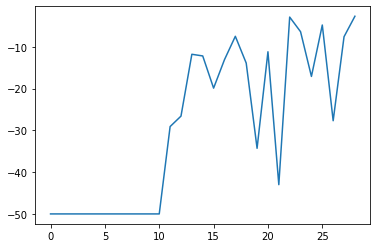

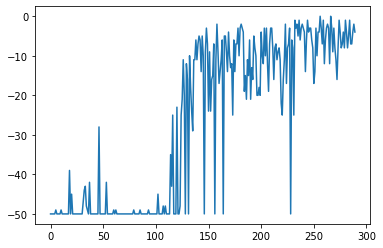

KeyboardInterrupt: 

In [17]:

from IPython.display import clear_output
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sunblaze_envs
import numpy as np
import torch
import gym
import argparse
import os
import matplotlib.pyplot as plt

batch_size=100
buffer_size=1e6
NUM_GAMMAS=3
GAMMAS=[0.99,0.9,0.6]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Implementation of Twin Delayed Deep Deterministic Policy Gradients (TD3)
# Paper: https://arxiv.org/abs/1802.09477

d=np.ones(NUM_GAMMAS)


class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(buffer_size)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, action_dim)
        
        self.max_action = max_action
        

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 256)
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)


    def forward(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2


    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1

max_0 = 0.3; min_0 = -0.3
max_1 = 0.3; min_1 = -0.3
max_2 = 0.3; min_2 = -0.25

res=11

class TD3(object):
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_freq=2
    ):

        self.actor = Actor(state_dim + 12*NUM_GAMMAS, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(state_dim + 12*NUM_GAMMAS, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)
        
        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq

        self.total_it = 0


    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()


    def train(self, replay_buffer, batch_size=256):
        self.total_it += 1

        # Sample replay buffer 
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)
        
        # LEARN GFVs-------------------- (states are then changed by GVFs)

        state0 = (res*((state[:,0]-state[:,-3]).detach().to('cpu').numpy() - min_0) / (max_0 - min_0)).astype(int)
        state1 = (res*((state[:,1]-state[:,-2]).detach().to('cpu').numpy() - min_1) / (max_1 - min_1)).astype(int)
        state2 = (res*((state[:,2]-state[:,-1]).detach().to('cpu').numpy() - min_2) / (max_2 - min_2)).astype(int)

        nstate0 = (res*((next_state[:,0]-next_state[:,-3]).detach().to('cpu').numpy() - min_0) / (max_0 - min_0)).astype(int)
        nstate1 = (res*((next_state[:,1]-next_state[:,-2]).detach().to('cpu').numpy() - min_1) / (max_1 - min_1)).astype(int)
        nstate2 = (res*((next_state[:,2]-next_state[:,-1]).detach().to('cpu').numpy() - min_2) / (max_2 - min_2)).astype(int)

        state0[state0>(res-1)]=res-1; state1[state1>(res-1)]=res-1 ; state2[state2>(res-1)]=res-1
        state0[state0<0]=0; state1[state1<0]=0 ; state2[state2<0]=0

        nstate0[nstate0>(res-1)]=res-1; nstate1[nstate1>(res-1)]=res-1 ; nstate2[nstate2>(res-1)]=res-1
        nstate0[nstate0<0]=0; nstate1[nstate1<0]=0 ; nstate2[nstate2<0]=0

        for t in range(len(reward)):
            utility = (reward[t]==0).float()
            for g in range(NUM_GAMMAS):
                if state0[t]<(res-1):
                    sr[state0[t],state1[t],state2[t],g] = sr[state0[t],state1[t],state2[t],g] + 0.3 * (utility
                                                                        +  (1-utility) * GAMMAS[g] * sr[state0[t]+1,state1[t],state2[t],g]
                                                                       - sr[state0[t],state1[t],state2[t],g])

                #LEVEL 1
                if state0[t]>0:
                    fut_a_v[state0[t],state1[t],state2[t],0,g] = fut_a_v[state0[t],state1[t],state2[t],0,g] + 0.3 * (utility
                                                                        +  (1-utility) * GAMMAS[g] * fut_a_v[state0[t]-1,state1[t],state2[t],0,g]
                                                                       - fut_a_v[state0[t],state1[t],state2[t],0,g])

                if state0[t]<(res-1):
                    fut_a_v[state0[t],state1[t],state2[t],1,g] = fut_a_v[state0[t],state1[t],state2[t],1,g] + 0.3 * (utility
                                                                        +  (1-utility) * GAMMAS[g] * fut_a_v[state0[t]+1,state1[t],state2[t],1,g]
                                                                       - fut_a_v[state0[t],state1[t],state2[t],1,g])

                if state1[t]>0:
                    fut_a_v[state0[t],state1[t],state2[t],2,g] = fut_a_v[state0[t],state1[t],state2[t],2,g] + 0.3 * (utility
                                                                        +  (1-utility) * GAMMAS[g] * fut_a_v[state0[t],state1[t]-1,state2[t],2,g]
                                                                       - fut_a_v[state0[t],state1[t],state2[t],2,g])

                if state1[t]<(res-1):
                    fut_a_v[state0[t],state1[t],state2[t],3,g] = fut_a_v[state0[t],state1[t],state2[t],3,g] + 0.3 * (utility
                                                                        +  (1-utility) * GAMMAS[g] * fut_a_v[state0[t],state1[t]+1,state2[t],3,g]
                                                                       - fut_a_v[state0[t],state1[t],state2[t],3,g])

                if state2[t]>0:
                    fut_a_v[state0[t],state1[t],state2[t],4,g] = fut_a_v[state0[t],state1[t],state2[t],4,g] + 0.3 * (utility
                                                                        +  (1-utility) * GAMMAS[g] * fut_a_v[state0[t],state1[t],state2[t]-1,4,g]
                                                                       - fut_a_v[state0[t],state1[t],state2[t],4,g])

                if state2[t]<(res-1):
                    fut_a_v[state0[t],state1[t],state2[t],5,g] = fut_a_v[state0[t],state1[t],state2[t],5,g] + 0.3 * (utility
                                                                        +  (1-utility) *GAMMAS[g]* fut_a_v[state0[t],state1[t],state2[t]+1,5,g]
                                                                       - fut_a_v[state0[t],state1[t],state2[t],5,g])

                theta=0.2
                #LEVEL 2
                if state0[t]>0:
                    ut = (any(fut_a_v[state0[t]-1,state1[t],state2[t],[2,3,4,5],g])>theta and utility==0 and 
                          all(fut_a_v[state0[t]-1,state1[t],state2[t],[0,1],g])<theta)*1
                    fut_a_v2[state0[t],state1[t],state2[t],0,g] = fut_a_v2[state0[t],state1[t],state2[t],0,g] + 0.3 * (ut
                                                                        +  (1-ut) * GAMMAS[g] * fut_a_v2[state0[t]-1,state1[t],state2[t],0,g]
                                                                       - fut_a_v2[state0[t],state1[t],state2[t],0,g])
                if state0[t]<(res-1):
                    ut = (any(fut_a_v[state0[t]+1,state1[t],state2[t],[2,3,4,5],g])>theta and utility==0 and 
                          all(fut_a_v[state0[t]+1,state1[t],state2[t],[0,1],g])<theta)*1
                    fut_a_v2[state0[t],state1[t],state2[t],1,g] = fut_a_v2[state0[t],state1[t],state2[t],1,g] + 0.3 * (ut
                                                                        +  (1-ut) * GAMMAS[g] * fut_a_v2[state0[t]+1,state1[t],state2[t],1,g]
                                                                       - fut_a_v2[state0[t],state1[t],state2[t],1,g])
                if state1[t]>0:
                    ut = (any(fut_a_v[state0[t],state1[t]-1,state2[t],[0,1,4,5],g])>theta and utility==0 and 
                          all(fut_a_v[state0[t],state1[t]-1,state2[t],[2,3],g])<theta)*1
                    fut_a_v2[state0[t],state1[t],state2[t],2,g] = fut_a_v2[state0[t],state1[t],state2[t],2,g] + 0.3 * (ut
                                                                        +  (1-ut) * GAMMAS[g] * fut_a_v2[state0[t],state1[t]-1,state2[t],2,g]
                                                                       - fut_a_v2[state0[t],state1[t],state2[t],2,g])
                if state1[t]<(res-1):
                    ut = (any(fut_a_v[state0[t],state1[t]+1,state2[t],[0,1,4,5],g])>theta and utility==0 and 
                          all(fut_a_v[state0[t],state1[t]+1,state2[t],[2,3],g])<theta)*1
                    fut_a_v2[state0[t],state1[t],state2[t],3,g] = fut_a_v2[state0[t],state1[t],state2[t],3,g] + 0.3 * (ut
                                                                        +  (1-ut) * GAMMAS[g] * fut_a_v2[state0[t],state1[t]+1,state2[t],3,g]
                                                                       - fut_a_v2[state0[t],state1[t],state2[t],3,g])
                if state2[t]>0:
                    ut = (any(fut_a_v[state0[t],state1[t],state2[t]-1,[0,1,2,3],g])>theta and utility==0 and 
                          all(fut_a_v[state0[t],state1[t],state2[t]-1,[4,5],g])<theta)*1
                    fut_a_v2[state0[t],state1[t],state2[t],4,g] = fut_a_v2[state0[t],state1[t],state2[t],4,g] + 0.3 * (ut
                                                                        +  (1-ut) * GAMMAS[g] * fut_a_v2[state0[t],state1[t],state2[t]-1,4,g]
                                                                       - fut_a_v2[state0[t],state1[t],state2[t],4,g])

                if state2[t]<(res-1):
                    ut = (any(fut_a_v[state0[t],state1[t],state2[t]+1,[0,1,2,3],g])>theta and utility==0 and 
                          all(fut_a_v[state0[t],state1[t],state2[t]+1,[4,5],g])<theta)*1
                    fut_a_v2[state0[t],state1[t],state2[t],5,g] = fut_a_v2[state0[t],state1[t],state2[t],5,g] + 0.3 * (ut
                                                                        +  (1-ut) * GAMMAS[g] * fut_a_v2[state0[t],state1[t],state2[t]+1,5,g]
                                                                       - fut_a_v2[state0[t],state1[t],state2[t],5,g])   

        for g in range(NUM_GAMMAS):
            state = torch.cat((state,torch.FloatTensor(fut_a_v[state0,state1,state2,:,g]).to('cuda')),-1)
            state = torch.cat((state,torch.FloatTensor(fut_a_v2[state0,state1,state2,:,g]).to('cuda')),-1)

            next_state = torch.cat((next_state,torch.FloatTensor(fut_a_v[nstate0,nstate1,nstate2,:,g]).to('cuda')),-1)
            next_state = torch.cat((next_state,torch.FloatTensor(fut_a_v2[nstate0,nstate1,nstate2,:,g]).to('cuda')),-1)
        
        with torch.no_grad():
            # Select action according to policy and add clipped noise
            noise = (
                torch.randn_like(action) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip)
            
            next_action = (
                self.actor_target(next_state) + noise
            ).clamp(-self.max_action, self.max_action)

            # Compute the target Q value
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + not_done * self.discount * target_Q

        # Get current Q estimates
        current_Q1, current_Q2 = self.critic(state, action)

        # Compute critic loss
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Delayed policy updates
        if self.total_it % self.policy_freq == 0:

            # Compute actor losse
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
            
            # Optimize the actor 
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


    def save(self, filename):
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")
        
        torch.save(self.actor.state_dict(), filename + "_actor")
        torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")


    def load(self, filename):
        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
        self.critic_target = copy.deepcopy(self.critic)

        self.actor.load_state_dict(torch.load(filename + "_actor"))
        self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
        self.actor_target = copy.deepcopy(self.actor)        

# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env_name, seed, eval_episodes=10):
    eval_env = gym.make(args.env)

#     eval_env = sunblaze_envs.make('SunblazeHopperRandomExtreme-v0')
    eval_env.seed(seed + 100)

    avg_reward = 0.
    frame=0
    for _ in range(eval_episodes):
        obs, done = eval_env.reset(), False
        state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
        state0 = (res*((state[0]-state[-3]) - min_0) / (max_0 - min_0)).astype(int)
        state1 = (res*((state[1]-state[-2]) - min_1) / (max_1 - min_1)).astype(int)
        state2 = (res*((state[2]-state[-1]) - min_2) / (max_2 - min_2)).astype(int)

        state0 = np.min([state0,(res-1)]) ; state1 = np.min([state1,(res-1)]) ; state2 = np.min([state2,(res-1)])
        state0 = np.max([state0,0]) ; state1 = np.max([state1,0])  ; state2 = np.max([state2,0]) 
        state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal'],fut_a_v[state0,state1,state2,:,0],
                        fut_a_v2[state0,state1,state2,:,0]))
        for g in range(1,NUM_GAMMAS):
            state = np.concatenate((state,fut_a_v[state0,state1,state2,:,g],
                                    fut_a_v2[state0,state1,state2,:,g]))
        while not done:
            frame+=1
            action = policy.select_action(np.array(state))
            obs, reward, done, _ = eval_env.step(action)
            state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
            state0 = (res*((state[0]-state[-3]) - min_0) / (max_0 - min_0)).astype(int)
            state1 = (res*((state[1]-state[-2]) - min_1) / (max_1 - min_1)).astype(int)
            state2 = (res*((state[2]-state[-1]) - min_2) / (max_2 - min_2)).astype(int)

            state0 = np.min([state0,(res-1)]) ; state1 = np.min([state1,(res-1)]) ; state2 = np.min([state2,(res-1)])
            state0 = np.max([state0,0]) ; state1 = np.max([state1,0])  ; state2 = np.max([state2,0]) 
            
            state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal'],fut_a_v[state0,state1,state2,:,0],
                            fut_a_v2[state0,state1,state2,:,0]))
            for g in range(1,NUM_GAMMAS):
                state = np.concatenate((state,fut_a_v[state0,state1,state2,:,g],
                                        fut_a_v2[state0,state1,state2,:,g]))
            avg_reward += reward

    avg_reward /= eval_episodes

    print("---------------------------------------")
    print(f"Frame: {frame_idx}. Evaluation over {frame} frames: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward


if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--policy", default="TD3")                  # Policy name (TD3, DDPG or OurDDPG)
    parser.add_argument("--env", default="FetchReach-v1")          # OpenAI gym environment name
    parser.add_argument("--seed", default=0, type=int)              # Sets Gym, PyTorch and Numpy seeds
    parser.add_argument("--start_timesteps", default=5e3, type=int)# Time steps initial random policy is used
    parser.add_argument("--eval_freq", default=5e2, type=int)       # How often (time steps) we evaluate
    parser.add_argument("--max_timesteps", default=3e6, type=int)   # Max time steps to run environment
    parser.add_argument("--expl_noise", default=0.1)                # Std of Gaussian exploration noise
    parser.add_argument("--batch_size", default=batch_size, type=int)      # Batch size for both actor and critic
    parser.add_argument("--discount", default=0.99)               # Discount factor
    parser.add_argument("--tau", default=0.005)                     # Target network update rate
    parser.add_argument("--policy_noise", default=0.2)              # Noise added to target policy during critic update
    parser.add_argument("--noise_clip", default=0.5)                # Range to clip target policy noise
    parser.add_argument("--policy_freq", default=2, type=int)       # Frequency of delayed policy updates
    parser.add_argument("--save_model", action="store_true")        # Save model and optimizer parameters
    parser.add_argument("--load_model", default="")                 # Model load file name, "" doesn't load, "default" uses file_name
    args,unknown = parser.parse_known_args()
#     args = parser.parse_args()



    env = gym.make(args.env)
#     env = sunblaze_envs.make('SunblazeHopperRandomNormal-v0')
    # Set seeds
    env.seed(args.seed)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    
    state_dim = 16
    action_dim = 4
    max_action = float(env.action_space.high[0])

    kwargs = {
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action,
        "discount": args.discount,
        "tau": args.tau,
    }

    # Initialize policy
    if args.policy == "TD3":
        # Target policy smoothing is scaled wrt the action scale
        kwargs["policy_noise"] = args.policy_noise * max_action
        kwargs["noise_clip"] = args.noise_clip * max_action
        kwargs["policy_freq"] = args.policy_freq
        policy = TD3(**kwargs)

#     if args.load_model != "":
#         policy_file = file_name if args.load_model == "default" else args.load_model
#         policy.load(f"./models/{policy_file}")

    replay_buffer = ReplayBuffer(state_dim, action_dim)
    
    frame_idx=0
    res=11
    # Evaluate untrained policy
    evaluations = []

    obs, done = env.reset(), False
    state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0
    dif=[]
    total_reward=[]
    sr = np.zeros((res, res , res, NUM_GAMMAS))
    fut_a_v = np.zeros((res, res , res, 6, NUM_GAMMAS))
    fut_a_v2 = np.zeros((res, res , res, 6, NUM_GAMMAS))

    for t in range(int(args.max_timesteps)):
        frame_idx+=1
        episode_timesteps += 1

        # Select action randomly or according to policy
        if t < args.start_timesteps:
            action = env.action_space.sample()
        else:
            state0 = (res*((state[0]-state[-3]) - min_0) / (max_0 - min_0)).astype(int)
            state1 = (res*((state[1]-state[-2]) - min_1) / (max_1 - min_1)).astype(int)
            state2 = (res*((state[2]-state[-1]) - min_2) / (max_2 - min_2)).astype(int)

            state0 = np.min([state0,(res-1)]) ; state1 = np.min([state1,(res-1)]) ; state2 = np.min([state2,(res-1)])
            state0 = np.max([state0,0]) ; state1 = np.max([state1,0])  ; state2 = np.max([state2,0]) 
            
            full_s = np.concatenate((state,fut_a_v[state0,state1,state2,:,0],fut_a_v2[state0,state1,state2,:,0]))
            for g in range(1,NUM_GAMMAS):
                full_s = np.concatenate((full_s,fut_a_v[state0,state1,state2,:,g],
                                        fut_a_v2[state0,state1,state2,:,g]))
            
            action = (
                policy.select_action(np.array(full_s))
                + np.random.normal(0, max_action * args.expl_noise, size=action_dim)
            ).clip(-max_action, max_action)

        # Perform action
        obs, reward, done, _ = env.step(action) 
        next_state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
        done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

        # Store data in replay buffer
        replay_buffer.add(state, action, next_state, reward, done_bool)


        
        state = next_state
        episode_reward += reward

        # Train agent after collecting sufficient data
        if t >= args.start_timesteps:
            policy.train(replay_buffer, args.batch_size)

        if done: 
            # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
            if episode_num % 100 == 0:
                print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
            # Reset environment
            obs, done = env.reset(), False
            state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
            total_reward.append(episode_reward)
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1 

        
        # Evaluate episodE
        if (t + 1) % args.eval_freq == 0:
            clear_output(wait=True);
            evaluations.append(eval_policy(policy, args.env, args.seed))
#             r = np.loadtxt('rewards_50g_cheetah_full.txt',dtype='int')
#             r2 = np.loadtxt('rewards_cheetah_RE_50g_adaptive.txt',dtype='int')
#             plt.plot(r); 
#             plt.plot(r2)
            plt.plot(evaluations); plt.show()
            plt.plot(total_reward); plt.show()

            


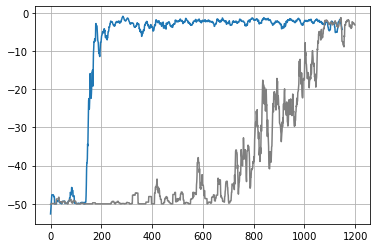

In [45]:
from scipy.signal import savgol_filter
np.savetxt('reach_tab_1.txt',total_reward,fmt='%d')

r = np.array(np.loadtxt('reach_tab_1.txt',dtype='int')).T
# r2 = np.array(np.loadtxt('reach_xrvav2l.txt',dtype='int')).T
# r3 = np.array(np.loadtxt('reach_xrvav2l_dnn.txt',dtype='int')).T

plt.figure; plt.plot(savgol_filter(np.array(r),11,1).T,color='tab:blue')
# plt.figure; plt.plot(savgol_filter(np.array(r[0:1200]),11,1).T,color='tab:gray')
plt.grid(b=True)
# plt.plot(savgol_filter(np.array(r14),801,1).T,color='tab:green',alpha=0.8)plt.plot(total_reward)
plt.savefig('demo.png', transparent=True)

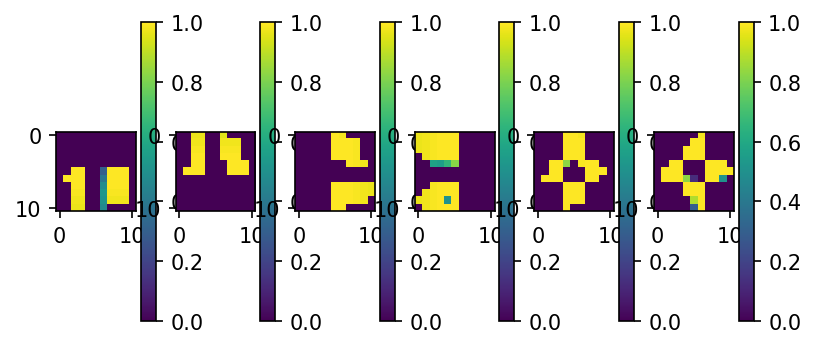

In [19]:
v1,v2,v3,v4,v5,v6=np.zeros((res,res)), np.zeros((res,res)), np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res))
xs = np.linspace(-0.3,0.3,res)
ys = np.linspace(-0.3,0.3,res)
for i in range(res):
    for j in range(res):
        v1[i,j] = fut_a_v2[i,j,5,0]
        v2[i,j] = fut_a_v2[i,j,5,1]
        v3[i,j] = fut_a_v2[i,j,5,2]
        v4[i,j] = fut_a_v2[i,j,5,3]
        v5[i,j] = fut_a_v2[i,j,5,4]
        v6[i,j] = fut_a_v2[i,j,5,5]
plt.figure(dpi=150)
plt.subplot(1,6,1);
plt.imshow(v1); plt.colorbar(); 
plt.subplot(1,6,2);
plt.imshow(v2); plt.colorbar(); 
plt.subplot(1,6,3);
plt.imshow(v3); plt.colorbar();  #plt.clim([-3,0])
plt.subplot(1,6,4);
plt.imshow(v4); plt.colorbar();
plt.subplot(1,6,5);
plt.imshow(v5); plt.colorbar();
plt.subplot(1,6,6);
plt.imshow(v6); plt.colorbar();plt.show() #plt.clim([-3,0]) 

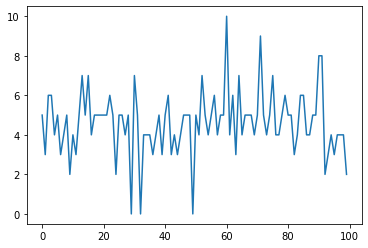

In [8]:
state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

# LEARN GFVs-------------------- (states are then changed by GVFs)

state0 = (res*((state[:,0]-state[:,-3]).detach().to('cpu').numpy() - min_0) / (max_0 - min_0)).astype(int)
state1 = (res*((state[:,1]-state[:,-2]).detach().to('cpu').numpy() - min_1) / (max_1 - min_1)).astype(int)
state2 = (res*((state[:,2]-state[:,-1]).detach().to('cpu').numpy() - min_2) / (max_2 - min_2)).astype(int)

plt.plot(state2)

In [ ]:
from IPython.display import clear_output
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sunblaze_envs
import numpy as np
import torch
import gym
import argparse
import os
import matplotlib.pyplot as plt

batch_size=256
buffer_size=1e6
NUM_GAMMAS=1
taus=np.linspace(5,100,NUM_GAMMAS)
GAMMAS=np.exp(-1/taus)
GAMMAS[-1]=0.99

GAMMAS=np.flip(GAMMAS)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GAMMAS=torch.tensor([GAMMAS for _ in range(batch_size)]).float().to(device)

# Implementation of Twin Delayed Deep Deterministic Policy Gradients (TD3)
# Paper: https://arxiv.org/abs/1802.09477

d=np.ones(NUM_GAMMAS)

distance_threshold=0.05
def goal_distance(goal_a, goal_b):
    assert goal_a.shape == goal_b.shape
    return np.linalg.norm(goal_a - goal_b, axis=-1)

class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(buffer_size)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 64)
        self.l4 = nn.Linear(64, action_dim)
        
        self.max_action = max_action
        

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = F.relu(self.l3(a))
        return self.max_action * torch.tanh(self.l4(a))


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 64)
        self.l4 = nn.Linear(64, 1)

        # Q2 architecture
        self.l5 = nn.Linear(state_dim + action_dim, 64)
        self.l6 = nn.Linear(64, 64)
        self.l7 = nn.Linear(64, 64)
        self.l8 = nn.Linear(64, 1)


    def forward(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = F.relu(self.l3(q1))
        q1 = self.l4(q1)

        q2 = F.relu(self.l5(sa))
        q2 = F.relu(self.l6(q2))
        q2 = F.relu(self.l7(q2))
        q2 = self.l8(q2)
        return q1, q2


    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = F.relu(self.l3(q1))
        q1 = self.l4(q1)
        return q1

    

class TD3(object):
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_freq=2
    ):

        self.actor = Actor(30, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(30, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)


        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq
        
        self.total_it = 0


    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()


    def train(self, replay_buffer, batch_size=256):
        self.total_it += 1

        # Sample replay buffer 
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)
        
        state0 = (res*((state[:,0]-state[:,3]).detach().to('cpu').numpy() - min_0) / (max_0 - min_0)).astype(int)
        state1 = (res*((state[:,1]-state[:,4]).detach().to('cpu').numpy() - min_1) / (max_1 - min_1)).astype(int)
        state2 = (res*((state[:,2]-state[:,5]).detach().to('cpu').numpy() - min_2) / (max_2 - min_2)).astype(int)
        state3 = (res*((state[:,3]-state[:,-3]).detach().to('cpu').numpy() - min_0) / (max_0 - min_0)).astype(int)
        state4 = (res*((state[:,4]-state[:,-2]).detach().to('cpu').numpy() - min_1) / (max_1 - min_1)).astype(int)
        state5 = (res*((state[:,5]-state[:,-1]).detach().to('cpu').numpy() - min_2) / (max_2 - min_2)).astype(int)
        
        nstate0 = (res*((next_state[:,0]-next_state[:,-3]).detach().to('cpu').numpy() - min_0) / (max_0 - min_0)).astype(int)
        nstate1 = (res*((next_state[:,1]-next_state[:,-2]).detach().to('cpu').numpy() - min_1) / (max_1 - min_1)).astype(int)
        nstate2 = (res*((next_state[:,2]-next_state[:,-1]).detach().to('cpu').numpy() - min_2) / (max_2 - min_2)).astype(int)

        state0[state0>(res-1)]=res-1; state1[state1>(res-1)]=res-1 ; state2[state2>(res-1)]=res-1
        state0[state0<0]=0; state1[state1<0]=0 ; state2[state2<0]=0

        nstate0[nstate0>(res-1)]=res-1; nstate1[nstate1>(res-1)]=res-1 ; nstate2[nstate2>(res-1)]=res-1
        nstate0[nstate0<0]=0; nstate1[nstate1<0]=0 ; nstate2[nstate2<0]=0

        

        state0 = torch.FloatTensor((state[:,0] - state[:,3]).detach().to('cpu').numpy()).to('cuda') #agent - object
        state1 = torch.FloatTensor((state[:,1] - state[:,4]).detach().to('cpu').numpy()).to('cuda')
        state2 = torch.FloatTensor((state[:,2] - state[:,5]).detach().to('cpu').numpy()).to('cuda')
        state3 = torch.FloatTensor((state[:,3] - state[:,-3]).detach().to('cpu').numpy()).to('cuda') #agent - reward
        state4 = torch.FloatTensor((state[:,4] - state[:,-2]).detach().to('cpu').numpy()).to('cuda')
        state5 = torch.FloatTensor((state[:,5] - state[:,-1]).detach().to('cpu').numpy()).to('cuda')

        nstate0 = torch.FloatTensor((next_state[:,0] - next_state[:,3]).detach().to('cpu').numpy()).to('cuda')
        nstate1 = torch.FloatTensor((next_state[:,1] - next_state[:,4]).detach().to('cpu').numpy()).to('cuda')
        nstate2 = torch.FloatTensor((next_state[:,2] - next_state[:,5]).detach().to('cpu').numpy()).to('cuda')
        nstate3 = torch.FloatTensor((next_state[:,3] - next_state[:,-3]).detach().to('cpu').numpy()).to('cuda')
        nstate4 = torch.FloatTensor((next_state[:,4] - next_state[:,-2]).detach().to('cpu').numpy()).to('cuda')
        nstate5 = torch.FloatTensor((next_state[:,5] - next_state[:,-1]).detach().to('cpu').numpy()).to('cuda')
    

        if t > args.start_timesteps:  
            with torch.no_grad():
                V1r = gvf1(torch.stack((state0,state1,state2),-1) )
                V1b = gvf1(torch.stack((state3,state4,state5),-1) )
                V2r = gvf2(torch.stack((state0,state1,state2),-1))
                V2b = gvf2(torch.stack((state3,state4,state5),-1))
                V3r = gvf3(torch.stack((state0,state1,state2),-1))
                
                V1rn = gvf1(torch.stack((nstate0,nstate1,nstate2),-1) )
                V1bn = gvf1(torch.stack((nstate3,nstate4,nstate5),-1) )
                V2rn = gvf2(torch.stack((nstate0,nstate1,nstate2),-1))
                V2bn = gvf2(torch.stack((nstate3,nstate4,nstate5),-1))
                V3rn = gvf3(torch.stack((nstate0,nstate1,nstate2),-1))
                
            state = V1r; state = torch.cat((state,V1b),-1); 
            state = torch.cat((state,V2r),-1); state = torch.cat((state,V2b),-1); 
            state = torch.cat((state,V3rn),-1); 
            
            next_state = V1rn; next_state = torch.cat((next_state,V1bn),-1); 
            next_state = torch.cat((next_state,V2rn),-1); next_state = torch.cat((next_state,V2bn),-1); 
            next_state = torch.cat((next_state,V3rn),-1);

           
            with torch.no_grad():
                # Select action according to policy and add clipped noise
                noise = (
                    torch.randn_like(action) * self.policy_noise
                ).clamp(-self.noise_clip, self.noise_clip)

                next_action = (
                    self.actor_target(next_state) + noise
                ).clamp(-self.max_action, self.max_action)

                # Compute the target Q value
                target_Q1, target_Q2 = self.critic_target(next_state, next_action)
                target_Q = torch.min(target_Q1, target_Q2)
                target_Q = reward + not_done * self.discount * target_Q

            # Get current Q estimates
            current_Q1, current_Q2 = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Delayed policy updates
            if self.total_it % self.policy_freq == 0:

                # Compute actor losse
                actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

                # Optimize the actor 
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update the frozen target models
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


        def save(self, filename):
            torch.save(self.critic.state_dict(), filename + "_critic")
            torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")

            torch.save(self.actor.state_dict(), filename + "_actor")
            torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")


        def load(self, filename):
            self.critic.load_state_dict(torch.load(filename + "_critic"))
            self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
            self.critic_target = copy.deepcopy(self.critic)

            self.actor.load_state_dict(torch.load(filename + "_actor"))
            self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
            self.actor_target = copy.deepcopy(self.actor)        

# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env_name, seed, eval_episodes=10):
    eval_env = gym.make(args.env)

#     eval_env = sunblaze_envs.make('SunblazeHopperRandomExtreme-v0')
    eval_env.seed(seed + 100)

    avg_reward = 0.
    frame=0
    for _ in range(eval_episodes):
        obs, done = eval_env.reset(), False
        state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
        state0 = state[0] - state[3]
        state1 = state[1] - state[4]
        state2 = state[2] - state[5]
        state3 = state[3] - state[-3]
        state4 = state[4] - state[-2]
        state5 = state[5] - state[-1]
        with torch.no_grad():
            V1r = gvf1(torch.FloatTensor([state0,state1,state2]).to('cuda'))
            V1b = gvf1(torch.FloatTensor([state3,state4,state5]).to('cuda'))
            V2r = gvf2(torch.FloatTensor([state0,state1,state2]).to('cuda'))
            V2b = gvf2(torch.FloatTensor([state3,state4,state5]).to('cuda'))
            V3r = gvf3(torch.FloatTensor([state0,state1,state2]).to('cuda'))


            full_s = V1r; full_s = torch.cat((full_s,V1b),-1)
            full_s = torch.cat((full_s,V2r),-1);  full_s = torch.cat((full_s,V2b),-1)
            full_s = torch.cat((full_s,V3r),-1)
    
        state = full_s.detach().to('cpu').numpy()
        while not done:
            frame+=1
            action = policy.select_action(np.array(state))
            obs, reward, done, _ = eval_env.step(action)
            state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
            state0 = state[0] - state[3]
            state1 = state[1] - state[4]
            state2 = state[2] - state[5]
            state3 = state[3] - state[-3]
            state4 = state[4] - state[-2]
            state5 = state[5] - state[-1]
            with torch.no_grad():
                V1r = gvf1(torch.FloatTensor([state0,state1,state2]).to('cuda'))
                V1b = gvf1(torch.FloatTensor([state3,state4,state5]).to('cuda'))
                V2r = gvf2(torch.FloatTensor([state0,state1,state2]).to('cuda'))
                V2b = gvf2(torch.FloatTensor([state3,state4,state5]).to('cuda'))
                V3r = gvf3(torch.FloatTensor([state0,state1,state2]).to('cuda'))


                full_s = V1r; full_s = torch.cat((full_s,V1b),-1)
                full_s = torch.cat((full_s,V2r),-1);  full_s = torch.cat((full_s,V2b),-1)
                full_s = torch.cat((full_s,V3r),-1)
            
            state = full_s.detach().to('cpu').numpy()
    
            avg_reward += reward

    avg_reward /= eval_episodes

    print("---------------------------------------")
    print(f"Frame: {frame_idx}. Evaluation over {frame} frames: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward


if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--policy", default="TD3")                  # Policy name (TD3, DDPG or OurDDPG)
    parser.add_argument("--env", default="FetchPush-v1")          # OpenAI gym environment name
    parser.add_argument("--seed", default=0, type=int)              # Sets Gym, PyTorch and Numpy seeds
    parser.add_argument("--start_timesteps", default=5e4, type=int)# Time steps initial random policy is used
    parser.add_argument("--eval_freq", default=1e4, type=int)       # How often (time steps) we evaluate
    parser.add_argument("--max_timesteps", default=3e7, type=int)   # Max time steps to run environment
    parser.add_argument("--expl_noise", default=0.1)                # Std of Gaussian exploration noise
    parser.add_argument("--batch_size", default=batch_size, type=int)      # Batch size for both actor and critic
    parser.add_argument("--discount", default=GAMMAS)               # Discount factor
    parser.add_argument("--tau", default=0.005)                     # Target network update rate
    parser.add_argument("--policy_noise", default=0.2)              # Noise added to target policy during critic update
    parser.add_argument("--noise_clip", default=0.5)                # Range to clip target policy noise
    parser.add_argument("--policy_freq", default=2, type=int)       # Frequency of delayed policy updates
    parser.add_argument("--save_model", action="store_true")        # Save model and optimizer parameters
    parser.add_argument("--load_model", default="")                 # Model load file name, "" doesn't load, "default" uses file_name
    args,unknown = parser.parse_known_args()
#     args = parser.parse_args()



    env = gym.make(args.env)

    # Set seeds
    env.seed(args.seed)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    
    state_dim = 31
    action_dim = 4
    max_action = float(env.action_space.high[0])

    kwargs = {
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action,
        "discount": args.discount,
        "tau": args.tau,
    }

    # Initialize policy
    if args.policy == "TD3":
        # Target policy smoothing is scaled wrt the action scale
        kwargs["policy_noise"] = args.policy_noise * max_action
        kwargs["noise_clip"] = args.noise_clip * max_action
        kwargs["policy_freq"] = args.policy_freq
        policy = TD3(**kwargs)

#     if args.load_model != "":ii
#         policy_file = file_name if args.load_model == "default" else args.load_model
#         policy.load(f"./models/{policy_file}")

    replay_buffer = ReplayBuffer(state_dim, action_dim)
    
    frame_idx=0
    # Evaluate untrained policy
    evaluations = []

    obs, done = env.reset(), False
    state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
                               
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0
    dif=[]
    total_reward=[]
    state_buffer , action_buffer , next_buffer, reward_buffer , done_buffer = [] , [] , [] , [] , []
    for t in range(int(args.max_timesteps)):
        frame_idx+=1
        episode_timesteps += 1

        # Select action randomly or according to policy
        if t < args.start_timesteps:
            action = env.action_space.sample()
        else:
            state0 = state[0] - state[3]
            state1 = state[1] - state[4]
            state2 = state[2] - state[5]
            state3 = state[3] - state[-3]
            state4 = state[4] - state[-2]
            state5 = state[5] - state[-1]
             
            with torch.no_grad():
                V1r = gvf1(torch.FloatTensor([state0,state1,state2]).to('cuda'))
                V1b = gvf1(torch.FloatTensor([state3,state4,state5]).to('cuda'))
                V2r = gvf2(torch.FloatTensor([state0,state1,state2]).to('cuda'))
                V2b = gvf2(torch.FloatTensor([state3,state4,state5]).to('cuda'))
                V3r = gvf3(torch.FloatTensor([state0,state1,state2]).to('cuda'))


            full_s = V1r; full_s = torch.cat((full_s,V1b),-1)
            full_s = torch.cat((full_s,V2r),-1);  full_s = torch.cat((full_s,V2b),-1)
            full_s = torch.cat((full_s,V3r),-1)

            action = (
                policy.select_action(np.array(full_s.detach().to('cpu').numpy()))
                + np.random.normal(0, max_action * args.expl_noise, size=action_dim)
            ).clip(-max_action, max_action)
            

        # Perform action
        obs, reward, done, _ = env.step(action) 
        next_state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
        done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

        state_buffer.append(state)
        action_buffer.append(action)
        next_buffer.append(next_state)
        reward_buffer.append(reward)
        done_buffer.append(done_bool)

        
        state = next_state
        episode_reward += reward

        # Train agent after collecting sufficient data
        if t >= batch_size:
            policy.train(replay_buffer, args.batch_size)

        if done: 
            
            for ib in range(len(reward_buffer)):
                replay_buffer.add(state_buffer[ib], action_buffer[ib], next_buffer[ib], reward_buffer[ib], done_buffer[ib])   
            
            final_pos = state_buffer[-1][[3,4,5]]
#             d = goal_distance(state_buffer[0][[3,4,5]] ,final_pos)
#         if d > distance_threshold:
            for ib in range(0,len(reward_buffer)):
                d = goal_distance(state_buffer[ib][[3,4,5]] ,final_pos)
                reward_buffer[ib] = -(d > distance_threshold).astype(np.float32)
                state_buffer[ib][[-3,-2,-1]] = final_pos
                next_buffer[ib][[-3,-2,-1]] = final_pos

            for ib in range(len(reward_buffer)):
                replay_buffer.add(state_buffer[ib], action_buffer[ib], next_buffer[ib], reward_buffer[ib], done_buffer[ib])

            state_buffer , action_buffer , next_buffer, reward_buffer , done_buffer = [] , [] , [] , [] , []
            # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
            if episode_num % 100 == 0:
                print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
            # Reset environment
            obs, done = env.reset(), False
            _, rww, _, _ = env.step(0) 
            while rww==0:
                obs = env.reset()
                _, rww, _, _ = env.step(env.action_space.sample())
                
            state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
            total_reward.append(episode_reward)
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1 

        
        # Evaluate episodE
        if (t + 1) % args.eval_freq == 0:
            clear_output(wait=True);
            evaluations.append(eval_policy(policy, args.env, args.seed))
#             r = np.loadtxt('rewards_50g_cheetah_full.txt',dtype='int')
#             r2 = np.loadtxt('rewards_cheetah_RE_50g_adaptive.txt',dtype='int')
#             plt.plot(r); 
#             plt.plot(r2)
            plt.figure(dpi=100)
            plt.subplot(2,1,1)
            plt.plot(evaluations);
            trr=np.array(total_reward)
            trr[trr==0]=-50
            plt.subplot(2,1,2)
            plt.plot(trr); plt.show()

# GVFs with DNNs

---------------------------------------
Frame: 33500. Evaluation over 500 frames: -49.300
---------------------------------------


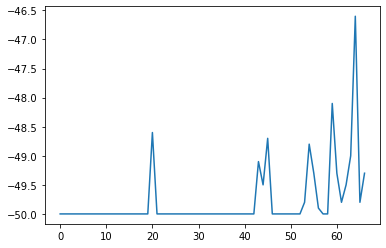

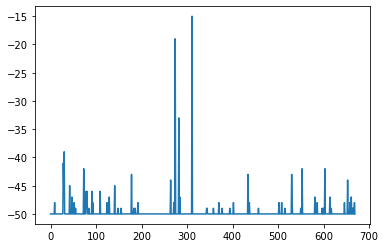

KeyboardInterrupt: 

In [14]:
from IPython.display import clear_output
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sunblaze_envs
import numpy as np
import torch
import gym
import argparse
import os
import matplotlib.pyplot as plt

batch_size=100
buffer_size=1e6
NUM_GAMMAS=1
taus=np.linspace(5,100,NUM_GAMMAS)
GAMMAS=np.exp(-1/taus)
GAMMAS[-1]=0.99

GAMMAS=np.flip(GAMMAS)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GAMMAS=torch.tensor([GAMMAS for _ in range(batch_size)]).float().to(device)

# Implementation of Twin Delayed Deep Deterministic Policy Gradients (TD3)
# Paper: https://arxiv.org/abs/1802.09477

d=np.ones(NUM_GAMMAS)


class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(buffer_size)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, action_dim)
        
        self.max_action = max_action
        

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 256)
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)


    def forward(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2


    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1


class GVF(nn.Module):
    def __init__(self, state_dim, num_gvfs):
        super(GVF, self).__init__()

        self.fc = nn.Sequential(

            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),            
            nn.Linear(64, num_gvfs)             
        )

    def forward(self, x):
        return self.fc(x)
num_gvfs = 6

class TD3(object):
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_freq=2
    ):

        self.actor = Actor(12, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(12, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

        self.gvf = GVF(6, num_gvfs).to(device)
        self.gvf_target = copy.deepcopy(self.gvf)
        self.gvf_optimizer = torch.optim.Adam(self.gvf.parameters(), lr=1e-3)
        
        self.gvf2 = GVF(6, num_gvfs).to(device)
        self.gvf_target2 = copy.deepcopy(self.gvf2)
        self.gvf_optimizer2 = torch.optim.Adam(self.gvf2.parameters(), lr=1e-3)
        
        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq
        
        self.total_it = 0


    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()


    def train(self, replay_buffer, batch_size=256):
        self.total_it += 1

        # Sample replay buffer 
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)
        
        # LEARN GFVs-------------------- (states are then changed by GVFs)
        if True:
            state0 = torch.FloatTensor((state[:,0]-state[:,-3]).detach().to('cpu').numpy()).to('cuda')
            state1 = torch.FloatTensor((state[:,1]-state[:,-2]).detach().to('cpu').numpy()).to('cuda')
            state2 = torch.FloatTensor((state[:,2]-state[:,-1]).detach().to('cpu').numpy()).to('cuda')

            nstate0 = torch.FloatTensor((next_state[:,0]-next_state[:,-3]).detach().to('cpu').numpy()).to('cuda')
            nstate1 = torch.FloatTensor((next_state[:,1]-next_state[:,-2]).detach().to('cpu').numpy()).to('cuda')
            nstate2 = torch.FloatTensor((next_state[:,2]-next_state[:,-1]).detach().to('cpu').numpy()).to('cuda')

    #         if t < args.start_timesteps:  
            theta=0.005; theta2=0.01
            threshold = 0.25 ; threshold2 = 0.25
            vel = [nstate0-state0,nstate1-state1,nstate2-state2]


            direct = torch.transpose(torch.stack(
                [(vel[0]>theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[2])<theta2)*1,
                (vel[0]<-theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[2])<theta2)*1,
                (vel[1]>theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[2])<theta2)*1,
                (vel[1]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[2])<theta2)*1,
                (vel[2]>theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[1])<theta2)*1,
                (vel[2]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[1])<theta2)*1]),0,1).float()


            utility = (reward==0).float()

            sr = self.gvf(state[:,[0,1,2,-3,-2,-1]])
            with torch.no_grad():
                srt = self.gvf_target(state[:,[0,1,2,-3,-2,-1]])
                srt_next = self.gvf_target(next_state[:,[0,1,2,-3,-2,-1]])
                srt_next2 = self.gvf_target2(next_state[:,[0,1,2,-3,-2,-1]])

                utility2 = (torch.reshape((torch.sum((srt[:,[2,3,4,5]]>threshold),1)>0).float(),(len(reward),1))* 
                            torch.reshape((torch.prod((srt[:,[1]]<threshold2),1)>0).float(),(len(reward),1))* 
                            (reward!=0).float()).float()
                utility2 = torch.cat((utility2,(torch.reshape((torch.sum((srt[:,[2,3,4,5]]>threshold),1)>0).float(),(len(reward),1))* 
                            torch.reshape((torch.prod((srt[:,[0]]<threshold2),1)>0).float(),(len(reward),1))* 
                            (reward!=0).float()).float()),1)
                utility2 = torch.cat((utility2,(torch.reshape((torch.sum((srt[:,[0,1,4,5]]>threshold),1)>0).float(),(len(reward),1))* 
                            torch.reshape((torch.prod((srt[:,[3]]<threshold2),1)>0).float(),(len(reward),1))* 
                            (reward!=0).float()).float()),1)
                utility2 = torch.cat((utility2,(torch.reshape((torch.sum((srt[:,[0,1,4,5]]>threshold),1)>0).float(),(len(reward),1))* 
                            torch.reshape((torch.prod((srt[:,[2]]<threshold2),1)>0).float(),(len(reward),1))* 
                            (reward!=0).float()).float()),1)
                utility2 = torch.cat((utility2,(torch.reshape((torch.sum((srt[:,[0,1,2,3]]>threshold),1)>0).float(),(len(reward),1))* 
                            torch.reshape((torch.prod((srt[:,[5]]<threshold2),1)>0).float(),(len(reward),1))* 
                            (reward!=0).float()).float()),1)
                utility2 = torch.cat((utility2,(torch.reshape((torch.sum((srt[:,[0,1,2,3]]>threshold),1)>0).float(),(len(reward),1))* 
                            torch.reshape((torch.prod((srt[:,[4]]<threshold2),1)>0).float(),(len(reward),1))* 
                            (reward!=0).float()).float()),1)
            sr2 = self.gvf2(state[:,[0,1,2,-3,-2,-1]])
        #         srt2 = self.gvf_target2(torch.stack((state0,state1,state2),-1))

            with torch.no_grad():
                sr_next = self.gvf(next_state[:,[0,1,2,-3,-2,-1]]) 
                sr_next2 = self.gvf2(next_state[:,[0,1,2,-3,-2,-1]]) 
                sr_target = utility + (torch.abs(1-utility)*0.99) * (srt_next )
                sr_target2 = utility2 + (torch.abs(1-utility2)*0.99) * (srt_next2)

            gvf_loss = nn.MSELoss()(sr[direct==1],sr_target[direct==1])
            gvf_loss2 = nn.MSELoss()(sr2[direct==1],sr_target2[direct==1])

            if self.total_it % 1000 == 0:
                self.gvf_target = copy.deepcopy(self.gvf)
                self.gvf_target2 = copy.deepcopy(self.gvf2)

            if t < args.start_timesteps*3:  
                
                # Optimize GVF 
                self.gvf_optimizer.zero_grad()
                gvf_loss.backward()
                self.gvf_optimizer.step()

                # Optimize GVF 
                self.gvf_optimizer2.zero_grad()
                gvf_loss2.backward()
                self.gvf_optimizer2.step()

        state = sr.detach()
        state = torch.cat((state,sr2.detach()),-1)

        next_state = sr_next.detach()
        next_state = torch.cat((next_state,sr_next2.detach()),-1)

        
#         state = state[:,[0,1,2,-3,-2,-1]]
#         next_state = next_state[:,[0,1,2,-3,-2,-1]]
        
        if t >= args.start_timesteps:     
            with torch.no_grad():
                # Select action according to policy and add clipped noise
                noise = (
                    torch.randn_like(action) * self.policy_noise
                ).clamp(-self.noise_clip, self.noise_clip)

                next_action = (
                    self.actor_target(next_state) + noise
                ).clamp(-self.max_action, self.max_action)

                # Compute the target Q value
                target_Q1, target_Q2 = self.critic_target(next_state, next_action)
                target_Q = torch.min(target_Q1, target_Q2)
                target_Q = reward + not_done * self.discount * target_Q

            # Get current Q estimates
            current_Q1, current_Q2 = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Delayed policy updates
            if self.total_it % self.policy_freq == 0:

                # Compute actor losse
                actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

                # Optimize the actor 
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update the frozen target models
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


        def save(self, filename):
            torch.save(self.critic.state_dict(), filename + "_critic")
            torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")

            torch.save(self.actor.state_dict(), filename + "_actor")
            torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")


        def load(self, filename):
            self.critic.load_state_dict(torch.load(filename + "_critic"))
            self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
            self.critic_target = copy.deepcopy(self.critic)

            self.actor.load_state_dict(torch.load(filename + "_actor"))
            self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
            self.actor_target = copy.deepcopy(self.actor)        

# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env_name, seed, eval_episodes=10):
    eval_env = gym.make(args.env)

#     eval_env = sunblaze_envs.make('SunblazeHopperRandomExtreme-v0')
    eval_env.seed(seed + 100)

    avg_reward = 0.
    frame=0
    for _ in range(eval_episodes):
        obs, done = eval_env.reset(), False
        state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
        state0 = state[0]-state[-3]
        state1 = state[1]-state[-2]
        state2 = state[2]-state[-1]
        full_s = policy.gvf(torch.FloatTensor(state[[0,1,2,-3,-2,-1]]).to('cuda'))
        full_s = torch.cat((full_s,policy.gvf2(torch.FloatTensor(state[[0,1,2,-3,-2,-1]]).to('cuda'))),-1)     
        state = full_s.detach().to('cpu').numpy()
        
#         state = state[[0,1,2,-3,-2,-1]]
        while not done:
            frame+=1
            action = policy.select_action(np.array(state))
            obs, reward, done, _ = eval_env.step(action)
            state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
            state0 = state[0]-state[-3]
            state1 = state[1]-state[-2]
            state2 = state[2]-state[-1]
            full_s = policy.gvf(torch.FloatTensor(state[[0,1,2,-3,-2,-1]]).to('cuda')) 
            full_s = torch.cat((full_s,policy.gvf2(torch.FloatTensor(state[[0,1,2,-3,-2,-1]]).to('cuda'))),-1)     
            state = full_s.detach().to('cpu').numpy()
#             state = state[[0,1,2,-3,-2,-1]]
            avg_reward += reward

    avg_reward /= eval_episodes

    print("---------------------------------------")
    print(f"Frame: {frame_idx}. Evaluation over {frame} frames: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward


if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--policy", default="TD3")                  # Policy name (TD3, DDPG or OurDDPG)
    parser.add_argument("--env", default="FetchReach-v1")          # OpenAI gym environment name
    parser.add_argument("--seed", default=0, type=int)              # Sets Gym, PyTorch and Numpy seeds
    parser.add_argument("--start_timesteps", default=10001, type=int)# Time steps initial random policy is used
    parser.add_argument("--eval_freq", default=5e2, type=int)       # How often (time steps) we evaluate
    parser.add_argument("--max_timesteps", default=3e6, type=int)   # Max time steps to run environment
    parser.add_argument("--expl_noise", default=0.1)                # Std of Gaussian exploration noise
    parser.add_argument("--batch_size", default=batch_size, type=int)      # Batch size for both actor and critic
    parser.add_argument("--discount", default=GAMMAS)               # Discount factor
    parser.add_argument("--tau", default=0.005)                     # Target network update rate
    parser.add_argument("--policy_noise", default=0.2)              # Noise added to target policy during critic update
    parser.add_argument("--noise_clip", default=0.5)                # Range to clip target policy noise
    parser.add_argument("--policy_freq", default=2, type=int)       # Frequency of delayed policy updates
    parser.add_argument("--save_model", action="store_true")        # Save model and optimizer parameters
    parser.add_argument("--load_model", default="")                 # Model load file name, "" doesn't load, "default" uses file_name
    args,unknown = parser.parse_known_args()
#     args = parser.parse_args()ii



    env = gym.make(args.env)
#     env = sunblaze_envs.make('SunblazeHopperRandomNormal-v0')
    # Set seeds
    env.seed(args.seed)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    
    state_dim = 16
    action_dim = 4
    max_action = float(env.action_space.high[0])

    kwargs = {
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action,
        "discount": args.discount,
        "tau": args.tau,
    }

    # Initialize policy
    if args.policy == "TD3":
        # Target policy smoothing is scaled wrt the action scale
        kwargs["policy_noise"] = args.policy_noise * max_action
        kwargs["noise_clip"] = args.noise_clip * max_action
        kwargs["policy_freq"] = args.policy_freq
        policy = TD3(**kwargs)

#     if args.load_model != "":
#         policy_file = file_name if args.load_model == "default" else args.load_model
#         policy.load(f"./models/{policy_file}")ii

    replay_buffer = ReplayBuffer(state_dim, action_dim)
    
    frame_idx=0
    # Evaluate untrained policy
    evaluations = []

    obs, done = env.reset(), False
    state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
                               
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0
    dif=[]
    total_reward=[]
    gvf = GVF(3, 1).to(device)
    gvf_optimizer = torch.optim.Adam(gvf.parameters(), lr=1e-3)

    for t in range(int(args.max_timesteps)):
        frame_idx+=1
        episode_timesteps += 1

        # Select action randomly or according to policy
        if t < args.start_timesteps:
            action = env.action_space.sample()
        else:
#             state0 = state[0]-state[-3]
#             state1 = state[1]-state[-2]
#             state2 = state[2]-state[-1]
            full_s = policy.gvf(torch.FloatTensor(state[[0,1,2,-3,-2,-1]]).to('cuda'))
            full_s = torch.cat((full_s,policy.gvf2(torch.FloatTensor(state[[0,1,2,-3,-2,-1]]).to('cuda'))),-1)   
            full_s = np.array(full_s.detach().to('cpu').numpy())
            
#             full_s = state[[0,1,2,-3,-2,-1]]
            action = (
                policy.select_action(full_s)
                + np.random.normal(0, max_action * args.expl_noise, size=action_dim)
            ).clip(-max_action, max_action)
            

        # Perform action
        obs, reward, done, _ = env.step(action) 
        next_state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
        done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

        # Store data in replay buffer
        replay_buffer.add(state, action, next_state, reward, done_bool)
        
        state = next_state
        episode_reward += reward

        # Train agent after collecting sufficient data
        if t >= 1:
            policy.train(replay_buffer, args.batch_size)

        if done: 
            # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
            if episode_num % 100 == 0:
                print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
            # Reset environment
            obs, done = env.reset(), False
            state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
            total_reward.append(episode_reward)
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1 

        
        # Evaluate episodE
        if (t + 1) % args.eval_freq == 0:
            clear_output(wait=True);
            evaluations.append(eval_policy(policy, args.env, args.seed))
#             r = np.loadtxt('rewards_50g_cheetah_full.txt',dtype='int')
#             r2 = np.loadtxt('rewards_cheetah_RE_50g_adaptive.txt',dtype='int')
#             plt.plot(r); 
#             plt.plot(r2)
            plt.plot(evaluations); plt.show()
            plt.plot(total_reward); plt.show()
                               
#             v, v1, v2, v3, v4, v5, v6, v7 =np.zeros((100,100)), np.zeros((100,100)),np.zeros((100,100)),np.zeros((100,100)),np.zeros((100,100)),np.zeros((100,100)),np.zeros((100,100)),np.zeros((100,100))
#             xs = np.linspace(-0.3,0.3,100)
#             ys = np.linspace(-0.3,0.3,100)
#             for i in range(100):
#                 for j in range(100):                    
#                     v[i,j] = policy.gvf(torch.FloatTensor([xs[i],ys[j],0,0,0,0]).T.to('cuda'))[0].detach().to('cpu').numpy()
#                     v1[i,j] = policy.gvf(torch.FloatTensor([xs[i],ys[j],0,0,0,0]).T.to('cuda'))[1].detach().to('cpu').numpy()
#                     v2[i,j] = policy.gvf(torch.FloatTensor([xs[i],ys[j],0,0,0,0]).T.to('cuda'))[2].detach().to('cpu').numpy()
#                     v3[i,j] = policy.gvf(torch.FloatTensor([xs[i],ys[j],0,0,0,0]).T.to('cuda'))[3].detach().to('cpu').numpy()
#                     v4[i,j] = policy.gvf2(torch.FloatTensor([xs[i],ys[j],0,0,0,0]).T.to('cuda'))[0].detach().to('cpu').numpy()
#                     v5[i,j] = policy.gvf2(torch.FloatTensor([xs[i],ys[j],0,0,0,0]).T.to('cuda'))[1].detach().to('cpu').numpy()
#                     v6[i,j] = policy.gvf2(torch.FloatTensor([xs[i],ys[j],0,0,0,0]).T.to('cuda'))[2].detach().to('cpu').numpy()
#                     v7[i,j] = policy.gvf2(torch.FloatTensor([xs[i],ys[j],0,0,0,0]).T.to('cuda'))[3].detach().to('cpu').numpy()
#             plt.subplot(3,3,1);
#             plt.imshow(v); plt.colorbar();  #plt.clim([-3,0])
#             plt.subplot(3,3,2);
#             plt.imshow(v1); plt.colorbar();  #plt.clim([-3,0])
#             plt.subplot(3,3,3);
#             plt.imshow(v2); plt.colorbar();  #plt.clim([-3,0])
#             plt.subplot(3,3,4);
#             plt.imshow(v3); plt.colorbar();  #plt.clim([-3,0])
#             plt.subplot(3,3,5);
#             plt.imshow(v4); plt.colorbar();  #plt.clim([-3,0])
#             plt.subplot(3,3,6);
#             plt.imshow(v5); plt.colorbar();  #plt.clim([-3,0])
#             plt.subplot(3,3,7);
#             plt.imshow(v6); plt.colorbar(); 
#             plt.subplot(3,3,8);
#             plt.imshow(v7); plt.colorbar(); plt.show() #plt.clim([-3,0])
            
            

In [28]:
obs

{'observation': array([ 1.34183265e+00,  7.49100387e-01,  5.34722720e-01,  1.97805133e-04,
         7.15193042e-05,  7.73933014e-06,  5.51992816e-08, -2.42927453e-06,
         4.73325650e-06, -2.28455228e-06]),
 'achieved_goal': array([1.34183265, 0.74910039, 0.53472272]),
 'desired_goal': array([1.28624232, 0.6993848 , 0.53999596])}

In [8]:
v, v1, v2, v3, v4, v5, v6, v7 =np.zeros((100,100)), np.zeros((100,100)),np.zeros((100,100)),np.zeros((100,100)),np.zeros((100,100)),np.zeros((100,100)),np.zeros((100,100)),np.zeros((100,100))
xs = np.linspace(-0.3,0.3,100)
ys = np.linspace(-0.3,0.3,100)
for i in range(100):
    for j in range(100):                    
        v[i,j] = policy.gvf(torch.FloatTensor([xs[i],ys[j],0.5,0,0,0.5]).T.to('cuda'))[0].detach().to('cpu').numpy()
        v1[i,j] = policy.gvf(torch.FloatTensor([xs[i],ys[j],0.5,0,0,0.5]).T.to('cuda'))[1].detach().to('cpu').numpy()
        v2[i,j] = policy.gvf(torch.FloatTensor([xs[i],ys[j],0.5,0,0,0.5]).T.to('cuda'))[2].detach().to('cpu').numpy()
        v3[i,j] = policy.gvf(torch.FloatTensor([xs[i],ys[j],0.5,0,0,0.5]).T.to('cuda'))[3].detach().to('cpu').numpy()
        v4[i,j] = policy.gvf2(torch.FloatTensor([xs[i],ys[j],0.5,0,0,0.5]).T.to('cuda'))[0].detach().to('cpu').numpy()
        v5[i,j] = policy.gvf2(torch.FloatTensor([xs[i],ys[j],0.5,0,0,0.5]).T.to('cuda'))[1].detach().to('cpu').numpy()
        v6[i,j] = policy.gvf2(torch.FloatTensor([xs[i],ys[j],0.5,0,0,0.5]).T.to('cuda'))[2].detach().to('cpu').numpy()
        v7[i,j] = policy.gvf2(torch.FloatTensor([xs[i],ys[j],0.5,0,0,0.5]).T.to('cuda'))[3].detach().to('cpu').numpy()
plt.subplot(3,3,1);
plt.imshow(v); plt.colorbar();  #plt.clim([-3,0])
plt.subplot(3,3,2);
plt.imshow(v1); plt.colorbar();  #plt.clim([-3,0])
plt.subplot(3,3,3);
plt.imshow(v2); plt.colorbar();  #plt.clim([-3,0])
plt.subplot(3,3,4);
plt.imshow(v3); plt.colorbar();  #plt.clim([-3,0])
plt.subplot(3,3,5);
plt.imshow(v4); plt.colorbar();  #plt.clim([-3,0])
plt.subplot(3,3,6);
plt.imshow(v5); plt.colorbar();  #plt.clim([-3,0])
plt.subplot(3,3,7);
plt.imshow(v6); plt.colorbar(); 
plt.subplot(3,3,8);
plt.imshow(v7); plt.colorbar(); plt.show() #plt.clim([-3,0])


array(0.11333381, dtype=float32)

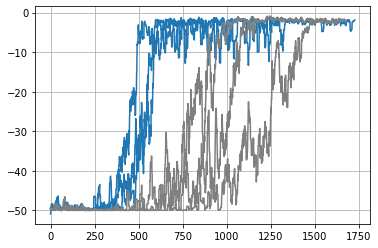

In [3]:
from scipy.signal import savgol_filter
np.savetxt('reach_2l(xr)_3.txt',total_reward,fmt='%d')

r = np.array(np.loadtxt('reach_2l(xr).txt',dtype='int')).T
r2 = np.array(np.loadtxt('reach_2l(xr)_2.txt',dtype='int')).T
r3 = np.array(np.loadtxt('reach_2l(xr)_3.txt',dtype='int')).T

r4 = np.array(np.loadtxt('reach_xr.txt',dtype='int')).T
r5 = np.array(np.loadtxt('reach_xr2.txt',dtype='int')).T
r6 = np.array(np.loadtxt('reach_xr3.txt',dtype='int')).T

plt.figure; plt.plot(savgol_filter(np.array(r),11,1).T,color='tab:blue')
plt.plot(savgol_filter(np.array(r2),11,1).T,color='tab:blue')
plt.plot(savgol_filter(np.array(r3),11,1).T,color='tab:blue')
plt.plot(savgol_filter(np.array(r4),11,1).T,color='tab:gray')
plt.plot(savgol_filter(np.array(r5),11,1).T,color='tab:gray')
plt.plot(savgol_filter(np.array(r6),11,1).T,color='tab:gray')

plt.grid(b=True)
# plt.plot(savgol_filter(np.array(r14),801,1).T,color='tab:green',alpha=0.8)plt.plot(total_reward)
plt.savefig('demo.png', transparent=True)

### Fetch Push

---------------------------------------
Frame: 200000. Evaluation over 500 frames: -50.000
---------------------------------------


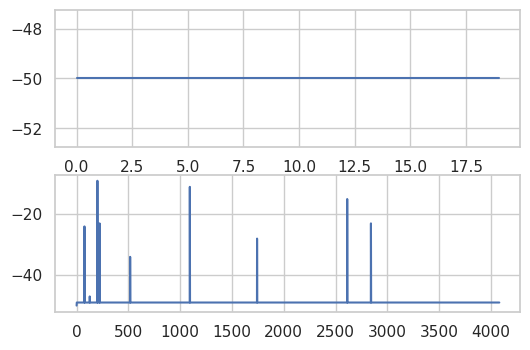

Total T: 200950 Episode Num: 4101 Episode T: 49 Reward: -49.000


KeyboardInterrupt: 

In [18]:
from IPython.display import clear_output
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sunblaze_envs
import numpy as np
import torch
import gym
import argparse
import os
import matplotlib.pyplot as plt

batch_size=100
buffer_size=1e6
NUM_GAMMAS=1
taus=np.linspace(5,100,NUM_GAMMAS)
GAMMAS=np.exp(-1/taus)
GAMMAS[-1]=0.99

GAMMAS=np.flip(GAMMAS)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GAMMAS=torch.tensor([GAMMAS for _ in range(batch_size)]).float().to(device)

# Implementation of Twin Delayed Deep Deterministic Policy Gradients (TD3)
# Paper: https://arxiv.org/abs/1802.09477

d=np.ones(NUM_GAMMAS)

distance_threshold=0.05
def goal_distance(goal_a, goal_b):
    assert goal_a.shape == goal_b.shape
    return np.linalg.norm(goal_a - goal_b, axis=-1)

class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(buffer_size)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 64)
        self.l4 = nn.Linear(64, action_dim)
        
        self.max_action = max_action
        

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = F.relu(self.l3(a))
        return self.max_action * torch.tanh(self.l4(a))


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 64)
        self.l4 = nn.Linear(64, 1)

        # Q2 architecture
        self.l5 = nn.Linear(state_dim + action_dim, 64)
        self.l6 = nn.Linear(64, 64)
        self.l7 = nn.Linear(64, 64)
        self.l8 = nn.Linear(64, 1)


    def forward(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = F.relu(self.l3(q1))
        q1 = self.l4(q1)

        q2 = F.relu(self.l5(sa))
        q2 = F.relu(self.l6(q2))
        q2 = F.relu(self.l7(q2))
        q2 = self.l8(q2)
        return q1, q2


    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = F.relu(self.l3(q1))
        q1 = self.l4(q1)
        return q1


class GVF(nn.Module):
    def __init__(self, state_dim, num_gvfs):
        super(GVF, self).__init__()

        self.fc = nn.Sequential(

            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),            
            nn.Linear(64, num_gvfs)             
        )

    def forward(self, x):
        return self.fc(x)
num_gvfs = 6

class TD3(object):
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_freq=2
    ):

        self.actor = Actor(19, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(19, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

        self.gvf1 = GVF(5, 4).to(device)
        self.gvf_target1 = copy.deepcopy(self.gvf1)
        self.gvf_optimizer1 = torch.optim.Adam(self.gvf1.parameters(), lr=1e-3)
        
        self.gvf2 = GVF(5, 6).to(device)
        self.gvf_target2 = copy.deepcopy(self.gvf2)
        self.gvf_optimizer2 = torch.optim.Adam(self.gvf2.parameters(), lr=1e-3)


        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq
        
        self.total_it = 0


    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()


    def train(self, replay_buffer, batch_size=256):
        self.total_it += 1

        # Sample replay buffer 
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)
        
        # LEARN GFVs----------------------------
        if t > args.start_timesteps*2: 
    
            state0 = torch.FloatTensor((state[:,0] - state[:,3]).detach().to('cpu').numpy()).to('cuda') #agent - object
            state1 = torch.FloatTensor((state[:,1] - state[:,4]).detach().to('cpu').numpy()).to('cuda')
            state2 = torch.FloatTensor((state[:,2] - state[:,5]).detach().to('cpu').numpy()).to('cuda')
            state3 = torch.FloatTensor((state[:,3] - state[:,-3]).detach().to('cpu').numpy()).to('cuda') #object - reward
            state4 = torch.FloatTensor((state[:,4] - state[:,-2]).detach().to('cpu').numpy()).to('cuda')

            nstate0 = torch.FloatTensor((next_state[:,0] - next_state[:,3]).detach().to('cpu').numpy()).to('cuda')
            nstate1 = torch.FloatTensor((next_state[:,1] - next_state[:,4]).detach().to('cpu').numpy()).to('cuda')
            nstate2 = torch.FloatTensor((next_state[:,2] - next_state[:,5]).detach().to('cpu').numpy()).to('cuda')
            nstate3 = torch.FloatTensor((next_state[:,3] - next_state[:,-3]).detach().to('cpu').numpy()).to('cuda')
            nstate4 = torch.FloatTensor((next_state[:,4] - next_state[:,-2]).detach().to('cpu').numpy()).to('cuda')



            theta=0.005; theta2=0.01
            threshold = 0.3 ; threshold2 = 0.3
            theta_box=0.005

            vel = [torch.FloatTensor((next_state[:,0] - state[:,0]).detach().to('cpu').numpy()).to('cuda'),
                   torch.FloatTensor((next_state[:,1] - state[:,1]).detach().to('cpu').numpy()).to('cuda'),
                  torch.FloatTensor((state[:,2] - state[:,5]).detach().to('cpu').numpy()).to('cuda'),   #relative position in z
                  torch.FloatTensor((next_state[:,2] - state[:,2]).detach().to('cpu').numpy()).to('cuda')]   #velocity in z

            vel_box = [torch.FloatTensor((next_state[:,3] - state[:,3]).detach().to('cpu').numpy()).to('cuda'),
                   torch.FloatTensor((next_state[:,4] - state[:,4]).detach().to('cpu').numpy()).to('cuda')]

            direct1 = torch.transpose(torch.stack(
                [(vel[0]>theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
                (vel[0]<-theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
                (vel[1]>theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
                (vel[1]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[3])<theta2)*1]),0,1).float()


            direct2 = torch.transpose(torch.stack(
                [(vel[0]>theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
                (vel[0]<-theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
                (vel[1]>theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
                (vel[1]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
                (vel[3]>theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[1])<theta2)*1,
                (vel[3]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[1])<theta2)*1]),0,1).float()
            
            
            utility_r = (reward==0).float()

            utility_box = torch.transpose(torch.stack(
                [(vel_box[0]>theta_box)*1 * (torch.abs(vel[2])<theta2)*1,
                (vel_box[0]<-theta_box)*1 * (torch.abs(vel[2])<theta2)*1,
                (vel_box[1]>theta_box)*1 * (torch.abs(vel[2])<theta2)*1 ,
                (vel_box[1]<-theta_box)*1 * (torch.abs(vel[2])<theta2)*1]),0,1).float()

            utility1 = utility_box * utility_r


            box_still = torch.transpose(torch.stack(
                [(torch.abs(vel_box[0])<0.0005)*1 * (torch.abs(vel_box[1])<0.0005)*1]),0,1).float()

            V1 = self.gvf1(torch.stack((state0,state1,state2,state3,state4),-1)) 
            V2 = self.gvf2(torch.stack((state0,state1,state2,state3,state4),-1)) 


            with torch.no_grad():
                Vt1 = self.gvf_target1(torch.stack((state0,state1,state2,state3,state4),-1))
                Vt2 = self.gvf_target2(torch.stack((state0,state1,state2,state3,state4),-1))
                Vt1_next = self.gvf_target1(torch.stack((nstate0,nstate1,nstate2,nstate3,nstate4),-1))
                Vt2_next = self.gvf_target2(torch.stack((nstate0,nstate1,nstate2,nstate3,nstate4),-1))                

            utility2 = (torch.reshape((torch.sum((Vt1[:,[2,3]]),1)).float(),(len(reward),1))).float() 
            utility2 = torch.cat((utility2,(torch.reshape((torch.sum((Vt1[:,[2,3]]),1)).float(),(len(reward),1))).float()),1)   
            utility2 = torch.cat((utility2,(torch.reshape((torch.sum((Vt1[:,[0,1]]),1)).float(),(len(reward),1))).float()),1)   
            utility2 = torch.cat((utility2,(torch.reshape((torch.sum((Vt1[:,[0,1]]),1)).float(),(len(reward),1))).float()),1)   
            utility2 = torch.cat((utility2,(torch.reshape((torch.sum((Vt1[:,[0,1,2,3]]),1)).float(),(len(reward),1))).float()),1)   
            utility2 = torch.cat((utility2,(torch.reshape((torch.sum((Vt1[:,[0,1,2,3]]),1)).float(),(len(reward),1))).float()),1)    

        #     utility2 = utility2 * box_still


            with torch.no_grad():
                V1_target = utility1 + (torch.abs(1-utility1)*0.99) * (self.gvf_target1(torch.stack((nstate0,nstate1,nstate2,nstate3,nstate4),-1)) )
                V2_target = utility2 + (torch.abs(1-utility2)*0.99) * (self.gvf_target2(torch.stack((nstate0,nstate1,nstate2,nstate3,nstate4),-1)) )


            gvf_loss1 = nn.MSELoss()(V1[direct1==1],V1_target[direct1==1])
            gvf_loss2 = nn.MSELoss()(V2[direct2==1],V2_target[direct2==1])

            if t < args.start_timesteps*3:  
                if self.total_it % 1000 == 0:
                    self.gvf_target1 = copy.deepcopy(self.gvf1)
                    self.gvf_target2 = copy.deepcopy(self.gvf2)

                # Optimize GVF 
                self.gvf_optimizer1.zero_grad()
                gvf_loss1.backward()
                self.gvf_optimizer1.step()

            #     # Optimize GVF 
                self.gvf_optimizer2.zero_grad()
                gvf_loss2.backward()
                self.gvf_optimizer2.step()

            state = torch.cat((state[:,[0,1,2,3,4,5,-3,-2,-1]],Vt1),-1)
            state = torch.cat((state,Vt2),-1)

            next_state = torch.cat((next_state[:,[0,1,2,3,4,5,-3,-2,-1]],Vt1_next),-1)
            next_state = torch.cat((next_state,Vt2_next),-1)

        if t >= args.start_timesteps*3:     
            with torch.no_grad():
                # Select action according to policy and add clipped noise
                noise = (
                    torch.randn_like(action) * self.policy_noise
                ).clamp(-self.noise_clip, self.noise_clip)

                next_action = (
                    self.actor_target(next_state) + noise
                ).clamp(-self.max_action, self.max_action)

                # Compute the target Q value
                target_Q1, target_Q2 = self.critic_target(next_state, next_action)
                target_Q = torch.min(target_Q1, target_Q2)
                target_Q = reward + not_done * self.discount * target_Q

            # Get current Q estimates
            current_Q1, current_Q2 = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Delayed policy updates
            if self.total_it % self.policy_freq == 0:

                # Compute actor losse
                actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

                # Optimize the actor 
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update the frozen target models
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


        def save(self, filename):
            torch.save(self.critic.state_dict(), filename + "_critic")
            torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")

            torch.save(self.actor.state_dict(), filename + "_actor")
            torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")


        def load(self, filename):
            self.critic.load_state_dict(torch.load(filename + "_critic"))
            self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
            self.critic_target = copy.deepcopy(self.critic)

            self.actor.load_state_dict(torch.load(filename + "_actor"))
            self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
            self.actor_target = copy.deepcopy(self.actor)        

# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env_name, seed, eval_episodes=10):
    eval_env = gym.make(args.env)

#     eval_env = sunblaze_envs.make('SunblazeHopperRandomExtreme-v0')
    eval_env.seed(seed + 100)

    avg_reward = 0.
    frame=0
    for _ in range(eval_episodes):
        obs, done = eval_env.reset(), False
        state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
        state0 = state[0] - state[3]
        state1 = state[1] - state[4]
        state2 = state[2] - state[5]
        state3 = state[3] - state[-3]
        state4 = state[4] - state[-2]
        with torch.no_grad():
            vt1 = policy.gvf1(torch.FloatTensor([state0,state1,state2,state3,state4]).to('cuda'))
            vt2 = policy.gvf2(torch.FloatTensor([state0,state1,state2,state3,state4]).to('cuda'))

        full_s = torch.cat((torch.FloatTensor(state[[0,1,2,3,4,5,-3,-2,-1]]).to('cuda'),vt1),-1)
        full_s = torch.cat((full_s,vt2),-1)
    
        state = full_s.detach().to('cpu').numpy()
        while not done:
            frame+=1
            action = policy.select_action(np.array(state))
            obs, reward, done, _ = eval_env.step(action)
            state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
            state0 = state[0] - state[3]
            state1 = state[1] - state[4]
            state2 = state[2] - state[5]
            state3 = state[3] - state[-3]
            state4 = state[4] - state[-2]
            with torch.no_grad():
                vt1 = policy.gvf1(torch.FloatTensor([state0,state1,state2,state3,state4]).to('cuda'))
                vt2 = policy.gvf2(torch.FloatTensor([state0,state1,state2,state3,state4]).to('cuda'))

            full_s = torch.cat((torch.FloatTensor(state[[0,1,2,3,4,5,-3,-2,-1]]).to('cuda'),vt1),-1)
            full_s = torch.cat((full_s,vt2),-1)
            state = full_s.detach().to('cpu').numpy()
            avg_reward += reward

    avg_reward /= eval_episodes

    print("---------------------------------------")
    print(f"Frame: {frame_idx}. Evaluation over {frame} frames: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward


if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--policy", default="TD3")                  # Policy name (TD3, DDPG or OurDDPG)
    parser.add_argument("--env", default="FetchPush-v1")          # OpenAI gym environment name
    parser.add_argument("--seed", default=0, type=int)              # Sets Gym, PyTorch and Numpy seeds
    parser.add_argument("--start_timesteps", default=1e5, type=int)# Time steps initial random policy is used
    parser.add_argument("--eval_freq", default=1e4, type=int)       # How often (time steps) we evaluate
    parser.add_argument("--max_timesteps", default=3e6, type=int)   # Max time steps to run environment
    parser.add_argument("--expl_noise", default=0.1)                # Std of Gaussian exploration noise
    parser.add_argument("--batch_size", default=batch_size, type=int)      # Batch size for both actor and critic
    parser.add_argument("--discount", default=GAMMAS)               # Discount factor
    parser.add_argument("--tau", default=0.005)                     # Target network update rate
    parser.add_argument("--policy_noise", default=0.2)              # Noise added to target policy during critic update
    parser.add_argument("--noise_clip", default=0.5)                # Range to clip target policy noise
    parser.add_argument("--policy_freq", default=2, type=int)       # Frequency of delayed policy updates
    parser.add_argument("--save_model", action="store_true")        # Save model and optimizer parameters
    parser.add_argument("--load_model", default="")                 # Model load file name, "" doesn't load, "default" uses file_name
    args,unknown = parser.parse_known_args()
#     args = parser.parse_args()



    env = gym.make(args.env)

    # Set seeds
    env.seed(args.seed)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    
    state_dim = 31
    action_dim = 4
    max_action = float(env.action_space.high[0])

    kwargs = {
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action,
        "discount": args.discount,
        "tau": args.tau,
    }

    # Initialize policy
    if args.policy == "TD3":
        # Target policy smoothing is scaled wrt the action scale
        kwargs["policy_noise"] = args.policy_noise * max_action
        kwargs["noise_clip"] = args.noise_clip * max_action
        kwargs["policy_freq"] = args.policy_freq
        policy = TD3(**kwargs)

#     if args.load_model != "":ii
#         policy_file = file_name if args.load_model == "default" else args.load_model
#         policy.load(f"./models/{policy_file}")

    replay_buffer = ReplayBuffer(state_dim, action_dim)
    
    frame_idx=0
    # Evaluate untrained policy
    evaluations = []

    obs, done = env.reset(), False
    state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
                               
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0
    dif=[]
    total_reward=[]
    state_buffer , action_buffer , next_buffer, reward_buffer , done_buffer = [] , [] , [] , [] , []
    for t in range(int(args.max_timesteps)):
        frame_idx+=1
        episode_timesteps += 1

        # Select action randomly or according to policy
        if t < args.start_timesteps*3:
            action = env.action_space.sample()
        else:
            state0 = state[0] - state[3]
            state1 = state[1] - state[4]
            state2 = state[2] - state[5]
            state3 = state[3] - state[-3]
            state4 = state[4] - state[-2]
            with torch.no_grad():
                vt1 = policy.gvf1(torch.FloatTensor([state0,state1,state2,state3,state4]).to('cuda'))
                vt2 = policy.gvf2(torch.FloatTensor([state0,state1,state2,state3,state4]).to('cuda'))

            full_s = torch.cat((torch.FloatTensor(state[[0,1,2,3,4,5,-3,-2,-1]]).to('cuda'),vt1),-1)
            full_s = torch.cat((full_s,vt2),-1)
            action = (
                policy.select_action(np.array(full_s.detach().to('cpu').numpy()))
                + np.random.normal(0, max_action * args.expl_noise, size=action_dim)
            ).clip(-max_action, max_action)
            

        # Perform action
        obs, reward, done, _ = env.step(action) 
        next_state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
        done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

        state_buffer.append(state)
        action_buffer.append(action)
        next_buffer.append(next_state)
        reward_buffer.append(reward)
        done_buffer.append(done_bool)

        
        state = next_state
        episode_reward += reward

        # Train agent after collecting sufficient data
        if t >= batch_size:
            policy.train(replay_buffer, args.batch_size)

        if done: 
            
            for ib in range(len(reward_buffer)):
                replay_buffer.add(state_buffer[ib], action_buffer[ib], next_buffer[ib], reward_buffer[ib], done_buffer[ib])   
                
            final_pos = state_buffer[-1][[3,4,5]]
#             d = goal_distance(state_buffer[0][[3,4,5]] ,final_pos)
#             if d > distance_threshold:
#                 print(t)
            for ib in range(0,len(reward_buffer)):
                d = goal_distance(state_buffer[ib][[3,4,5]] ,final_pos)
                reward_buffer[ib] = -(d > distance_threshold).astype(np.float32)
                state_buffer[ib][[-3,-2,-1]] = final_pos
                next_buffer[ib][[-3,-2,-1]] = final_pos

            for ib in range(len(reward_buffer)):
                replay_buffer.add(state_buffer[ib], action_buffer[ib], next_buffer[ib], reward_buffer[ib], done_buffer[ib])
                
            state_buffer , action_buffer , next_buffer, reward_buffer , done_buffer = [] , [] , [] , [] , []
            # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
            if episode_num % 100 == 0:
                print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
            # Reset environment
            obs, done = env.reset(), False
            _, rww, _, _ = env.step(0) 
            while rww==0:
                obs = env.reset()
                _, rww, _, _ = env.step(env.action_space.sample())
            state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
            total_reward.append(episode_reward)
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1 

        
        # Evaluate episodE
        if (t + 1) % args.eval_freq == 0:
            clear_output(wait=True);
            evaluations.append(eval_policy(policy, args.env, args.seed))
#             r = np.loadtxt('rewards_50g_cheetah_full.txt',dtype='int')
#             r2 = np.loadtxt('rewards_cheetah_RE_50g_adaptive.txt',dtype='int')
#             plt.plot(r); 
#             plt.plot(r2)
            plt.figure(dpi=100)
            plt.subplot(2,1,1)
            plt.plot(evaluations);
            trr=np.array(total_reward)
            trr[trr==0]=-50
            plt.subplot(2,1,2)
            plt.plot(trr); plt.show()
                  

#             res=30
#             v=np.zeros((res,res)); v2 , v3 , v4 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
#             v5 ,v6 , v7 , v8 ,v9,v10 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
#             v11,v12 = np.zeros((res,res)),np.zeros((res,res))
#             xs = np.linspace(-0.25,0.25,res)
#             ys = np.linspace(-0.25,0.25,res)
#             z=0.1
#             for i in range(res):
#                 for j in range(res):
#                     v[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],0,0.1,0]).T.to('cuda'))[2].detach().to('cpu').numpy()
#                     v2[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],0,-0.1,0]).T.to('cuda'))[2].detach().to('cpu').numpy()
#                     v3[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],0,0,0.1]).T.to('cuda'))[2].detach().to('cpu').numpy()
#                     v4[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],0,0,-0.1]).T.to('cuda'))[2].detach().to('cpu').numpy()
#                     v5[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],0,0.1,0]).T.to('cuda'))[3].detach().to('cpu').numpy()
#                     v6[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],0,-0.1,0]).T.to('cuda'))[3].detach().to('cpu').numpy()
#                     v7[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],0,0,0.1]).T.to('cuda'))[3].detach().to('cpu').numpy()
#                     v8[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],0,0,-0.1]).T.to('cuda'))[3].detach().to('cpu').numpy()
#                     v9[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],0.1,0.1,0]).T.to('cuda'))[5].detach().to('cpu').numpy() 
#                     v10[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],0.1,-0.1,0]).T.to('cuda'))[5].detach().to('cpu').numpy() 
#                     v11[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],0.1,0,0.1]).T.to('cuda'))[5].detach().to('cpu').numpy() 
#                     v12[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],0.1,0,-0.1]).T.to('cuda'))[5].detach().to('cpu').numpy() 
#             plt.figure(dpi=150)
#             plt.subplot(6,2,1);
#             plt.imshow(v); plt.colorbar();  #plt.clim([-3,0])
#             plt.subplot(6,2,2);
#             plt.imshow(v2); plt.colorbar(); 
#             plt.subplot(6,2,3);
#             plt.imshow(v3); plt.colorbar();  #plt.clim([-3,0])
#             plt.subplot(6,2,4);
#             plt.imshow(v4); plt.colorbar(); 
#             plt.subplot(6,2,5);
#             plt.imshow(v5); plt.colorbar(); 
#             plt.subplot(6,2,6);
#             plt.imshow(v6); plt.colorbar(); 
#             plt.subplot(6,2,7);
#             plt.imshow(v7); plt.colorbar(); 
#             plt.subplot(6,2,8);
#             plt.imshow(v8); plt.colorbar(); 
#             plt.subplot(6,2,9);
#             plt.imshow(v9); plt.colorbar(); 
#             plt.subplot(6,2,10);
#             plt.imshow(v10); plt.colorbar(); 
#             plt.subplot(6,2,11);
#             plt.imshow(v11); plt.colorbar(); 
#             plt.subplot(6,2,12);
#             plt.imshow(v12); plt.colorbar();         
#             plt.show() #plt.clim([-3,0])  

#             v=np.zeros((res,res)); v2 , v3 , v4 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
#             v5 ,v6 , v7 , v8 ,v9,v10 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
#             v11,v12 = np.zeros((res,res)),np.zeros((res,res))
#             xs = np.linspace(-0.25,0.25,res)
#             ys = np.linspace(-0.25,0.25,res)
#             z=0.1
#             for i in range(res):
#                 for j in range(res):
#                     v[i,j] = policy.gvf1(torch.FloatTensor([xs[i],ys[j],0,0.1,0]).T.to('cuda'))[0].detach().to('cpu').numpy()
#                     v2[i,j] = policy.gvf1(torch.FloatTensor([xs[i],ys[j],0,-0.1,0]).T.to('cuda'))[0].detach().to('cpu').numpy()
#                     v3[i,j] = policy.gvf1(torch.FloatTensor([xs[i],ys[j],0,0,0.1]).T.to('cuda'))[0].detach().to('cpu').numpy()
#                     v4[i,j] = policy.gvf1(torch.FloatTensor([xs[i],ys[j],0,0,-0.1]).T.to('cuda'))[0].detach().to('cpu').numpy()
#                     v5[i,j] = policy.gvf1(torch.FloatTensor([xs[i],ys[j],0,0.1,0]).T.to('cuda'))[1].detach().to('cpu').numpy()
#                     v6[i,j] = policy.gvf1(torch.FloatTensor([xs[i],ys[j],0,-0.1,0]).T.to('cuda'))[1].detach().to('cpu').numpy()
#                     v7[i,j] = policy.gvf1(torch.FloatTensor([xs[i],ys[j],0,0,0.1]).T.to('cuda'))[1].detach().to('cpu').numpy()
#                     v8[i,j] = policy.gvf1(torch.FloatTensor([xs[i],ys[j],0,0,-0.1]).T.to('cuda'))[1].detach().to('cpu').numpy()
#                     v9[i,j] = policy.gvf1(torch.FloatTensor([xs[i],ys[j],0,0.1,0]).T.to('cuda'))[2].detach().to('cpu').numpy() 
#                     v10[i,j] = policy.gvf1(torch.FloatTensor([xs[i],ys[j],0,-0.1,0]).T.to('cuda'))[2].detach().to('cpu').numpy() 
#                     v11[i,j] = policy.gvf1(torch.FloatTensor([xs[i],ys[j],0,0,0.1]).T.to('cuda'))[2].detach().to('cpu').numpy() 
#                     v12[i,j] = gvf1(torch.FloatTensor([xs[i],ys[j],0,0,-0.1]).T.to('cuda'))[2].detach().to('cpu').numpy() 
#             plt.figure(dpi=150)
#             plt.subplot(6,2,1);
#             plt.imshow(v); plt.colorbar();  #plt.clim([-3,0])
#             plt.subplot(6,2,2);
#             plt.imshow(v2); plt.colorbar(); 
#             plt.subplot(6,2,3);
#             plt.imshow(v3); plt.colorbar();  #plt.clim([-3,0])
#             plt.subplot(6,2,4);
#             plt.imshow(v4); plt.colorbar(); 
#             plt.subplot(6,2,5);
#             plt.imshow(v5); plt.colorbar(); 
#             plt.subplot(6,2,6);
#             plt.imshow(v6); plt.colorbar(); 
#             plt.subplot(6,2,7);
#             plt.imshow(v7); plt.colorbar(); 
#             plt.subplot(6,2,8);
#             plt.imshow(v8); plt.colorbar(); 
#             plt.subplot(6,2,9);
#             plt.imshow(v9); plt.colorbar(); 
#             plt.subplot(6,2,10);
#             plt.imshow(v10); plt.colorbar(); 
#             plt.subplot(6,2,11);
#             plt.imshow(v11); plt.colorbar(); 
#             plt.subplot(6,2,12);
#             plt.imshow(v12); plt.colorbar();         
#             plt.show() #plt.clim([-3,0])


In [3]:
np.shape(full_s)

torch.Size([19])

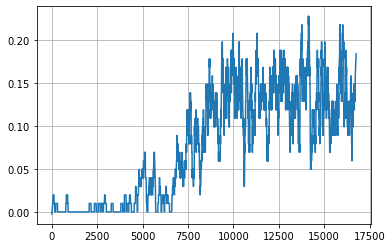

In [59]:
from scipy.signal import savgol_filter
np.savetxt('push_1.txt',total_reward[5:],fmt='%d')

r = np.array(np.loadtxt('push_1.txt',dtype='int')).T
r[r>-49]=1
r[r==-49]=0


plt.figure; plt.plot(savgol_filter(np.array(r),101,1).T,color='tab:blue')
# plt.figure; plt.plot(savgol_filter(np.array(r[0:1200]),11,1).T,color='tab:gray')
plt.grid(b=True)
# plt.plot(savgol_filter(np.array(r14),801,1).T,color='tab:green',alpha=0.8)plt.plot(total_reward)
plt.savefig('demo.png', transparent=True)

99000


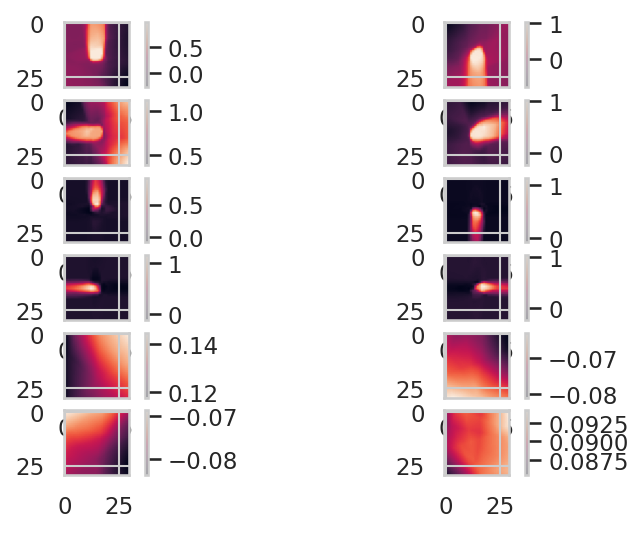

In [19]:
class GVF(nn.Module):
    def __init__(self, state_dim, num_gvfs):
        super(GVF, self).__init__()

        self.fc = nn.Sequential(

            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),            
            nn.Linear(64, num_gvfs)             
        )

    def forward(self, x):
        return self.fc(x)
    
num_gvfs = 4
gvf = GVF(3, num_gvfs).to(device)
gvf_target = copy.deepcopy(gvf)
gvf_optimizer = torch.optim.Adam(gvf.parameters(), lr=1e-3)

gvf2 = GVF(2, num_gvfs).to(device)
gvf_target2 = copy.deepcopy(gvf2)
gvf_optimizer2 = torch.optim.Adam(gvf2.parameters(), lr=1e-3)

gvf3 = GVF(3, 12).to(device)
gvf_target3 = copy.deepcopy(gvf3)
gvf_optimizer3 = torch.optim.Adam(gvf3.parameters(), lr=1e-3)

for it in range(100000):
    state, action, next_state, reward, not_done = replay_buffer.sample(100)

    # LEARN GFVs----------------------------

    state0 = torch.FloatTensor((state[:,0] - state[:,3]).detach().to('cpu').numpy()).to('cuda') #agent - object
    state1 = torch.FloatTensor((state[:,1] - state[:,4]).detach().to('cpu').numpy()).to('cuda')
    state2 = torch.FloatTensor((state[:,2] - state[:,5]).detach().to('cpu').numpy()).to('cuda')
    state3 = torch.FloatTensor((state[:,3] - state[:,-3]).detach().to('cpu').numpy()).to('cuda') #object - reward
    state4 = torch.FloatTensor((state[:,4] - state[:,-2]).detach().to('cpu').numpy()).to('cuda')

    nstate0 = torch.FloatTensor((next_state[:,0] - next_state[:,3]).detach().to('cpu').numpy()).to('cuda')
    nstate1 = torch.FloatTensor((next_state[:,1] - next_state[:,4]).detach().to('cpu').numpy()).to('cuda')
    nstate2 = torch.FloatTensor((next_state[:,2] - next_state[:,5]).detach().to('cpu').numpy()).to('cuda')
    nstate3 = torch.FloatTensor((next_state[:,3] - next_state[:,-3]).detach().to('cpu').numpy()).to('cuda')
    nstate4 = torch.FloatTensor((next_state[:,4] - next_state[:,-2]).detach().to('cpu').numpy()).to('cuda')


    
    theta=0.005; theta2=0.01
    threshold = 0.3 ; threshold2 = 0.3
    theta_box=0.005
    
    vel = [torch.FloatTensor((next_state[:,0] - state[:,0]).detach().to('cpu').numpy()).to('cuda'),
           torch.FloatTensor((next_state[:,1] - state[:,1]).detach().to('cpu').numpy()).to('cuda'),
          torch.FloatTensor((state[:,2] - state[:,5]).detach().to('cpu').numpy()).to('cuda'),   #relative position in z
          torch.FloatTensor((next_state[:,2] - state[:,2]).detach().to('cpu').numpy()).to('cuda')]   #velocity in z

    vel_box = [torch.FloatTensor((next_state[:,3] - state[:,3]).detach().to('cpu').numpy()).to('cuda'),
           torch.FloatTensor((next_state[:,4] - state[:,4]).detach().to('cpu').numpy()).to('cuda')]

    direct = torch.transpose(torch.stack(
        [(vel[0]>theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[0]<-theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[1]>theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[1]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[3])<theta2)*1]),0,1).float()

    direct2 = torch.transpose(torch.stack(
        [(vel[0]>theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
         (vel[0]>theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[0]<-theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[0]<-theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[1]>theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[1]>theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[1]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[1]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[3]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[1])<theta2)*1,
        (vel[3]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[1])<theta2)*1,
        (vel[3]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[1])<theta2)*1,
        (vel[3]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[1])<theta2)*1]),0,1).float()
    
    direct_box = torch.transpose(torch.stack(
        [(vel_box[0]>theta_box)*1 * (torch.abs(vel_box[1])<theta_box*2)*1,
        (vel_box[0]<-theta_box)*1 * (torch.abs(vel_box[1])<theta_box*2)*1,
        (vel_box[1]>theta_box)*1 * (torch.abs(vel_box[0])<theta_box*2)*1,
        (vel_box[1]<-theta_box)*1 * (torch.abs(vel_box[0])<theta_box*2)*1]),0,1).float()
    
    target_pos = state[:,[-3,-2,-1]].detach().cpu()

#     d2 = goal_distance(next_state[:,[3,4,5]].detach().cpu() ,target_pos)
#     r2 = torch.FloatTensor(-(d2 > 0.01).astype(np.float32)).to('cuda')
#     d1 = goal_distance(state[:,[3,4,5]].detach().cpu() ,target_pos)
#     r1 = torch.FloatTensor(-(d1 > 0.01).astype(np.float32)).to('cuda')
#     utility_r = ((r2==0)*1 * (r1==-1)*1).float() 
    utility_r = ((reward==0)*1 ).float() 
#     r_t = torch.transpose(reward,1,0)
#     utility_r = ((r_t[0]==0)*1 * ((torch.abs(vel_box[0])+torch.abs(vel_box[1]))>theta2)*1).float()  
#     utility_r = torch.reshape(utility_r,[100,1])

    utility_box = torch.transpose(torch.stack(
        [(vel_box[0]>theta_box)*1 * (torch.abs(vel[2])<theta2)*1,
        (vel_box[0]<-theta_box)*1 * (torch.abs(vel[2])<theta2)*1,
        (vel_box[1]>theta_box)*1 * (torch.abs(vel[2])<theta2)*1 ,
        (vel_box[1]<-theta_box)*1 * (torch.abs(vel[2])<theta2)*1]),0,1).float()
    

    sb = gvf(torch.stack((state0,state1,state2),-1)) 
    sr = gvf2(torch.stack((state3,state4),-1)) 
    sb2 = gvf3(torch.stack((state0,state1,state2),-1))
    with torch.no_grad():
        sbt = gvf_target(torch.stack((state0,state1,state2),-1))
        srt = gvf_target2(torch.stack((state3,state4),-1))
        sb2t = gvf_target3(torch.stack((state0,state1,state2),-1))
    
    
    which = sbt 
    
    utility2 = (torch.reshape((torch.sum((which[:,[2]]>threshold),1)>0).float(),(len(reward),1))* 
                torch.reshape((torch.prod((which[:,[1]]<threshold2),1)>0).float(),(len(reward),1))).float() 
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((which[:,[3]]>threshold),1)>0).float(),(len(reward),1))* 
                torch.reshape((torch.prod((which[:,[0]]<threshold2),1)>0).float(),(len(reward),1))).float()),1)
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((which[:,[2]]>threshold),1)>0).float(),(len(reward),1))* 
                torch.reshape((torch.prod((which[:,[1]]<threshold2),1)>0).float(),(len(reward),1))).float()),1)
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((which[:,[3]]>threshold),1)>0).float(),(len(reward),1))* 
                torch.reshape((torch.prod((which[:,[0]]<threshold2),1)>0).float(),(len(reward),1))).float()),1)
    
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((which[:,[1]]>threshold),1)>0).float(),(len(reward),1))* 
                torch.reshape((torch.prod((which[:,[2]]<threshold2),1)>0).float(),(len(reward),1))).float()),1)
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((which[:,[0]]>threshold),1)>0).float(),(len(reward),1))* 
                torch.reshape((torch.prod((which[:,[3]]<threshold2),1)>0 ).float(),(len(reward),1))).float()),1)   
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((which[:,[1]]>threshold),1)>0).float(),(len(reward),1))* 
                torch.reshape((torch.prod((which[:,[2]]<threshold2),1)>0).float(),(len(reward),1))).float()),1)
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((which[:,[0]]>threshold),1)>0).float(),(len(reward),1))* 
                torch.reshape((torch.prod((which[:,[3]]<threshold2),1)>0).float(),(len(reward),1))).float()),1)   
    
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((which[:,[0]]>threshold),1)>0).float(),(len(reward),1))* 
                torch.reshape((torch.prod((which[:,[1,2,3]]<threshold2),1)>0).float(),(len(reward),1))).float()),1)
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((which[:,[1]]>threshold),1)>0).float(),(len(reward),1))* 
                torch.reshape((torch.prod((which[:,[0,2,3]]<threshold2),1)>0 ).float(),(len(reward),1))).float()),1)   
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((which[:,[2]]>threshold),1)>0).float(),(len(reward),1))* 
                torch.reshape((torch.prod((which[:,[0,1,3]]<threshold2),1)>0).float(),(len(reward),1))).float()),1)
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((which[:,[3]]>threshold),1)>0).float(),(len(reward),1))* 
                torch.reshape((torch.prod((which[:,[0,1,2]]<threshold2),1)>0).float(),(len(reward),1))).float()),1)   
    

    
    with torch.no_grad():
        sb_target = utility_box + (torch.abs(1-utility_box)*0.99) * (gvf_target(torch.stack((nstate0,nstate1,nstate2),-1)) )
        sr_target = utility_r + (torch.abs(1-utility_r)*0.99) * (gvf_target2(torch.stack((nstate3,nstate4),-1)) ) 
        sb_target2 = utility2 + (torch.abs(1-utility2)*0.99) * (gvf_target3(torch.stack((nstate0,nstate1,nstate2),-1)) )
#         sr_target2 = utility2 + (torch.abs(1-utility2)*0.99) * (gvf_target2(torch.stack((nstate0,nstate1,nstate2,nstate3,nstate4),-1)) )
        
    gvf_loss = nn.MSELoss()(sb[direct==1],sb_target[direct==1])
    gvf_loss2 = nn.MSELoss()(sr[direct_box==1],sr_target[direct_box==1])
    gvf_loss3 = nn.MSELoss()(sb2[direct2==1],sb_target2[direct2==1])
    
    l1 = []
    l1.append(sbt[:,0] * srt[:,0] )
    l1.append(sbt[:,1] * srt[:,1] )
    l1.append(sbt[:,2] * srt[:,2] )
    l1.append(sbt[:,3] * srt[:,3] )
    l1 = torch.transpose(torch.stack(l1),1,0)
    l1[l1<0]=0
    
    l2 = []
    l2.append(sb2t[:,0] * srt[:,2] )
    l2.append(sb2t[:,1] * srt[:,3] )
    l2.append(sb2t[:,2] * srt[:,2] )
    l2.append(sb2t[:,3] * srt[:,3] )
    l2.append(sb2t[:,4] * srt[:,1] )
    l2.append(sb2t[:,5] * srt[:,0] )
    l2.append(sb2t[:,6] * srt[:,1] )
    l2.append(sb2t[:,7] * srt[:,0] )
    l2.append(sb2t[:,8] * srt[:,0] )
    l2.append(sb2t[:,9] * srt[:,1] )
    l2.append(sb2t[:,10] * srt[:,2] )
    l2.append(sb2t[:,11] * srt[:,3] )
    l2 = torch.transpose(torch.stack(l2),1,0)
    l2[l2<0]=0
    
    with torch.no_grad():
        sbt_next =  gvf_target(torch.stack((nstate0,nstate1,nstate2),-1)) 
        srt_next =  gvf_target2(torch.stack((nstate3,nstate4),-1)) 
        sb2t_next =  gvf_target3(torch.stack((nstate0,nstate1,nstate2),-1)) 

    l1_next = []
    l1_next.append(sbt_next[:,0] * srt_next[:,0] )
    l1_next.append(sbt_next[:,1] * srt_next[:,1] )
    l1_next.append(sbt_next[:,2] * srt_next[:,2] )
    l1_next.append(sbt_next[:,3] * srt_next[:,3] )
    l1_next = torch.transpose(torch.stack(l1_next),1,0)
    l1_next[l1_next<0]=0

    l2_next = []
    l2_next.append(sb2t_next[:,0] * srt_next[:,2] )
    l2_next.append(sb2t_next[:,1] * srt_next[:,3] )
    l2_next.append(sb2t_next[:,2] * srt_next[:,2] )
    l2_next.append(sb2t_next[:,3] * srt_next[:,3] )
    l2_next.append(sb2t_next[:,4] * srt_next[:,1] )
    l2_next.append(sb2t_next[:,5] * srt_next[:,0] )
    l2_next.append(sb2t_next[:,6] * srt_next[:,1] )
    l2_next.append(sb2t_next[:,7] * srt_next[:,0] )
    l2_next.append(sb2t_next[:,8] * srt_next[:,0] )
    l2_next.append(sb2t_next[:,9] * srt_next[:,1] )
    l2_next.append(sb2t_next[:,10] * srt_next[:,2] )
    l2_next.append(sb2t_next[:,11] * srt_next[:,3] )
    l2_next = torch.transpose(torch.stack(l2_next),1,0)
    l2_next[l2_next<0]=0

    state = torch.cat((state[:,[0,1,2,3,4,5,-3,-2,-1]],l1),-1)
    state = torch.cat((state,l2),-1)

    next_state = torch.cat((next_state[:,[0,1,2,3,4,5,-3,-2,-1]],l1_next),-1)
    next_state = torch.cat((next_state,l2_next),-1)
    
    if it%1000==0:
        clear_output(wait=True);
        print(it)
        gvf_target = copy.deepcopy(gvf)
        gvf_target2 = copy.deepcopy(gvf2)
        gvf_target3 = copy.deepcopy(gvf3)
        
        
        res=30
        v=np.zeros((res,res)); v2 , v3 , v4 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
        v5 ,v6 , v7 , v8 ,v9,v10 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
        v11,v12 = np.zeros((res,res)),np.zeros((res,res))
        xs = np.linspace(-0.25,0.25,res)
        ys = np.linspace(-0.25,0.25,res)
        z=0.
        for i in range(res):
            for j in range(res):
                v[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j]]).T.to('cuda'))[0].detach().to('cpu').numpy()
                v2[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j]]).T.to('cuda'))[1].detach().to('cpu').numpy()
                v3[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j]]).T.to('cuda'))[2].detach().to('cpu').numpy()
                v4[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j]]).T.to('cuda'))[3].detach().to('cpu').numpy()
                v5[i,j] = gvf(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[0].detach().to('cpu').numpy()
                v6[i,j] = gvf(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[1].detach().to('cpu').numpy()                
                v7[i,j] = gvf(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[2].detach().to('cpu').numpy()
                v8[i,j] = gvf(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[3].detach().to('cpu').numpy() 
                v9[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[8].detach().to('cpu').numpy() 
                v10[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[9].detach().to('cpu').numpy() 
                v11[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[10].detach().to('cpu').numpy() 
                v12[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[11].detach().to('cpu').numpy() 
        plt.figure(dpi=150)
        plt.subplot(6,2,1);
        plt.imshow(v); plt.colorbar();  #plt.clim([-3,0])
        plt.subplot(6,2,2);
        plt.imshow(v2); plt.colorbar(); 
        plt.subplot(6,2,3);
        plt.imshow(v3); plt.colorbar();  #plt.clim([-3,0])
        plt.subplot(6,2,4);
        plt.imshow(v4); plt.colorbar(); 
        plt.subplot(6,2,5);
        plt.imshow(v5); plt.colorbar(); 
        plt.subplot(6,2,6);
        plt.imshow(v6); plt.colorbar(); 
        plt.subplot(6,2,7);
        plt.imshow(v7); plt.colorbar(); 
        plt.subplot(6,2,8);
        plt.imshow(v8); plt.colorbar(); 
        plt.subplot(6,2,9);
        plt.imshow(v9); plt.colorbar(); 
        plt.subplot(6,2,10);
        plt.imshow(v10); plt.colorbar(); 
        plt.subplot(6,2,11);
        plt.imshow(v11); plt.colorbar(); 
        plt.subplot(6,2,12);
        plt.imshow(v12); plt.colorbar();         
        plt.show() #plt.clim([-3,0])  
        
    # Optimize GVF 
    gvf_optimizer.zero_grad()
    gvf_loss.backward()
    gvf_optimizer.step()
    
#     # Optimize GVF 
    gvf_optimizer2.zero_grad()
    gvf_loss2.backward()
    gvf_optimizer2.step()
    
#     # Optimize GVF 
#     gvf_optimizer3.zero_grad()
#     gvf_loss3.backward()
#     gvf_optimizer3.step()

In [54]:
target_pos = state[:,[-3,-2,-1]].detach().cpu()
for ib in range(1,len(reward_buffer)):
    d = goal_distance(next_state[:,[3,4,5]].detach().cpu() ,target_pos)
    reward = -(d > distance_threshold).astype(np.float32)
reward

array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -1., -0., -1., -0., -0., -0., -0., -1., -0., -0.,
       -0., -0., -1., -0., -0., -0., -0., -0., -0., -0., -0., -1., -0.,
       -1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -1., -0., -0., -0., -1., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0.], dtype=float32)

29000


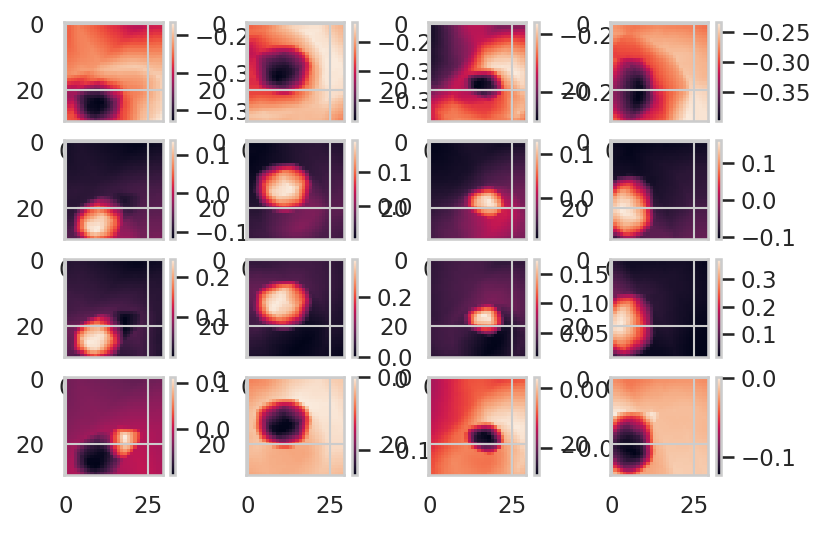

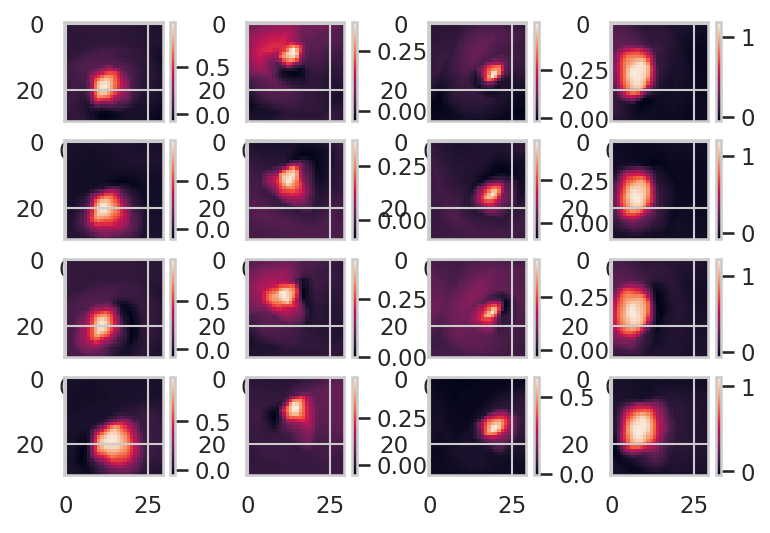

KeyboardInterrupt: 

In [20]:
class GVF(nn.Module):
    def __init__(self, state_dim, num_gvfs):
        super(GVF, self).__init__()

        self.fc = nn.Sequential(

            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),            
            nn.Linear(64, num_gvfs)             
        )

    def forward(self, x):
        return self.fc(x)
    
num_gvfs = 4
gvf1 = GVF(5, 4).to(device)
gvf_target1 = copy.deepcopy(gvf1)
gvf_optimizer1 = torch.optim.Adam(gvf1.parameters(), lr=1e-3)

gvf2 = GVF(5, 6).to(device)
gvf_target2 = copy.deepcopy(gvf2)
gvf_optimizer2 = torch.optim.Adam(gvf2.parameters(), lr=1e-3)

gvf3 = GVF(5, 5).to(device)
gvf_target3 = copy.deepcopy(gvf3)
gvf_optimizer3 = torch.optim.Adam(gvf3.parameters(), lr=1e-3)


for it in range(100000):

    state, action, next_state, reward, not_done = replay_buffer.sample(256)
    # LEARN GFVs----------------------------

    state0 = torch.FloatTensor((state[:,0] - state[:,3]).detach().to('cpu').numpy()).to('cuda') #agent - object
    state1 = torch.FloatTensor((state[:,1] - state[:,4]).detach().to('cpu').numpy()).to('cuda')
    state2 = torch.FloatTensor((state[:,2] - state[:,5]).detach().to('cpu').numpy()).to('cuda')
    state3 = torch.FloatTensor((state[:,3] - state[:,-3]).detach().to('cpu').numpy()).to('cuda') #object - reward
    state4 = torch.FloatTensor((state[:,4] - state[:,-2]).detach().to('cpu').numpy()).to('cuda')

    nstate0 = torch.FloatTensor((next_state[:,0] - next_state[:,3]).detach().to('cpu').numpy()).to('cuda')
    nstate1 = torch.FloatTensor((next_state[:,1] - next_state[:,4]).detach().to('cpu').numpy()).to('cuda')
    nstate2 = torch.FloatTensor((next_state[:,2] - next_state[:,5]).detach().to('cpu').numpy()).to('cuda')
    nstate3 = torch.FloatTensor((next_state[:,3] - next_state[:,-3]).detach().to('cpu').numpy()).to('cuda')
    nstate4 = torch.FloatTensor((next_state[:,4] - next_state[:,-2]).detach().to('cpu').numpy()).to('cuda')


    
    theta=0.01; theta2=0.01
    threshold = 0.4 ; threshold2 = 0.4
    theta_box=0.005
    
    vel = [torch.FloatTensor((next_state[:,0] - state[:,0]).detach().to('cpu').numpy()).to('cuda'),
           torch.FloatTensor((next_state[:,1] - state[:,1]).detach().to('cpu').numpy()).to('cuda'),
          torch.FloatTensor((state[:,2] - state[:,5]).detach().to('cpu').numpy()).to('cuda'),   #relative position in z
          torch.FloatTensor((next_state[:,2] - state[:,2]).detach().to('cpu').numpy()).to('cuda')]   #velocity in z

    vel_box = [torch.FloatTensor((next_state[:,3] - state[:,3]).detach().to('cpu').numpy()).to('cuda'),
           torch.FloatTensor((next_state[:,4] - state[:,4]).detach().to('cpu').numpy()).to('cuda')]

    direct1 = torch.transpose(torch.stack(
        [(vel[0]>theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[0]<-theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[1]>theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[1]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[3])<theta2)*1]),0,1).float()

    
    direct2 = torch.transpose(torch.stack(
        [(vel[0]>theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[0]<-theta)*1 * (torch.abs(vel[1])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[1]>theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[1]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[3])<theta2)*1,
        (vel[3]>theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[1])<theta2)*1,
        (vel[3]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[1])<theta2)*1]),0,1).float()
    
    direct3 = torch.transpose(torch.stack(
        [(vel[0]>theta)*1 * (torch.abs(vel[1])<theta2)*1 * (vel[2]>0.05)*1,
        (vel[0]<-theta)*1 * (torch.abs(vel[1])<theta2)*1 * (vel[2]>0.05)*1,
        (vel[1]>theta)*1 * (torch.abs(vel[0])<theta2)*1 * (vel[2]>0.05)*1,
        (vel[1]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (vel[2]>0.05)*1,
        (vel[3]<-theta)*1 * (torch.abs(vel[0])<theta2)*1 * (torch.abs(vel[1])<theta2)*1 * (vel[2]>0.05)*1]),0,1).float()
    
    
    utility_r = (reward==0).float()
     
    utility_box = torch.transpose(torch.stack(
        [(vel_box[0]>theta_box)*1 * (torch.abs(vel_box[1])<0.005)*1,
        (vel_box[0]<-theta_box)*1 * (torch.abs(vel_box[1])<0.005)*1,
        (vel_box[1]>theta_box)*1  * (torch.abs(vel_box[0])<0.005)*1,
        (vel_box[1]<-theta_box)*1 * (torch.abs(vel_box[0])<0.005)*1]),0,1).float()
    
    utility1 = utility_r  * utility_box
    
    
    box_still = torch.transpose(torch.stack(
        [(torch.abs(vel_box[0])<0.0005)*1 * (torch.abs(vel_box[1])<0.0005)*1]),0,1).float()
    
    V1 = gvf1(torch.stack((state0,state1,state2,state3,state4),-1)) 
    V2 = gvf2(torch.stack((state0,state1,state2,state3,state4),-1)) 
    V3 = gvf3(torch.stack((state0,state1,state2,state3,state4),-1)) 
    
    with torch.no_grad():
        Vt1 = gvf_target1(torch.stack((state0,state1,state2,state3,state4),-1))
        Vt3 = gvf_target3(torch.stack((state0,state1,state2,state3,state4),-1))
    
    
    utility2 = (torch.reshape((torch.sum((V1[:,[0,2,3]]>threshold),1)>0).float(),(len(reward),1))*1 * 
               torch.reshape((torch.sum((V1[:,[1]]<threshold),1)>0).float(),(len(reward),1))*1).float() 
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((V1[:,[1,2,3]]>threshold),1)>0).float(),(len(reward),1))*1 * 
               torch.reshape((torch.sum((V1[:,[0]]<threshold),1)>0).float(),(len(reward),1))*1).float() ),1) 
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((V1[:,[0,1,2]]>threshold),1)>0).float(),(len(reward),1))*1 * 
               torch.reshape((torch.sum((V1[:,[3]]<threshold),1)>0).float(),(len(reward),1))*1).float() ),1) 
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((V1[:,[0,1,3]]>threshold),1)>0).float(),(len(reward),1))*1 * 
               torch.reshape((torch.sum((V1[:,[2]]<threshold),1)>0).float(),(len(reward),1))*1).float() ),1) 
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((V1[:,[0,1,2,3]]>threshold),1)>0).float(),(len(reward),1))).float()),1)   
    utility2 = torch.cat((utility2,(torch.reshape((torch.sum((V1[:,[0,1,2,3]]>threshold),1)>0).float(),(len(reward),1))).float()),1)   
    
    threshold3 = 0.6
    utility3 = (torch.reshape((torch.sum((V2[:,[5]]>threshold3),1)>0).float(),(len(reward),1))*1 ).float() 
    utility3 = torch.cat((utility3,(torch.reshape((torch.sum((V2[:,[5]]>threshold3),1)>0).float(),(len(reward),1))*1).float() ),1) 
    utility3 = torch.cat((utility3,(torch.reshape((torch.sum((V2[:,[5]]>threshold3),1)>0).float(),(len(reward),1))*1 ).float() ),1) 
    utility3 = torch.cat((utility3,(torch.reshape((torch.sum((V2[:,[5]]>threshold3),1)>0).float(),(len(reward),1))*1 ).float() ),1) 
    utility3 = torch.cat((utility3,(torch.reshape((torch.sum((V2[:,[5]]>threshold3),1)>0).float(),(len(reward),1))*1 ).float() ),1) 
    
    vs = torch.reshape((vel[2]>0.075)*1,(256,1))
    
    utility3 = utility3 * vs
    with torch.no_grad():
        V1_target = utility1 + (torch.abs(1-utility1)*0.99) * (gvf_target1(torch.stack((nstate0,nstate1,nstate2,nstate3,nstate4),-1)) )
        V2_target = utility2 + (torch.abs(1-utility2)*0.99) * (gvf_target2(torch.stack((nstate0,nstate1,nstate2,nstate3,nstate4),-1)) )
        V3_target = utility3 + (torch.abs(1-utility3)*0.99) * (gvf_target3(torch.stack((nstate0,nstate1,nstate2,nstate3,nstate4),-1)) )
        
    gvf_loss1 = nn.MSELoss()(V1,V1_target)
    gvf_loss2 = torch.clamp(nn.MSELoss()(V2[direct2==1],V2_target[direct2==1]),-1,1)
    gvf_loss3 = torch.clamp(nn.MSELoss()(V3[direct3==1],V3_target[direct3==1]),-1,1)
    
    if it%1000==0:
        clear_output(wait=True);
        print(it)
        gvf_target1 = copy.deepcopy(gvf1)
        gvf_target2 = copy.deepcopy(gvf2)
        gvf_target3 = copy.deepcopy(gvf3)
#         gvf_target3 = copy.deepcopy(gvf3)
#         gvf_target4 = copy.deepcopy(gvf4)
        
        res=30
        v=np.zeros((res,res)); v2 , v3 , v4 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
        v5 ,v6 , v7 , v8 ,v9,v10 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
        v11,v12,v13,v14,v15,v16 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res))
        xs = np.linspace(-0.25,0.25,res)
        ys = np.linspace(-0.25,0.25,res)
        z=0
        for i in range(res):
            for j in range(res):
                v[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[4].detach().to('cpu').numpy()
                v2[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[4].detach().to('cpu').numpy()
                v3[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[4].detach().to('cpu').numpy()
                v4[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[4].detach().to('cpu').numpy()
                v5[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[1].detach().to('cpu').numpy()
                v6[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[1].detach().to('cpu').numpy()
                v7[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[1].detach().to('cpu').numpy()
                v8[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[1].detach().to('cpu').numpy()
                v9[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[2].detach().to('cpu').numpy() 
                v10[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[2].detach().to('cpu').numpy() 
                v11[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[2].detach().to('cpu').numpy() 
                v12[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[2].detach().to('cpu').numpy() 
                v13[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[3].detach().to('cpu').numpy() 
                v14[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[3].detach().to('cpu').numpy() 
                v15[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[3].detach().to('cpu').numpy() 
                v16[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[3].detach().to('cpu').numpy() 
                
        plt.figure(dpi=150)
        ip=1;
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v); plt.colorbar();  #plt.clim([-3,0])
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v2); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v3); plt.colorbar();  #plt.clim([-3,0])
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v4); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v5); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v6); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v7); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v8); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v9); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v10); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v11); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v12); plt.colorbar();   
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v13); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v14); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v15); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v16); plt.colorbar();     
        plt.show() #plt.clim([-3,0])  

        v=np.zeros((res,res)); v2 , v3 , v4 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
        v5 ,v6 , v7 , v8 ,v9,v10 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
        v11,v12,v13,v14,v15,v16 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res))
        xs = np.linspace(-0.25,0.25,res)
        ys = np.linspace(-0.25,0.25,res)
        z=0.15
        for i in range(res):
            for j in range(res):
                v[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[0].detach().to('cpu').numpy()
                v2[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[0].detach().to('cpu').numpy()
                v3[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[0].detach().to('cpu').numpy()
                v4[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[0].detach().to('cpu').numpy()
                v5[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[1].detach().to('cpu').numpy()
                v6[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[1].detach().to('cpu').numpy()
                v7[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[1].detach().to('cpu').numpy()
                v8[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[1].detach().to('cpu').numpy()
                v9[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[2].detach().to('cpu').numpy() 
                v10[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[2].detach().to('cpu').numpy() 
                v11[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[2].detach().to('cpu').numpy() 
                v12[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[2].detach().to('cpu').numpy() 
                v13[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[3].detach().to('cpu').numpy() 
                v14[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[3].detach().to('cpu').numpy() 
                v15[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[3].detach().to('cpu').numpy() 
                v16[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[3].detach().to('cpu').numpy() 
        plt.figure(dpi=150)
        ip=1;
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v); plt.colorbar();  #plt.clim([-3,0])
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v2); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v3); plt.colorbar();  #plt.clim([-3,0])
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v4); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v5); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v6); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v7); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v8); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v9); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v10); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v11); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v12); plt.colorbar();   
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v13); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v14); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v15); plt.colorbar(); 
        plt.subplot(4,4,ip); ip+=1
        plt.imshow(v16); plt.colorbar();     
        plt.show() #plt.clim([-3,0])  
    # Optimize GVF 
    gvf_optimizer1.zero_grad()
    gvf_loss1.backward()
    gvf_optimizer1.step()
    
    # Optimize GVF 
    gvf_optimizer2.zero_grad()
    gvf_loss2.backward()
    gvf_optimizer2.step()
#     # Optimize GVF 
    gvf_optimizer3.zero_grad()
    gvf_loss3.backward()
    gvf_optimizer3.step()



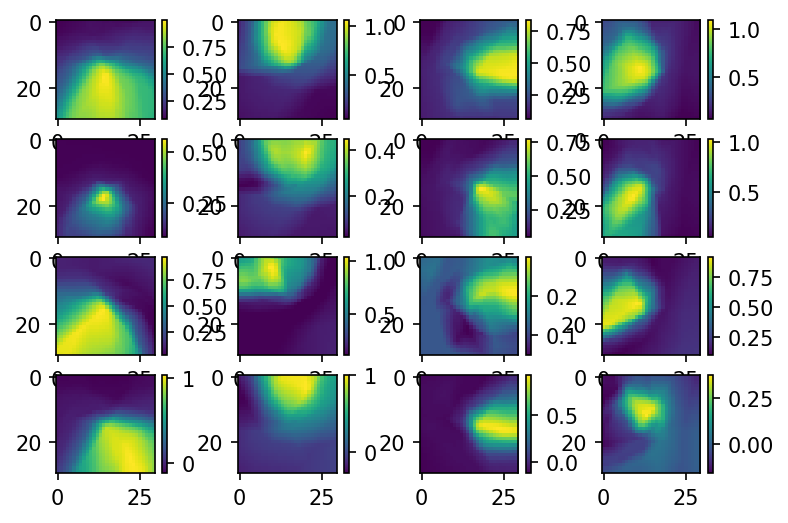

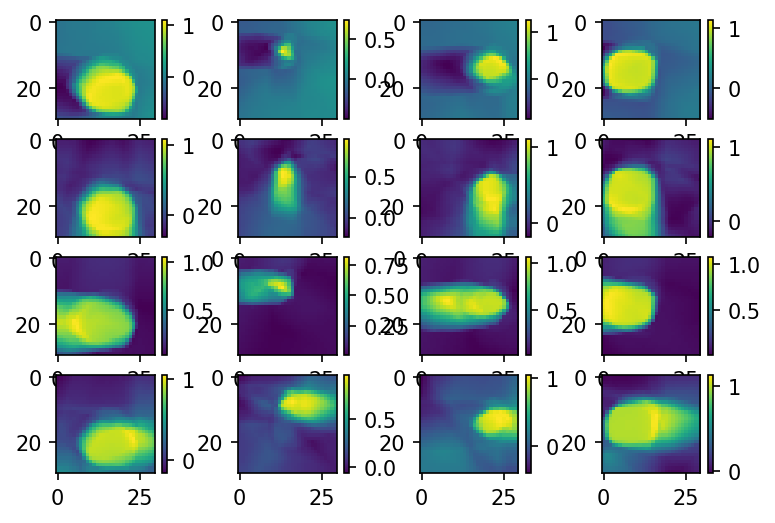

In [61]:
res=30
v=np.zeros((res,res)); v2 , v3 , v4 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
v5 ,v6 , v7 , v8 ,v9,v10 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
v11,v12,v13,v14,v15,v16 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res))
xs = np.linspace(-0.25,0.25,res)
ys = np.linspace(-0.25,0.25,res)
z=0
for i in range(res):
    for j in range(res):
        v[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[5].detach().to('cpu').numpy()
        v2[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[5].detach().to('cpu').numpy()
        v3[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[5].detach().to('cpu').numpy()
        v4[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[5].detach().to('cpu').numpy()
        v5[i,j] = gvf1(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[1].detach().to('cpu').numpy()
        v6[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[1].detach().to('cpu').numpy()
        v7[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[1].detach().to('cpu').numpy()
        v8[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[1].detach().to('cpu').numpy()
        v9[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[2].detach().to('cpu').numpy() 
        v10[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[2].detach().to('cpu').numpy() 
        v11[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[2].detach().to('cpu').numpy() 
        v12[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[2].detach().to('cpu').numpy() 
        v13[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[3].detach().to('cpu').numpy() 
        v14[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[3].detach().to('cpu').numpy() 
        v15[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[3].detach().to('cpu').numpy() 
        v16[i,j] = gvf2(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[3].detach().to('cpu').numpy() 

plt.figure(dpi=150)
ip=1;
plt.subplot(4,4,ip); ip+=1
plt.imshow(v); plt.colorbar();  #plt.clim([-3,0])
plt.subplot(4,4,ip); ip+=1
plt.imshow(v2); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v3); plt.colorbar();  #plt.clim([-3,0])
plt.subplot(4,4,ip); ip+=1
plt.imshow(v4); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v5); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v6); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v7); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v8); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v9); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v10); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v11); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v12); plt.colorbar();   
plt.subplot(4,4,ip); ip+=1
plt.imshow(v13); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v14); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v15); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v16); plt.colorbar();     
plt.show() #plt.clim([-3,0])  

v=np.zeros((res,res)); v2 , v3 , v4 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
v5 ,v6 , v7 , v8 ,v9,v10 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
v11,v12,v13,v14,v15,v16 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res))
xs = np.linspace(-0.25,0.25,res)
ys = np.linspace(-0.25,0.25,res)
z=0.15
for i in range(res):
    for j in range(res):
        v[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[4].detach().to('cpu').numpy()
        v2[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[4].detach().to('cpu').numpy()
        v3[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[4].detach().to('cpu').numpy()
        v4[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[4].detach().to('cpu').numpy()
        v5[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[1].detach().to('cpu').numpy()
        v6[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[1].detach().to('cpu').numpy()
        v7[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[1].detach().to('cpu').numpy()
        v8[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[1].detach().to('cpu').numpy()
        v9[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[2].detach().to('cpu').numpy() 
        v10[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[2].detach().to('cpu').numpy() 
        v11[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[2].detach().to('cpu').numpy() 
        v12[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[2].detach().to('cpu').numpy() 
        v13[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0.1,0]).T.to('cuda'))[3].detach().to('cpu').numpy() 
        v14[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,-0.1,0]).T.to('cuda'))[3].detach().to('cpu').numpy() 
        v15[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,0.1]).T.to('cuda'))[3].detach().to('cpu').numpy() 
        v16[i,j] = gvf3(torch.FloatTensor([xs[i],ys[j],z,0,-0.1]).T.to('cuda'))[3].detach().to('cpu').numpy() 
plt.figure(dpi=150)
ip=1;
plt.subplot(4,4,ip); ip+=1
plt.imshow(v); plt.colorbar();  #plt.clim([-3,0])
plt.subplot(4,4,ip); ip+=1
plt.imshow(v2); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v3); plt.colorbar();  #plt.clim([-3,0])
plt.subplot(4,4,ip); ip+=1
plt.imshow(v4); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v5); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v6); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v7); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v8); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v9); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v10); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v11); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v12); plt.colorbar();   
plt.subplot(4,4,ip); ip+=1
plt.imshow(v13); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v14); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v15); plt.colorbar(); 
plt.subplot(4,4,ip); ip+=1
plt.imshow(v16); plt.colorbar();     
plt.show() #plt.clim([-3,0])  

In [54]:
vs = torch.reshape((vel[2]>0.05)*1,(256,1))
np.shape(vs)

torch.Size([256, 1])

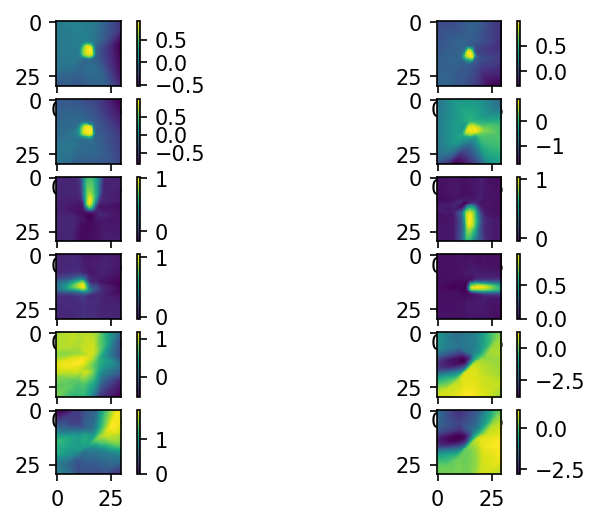

In [6]:
res=30
v=np.zeros((res,res)); v2 , v3 , v4 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
v5 ,v6 , v7 , v8 ,v9,v10 = np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res)),np.zeros((res,res));
v11,v12 = np.zeros((res,res)),np.zeros((res,res))
xs = np.linspace(-0.25,0.25,res)
ys = np.linspace(-0.25,0.25,res)
z=0.
for i in range(res):
    for j in range(res):
        v[i,j] = policy.gvf2(torch.FloatTensor([xs[i],ys[j]]).T.to('cuda'))[0].detach().to('cpu').numpy()
        
        v2[i,j] = policy.gvf2(torch.FloatTensor([xs[i],ys[j]]).T.to('cuda'))[1].detach().to('cpu').numpy()
        v3[i,j] = policy.gvf2(torch.FloatTensor([xs[i],ys[j]]).T.to('cuda'))[2].detach().to('cpu').numpy()
        v4[i,j] = policy.gvf2(torch.FloatTensor([xs[i],ys[j]]).T.to('cuda'))[3].detach().to('cpu').numpy()
        v5[i,j] = policy.gvf(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[0].detach().to('cpu').numpy()  
        v6[i,j] = policy.gvf(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[1].detach().to('cpu').numpy()                
        v7[i,j] = policy.gvf(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[2].detach().to('cpu').numpy()
        v8[i,j] = policy.gvf(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[3].detach().to('cpu').numpy() 
        v9[i,j] = policy.gvf3(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[8].detach().to('cpu').numpy() 
        v10[i,j] = policy.gvf3(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[9].detach().to('cpu').numpy() 
        v11[i,j] = policy.gvf3(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[10].detach().to('cpu').numpy() 
        v12[i,j] = policy.gvf3(torch.FloatTensor([xs[i],ys[j],z]).T.to('cuda'))[11].detach().to('cpu').numpy() 
plt.figure(dpi=150)
plt.subplot(6,2,1);
plt.imshow(v); plt.colorbar();  #plt.clim([-3,0])
plt.subplot(6,2,2);
plt.imshow(v2); plt.colorbar(); 
plt.subplot(6,2,3);
plt.imshow(v3); plt.colorbar();  #plt.clim([-3,0])
plt.subplot(6,2,4);
plt.imshow(v4); plt.colorbar(); 
plt.subplot(6,2,5);
plt.imshow(v5); plt.colorbar(); 
plt.subplot(6,2,6);
plt.imshow(v6); plt.colorbar(); 
plt.subplot(6,2,7);
plt.imshow(v7); plt.colorbar(); 
plt.subplot(6,2,8);
plt.imshow(v8); plt.colorbar(); 
plt.subplot(6,2,9);
plt.imshow(v9); plt.colorbar(); 
plt.subplot(6,2,10);
plt.imshow(v10); plt.colorbar(); 
plt.subplot(6,2,11);
plt.imshow(v11); plt.colorbar(); 
plt.subplot(6,2,12);
plt.imshow(v12); plt.colorbar();         
plt.show() #plt.clim([-3,0])  

In [4]:
state, action, next_state, reward, not_done = replay_buffer.sample(100)

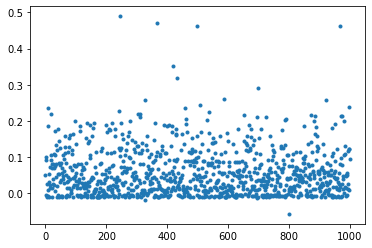

In [29]:
plt.plot((state[:,2]-state[:,5]).detach().cpu(),'.')

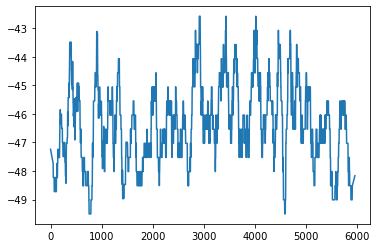

In [12]:
from scipy.signal import savgol_filter
plt.plot(savgol_filter(total_reward,101,1))

In [22]:
state0 = torch.FloatTensor((state[:,0] - state[:,3]).detach().to('cpu').numpy()).to('cuda') #agent - object
state1 = torch.FloatTensor((state[:,1] - state[:,4]).detach().to('cpu').numpy()).to('cuda')
state2 = torch.FloatTensor((state[:,2] - state[:,5]).detach().to('cpu').numpy()).to('cuda')
state3 = torch.FloatTensor((state[:,3] - state[:,-3]).detach().to('cpu').numpy()).to('cuda') #object - reward
state4 = torch.FloatTensor((state[:,4] - state[:,-2]).detach().to('cpu').numpy()).to('cuda')
Vt1 = policy.gvf_target1(torch.stack((state0,state1,state2,state3,state4),-1))
state = torch.cat((torch.transpose(torch.stack([state0,state1,state2,state3,state4]),0,1),Vt2),-1)


In [30]:
np.shape(full_s)

torch.Size([11])

In [21]:
np.shape(torch.transpose(torch.stack([state0,state1,state2,state3,state4]),0,1))

torch.Size([100, 5])

In [29]:
state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
state0 = state[0] - state[3]
state1 = state[1] - state[4]
state2 = state[2] - state[5]
state3 = state[3] - state[-3]
state4 = state[4] - state[-2]
with torch.no_grad():
    vt1 = policy.gvf1(torch.FloatTensor([state0,state1,state2,state3,state4]).to('cuda'))
    vt2 = policy.gvf2(torch.FloatTensor([state0,state1,state2,state3,state4]).to('cuda'))

full_s = torch.cat((torch.FloatTensor([state0,state1,state2,state3,state4]).to('cuda'),vt2),-1)

In [28]:
torch.FloatTensor([state0,state1,state2,state3,state4])

tensor([-0.0982, -0.1021,  0.0020,  0.1764,  0.1271])

---------------------------------------
Frame: 20000. Evaluation over 500 frames: -50.000
---------------------------------------


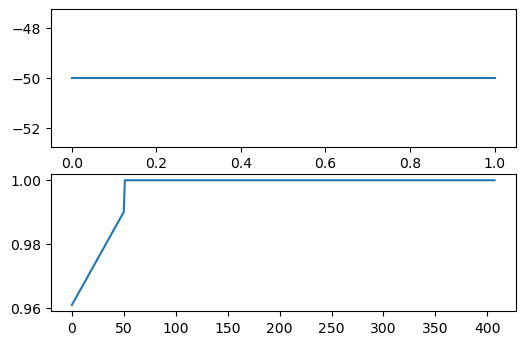

KeyboardInterrupt: 

In [1]:
from IPython.display import clear_output
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sunblaze_envs
import numpy as np
import torch
import gym
import argparse
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

batch_size=256
buffer_size=1e6
NUM_GAMMAS=1
taus=np.linspace(5,100,NUM_GAMMAS)
GAMMAS=np.exp(-1/taus)
GAMMAS[-1]=0.99

GAMMAS=np.flip(GAMMAS)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GAMMAS=torch.tensor([GAMMAS for _ in range(batch_size)]).float().to(device)

# Implementation of Twin Delayed Deep Deterministic Policy Gradients (TD3)
# Paper: https://arxiv.org/abs/1802.09477

d=np.ones(NUM_GAMMAS)

distance_threshold=0.05
def goal_distance(goal_a, goal_b):
    assert goal_a.shape == goal_b.shape
    return np.linalg.norm(goal_a - goal_b, axis=-1)

class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(buffer_size)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 64)
        self.l4 = nn.Linear(64, action_dim)
        
        self.max_action = max_action
        

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = F.relu(self.l3(a))
        return self.max_action * torch.tanh(self.l4(a))


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 64)
        self.l4 = nn.Linear(64, 1)

        # Q2 architecture
        self.l5 = nn.Linear(state_dim + action_dim, 64)
        self.l6 = nn.Linear(64, 64)
        self.l7 = nn.Linear(64, 64)
        self.l8 = nn.Linear(64, 1)


    def forward(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = F.relu(self.l3(q1))
        q1 = self.l4(q1)

        q2 = F.relu(self.l5(sa))
        q2 = F.relu(self.l6(q2))
        q2 = F.relu(self.l7(q2))
        q2 = self.l8(q2)
        return q1, q2


    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = F.relu(self.l3(q1))
        q1 = self.l4(q1)
        return q1


class GVF(nn.Module):
    def __init__(self, state_dim, num_gvfs):
        super(GVF, self).__init__()

        self.fc = nn.Sequential(

            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),            
            nn.Linear(64, num_gvfs)             
        )

    def forward(self, x):
        return self.fc(x)
    

class TD3(object):
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_freq=2
    ):

        self.actor = Actor(5, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(5, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

        self.gvf1 = GVF(5, 4).to(device)
        self.gvf_target1 = copy.deepcopy(self.gvf1)
        self.gvf_optimizer1 = torch.optim.Adam(self.gvf1.parameters(), lr=1e-3)
        
        self.gvf2 = GVF(5, 6).to(device)
        self.gvf_target2 = copy.deepcopy(self.gvf2)
        self.gvf_optimizer2 = torch.optim.Adam(self.gvf2.parameters(), lr=1e-3)


        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq
        
        self.total_it = 0


    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()


    def train(self, replay_buffer, batch_size=256):
        self.total_it += 1

        # Sample replay buffer 
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)
        
        # LEARN GFVs----------------------------
        if t > args.start_timesteps*2: 
            state0 = torch.FloatTensor((state[:,0] - state[:,3]).detach().to('cpu').numpy()).to('cuda') #agent - object
            state1 = torch.FloatTensor((state[:,1] - state[:,4]).detach().to('cpu').numpy()).to('cuda')
            state2 = torch.FloatTensor((state[:,2] - state[:,5]).detach().to('cpu').numpy()).to('cuda')
            state3 = torch.FloatTensor((state[:,3] - state[:,-3]).detach().to('cpu').numpy()).to('cuda') #object - reward
            state4 = torch.FloatTensor((state[:,4] - state[:,-2]).detach().to('cpu').numpy()).to('cuda')

            nstate0 = torch.FloatTensor((next_state[:,0] - next_state[:,3]).detach().to('cpu').numpy()).to('cuda')
            nstate1 = torch.FloatTensor((next_state[:,1] - next_state[:,4]).detach().to('cpu').numpy()).to('cuda')
            nstate2 = torch.FloatTensor((next_state[:,2] - next_state[:,5]).detach().to('cpu').numpy()).to('cuda')
            nstate3 = torch.FloatTensor((next_state[:,3] - next_state[:,-3]).detach().to('cpu').numpy()).to('cuda')
            nstate4 = torch.FloatTensor((next_state[:,4] - next_state[:,-2]).detach().to('cpu').numpy()).to('cuda')
    
                
            state = torch.transpose(torch.stack([state0,state1,state2,state3,state4]),0,1)
#             state = torch.cat((state,Vt2),-1)

            next_state = torch.transpose(torch.stack([nstate0,nstate1,nstate2,nstate3,nstate4]),0,1)
#             next_state = torch.cat((next_state,Vt2_next),-1)
    
            with torch.no_grad():
                # Select action according to policy and add clipped noise
                noise = (
                    torch.randn_like(action) * self.policy_noise
                ).clamp(-self.noise_clip, self.noise_clip)

                next_action = (
                    self.actor_target(next_state) + noise
                ).clamp(-self.max_action, self.max_action)

                # Compute the target Q value
                target_Q1, target_Q2 = self.critic_target(next_state, next_action)
                target_Q = torch.min(target_Q1, target_Q2)
                target_Q = reward + not_done * self.discount * target_Q

            # Get current Q estimates
            current_Q1, current_Q2 = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Delayed policy updates
            if self.total_it % self.policy_freq == 0:

                # Compute actor losse
                actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

                # Optimize the actor 
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update the frozen target models
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


        def save(self, filename):
            torch.save(self.critic.state_dict(), filename + "_critic")
            torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")

            torch.save(self.actor.state_dict(), filename + "_actor")
            torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")


        def load(self, filename):
            self.critic.load_state_dict(torch.load(filename + "_critic"))
            self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
            self.critic_target = copy.deepcopy(self.critic)

            self.actor.load_state_dict(torch.load(filename + "_actor"))
            self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
            self.actor_target = copy.deepcopy(self.actor)        

# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env_name, seed, eval_episodes=10):
    eval_env = gym.make(args.env)

#     eval_env = sunblaze_envs.make('SunblazeHopperRandomExtreme-v0')
    eval_env.seed(seed + 100)

    avg_reward = 0.
    frame=0
    for _ in range(eval_episodes):
        obs, done = eval_env.reset(), False
        state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
        state0 = state[0] - state[3]
        state1 = state[1] - state[4]
        state2 = state[2] - state[5]
        state3 = state[3] - state[-3]
        state4 = state[4] - state[-2]

        full_s = torch.FloatTensor([state0,state1,state2,state3,state4]).to('cuda')
#         full_s = torch.cat((full_s,vt2),-1)
    
        state = full_s.detach().to('cpu').numpy()
        while not done:
            frame+=1
            action = policy.select_action(np.array(state))
            obs, reward, done, _ = eval_env.step(action)
            state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
            state0 = state[0] - state[3]
            state1 = state[1] - state[4]
            state2 = state[2] - state[5]
            state3 = state[3] - state[-3]
            state4 = state[4] - state[-2]

            full_s = torch.FloatTensor([state0,state1,state2,state3,state4]).to('cuda')
#             full_s = torch.cat((full_s,vt2),-1)
            state = full_s.detach().to('cpu').numpy()
            avg_reward += reward

    avg_reward /= eval_episodes

    print("---------------------------------------")
    print(f"Frame: {frame_idx}. Evaluation over {frame} frames: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward


if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--policy", default="TD3")                  # Policy name (TD3, DDPG or OurDDPG)
    parser.add_argument("--env", default="FetchPush-v1")          # OpenAI gym environment name
    parser.add_argument("--seed", default=0, type=int)              # Sets Gym, PyTorch and Numpy seeds
    parser.add_argument("--start_timesteps", default=5e4, type=int)# Time steps initial random policy is used
    parser.add_argument("--eval_freq", default=1e4, type=int)       # How often (time steps) we evaluate
    parser.add_argument("--max_timesteps", default=3e7, type=int)   # Max time steps to run environment
    parser.add_argument("--expl_noise", default=0.1)                # Std of Gaussian exploration noise
    parser.add_argument("--batch_size", default=batch_size, type=int)      # Batch size for both actor and critic
    parser.add_argument("--discount", default=GAMMAS)               # Discount factor
    parser.add_argument("--tau", default=0.005)                     # Target network update rate
    parser.add_argument("--policy_noise", default=0.2)              # Noise added to target policy during critic update
    parser.add_argument("--noise_clip", default=0.5)                # Range to clip target policy noise
    parser.add_argument("--policy_freq", default=2, type=int)       # Frequency of delayed policy updates
    parser.add_argument("--save_model", action="store_true")        # Save model and optimizer parameters
    parser.add_argument("--load_model", default="")                 # Model load file name, "" doesn't load, "default" uses file_name
    args,unknown = parser.parse_known_args()



    env = gym.make(args.env)

    # Set seeds
    env.seed(args.seed)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    
    state_dim = 31
    action_dim = 4
    max_action = float(env.action_space.high[0])

    kwargs = {
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action,
        "discount": args.discount,
        "tau": args.tau,
    }

    # Initialize policy
    if args.policy == "TD3":
        # Target policy smoothing is scaled wrt the action scale
        kwargs["policy_noise"] = args.policy_noise * max_action
        kwargs["noise_clip"] = args.noise_clip * max_action
        kwargs["policy_freq"] = args.policy_freq
        policy = TD3(**kwargs)

#     if args.load_model != "":ii
#         policy_file = file_name if args.load_model == "default" else args.load_model
#         policy.load(f"./models/{policy_file}")

    replay_buffer = ReplayBuffer(state_dim, action_dim)
    
    frame_idx=0
    # Evaluate untrained policy
    evaluations = []

    obs, done = env.reset(), False
    state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
                               
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0
    dif=[]
    total_reward=[]
    state_buffer , action_buffer , next_buffer, reward_buffer , done_buffer = [] , [] , [] , [] , []
    for t in range(int(args.max_timesteps)):
        frame_idx+=1
        episode_timesteps += 1

        # Select action randomly or according to policy
        if t < args.start_timesteps*3:
            action = env.action_space.sample()
        else:
            state0 = state[0] - state[3]
            state1 = state[1] - state[4]
            state2 = state[2] - state[5]
            state3 = state[3] - state[-3]
            state4 = state[4] - state[-2]

            full_s = torch.FloatTensor([state0,state1,state2,state3,state4]).to('cuda')
#             full_s = torch.cat((full_s,vt2),-1)
            action = (
                policy.select_action(np.array(full_s.detach().to('cpu').numpy()))
                + np.random.normal(0, max_action * args.expl_noise, size=action_dim)
            ).clip(-max_action, max_action)
            

        # Perform action
        obs, reward, done, _ = env.step(action) 
        next_state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
        done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

        state_buffer.append(state)
        action_buffer.append(action)
        next_buffer.append(next_state)
        reward_buffer.append(reward)
        done_buffer.append(done_bool)

        
        state = next_state
        episode_reward += reward

        # Train agent after collecting sufficient data
        if t >= batch_size:
            policy.train(replay_buffer, args.batch_size)

        if done: 
            
            for ib in range(len(reward_buffer)):
                replay_buffer.add(state_buffer[ib], action_buffer[ib], next_buffer[ib], reward_buffer[ib], done_buffer[ib])   
            
            final_pos = state_buffer[-1][[3,4,5]]
#             d = goal_distance(state_buffer[0][[3,4,5]] ,final_pos)
#             if d > distance_threshold:
            for ib in range(0,len(reward_buffer)):
                d = goal_distance(state_buffer[ib][[3,4,5]] ,final_pos)
                reward_buffer[ib] = -(d > distance_threshold).astype(np.float32)
                state_buffer[ib][[-3,-2,-1]] = final_pos
                next_buffer[ib][[-3,-2,-1]] = final_pos

            for ib in range(len(reward_buffer)):
                replay_buffer.add(state_buffer[ib], action_buffer[ib], next_buffer[ib], reward_buffer[ib], done_buffer[ib])

            state_buffer , action_buffer , next_buffer, reward_buffer , done_buffer = [] , [] , [] , [] , []
            # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
            if episode_num % 100 == 0:
                print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
            # Reset environment
            obs, done = env.reset(), False
            _, rww, _, _ = env.step(0) 
            while rww==0:
                obs = env.reset()
                _, rww, _, _ = env.step(env.action_space.sample())
                
            state = np.concatenate((obs['observation'],obs['achieved_goal'],obs['desired_goal']))
            total_reward.append(episode_reward)
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1 

        
        # Evaluate episodE
        if (t + 1) % args.eval_freq == 0:
            clear_output(wait=True);
            evaluations.append(eval_policy(policy, args.env, args.seed))
#             r = np.loadtxt('rewards_50g_cheetah_full.txt',dtype='int')
#             r2 = np.loadtxt('rewards_cheetah_RE_50g_adaptive.txt',dtype='int')
#             plt.plot(r); 
#             plt.plot(r2)
            plt.figure(dpi=100)
            plt.subplot(2,1,1)
            plt.plot(evaluations);
            trr=np.array(total_reward)
            trr[trr==0]=-50
            plt.subplot(2,1,2)
            plt.plot(savgol_filter(trr!=-50,101,1)); plt.show()


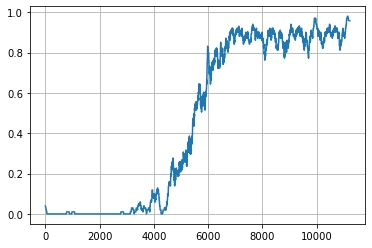

In [3]:
plt.plot(savgol_filter(trr!=-49,101,1)); plt.grid(b=True); 

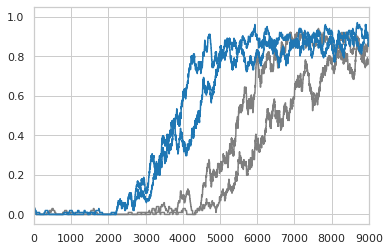

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np
sns.set_theme(style="whitegrid")

# rew = savgol_filter(trr!=-49,101,1)
# np.savetxt('push_td3_2.txt',(trr!=-49)*1,fmt='%d')


r = np.array(np.loadtxt('push_td3.txt',dtype='int')).T
r1 = np.array(np.loadtxt('push_td3_2.txt',dtype='int')).T
r2 = np.array(np.loadtxt('push_comp.txt',dtype='int')).T
r3 = np.array(np.loadtxt('push_comp2.txt',dtype='int')).T


plt.plot(savgol_filter(np.array(r),101,1).T,color='tab:grey')
plt.plot(savgol_filter(np.array(r1),101,1).T,color='tab:grey')
plt.plot(savgol_filter(np.array(r2),101,1).T,color='tab:blue')
plt.plot(savgol_filter(np.array(r3),101,1).T,color='tab:blue')
plt.xlim([0,9000])

    
plt.savefig('demo.png', transparent=True)

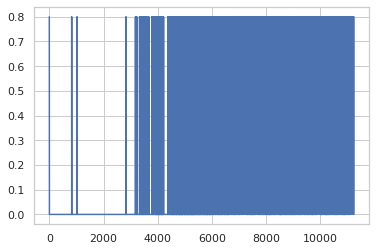

In [16]:
plt.plot(m_2)

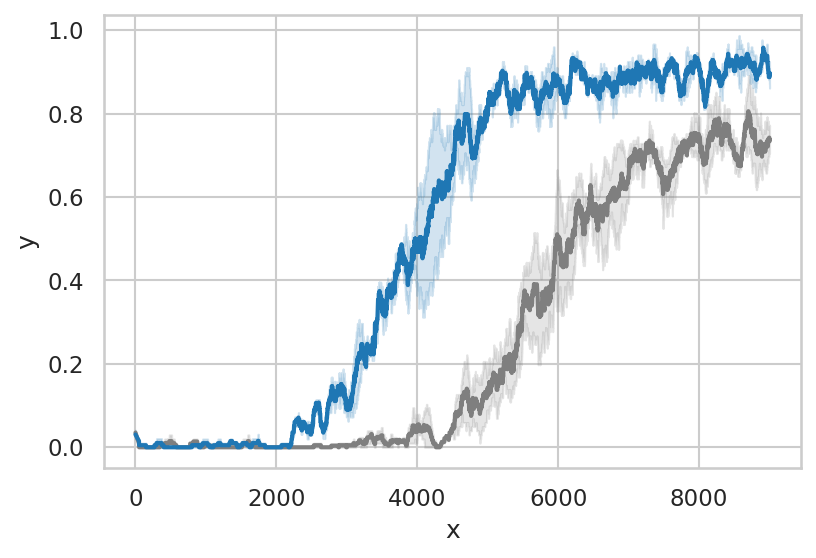

In [33]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

m_1 = np.array(np.loadtxt('push_td3.txt'))
m_2 = np.array(np.loadtxt('push_td3_2.txt'))*0.8

g099_1 = np.array(np.loadtxt('push_comp.txt'))*1.05
g099_2 = np.array(np.loadtxt('push_comp2.txt'))


max_plot=9000
min_plot=0
smooth=101

multi=[savgol_filter(m_1,smooth,1).T[min_plot:max_plot],
          savgol_filter(m_2,smooth,1).T[min_plot:max_plot]
            ]
x=[np.linspace(min_plot,max_plot,len(multi[i])) for i in range(0,len(multi))]


g099=[savgol_filter(g099_1,smooth,1).T[min_plot:max_plot],
          savgol_filter(g099_2,smooth,1).T[min_plot:max_plot]
            ]


df1= pd.DataFrame({"y" : np.concatenate(np.array(multi)),
                  "x" : np.concatenate(np.array(x)),
                 })

df2= pd.DataFrame({"y" : np.concatenate(np.array(g099)),
                  "x" : np.concatenate(np.array(x)),
                 })

plt.figure(dpi=150)
fig=sns.lineplot(x="x", y="y", data=df1,color='tab:grey',linewidth=2,ci=99)
fig=sns.lineplot(x="x", y="y", data=df2,color='tab:blue',linewidth=2,ci=99)

plt.grid(b=True)

plt.savefig('demo.png', transparent=True)